# CS4220 Project 2 - Pathogen Detection

In this notebook, we give an example to show how to read and use the DNA read data. We will train one base line model, using `sklearn.LogisticRegression`, and use it to predict the pathogens in each patient's dataset.

## Related python packages

To get started (if you are using python), you may want to create a virtual python environment and install some packages. Here are some of the commands you might need:

```bash
conda create --name cs4220 python=3.8

# Install jupyter notebook if you are using it
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=cs4220
conda install -c anaconda jupyter

# Some common packages
conda install pandas                      # for reading csv
conda install scikit-learn                # for the logistic regression model
pip install pytorch                       # if you are using neural networks
conda install -c conda-forge matplotlib   # for plotting
conda install seaborn                     # also for plotting
pip install umap-learn[plot]              # plotting UMAP plots
conda install numpy                       # for many math/vectorized operations
```

In [1]:
# import packages

import numpy as np
import pandas as pd
import timeit
import time
import statistics 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from umap.umap_ import UMAP
from joblib import dump, load
from itertools import chain
from typing import Union, Any

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Non-linear classifiers
from sklearn import svm # Should do with RBF or polynomial kernel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier 
# Note OVR -- sensitive to imbalanced dataset, OVO is less sensitive
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)

from utils.common import *
from utils.dataset import CS4220Dataset
from utils.feature_selection import *
from utils.model_evaluation import _read_model, get_all_jaccard_index, performance_evaluate, get_all_jaccard_index_with_transformation

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
from importlib import reload
import utils.common
reload(utils.common)
from utils.common import *

In [29]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import colorcet
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

import umap.plot
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [30]:
# Check the current working directory
%pwd

'/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection'

## Testing Utils

In [31]:

def random_forest_selector(X,y):
    model = RandomForestClassifier(random_state=1, max_depth=10)
    model.fit(X,y)
    features = model.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[-9:]  # top 10 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

def create_coarse_labels(df):
    df['coarse_species_name'] = np.where(df['species_name'] != "decoy", "non_decoy", "decoy")
    le = preprocessing.LabelEncoder()
    le.fit(df['coarse_species_name'].unique())
    y_index = le.transform(df['coarse_species_name'].values)
    df['labels'] = y_index
    print(f"Unique labels {len(df['coarse_species_name'].unique())}")
    return df, le

def filtered_array(array, idx_to_drop):
    return np.take(array, idx_to_drop, axis=1)
    
def jaccard_index_per_patient(patient_id:str, preds):
    # Generic filename
    df_true = pd.read_csv('test_data/patient{}_labels.csv'.format(patient_id))
    tp, fp, tp_fn = 0, 0, df_true['labels'].shape[0]
    print('my predition(s) for patient {}:'.format(patient_id))
    print(preds)
    print('true pathogen')
    print(df_true['labels'].values)
    # if don't predict any pathogen, it means there is only decoy in the test dataset (your prediction)
    if len(preds) == 0:
        preds = ['decoy']
    for item in np.unique(preds):
        if item in df_true['labels'].values:
            tp += 1
        else:
            fp += 1
    #you have to predict all labels correctly, but you are penalized for any false positive
    return tp / (tp_fn + fp) , preds, df_true['labels'].values

def get_all_jaccard_index_with_filter( model:Any, label_encoder:Any , filtered_idx:Any, num_patients:int=10, threshold:float=0.95):

    all_jaccard_index = []
    all_pred = []
    all_true = []
    for patient_id in range(num_patients):
        print('predicting for patient {}'.format(patient_id))

        with open('test_data/patient{}_6mers.npy'.format(patient_id), 'rb') as read_file:
            df_test = np.load(read_file)

        # regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
        transformed_data = filtered_array(df_test,filtered_idx)
        print(f"Shape of {transformed_data.shape}")
        y_pred = model.predict(transformed_data)

        # we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
        # here I apply 0.95 as the cutoff for my predictions, let's see how well my model will behave...
        y_predprob = model.predict_proba(transformed_data)

        # we get only predictions larger than the threshold and if there is more than one, we take the argmax again
        final_predictions = label_encoder.inverse_transform(
                                np.unique([np.argmax(item) for item in y_predprob if len(np.where(item >= threshold)[0]) >= 1]
                            ))

        # my pathogens dectected, decoy will be ignored
        final_predictions = [item for item in final_predictions if item !='decoy']

        ji, pred_pathogen, true_pathogen = jaccard_index_per_patient(patient_id, final_predictions)
        print('Jaccard index: {}'.format(ji))
        all_jaccard_index.append(ji)    
        all_pred.append(pred_pathogen)
        all_true.append(true_pathogen)
    # print(f'all_pred: {all_pred}')
    # print(f'all_true: {all_true}')
    all_pred_flat = [item for sublist in all_pred for item in sublist]
    all_true_flat = [item for sublist in all_true for item in sublist]
    return all_jaccard_index, all_pred_flat, all_true_flat

## Parsing Input Data

First, some dataset statistics. We load our training labels (ground truth) and see how many reads a category (species) have.

In [32]:
label_df = pd.read_csv('./training_data/train_labels.csv')
get_species_count(label_df)

(461581,
 species_name
 decoy                              413476
 burkholderia_pseudomallei            3533
 pseudomonas_aeruginosa               3126
 klebsiella_michiganensis             2989
 mycobacterium_ulcerans               2910
 klebsiella_pneumoniae                2806
 serratia_liquefaciens                2629
 vibrio_parahaemolyticus              2579
 salmonella_enterica_typhimurium      2507
 yersinia_enterocolitica              2276
 stenotrophomonas_maltophilia         2217
 mycobacterium_tuberculosis           2175
 clostridioides_difficile             2007
 acinetobacter_baumannii              1964
 legionella_pneumophila               1753
 listeria_monocytogenes               1479
 staphylococcus_aureus                1384
 staphylococcus_pseudintermedius      1328
 corynebacterium_ulcerans             1266
 corynebacterium_diphtheriae          1194
 streptococcus_suis                   1092
 neisseria_gonorrhoeae                1087
 streptococcus_agalactiae      

In [33]:
coarse_label_df ,coarse_label_encoder = create_coarse_labels(label_df)

Unique labels 2


It seems that we have a lot of decoy reads (decoy means sequencing reads from human or commensal species).

In [81]:
# snippet to load the grouth truth training labels and normalize the label predictions.
# your trained model will predict in this space (26 classes - pathogens and decoy)
processed_label_df ,label_encoder = create_label_df(label_df)
#this label_df will have label index instead of the actual class value

Unique labels 26


We are not training using the full dataset to provide a quick baseline here. Thus, we subsampled so that each category has 500 reads. Up to you to come up with interesting training strategies to use your full training dataset (or even your own datasets)!

In [82]:
#800 here means that there are at most 800 per label class
# find ways to reduce the sample size as there are >10000 samples

samples_800_index = create_sampling_idx(label_df,800)
display(samples_800_index)
# samples_3000_index = create_sampling_idx(label_df, 3000, replace=True)
# display(samples_3000_index)

Index([ 1604,  1901,   629,  1130,   485,  1672,   771,   408,  1682,  1058,
       ...
       46159, 46348, 45996, 47299, 46178, 47598, 46373, 47036, 46441, 46721],
      dtype='int64', length=20800)

In [83]:
create_sampling_idx

<function utils.common.create_sampling_idx(df, sample_num: int, replace: bool = False, random_state: int = 40)>

In this project, we try to use canonical $k$-mer profiles to represent each read in the input. Here, we are using $k=6$ and consequently 2081 features (including 1 feature `IGNORE` for ambiguous $k$-mer) for each read. Read [this reference](https://bioinfologics.github.io/post/2018/09/17/k-mer-counting-part-i-introduction/) for more information.

To help you save time, we implemented a utility class `CS4220Dataset` that can
- take in raw reads as input (`.fasta`, `.fa` files), and turn them into $k$-mer profiles, or
- take in $k$-mer profile as input (`.npy` files),
- allow you to sample data or create $k$-mer profile on the fly (during training) to save memory.

In [84]:
# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

coarse_sampled_dataset = CS4220Dataset(data_file=input_file_path, label_df=coarse_label_df, samples_index=samples_800_index)
print(len(coarse_sampled_dataset.X[:, :-1]), len(coarse_sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(coarse_sampled_dataset.Y))

20800 2080
20800


In [105]:
# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

sampled_dataset = CS4220Dataset(data_file=input_file_path, label_df=processed_label_df, samples_index=samples_800_index)
sampled_dataset.X=sampled_dataset.X[:, :-1]
print(len(sampled_dataset.X[:, :-1]), len(sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(sampled_dataset.Y))

20800 2079
20800


In [65]:
# Using all data
all_dataset = CS4220Dataset(data_file=input_file_path, label_df=processed_label_df)
print(len(all_dataset.X[:, :-1]), len(all_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(all_dataset.Y))

461581 2080
461581


## Individual Dataset Preparation

### Features by Std

In [66]:
# Getting all the low variation of mean kmer 
STD_DEV_THRESHOLD = 0.0001
kmer_analysis = get_kmer_analysis_map(sampled_dataset)

# For entire dataset
getting_no_kmer_existence(kmer_analysis)
std_accross_labels_sorted = get_std_across_labels_by_kmer(kmer_analysis)

# Tunable parameter
sampled_dataset_features_to_keep = [key for key, elem in std_accross_labels_sorted.items() if elem >  STD_DEV_THRESHOLD]

idx_keep_by_std_filter = sampled_dataset.X_mapped.columns.get_indexer(sampled_dataset_features_to_keep)

 label 3 ::  ['CGATCG']


In [67]:
len(sampled_dataset_features_to_keep)

1937

In [68]:
array_by_std_filter = np.take(sampled_dataset.X, idx_keep_by_std_filter, axis=1)
# array_by_std_filter = np.take(all_dataset.X, idx_keep_by_std_filter, axis=1)

In [69]:
array_by_std_filter.shape

(78000, 1937)

In [70]:
std_accross_labels_sorted.keys()

dict_keys(['CCTAGG', 'CCCCTA', 'GCCCTA', 'GTATAC', 'CCCTAC', 'CACTAC', 'AGGTTC', 'GAATTC', 'TACGTA', 'AGGTAC', 'CTACAC', 'ATGGAC', 'AGTACT', 'ACCCTA', 'CGTCTA', 'ACCCCT', 'CCCCCC', 'AGATCT', 'TGTACA', 'GCTAGC', 'GAGTAC', 'GTACAC', 'ACTAGT', 'ACTACC', 'GGACTA', 'AGTACC', 'ATAGGG', 'AGATGC', 'CCCTAG', 'GACCTA', 'GTAGAC', 'ACCTAC', 'CTTAAG', 'AAGGGT', 'GGATAC', 'AGAACC', 'AGGGAC', 'GGTAGA', 'TTCGAA', 'AGGGGG', 'GGGCTA', 'CGTACG', 'CGTGTA', 'CCTACA', 'GGGGTA', 'AAGGGG', 'GATGGA', 'ACATGT', 'GGTTCA', 'CGACTA', 'GGTCTA', 'ATGTCC', 'TCTAGA', 'GTCCTA', 'AGTCCC', 'AGTGTC', 'CTATGC', 'GGTACC', 'CCTAAC', 'GCATAC', 'TAGGGA', 'GATCTA', 'GCTACA', 'CGAGAG', 'GGGACA', 'CGAGTA', 'GCACTA', 'CACGTG', 'ACACTC', 'ATAGGC', 'AGGGTA', 'CTACCC', 'CTCGTA', 'ACGGAG', 'GGTACA', 'CTAACC', 'AGAGCC', 'CTATCC', 'ACTCCC', 'ACCCAT', 'CCACTC', 'ACAACC', 'CCCGTA', 'CATACC', 'GTACGA', 'GAGGTA', 'CTAGGC', 'GGCCTA', 'CCACTA', 'ACATCC', 'ACGTCT', 'ACAGTC', 'CATAGG', 'GGGTAC', 'CCTTAC', 'AACCCT', 'CCTATC', 'GACTAC', 'CAGAAC',

In [372]:
# Getting all the low variation of mean kmer 
STD_DEV_THRESHOLD = 0.0001
kmer_analysis = get_kmer_analysis_map(all_dataset)

# For entire dataset
getting_no_kmer_existence(kmer_analysis)
std_accross_labels_sorted = get_std_across_labels_by_kmer(kmer_analysis)

# Tunable parameter
all_dataset_features_to_keep = [key for key, elem in std_accross_labels_sorted.items() if elem >  STD_DEV_THRESHOLD]

idx_keep_by_std_filter = all_dataset.X_mapped.columns.get_indexer(all_dataset_features_to_keep)

 label 3 ::  ['CGATCG']


### Features by Feature Importance

In [110]:
len(sampled_dataset.X[0])

2080

In [124]:
# NUMBER
NUMBER_TO_DROP = 501
feature_impt = pd.read_csv("assets/feature_impt.csv")
idx_keep_by_feature_impt_1580= feature_impt.sort_values(by="importances").iloc[NUMBER_TO_DROP:].index

In [125]:
array_by_feature_impt = np.take(sampled_dataset.X, idx_keep_by_feature_impt_1580, axis=1)

In [126]:
array_by_feature_impt.shape

(20800, 1580)

## Modelling

In [79]:
# feature impt set 
starting_time = timeit.default_timer()

model = RandomForestClassifier(random_state=1, n_estimators=300, max_depth=16,verbose=1)

%timeit
# Train the model using the training sets
model.fit(array_by_std_filter, sampled_dataset.Y)
dump(model, 'models/rf_std_filter.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

KeyboardInterrupt: 

In [438]:
array_by_std_filter.shape

(78000, 1937)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.2s


 Macro Precision :  1.00, Recall :  1.00, F1 :  1.00
 Micro Precision :  1.00, Recall :  1.00, F1 :  1.00


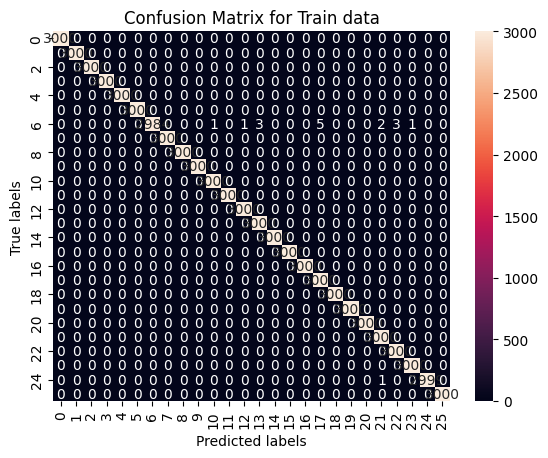

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.1s


 Macro Precision :  1.00, Recall :  1.00, F1 :  1.00
 Micro Precision :  1.00, Recall :  1.00, F1 :  1.00


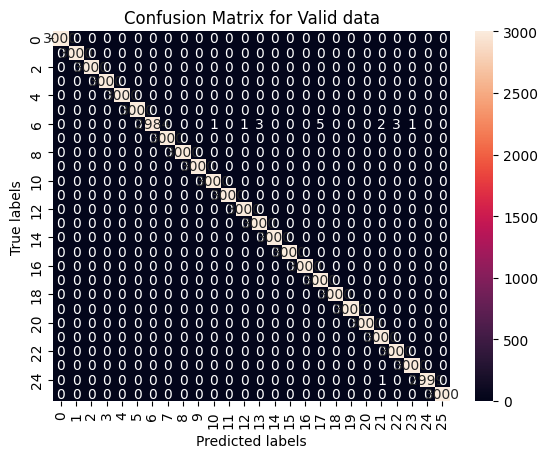

predicting for patient 0
Shape of (10054, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 0:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
Jaccard index: 1.0
predicting for patient 1
Shape of (10132, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 1:
['neisseria_gonorrhoeae']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
Shape of (10022, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 2:
['burkholderia_pseudomallei', 'corynebacterium_ulcerans']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 1.0
predicting for patient 3
Shape of (9984, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 3:
['pseudomonas_aeruginosa']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 1.0
predicting for patient 4
Shape of (10086, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 4:
['corynebacterium_diphtheriae']
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 1.0
predicting for patient 5
Shape of (10046, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 5:
['streptococcus_pneumoniae']
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 1.0
predicting for patient 6
Shape of (9974, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 6:
['mycobacterium_ulcerans']
true pathogen
['mycobacterium_ulcerans']
Jaccard index: 1.0
predicting for patient 7
Shape of (10046, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 7:
['neisseria_gonorrhoeae', 'streptococcus_pneumoniae']
true pathogen
['mycobacterium_tuberculosis' 'streptococcus_pneumoniae']
Jaccard index: 0.3333333333333333
predicting for patient 8
Shape of (10009, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 8:
['streptococcus_pneumoniae']
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 1.0
predicting for patient 9
Shape of (10074, 1937)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


my predition(s) for patient 9:
['burkholderia_pseudomallei', 'neisseria_gonorrhoeae', 'pseudomonas_aeruginosa']
true pathogen
['burkholderia_pseudomallei']
Jaccard index: 0.3333333333333333
['patient 0: 1.0', 'patient 1: 0.0', 'patient 2: 1.0', 'patient 3: 1.0', 'patient 4: 1.0', 'patient 5: 1.0', 'patient 6: 1.0', 'patient 7: 0.3333333333333333', 'patient 8: 1.0', 'patient 9: 0.3333333333333333'] avg: 0.7666666666666666


In [440]:
performance_evaluate(
    train_dataset=(array_by_std_filter, sampled_dataset.Y),
    valid_dataset=(array_by_std_filter, sampled_dataset.Y),
    model_name="rf_std_filter",
    filepath="models"
)

sampled_jaccard_index, sampled_pred, sampled_true = get_all_jaccard_index_with_filter(model=model, label_encoder=label_encoder,filtered_idx=idx_keep_by_std_filter, threshold=0.6)

print(['patient {}: {}'.format(c,item) for c, item in enumerate(sampled_jaccard_index)], 'avg: {}'.format(np.mean(sampled_jaccard_index)))

In [99]:
array_by_feature_impt.shape

(20800, 1580)

In [127]:
# feature impt set 
starting_time = timeit.default_timer()

model = RandomForestClassifier(random_state=1, n_estimators=300, max_depth=16,verbose=1)
%timeit
# Train the model using the training sets
model.fit(array_by_feature_impt, sampled_dataset.Y)
dump(model, 'models/rf_feature_impt_filtered_1580.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   23.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.6min


Time taken : 142.94343683304032


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


 Macro Precision :  1.00, Recall :  1.00, F1 :  1.00
 Micro Precision :  1.00, Recall :  1.00, F1 :  1.00


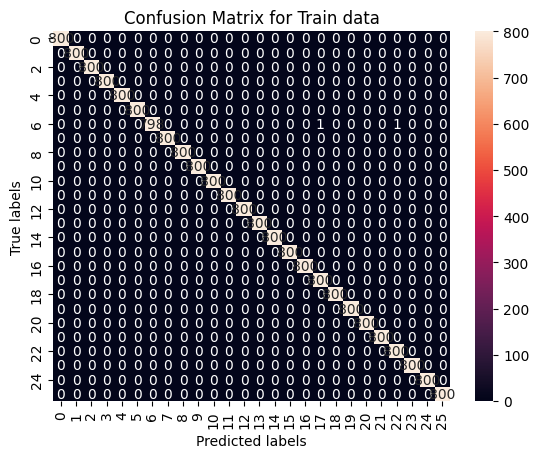

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.8s


 Macro Precision :  1.00, Recall :  1.00, F1 :  1.00
 Micro Precision :  1.00, Recall :  1.00, F1 :  1.00


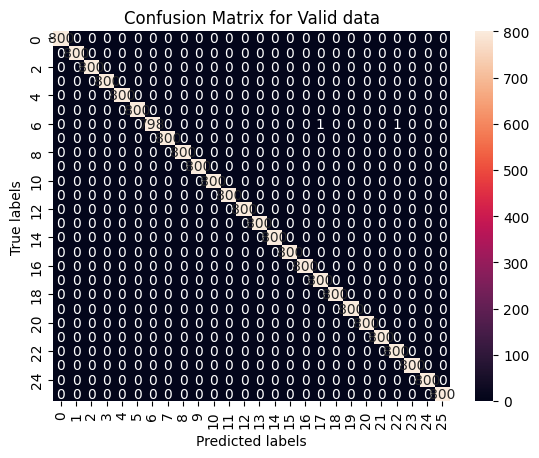

predicting for patient 0
Shape of (10054, 1580)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 0:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
Jaccard index: 1.0
predicting for patient 1
Shape of (10132, 1580)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


my predition(s) for patient 1:
['neisseria_gonorrhoeae']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
Shape of (10022, 1580)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 2:
['burkholderia_pseudomallei', 'corynebacterium_ulcerans']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 1.0
predicting for patient 3
Shape of (9984, 1580)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 3:
['pseudomonas_aeruginosa']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 1.0
predicting for patient 4
Shape of (10086, 1580)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 4:
['corynebacterium_diphtheriae']
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 1.0
predicting for patient 5
Shape of (10046, 1580)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 5:
['streptococcus_pneumoniae']
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 1.0
predicting for patient 6
Shape of (9974, 1580)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 6:
['mycobacterium_ulcerans']
true pathogen
['mycobacterium_ulcerans']
Jaccard index: 1.0
predicting for patient 7
Shape of (10046, 1580)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 7:
['neisseria_gonorrhoeae']
true pathogen
['mycobacterium_tuberculosis' 'streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 8
Shape of (10009, 1580)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 8:
['streptococcus_pneumoniae']
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 1.0
predicting for patient 9
Shape of (10074, 1580)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


my predition(s) for patient 9:
['burkholderia_pseudomallei', 'neisseria_gonorrhoeae']
true pathogen
['burkholderia_pseudomallei']
Jaccard index: 0.5
['patient 0: 1.0', 'patient 1: 0.0', 'patient 2: 1.0', 'patient 3: 1.0', 'patient 4: 1.0', 'patient 5: 1.0', 'patient 6: 1.0', 'patient 7: 0.0', 'patient 8: 1.0', 'patient 9: 0.5'] avg: 0.75


In [128]:
performance_evaluate(
    train_dataset=(array_by_feature_impt, sampled_dataset.Y),
    valid_dataset=(array_by_feature_impt, sampled_dataset.Y),
    model_name="rf_feature_impt_filtered_1580",
    filepath="models"
)

sampled_jaccard_index, sampled_pred, sampled_true = get_all_jaccard_index_with_filter(model=model, label_encoder=label_encoder,filtered_idx=idx_keep_by_feature_impt_1580, threshold=0.6)

print(['patient {}: {}'.format(c,item) for c, item in enumerate(sampled_jaccard_index)], 'avg: {}'.format(np.mean(sampled_jaccard_index)))

## OVO Modelling

In [73]:
filter_num = 0.0001,
model_type = "ovo"
# array_by_feature_impt = np.take(sampled_dataset.X, idx_keep_by_feature_impt_1080, axis=1)

print("executing for this dataset" ,array_by_std_filter.shape)
# Runnning for sampling rate of 800 and toggling feature set
starting_time = timeit.default_timer()

model = OneVsOneClassifier(
    LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=250, verbose=1)
    )

%timeit
# Train the model using the training sets
model.fit(array_by_std_filter, sampled_dataset.Y) 
model_name = f'{model_type}_feature_impt_filtered_{filter_num}.joblib'
dump(model, f"models/{model_name}")
print("Time taken :", timeit.default_timer() - starting_time)

executing for this dataset (78000, 1937)
Epoch 397, change: 0.00073830
Epoch 398, change: 0.00073693


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 399, change: 0.00073533
Epoch 400, change: 0.00073409
Epoch 2, change: 0.18023701
Epoch 401, change: 0.00073265
Epoch 3, change: 0.08097599
Epoch 402, change: 0.00073114
Epoch 4, change: 0.05472833
Epoch 403, change: 0.00072977
Epoch 5, change: 0.04071230
Epoch 404, change: 0.00072840
Epoch 6, change: 0.03381063
Epoch 405, change: 0.00072700
Epoch 7, change: 0.02846679
Epoch 406, change: 0.00072571
Epoch 8, change: 0.02467332
Epoch 407, change: 0.00072416
Epoch 408, change: 0.00072286
Epoch 9, change: 0.02163680
Epoch 409, change: 0.00072152
Epoch 10, change: 0.01941837
Epoch 410, change: 0.00072006
Epoch 11, change: 0.01743407
Epoch 411, change: 0.00071884
Epoch 12, change: 0.01585164
Epoch 412, change: 0.00071748
Epoch 413, change: 0.00071603
Epoch 13, change: 0.01461594
Epoch 414, change: 0.00071476
Epoch 14, change: 0.01344736
Epoch 415, change: 0.00071340
Epoch 15, change: 0.01243816
Epoch 416, change: 0.00071217
Epoch 16, change: 0.01159423
Epoch

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 708, change: 0.00050245
Epoch 2, change: 0.31024387
Epoch 709, change: 0.00050206
Epoch 3, change: 0.15848912
Epoch 710, change: 0.00050167
Epoch 4, change: 0.10378387
Epoch 711, change: 0.00050127
Epoch 5, change: 0.07857611
Epoch 712, change: 0.00050084
Epoch 6, change: 0.06056597
Epoch 713, change: 0.00050039
Epoch 714, change: 0.00050002
Epoch 7, change: 0.04991190
Epoch 715, change: 0.00049964
Epoch 8, change: 0.04249005
Epoch 716, change: 0.00049925
Epoch 9, change: 0.03657436
Epoch 717, change: 0.00049873
Epoch 10, change: 0.03184493
Epoch 718, change: 0.00049839
Epoch 719, change: 0.00049804
Epoch 11, change: 0.02823977
Epoch 720, change: 0.00049754
Epoch 12, change: 0.02549665
Epoch 721, change: 0.00049717
Epoch 13, change: 0.02298482
Epoch 722, change: 0.00049672
Epoch 723, change: 0.00049620
Epoch 14, change: 0.02104722
Epoch 724, change: 0.00049570
Epoch 15, change: 0.01930776
Epoch 725, change: 0.00049519
Epoch 16, change: 0.01774734
Epoch 726, change: 0.00049468
Epo

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33803888
Epoch 3, change: 0.17970180
Epoch 4, change: 0.11718899
Epoch 5, change: 0.09108513
Epoch 6, change: 0.07402677
Epoch 7, change: 0.06206727
Epoch 8, change: 0.05358617
Epoch 9, change: 0.04719182
Epoch 10, change: 0.04199925
Epoch 11, change: 0.03756123
Epoch 12, change: 0.03396403
Epoch 13, change: 0.03093775
Epoch 14, change: 0.02834351
Epoch 15, change: 0.02629844
Epoch 16, change: 0.02429376
Epoch 17, change: 0.02266619
Epoch 18, change: 0.02120074
Epoch 19, change: 0.01990492
Epoch 20, change: 0.01871609
Epoch 21, change: 0.01769805
Epoch 22, change: 0.01675342
Epoch 23, change: 0.01591307
Epoch 24, change: 0.01512678
Epoch 25, change: 0.01444676
Epoch 26, change: 0.01377862
Epoch 27, change: 0.01320603
Epoch 28, change: 0.01264595
Epoch 29, change: 0.01214821
Epoch 30, change: 0.01167476
Epoch 31, change: 0.01123914
Epoch 32, change: 0.01083443
Epoch 33, change: 0.01045050
Epoch 34, change: 0.01010668
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.34149423
Epoch 3, change: 0.18100091
Epoch 4, change: 0.12268790
Epoch 5, change: 0.09465929
Epoch 6, change: 0.07601077
Epoch 7, change: 0.06365735
Epoch 8, change: 0.05449550
Epoch 9, change: 0.04747640
Epoch 10, change: 0.04193318
Epoch 11, change: 0.03773834
Epoch 12, change: 0.03399015
Epoch 13, change: 0.03093597
Epoch 14, change: 0.02831905
Epoch 15, change: 0.02603250
Epoch 16, change: 0.02419472
Epoch 17, change: 0.02245164
Epoch 18, change: 0.02099452
Epoch 19, change: 0.01966875
Epoch 20, change: 0.01848952
Epoch 21, change: 0.01745195
Epoch 22, change: 0.01652275
Epoch 23, change: 0.01566393
Epoch 24, change: 0.01490329
Epoch 25, change: 0.01416422
Epoch 26, change: 0.01352290
Epoch 27, change: 0.01295158
Epoch 28, change: 0.01238109
Epoch 29, change: 0.01188094
Epoch 30, change: 0.01140870
Epoch 31, change: 0.01097433
Epoch 32, change: 0.01056365
Epoch 33, change: 0.01016976
Epoch 34, change: 0.00982690
Epoch 35, change: 0.00949232
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34295028
Epoch 3, change: 0.18422076
Epoch 4, change: 0.12434666
Epoch 5, change: 0.09113310
Epoch 6, change: 0.07373833
Epoch 7, change: 0.06177267
Epoch 8, change: 0.05231597
Epoch 9, change: 0.04539388
Epoch 10, change: 0.03994111
Epoch 11, change: 0.03522916
Epoch 12, change: 0.03176596
Epoch 13, change: 0.02881799
Epoch 14, change: 0.02623634
Epoch 15, change: 0.02406198
Epoch 16, change: 0.02220271
Epoch 17, change: 0.02059495
Epoch 18, change: 0.01920566
Epoch 19, change: 0.01792804
Epoch 20, change: 0.01684159
Epoch 21, change: 0.01581120
Epoch 22, change: 0.01489536
Epoch 23, change: 0.01411189
Epoch 24, change: 0.01335074
Epoch 25, change: 0.01270036
Epoch 26, change: 0.01209228
Epoch 27, change: 0.01155631
Epoch 28, change: 0.01102040
Epoch 29, change: 0.01054698
Epoch 30, change: 0.01010361
Epoch 31, change: 0.00968510
Epoch 32, change: 0.00931521
Epoch 33, change: 0.00896427
Epoch 34, change: 0.00863050
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37025164
Epoch 3, change: 0.20315213
Epoch 4, change: 0.14510867
Epoch 5, change: 0.11232116
Epoch 6, change: 0.08764791
Epoch 7, change: 0.07214749
Epoch 8, change: 0.06035118
Epoch 9, change: 0.05193692
Epoch 10, change: 0.04581410
Epoch 11, change: 0.04005057
Epoch 12, change: 0.03542741
Epoch 13, change: 0.03229467
Epoch 14, change: 0.02906876
Epoch 15, change: 0.02636727
Epoch 16, change: 0.02422506
Epoch 17, change: 0.02218589
Epoch 18, change: 0.02051434
Epoch 19, change: 0.01891554
Epoch 20, change: 0.01771757
Epoch 21, change: 0.01651509
Epoch 22, change: 0.01539886
Epoch 23, change: 0.01456345
Epoch 24, change: 0.01364430
Epoch 25, change: 0.01288252
Epoch 26, change: 0.01213293
Epoch 27, change: 0.01149083
Epoch 28, change: 0.01092009
Epoch 29, change: 0.01041435
Epoch 30, change: 0.00988981
Epoch 31, change: 0.00948251
Epoch 32, change: 0.00898599
Epoch 33, change: 0.00864716
Epoch 34, change: 0.00830598
Epoch 35, change: 0.00791969
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.29539081
Epoch 3, change: 0.15326154
Epoch 4, change: 0.10232592
Epoch 5, change: 0.07456545
Epoch 6, change: 0.05939035
Epoch 7, change: 0.04927831
Epoch 8, change: 0.04162723
Epoch 9, change: 0.03601550
Epoch 10, change: 0.03189708
Epoch 11, change: 0.02856916
Epoch 12, change: 0.02582180
Epoch 13, change: 0.02343992
Epoch 14, change: 0.02134553
Epoch 15, change: 0.01968724
Epoch 16, change: 0.01822486
Epoch 17, change: 0.01688358
Epoch 18, change: 0.01571876
Epoch 19, change: 0.01476009
Epoch 20, change: 0.01390787
Epoch 21, change: 0.01309861
Epoch 22, change: 0.01241329
Epoch 23, change: 0.01175260
Epoch 24, change: 0.01114462
Epoch 25, change: 0.01061802
Epoch 26, change: 0.01012906
Epoch 27, change: 0.00967706
Epoch 28, change: 0.00927525
Epoch 29, change: 0.00890787
Epoch 30, change: 0.00853357
Epoch 31, change: 0.00821906
Epoch 32, change: 0.00790008
Epoch 33, change: 0.00762553
Epoch 34, change: 0.00735459
Epoch 35, change: 0.00710762
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28699377
Epoch 3, change: 0.14613524
Epoch 4, change: 0.09732940
Epoch 5, change: 0.07090497
Epoch 6, change: 0.05769875
Epoch 7, change: 0.04865031
Epoch 8, change: 0.04182415
Epoch 9, change: 0.03709060
Epoch 10, change: 0.03312522
Epoch 11, change: 0.02976312
Epoch 12, change: 0.02716757
Epoch 13, change: 0.02491723
Epoch 14, change: 0.02303250
Epoch 15, change: 0.02135583
Epoch 16, change: 0.01989833
Epoch 17, change: 0.01862136
Epoch 18, change: 0.01746017
Epoch 19, change: 0.01649153
Epoch 20, change: 0.01556795
Epoch 21, change: 0.01479917
Epoch 22, change: 0.01406322
Epoch 23, change: 0.01338316
Epoch 24, change: 0.01277611
Epoch 25, change: 0.01223278
Epoch 26, change: 0.01170059
Epoch 27, change: 0.01123395
Epoch 28, change: 0.01079240
Epoch 29, change: 0.01040031
Epoch 30, change: 0.01001423
Epoch 31, change: 0.00967086
Epoch 32, change: 0.00933589
Epoch 33, change: 0.00903344
Epoch 34, change: 0.00873942
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.40989322
Epoch 3, change: 0.25009583
Epoch 4, change: 0.17068276
Epoch 5, change: 0.13538753
Epoch 6, change: 0.11278828
Epoch 7, change: 0.09517942
Epoch 8, change: 0.08181494
Epoch 9, change: 0.07177503
Epoch 10, change: 0.06386186
Epoch 11, change: 0.05694892
Epoch 12, change: 0.05132603
Epoch 13, change: 0.04754126
Epoch 14, change: 0.04430772
Epoch 15, change: 0.04127715
Epoch 16, change: 0.03877939
Epoch 17, change: 0.03648116
Epoch 18, change: 0.03450604
Epoch 19, change: 0.03263129
Epoch 20, change: 0.03089514
Epoch 21, change: 0.02942447
Epoch 22, change: 0.02802576
Epoch 23, change: 0.02676966
Epoch 24, change: 0.02560016
Epoch 25, change: 0.02449640
Epoch 26, change: 0.02348073
Epoch 27, change: 0.02249692
Epoch 28, change: 0.02163052
Epoch 29, change: 0.02089700
Epoch 30, change: 0.02008424
Epoch 31, change: 0.01939419
Epoch 32, change: 0.01872225
Epoch 33, change: 0.01808981
Epoch 34, change: 0.01748841
Epoch 35, change: 0.016

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.40097175
Epoch 3, change: 0.24870535
Epoch 4, change: 0.17850922
Epoch 5, change: 0.14138074
Epoch 6, change: 0.11572935
Epoch 7, change: 0.09899590
Epoch 8, change: 0.08507335
Epoch 9, change: 0.07461649
Epoch 10, change: 0.06618400
Epoch 11, change: 0.05900414
Epoch 12, change: 0.05347247
Epoch 13, change: 0.04835821
Epoch 14, change: 0.04412282
Epoch 15, change: 0.04048104
Epoch 16, change: 0.03723868
Epoch 17, change: 0.03468407
Epoch 18, change: 0.03213897
Epoch 19, change: 0.02995910
Epoch 20, change: 0.02809494
Epoch 21, change: 0.02639972
Epoch 22, change: 0.02477843
Epoch 23, change: 0.02338881
Epoch 24, change: 0.02203941
Epoch 25, change: 0.02086697
Epoch 26, change: 0.01984766
Epoch 27, change: 0.01891830
Epoch 28, change: 0.01796910
Epoch 29, change: 0.01715878
Epoch 30, change: 0.01638938
Epoch 31, change: 0.01566801
Epoch 32, change: 0.01504858
Epoch 33, change: 0.01442678
Epoch 34, change: 0.01383210
Epoch 35, change: 0.013

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23881284
Epoch 3, change: 0.10978457
Epoch 4, change: 0.07605102
Epoch 5, change: 0.05611855
Epoch 6, change: 0.04583904
Epoch 7, change: 0.03866295
Epoch 8, change: 0.03293537
Epoch 9, change: 0.02903384
Epoch 10, change: 0.02576082
Epoch 11, change: 0.02323384
Epoch 12, change: 0.02098405
Epoch 13, change: 0.01920656
Epoch 14, change: 0.01760594
Epoch 15, change: 0.01625845
Epoch 16, change: 0.01516138
Epoch 17, change: 0.01412940
Epoch 18, change: 0.01328881
Epoch 19, change: 0.01248677
Epoch 20, change: 0.01176675
Epoch 21, change: 0.01114866
Epoch 22, change: 0.01058439
Epoch 23, change: 0.01007567
Epoch 24, change: 0.00959980
Epoch 25, change: 0.00915953
Epoch 26, change: 0.00877356
Epoch 27, change: 0.00841285
Epoch 28, change: 0.00806822
Epoch 29, change: 0.00776989
Epoch 30, change: 0.00748983
Epoch 31, change: 0.00722028
Epoch 32, change: 0.00696558
Epoch 33, change: 0.00674459
Epoch 34, change: 0.00652314
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23668761
Epoch 3, change: 0.11554213
Epoch 4, change: 0.07689927
Epoch 5, change: 0.05592458
Epoch 6, change: 0.04565180
Epoch 7, change: 0.03825823
Epoch 8, change: 0.03326075
Epoch 9, change: 0.02889386
Epoch 10, change: 0.02582258
Epoch 11, change: 0.02301936
Epoch 12, change: 0.02100970
Epoch 13, change: 0.01916686
Epoch 14, change: 0.01763730
Epoch 15, change: 0.01630936
Epoch 16, change: 0.01514644
Epoch 17, change: 0.01415007
Epoch 18, change: 0.01326962
Epoch 19, change: 0.01248127
Epoch 20, change: 0.01177487
Epoch 21, change: 0.01114268
Epoch 22, change: 0.01057484
Epoch 23, change: 0.01006935
Epoch 24, change: 0.00958348
Epoch 25, change: 0.00916084
Epoch 26, change: 0.00875246
Epoch 27, change: 0.00840531
Epoch 28, change: 0.00806528
Epoch 29, change: 0.00775572
Epoch 30, change: 0.00747478
Epoch 31, change: 0.00720083
Epoch 32, change: 0.00695669
Epoch 33, change: 0.00672424
Epoch 34, change: 0.00650538
Epoch 35, change: 0.00630129
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29788880
Epoch 3, change: 0.15165131
Epoch 4, change: 0.10355323
Epoch 5, change: 0.07605710
Epoch 6, change: 0.06082919
Epoch 7, change: 0.05076174
Epoch 8, change: 0.04400693
Epoch 9, change: 0.03773229
Epoch 10, change: 0.03356228
Epoch 11, change: 0.03002790
Epoch 12, change: 0.02693513
Epoch 13, change: 0.02439046
Epoch 14, change: 0.02233224
Epoch 15, change: 0.02058730
Epoch 16, change: 0.01911626
Epoch 17, change: 0.01773426
Epoch 18, change: 0.01655093
Epoch 19, change: 0.01552781
Epoch 20, change: 0.01468600
Epoch 21, change: 0.01390164
Epoch 22, change: 0.01321295
Epoch 23, change: 0.01258405
Epoch 24, change: 0.01200592
Epoch 25, change: 0.01144848
Epoch 26, change: 0.01098055
Epoch 27, change: 0.01052437
Epoch 28, change: 0.01011041
Epoch 29, change: 0.00973408
Epoch 30, change: 0.00938316
Epoch 31, change: 0.00904564
Epoch 32, change: 0.00873171
Epoch 33, change: 0.00842447
Epoch 34, change: 0.00816051
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22872767
Epoch 3, change: 0.10511640
Epoch 4, change: 0.06909754
Epoch 5, change: 0.05174912
Epoch 6, change: 0.04122329
Epoch 7, change: 0.03489897
Epoch 8, change: 0.02994670
Epoch 9, change: 0.02616228
Epoch 10, change: 0.02316030
Epoch 11, change: 0.02065218
Epoch 12, change: 0.01859223
Epoch 13, change: 0.01695788
Epoch 14, change: 0.01557978
Epoch 15, change: 0.01441930
Epoch 16, change: 0.01328658
Epoch 17, change: 0.01248769
Epoch 18, change: 0.01186842
Epoch 19, change: 0.01129497
Epoch 20, change: 0.01075529
Epoch 21, change: 0.01029873
Epoch 22, change: 0.00988191
Epoch 23, change: 0.00948432
Epoch 24, change: 0.00911720
Epoch 25, change: 0.00879157
Epoch 26, change: 0.00848732
Epoch 27, change: 0.00820085
Epoch 28, change: 0.00794529
Epoch 29, change: 0.00770154
Epoch 30, change: 0.00747506
Epoch 31, change: 0.00727053
Epoch 32, change: 0.00707031
Epoch 33, change: 0.00688192
Epoch 34, change: 0.00670974
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33759037
Epoch 3, change: 0.18423806
Epoch 4, change: 0.12224179
Epoch 5, change: 0.09299958
Epoch 6, change: 0.07551255
Epoch 7, change: 0.06205825
Epoch 8, change: 0.05329513
Epoch 9, change: 0.04656889
Epoch 10, change: 0.04102103
Epoch 11, change: 0.03656641
Epoch 12, change: 0.03315650
Epoch 13, change: 0.03005231
Epoch 14, change: 0.02752883
Epoch 15, change: 0.02543481
Epoch 16, change: 0.02352056
Epoch 17, change: 0.02189851
Epoch 18, change: 0.02052050
Epoch 19, change: 0.01920994
Epoch 20, change: 0.01811051
Epoch 21, change: 0.01709532
Epoch 22, change: 0.01619664
Epoch 23, change: 0.01538296
Epoch 24, change: 0.01464357
Epoch 25, change: 0.01391937
Epoch 26, change: 0.01333221
Epoch 27, change: 0.01276039
Epoch 28, change: 0.01219651
Epoch 29, change: 0.01172640
Epoch 30, change: 0.01127831
Epoch 31, change: 0.01085380
Epoch 32, change: 0.01046558
Epoch 33, change: 0.01010757
Epoch 34, change: 0.00975600
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31318558
Epoch 3, change: 0.16455692
Epoch 4, change: 0.11153092
Epoch 5, change: 0.08483041
Epoch 6, change: 0.06734983
Epoch 7, change: 0.05734872
Epoch 8, change: 0.04880743
Epoch 9, change: 0.04214856
Epoch 10, change: 0.03729607
Epoch 11, change: 0.03341267
Epoch 12, change: 0.03026763
Epoch 13, change: 0.02757852
Epoch 14, change: 0.02531478
Epoch 15, change: 0.02321437
Epoch 16, change: 0.02149958
Epoch 17, change: 0.02003154
Epoch 18, change: 0.01871127
Epoch 19, change: 0.01758971
Epoch 20, change: 0.01651046
Epoch 21, change: 0.01556375
Epoch 22, change: 0.01475671
Epoch 23, change: 0.01400200
Epoch 24, change: 0.01330563
Epoch 25, change: 0.01266348
Epoch 26, change: 0.01211162
Epoch 27, change: 0.01156713
Epoch 28, change: 0.01109399
Epoch 29, change: 0.01065279
Epoch 30, change: 0.01022377
Epoch 31, change: 0.00984102
Epoch 32, change: 0.00946216
Epoch 33, change: 0.00913546
Epoch 34, change: 0.00881983
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.40477522
Epoch 3, change: 0.24397934
Epoch 4, change: 0.17022529
Epoch 5, change: 0.13299746
Epoch 6, change: 0.10828801
Epoch 7, change: 0.09159384
Epoch 8, change: 0.07979176
Epoch 9, change: 0.06913666
Epoch 10, change: 0.06295687
Epoch 11, change: 0.05868884
Epoch 12, change: 0.05513365
Epoch 13, change: 0.05178882
Epoch 14, change: 0.04892512
Epoch 15, change: 0.04626988
Epoch 16, change: 0.04376457
Epoch 17, change: 0.04191921
Epoch 18, change: 0.03977008
Epoch 19, change: 0.03827296
Epoch 20, change: 0.03647068
Epoch 21, change: 0.03480616
Epoch 22, change: 0.03342598
Epoch 23, change: 0.03228214
Epoch 24, change: 0.03102977
Epoch 25, change: 0.02988175
Epoch 26, change: 0.02882011
Epoch 27, change: 0.02786811
Epoch 28, change: 0.02686321
Epoch 29, change: 0.02598629
Epoch 30, change: 0.02516637
Epoch 31, change: 0.02438209
Epoch 32, change: 0.02365171
Epoch 33, change: 0.02298913
Epoch 34, change: 0.02199084
Epoch 35, change: 0.02128880
Epoch 36, change: 0.02

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.41164304
Epoch 3, change: 0.24753192
Epoch 4, change: 0.18633309
Epoch 5, change: 0.14530071
Epoch 6, change: 0.12099405
Epoch 7, change: 0.10273300
Epoch 8, change: 0.08881609
Epoch 9, change: 0.07829075
Epoch 10, change: 0.06948115
Epoch 11, change: 0.06245339
Epoch 12, change: 0.05660550
Epoch 13, change: 0.05130468
Epoch 14, change: 0.04714458
Epoch 15, change: 0.04339926
Epoch 16, change: 0.04016140
Epoch 17, change: 0.03724837
Epoch 18, change: 0.03483069
Epoch 19, change: 0.03261552
Epoch 20, change: 0.03060712
Epoch 21, change: 0.02870009
Epoch 22, change: 0.02710777
Epoch 23, change: 0.02567288
Epoch 24, change: 0.02426946
Epoch 25, change: 0.02308878
Epoch 26, change: 0.02196336
Epoch 27, change: 0.02093018
Epoch 28, change: 0.01992226
Epoch 29, change: 0.01909733
Epoch 30, change: 0.01827842
Epoch 31, change: 0.01749022
Epoch 32, change: 0.01684415
Epoch 33, change: 0.01613863
Epoch 34, change: 0.01552067
Epoch 35, change: 0.014

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.42243965
Epoch 3, change: 0.25781923
Epoch 4, change: 0.18222739
Epoch 5, change: 0.14601293
Epoch 6, change: 0.12273692
Epoch 7, change: 0.10243433
Epoch 8, change: 0.08900288
Epoch 9, change: 0.07774471
Epoch 10, change: 0.06910234
Epoch 11, change: 0.06195753
Epoch 12, change: 0.05600278
Epoch 13, change: 0.05101665
Epoch 14, change: 0.04685860
Epoch 15, change: 0.04301859
Epoch 16, change: 0.03978452
Epoch 17, change: 0.03680091
Epoch 18, change: 0.03445324
Epoch 19, change: 0.03221063
Epoch 20, change: 0.03016989
Epoch 21, change: 0.02840350
Epoch 22, change: 0.02672539
Epoch 23, change: 0.02528710
Epoch 24, change: 0.02398023
Epoch 25, change: 0.02265003
Epoch 26, change: 0.02157953
Epoch 27, change: 0.02057007
Epoch 28, change: 0.01956656
Epoch 29, change: 0.01872668
Epoch 30, change: 0.01789667
Epoch 31, change: 0.01714829
Epoch 32, change: 0.01648045
Epoch 33, change: 0.01583014
Epoch 34, change: 0.01518494
Epoch 35, change: 0.014

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23101148
Epoch 3, change: 0.11056004
Epoch 4, change: 0.07059247
Epoch 5, change: 0.05412164
Epoch 6, change: 0.04292131
Epoch 7, change: 0.03633240
Epoch 8, change: 0.03130467
Epoch 9, change: 0.02773429
Epoch 10, change: 0.02451653
Epoch 11, change: 0.02198601
Epoch 12, change: 0.01999923
Epoch 13, change: 0.01830157
Epoch 14, change: 0.01681483
Epoch 15, change: 0.01553551
Epoch 16, change: 0.01442901
Epoch 17, change: 0.01343592
Epoch 18, change: 0.01260031
Epoch 19, change: 0.01187245
Epoch 20, change: 0.01117379
Epoch 21, change: 0.01061334
Epoch 22, change: 0.01013862
Epoch 23, change: 0.00970834
Epoch 24, change: 0.00931460
Epoch 25, change: 0.00895312
Epoch 26, change: 0.00862621
Epoch 27, change: 0.00832168
Epoch 28, change: 0.00804206
Epoch 29, change: 0.00777224
Epoch 30, change: 0.00753367
Epoch 31, change: 0.00730200
Epoch 32, change: 0.00708664
Epoch 33, change: 0.00688397
Epoch 34, change: 0.00669787
Epoch 35, change: 0.00651743
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.40167491
Epoch 3, change: 0.24253390
Epoch 4, change: 0.17349823
Epoch 5, change: 0.13870087
Epoch 6, change: 0.11373799
Epoch 7, change: 0.09745307
Epoch 8, change: 0.08487571
Epoch 9, change: 0.07424166
Epoch 10, change: 0.06600522
Epoch 11, change: 0.05956279
Epoch 12, change: 0.05352573
Epoch 13, change: 0.04877546
Epoch 14, change: 0.04480897
Epoch 15, change: 0.04121402
Epoch 16, change: 0.03864280
Epoch 17, change: 0.03659028
Epoch 18, change: 0.03468847
Epoch 19, change: 0.03284030
Epoch 20, change: 0.03129776
Epoch 21, change: 0.02985232
Epoch 22, change: 0.02849557
Epoch 23, change: 0.02724694
Epoch 24, change: 0.02595992
Epoch 25, change: 0.02496641
Epoch 26, change: 0.02398338
Epoch 27, change: 0.02302138
Epoch 28, change: 0.02220947
Epoch 29, change: 0.02142032
Epoch 30, change: 0.02068005
Epoch 31, change: 0.01992996
Epoch 32, change: 0.01922450
Epoch 33, change: 0.01862553
Epoch 34, change: 0.01798630
Epoch 35, change: 0.01747371
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39381478
Epoch 3, change: 0.22638573
Epoch 4, change: 0.16124982
Epoch 5, change: 0.12379758
Epoch 6, change: 0.10057260
Epoch 7, change: 0.08439281
Epoch 8, change: 0.07202108
Epoch 9, change: 0.06333187
Epoch 10, change: 0.05541713
Epoch 11, change: 0.04939168
Epoch 12, change: 0.04451857
Epoch 13, change: 0.04015278
Epoch 14, change: 0.03651474
Epoch 15, change: 0.03367248
Epoch 16, change: 0.03086194
Epoch 17, change: 0.02845109
Epoch 18, change: 0.02669711
Epoch 19, change: 0.02515663
Epoch 20, change: 0.02369078
Epoch 21, change: 0.02230701
Epoch 22, change: 0.02126616
Epoch 23, change: 0.02022858
Epoch 24, change: 0.01922784
Epoch 25, change: 0.01830374
Epoch 26, change: 0.01749320
Epoch 27, change: 0.01675460
Epoch 28, change: 0.01605027
Epoch 29, change: 0.01533762
Epoch 30, change: 0.01479097
Epoch 31, change: 0.01422881
Epoch 32, change: 0.01371327
Epoch 33, change: 0.01319870
Epoch 34, change: 0.01273781
Epoch 35, change: 0.012

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.38822627
Epoch 3, change: 0.23532891
Epoch 4, change: 0.16641061
Epoch 5, change: 0.12809176
Epoch 6, change: 0.10532505
Epoch 7, change: 0.08763743
Epoch 8, change: 0.07496333
Epoch 9, change: 0.06561114
Epoch 10, change: 0.05753880
Epoch 11, change: 0.05129811
Epoch 12, change: 0.04615487
Epoch 13, change: 0.04169494
Epoch 14, change: 0.03785473
Epoch 15, change: 0.03490500
Epoch 16, change: 0.03205201
Epoch 17, change: 0.02959708
Epoch 18, change: 0.02747516
Epoch 19, change: 0.02560603
Epoch 20, change: 0.02397205
Epoch 21, change: 0.02238430
Epoch 22, change: 0.02110009
Epoch 23, change: 0.01987070
Epoch 24, change: 0.01881274
Epoch 25, change: 0.01784121
Epoch 26, change: 0.01691388
Epoch 27, change: 0.01610300
Epoch 28, change: 0.01531228
Epoch 29, change: 0.01463620
Epoch 30, change: 0.01398370
Epoch 31, change: 0.01339571
Epoch 32, change: 0.01284383
Epoch 33, change: 0.01233319
Epoch 34, change: 0.01184642
Epoch 35, change: 0.01136687
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37880028
Epoch 3, change: 0.22582132
Epoch 4, change: 0.15949893
Epoch 5, change: 0.12203054
Epoch 6, change: 0.09818337
Epoch 7, change: 0.08309375
Epoch 8, change: 0.07145702
Epoch 9, change: 0.06262557
Epoch 10, change: 0.05511185
Epoch 11, change: 0.04880244
Epoch 12, change: 0.04413281
Epoch 13, change: 0.04007970
Epoch 14, change: 0.03660944
Epoch 15, change: 0.03352461
Epoch 16, change: 0.03101583
Epoch 17, change: 0.02882830
Epoch 18, change: 0.02676526
Epoch 19, change: 0.02499948
Epoch 20, change: 0.02346793
Epoch 21, change: 0.02209453
Epoch 22, change: 0.02085306
Epoch 23, change: 0.01961386
Epoch 24, change: 0.01865296
Epoch 25, change: 0.01770156
Epoch 26, change: 0.01683810
Epoch 27, change: 0.01608609
Epoch 28, change: 0.01531927
Epoch 29, change: 0.01466424
Epoch 30, change: 0.01403416
Epoch 31, change: 0.01346764
Epoch 32, change: 0.01294377
Epoch 33, change: 0.01242406
Epoch 34, change: 0.01195641
Epoch 35, change: 0.01153479
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.38267239
Epoch 3, change: 0.21987091
Epoch 4, change: 0.15177361
Epoch 5, change: 0.11781972
Epoch 6, change: 0.09429303
Epoch 7, change: 0.07946612
Epoch 8, change: 0.06804952
Epoch 9, change: 0.05924368
Epoch 10, change: 0.05240910
Epoch 11, change: 0.04671517
Epoch 12, change: 0.04217344
Epoch 13, change: 0.03812101
Epoch 14, change: 0.03487598
Epoch 15, change: 0.03206782
Epoch 16, change: 0.02962082
Epoch 17, change: 0.02751603
Epoch 18, change: 0.02556836
Epoch 19, change: 0.02395886
Epoch 20, change: 0.02248128
Epoch 21, change: 0.02110875
Epoch 22, change: 0.01995850
Epoch 23, change: 0.01890042
Epoch 24, change: 0.01785274
Epoch 25, change: 0.01700070
Epoch 26, change: 0.01621703
Epoch 27, change: 0.01545729
Epoch 28, change: 0.01477245
Epoch 29, change: 0.01410636
Epoch 30, change: 0.01353662
Epoch 31, change: 0.01299476
Epoch 32, change: 0.01251349
Epoch 33, change: 0.01202633
Epoch 34, change: 0.01160581
Epoch 35, change: 0.01118803
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.17160371
Epoch 3, change: 0.07917081
Epoch 4, change: 0.05587378
Epoch 5, change: 0.04503864
Epoch 6, change: 0.03667106
Epoch 7, change: 0.03224808
Epoch 8, change: 0.02892088
Epoch 9, change: 0.02585264
Epoch 10, change: 0.02338827
Epoch 11, change: 0.02135543
Epoch 12, change: 0.01968889
Epoch 13, change: 0.01824447
Epoch 14, change: 0.01704908
Epoch 15, change: 0.01600402
Epoch 16, change: 0.01504580
Epoch 17, change: 0.01418091
Epoch 18, change: 0.01341968
Epoch 19, change: 0.01277429
Epoch 20, change: 0.01216541
Epoch 21, change: 0.01159291
Epoch 22, change: 0.01108376
Epoch 23, change: 0.01064703
Epoch 24, change: 0.01021815
Epoch 25, change: 0.00982217
Epoch 26, change: 0.00945244
Epoch 27, change: 0.00914613
Epoch 28, change: 0.00883038
Epoch 29, change: 0.00852907
Epoch 30, change: 0.00828360
Epoch 31, change: 0.00802105
Epoch 32, change: 0.00778973
Epoch 33, change: 0.00756331
Epoch 34, change: 0.00735972
Epoch 35, change: 0.00715597
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.15464702
Epoch 3, change: 0.07031913
Epoch 4, change: 0.04179353
Epoch 5, change: 0.03439947
Epoch 6, change: 0.02864499
Epoch 7, change: 0.02412701
Epoch 8, change: 0.02111182
Epoch 9, change: 0.01890053
Epoch 10, change: 0.01683296
Epoch 11, change: 0.01536518
Epoch 12, change: 0.01396075
Epoch 13, change: 0.01288727
Epoch 14, change: 0.01189506
Epoch 15, change: 0.01104702
Epoch 16, change: 0.01034340
Epoch 17, change: 0.00968716
Epoch 18, change: 0.00912182
Epoch 19, change: 0.00860866
Epoch 20, change: 0.00814946
Epoch 21, change: 0.00772790
Epoch 22, change: 0.00735009
Epoch 23, change: 0.00700659
Epoch 24, change: 0.00670956
Epoch 25, change: 0.00641594
Epoch 26, change: 0.00617041
Epoch 27, change: 0.00592211
Epoch 28, change: 0.00569306
Epoch 29, change: 0.00550096
Epoch 30, change: 0.00533841
Epoch 31, change: 0.00517280
Epoch 32, change: 0.00502338
Epoch 33, change: 0.00488258
Epoch 34, change: 0.00475241
Epoch 35, change: 0.004

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22399105
Epoch 3, change: 0.10619516
Epoch 4, change: 0.07107888
Epoch 5, change: 0.05277339
Epoch 6, change: 0.04341961
Epoch 7, change: 0.03612784
Epoch 8, change: 0.03130291
Epoch 9, change: 0.02749470
Epoch 10, change: 0.02428743
Epoch 11, change: 0.02180413
Epoch 12, change: 0.01975986
Epoch 13, change: 0.01801134
Epoch 14, change: 0.01655943
Epoch 15, change: 0.01536811
Epoch 16, change: 0.01434935
Epoch 17, change: 0.01347108
Epoch 18, change: 0.01262250
Epoch 19, change: 0.01192313
Epoch 20, change: 0.01125699
Epoch 21, change: 0.01068046
Epoch 22, change: 0.01015732
Epoch 23, change: 0.00966121
Epoch 24, change: 0.00921882
Epoch 25, change: 0.00884327
Epoch 26, change: 0.00846322
Epoch 27, change: 0.00812772
Epoch 28, change: 0.00781867
Epoch 29, change: 0.00751764
Epoch 30, change: 0.00724497
Epoch 31, change: 0.00699463
Epoch 32, change: 0.00675594
Epoch 33, change: 0.00653544
Epoch 34, change: 0.00630883
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22571877
Epoch 3, change: 0.10954361
Epoch 4, change: 0.06993701
Epoch 5, change: 0.05213097
Epoch 6, change: 0.04297031
Epoch 7, change: 0.03597265
Epoch 8, change: 0.03094719
Epoch 9, change: 0.02754584
Epoch 10, change: 0.02445756
Epoch 11, change: 0.02212297
Epoch 12, change: 0.02018175
Epoch 13, change: 0.01850339
Epoch 14, change: 0.01711306
Epoch 15, change: 0.01583626
Epoch 16, change: 0.01479387
Epoch 17, change: 0.01379317
Epoch 18, change: 0.01297436
Epoch 19, change: 0.01224671
Epoch 20, change: 0.01158692
Epoch 21, change: 0.01097307
Epoch 22, change: 0.01042203
Epoch 23, change: 0.00994835
Epoch 24, change: 0.00947627
Epoch 25, change: 0.00903417
Epoch 26, change: 0.00869039
Epoch 27, change: 0.00835091
Epoch 28, change: 0.00799646
Epoch 29, change: 0.00770507
Epoch 30, change: 0.00742868
Epoch 31, change: 0.00716730
Epoch 32, change: 0.00693025
Epoch 33, change: 0.00670067
Epoch 34, change: 0.00649025
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.18493898
Epoch 3, change: 0.08454154
Epoch 4, change: 0.05421567
Epoch 5, change: 0.04040242
Epoch 6, change: 0.03394900
Epoch 7, change: 0.02808065
Epoch 8, change: 0.02396885
Epoch 9, change: 0.02137343
Epoch 10, change: 0.01900580
Epoch 11, change: 0.01694552
Epoch 12, change: 0.01535052
Epoch 13, change: 0.01423292
Epoch 14, change: 0.01329655
Epoch 15, change: 0.01244720
Epoch 16, change: 0.01169679
Epoch 17, change: 0.01111606
Epoch 18, change: 0.01046915
Epoch 19, change: 0.00998530
Epoch 20, change: 0.00954344
Epoch 21, change: 0.00911257
Epoch 22, change: 0.00873838
Epoch 23, change: 0.00840085
Epoch 24, change: 0.00808200
Epoch 25, change: 0.00779052
Epoch 26, change: 0.00754653
Epoch 27, change: 0.00728946
Epoch 28, change: 0.00704657
Epoch 29, change: 0.00683801
Epoch 30, change: 0.00662932
Epoch 31, change: 0.00644733
Epoch 32, change: 0.00626944
Epoch 33, change: 0.00610931
Epoch 34, change: 0.00594073
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.24144506
Epoch 3, change: 0.11642454
Epoch 4, change: 0.07759402
Epoch 5, change: 0.05981195
Epoch 6, change: 0.04942312
Epoch 7, change: 0.04157646
Epoch 8, change: 0.03713327
Epoch 9, change: 0.03307612
Epoch 10, change: 0.02955488
Epoch 11, change: 0.02686086
Epoch 12, change: 0.02476944
Epoch 13, change: 0.02285900
Epoch 14, change: 0.02149965
Epoch 15, change: 0.02031277
Epoch 16, change: 0.01925225
Epoch 17, change: 0.01829068
Epoch 18, change: 0.01742609
Epoch 19, change: 0.01665531
Epoch 20, change: 0.01596530
Epoch 21, change: 0.01531478
Epoch 22, change: 0.01472228
Epoch 23, change: 0.01417869
Epoch 24, change: 0.01370365
Epoch 25, change: 0.01320632
Epoch 26, change: 0.01279329
Epoch 27, change: 0.01240548
Epoch 28, change: 0.01198737
Epoch 29, change: 0.01163048
Epoch 30, change: 0.01127138
Epoch 31, change: 0.01098220
Epoch 32, change: 0.01068121
Epoch 33, change: 0.01039630
Epoch 34, change: 0.01012643
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.24032340
Epoch 3, change: 0.11234565
Epoch 4, change: 0.07528170
Epoch 5, change: 0.05950346
Epoch 6, change: 0.04788846
Epoch 7, change: 0.04094123
Epoch 8, change: 0.03592511
Epoch 9, change: 0.03181273
Epoch 10, change: 0.02891885
Epoch 11, change: 0.02644936
Epoch 12, change: 0.02451821
Epoch 13, change: 0.02308063
Epoch 14, change: 0.02190123
Epoch 15, change: 0.02085905
Epoch 16, change: 0.01987572
Epoch 17, change: 0.01895678
Epoch 18, change: 0.01807904
Epoch 19, change: 0.01720981
Epoch 20, change: 0.01650273
Epoch 21, change: 0.01580366
Epoch 22, change: 0.01519753
Epoch 23, change: 0.01466642
Epoch 24, change: 0.01409533
Epoch 25, change: 0.01362905
Epoch 26, change: 0.01315666
Epoch 27, change: 0.01276004
Epoch 28, change: 0.01235450
Epoch 29, change: 0.01197853
Epoch 30, change: 0.01162740
Epoch 31, change: 0.01129796
Epoch 32, change: 0.01097006
Epoch 33, change: 0.01069222
Epoch 34, change: 0.01039630
Epoch 35, change: 0.01014364
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.18148464
Epoch 3, change: 0.08243862
Epoch 4, change: 0.05403270
Epoch 5, change: 0.04177421
Epoch 6, change: 0.03373582
Epoch 7, change: 0.02904147
Epoch 8, change: 0.02449740
Epoch 9, change: 0.02183452
Epoch 10, change: 0.01938496
Epoch 11, change: 0.01746400
Epoch 12, change: 0.01593845
Epoch 13, change: 0.01459789
Epoch 14, change: 0.01344689
Epoch 15, change: 0.01247668
Epoch 16, change: 0.01163168
Epoch 17, change: 0.01089089
Epoch 18, change: 0.01025188
Epoch 19, change: 0.00965998
Epoch 20, change: 0.00913089
Epoch 21, change: 0.00865172
Epoch 22, change: 0.00822249
Epoch 23, change: 0.00785223
Epoch 24, change: 0.00747005
Epoch 25, change: 0.00714439
Epoch 26, change: 0.00685478
Epoch 27, change: 0.00657447
Epoch 28, change: 0.00632297
Epoch 29, change: 0.00608378
Epoch 30, change: 0.00585983
Epoch 31, change: 0.00565205
Epoch 32, change: 0.00546618
Epoch 33, change: 0.00528458
Epoch 34, change: 0.00511654
Epoch 35, change: 0.004

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.17776067
Epoch 3, change: 0.08187081
Epoch 4, change: 0.05202957
Epoch 5, change: 0.04055069
Epoch 6, change: 0.03277424
Epoch 7, change: 0.02797336
Epoch 8, change: 0.02419097
Epoch 9, change: 0.02132742
Epoch 10, change: 0.01896001
Epoch 11, change: 0.01707027
Epoch 12, change: 0.01555650
Epoch 13, change: 0.01410021
Epoch 14, change: 0.01301194
Epoch 15, change: 0.01203619
Epoch 16, change: 0.01117672
Epoch 17, change: 0.01046022
Epoch 18, change: 0.00975698
Epoch 19, change: 0.00921222
Epoch 20, change: 0.00866317
Epoch 21, change: 0.00820215
Epoch 22, change: 0.00778370
Epoch 23, change: 0.00744223
Epoch 24, change: 0.00715942
Epoch 25, change: 0.00690626
Epoch 26, change: 0.00670194
Epoch 27, change: 0.00647806
Epoch 28, change: 0.00627779
Epoch 29, change: 0.00609976
Epoch 30, change: 0.00592390
Epoch 31, change: 0.00576228
Epoch 32, change: 0.00560570
Epoch 33, change: 0.00545854
Epoch 34, change: 0.00532619
Epoch 35, change: 0.00519466
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28361540
Epoch 3, change: 0.14027796
Epoch 4, change: 0.09191864
Epoch 5, change: 0.06881970
Epoch 6, change: 0.05650468
Epoch 7, change: 0.04726368
Epoch 8, change: 0.04086323
Epoch 9, change: 0.03584035
Epoch 10, change: 0.03181928
Epoch 11, change: 0.02840454
Epoch 12, change: 0.02579756
Epoch 13, change: 0.02352720
Epoch 14, change: 0.02165434
Epoch 15, change: 0.01996300
Epoch 16, change: 0.01854035
Epoch 17, change: 0.01726752
Epoch 18, change: 0.01619092
Epoch 19, change: 0.01523427
Epoch 20, change: 0.01432402
Epoch 21, change: 0.01358251
Epoch 22, change: 0.01285451
Epoch 23, change: 0.01222922
Epoch 24, change: 0.01165205
Epoch 25, change: 0.01113523
Epoch 26, change: 0.01061273
Epoch 27, change: 0.01015154
Epoch 28, change: 0.00974541
Epoch 29, change: 0.00932545
Epoch 30, change: 0.00896274
Epoch 31, change: 0.00862500
Epoch 32, change: 0.00831471
Epoch 33, change: 0.00801188
Epoch 34, change: 0.00774548
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.26716944
Epoch 3, change: 0.13286692
Epoch 4, change: 0.08667379
Epoch 5, change: 0.06544116
Epoch 6, change: 0.05205105
Epoch 7, change: 0.04459861
Epoch 8, change: 0.03816704
Epoch 9, change: 0.03361240
Epoch 10, change: 0.02983581
Epoch 11, change: 0.02679972
Epoch 12, change: 0.02433069
Epoch 13, change: 0.02211814
Epoch 14, change: 0.02047937
Epoch 15, change: 0.01888897
Epoch 16, change: 0.01757046
Epoch 17, change: 0.01636253
Epoch 18, change: 0.01540481
Epoch 19, change: 0.01452355
Epoch 20, change: 0.01372120
Epoch 21, change: 0.01301730
Epoch 22, change: 0.01240521
Epoch 23, change: 0.01179636
Epoch 24, change: 0.01127060
Epoch 25, change: 0.01079410
Epoch 26, change: 0.01037203
Epoch 27, change: 0.00992343
Epoch 28, change: 0.00956255
Epoch 29, change: 0.00920171
Epoch 30, change: 0.00887820
Epoch 31, change: 0.00858099
Epoch 32, change: 0.00828846
Epoch 33, change: 0.00801023
Epoch 34, change: 0.00778145
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22427858
Epoch 3, change: 0.10822463
Epoch 4, change: 0.07079881
Epoch 5, change: 0.04989432
Epoch 6, change: 0.04206978
Epoch 7, change: 0.03530806
Epoch 8, change: 0.03045229
Epoch 9, change: 0.02704157
Epoch 10, change: 0.02431961
Epoch 11, change: 0.02210942
Epoch 12, change: 0.02017840
Epoch 13, change: 0.01869275
Epoch 14, change: 0.01733991
Epoch 15, change: 0.01610927
Epoch 16, change: 0.01507920
Epoch 17, change: 0.01413331
Epoch 18, change: 0.01336490
Epoch 19, change: 0.01264318
Epoch 20, change: 0.01201095
Epoch 21, change: 0.01142314
Epoch 22, change: 0.01087541
Epoch 23, change: 0.01042140
Epoch 24, change: 0.00995097
Epoch 25, change: 0.00959771
Epoch 26, change: 0.00932416
Epoch 27, change: 0.00908166
Epoch 28, change: 0.00883593
Epoch 29, change: 0.00860351
Epoch 30, change: 0.00838972
Epoch 31, change: 0.00819634
Epoch 32, change: 0.00800944
Epoch 33, change: 0.00783840
Epoch 34, change: 0.00765788
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.27390642
Epoch 3, change: 0.13316379
Epoch 4, change: 0.08340218
Epoch 5, change: 0.06259213
Epoch 6, change: 0.05251963
Epoch 7, change: 0.04581778
Epoch 8, change: 0.04072642
Epoch 9, change: 0.03660625
Epoch 10, change: 0.03350859
Epoch 11, change: 0.03083208
Epoch 12, change: 0.02844468
Epoch 13, change: 0.02662344
Epoch 14, change: 0.02485718
Epoch 15, change: 0.02328721
Epoch 16, change: 0.02202410
Epoch 17, change: 0.02083474
Epoch 18, change: 0.01981723
Epoch 19, change: 0.01883572
Epoch 20, change: 0.01799697
Epoch 21, change: 0.01718247
Epoch 22, change: 0.01644383
Epoch 23, change: 0.01580079
Epoch 24, change: 0.01518575
Epoch 25, change: 0.01463842
Epoch 26, change: 0.01413130
Epoch 27, change: 0.01359330
Epoch 28, change: 0.01313907
Epoch 29, change: 0.01272951
Epoch 30, change: 0.01232346
Epoch 31, change: 0.01193546
Epoch 32, change: 0.01160218
Epoch 33, change: 0.01126350
Epoch 34, change: 0.01093905
Epoch 35, change: 0.01065225
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23131487
Epoch 3, change: 0.11187695
Epoch 4, change: 0.07289571
Epoch 5, change: 0.05306557
Epoch 6, change: 0.04229609
Epoch 7, change: 0.03541767
Epoch 8, change: 0.03080977
Epoch 9, change: 0.02742976
Epoch 10, change: 0.02491798
Epoch 11, change: 0.02263467
Epoch 12, change: 0.02087820
Epoch 13, change: 0.01932695
Epoch 14, change: 0.01790881
Epoch 15, change: 0.01678329
Epoch 16, change: 0.01572444
Epoch 17, change: 0.01486188
Epoch 18, change: 0.01409139
Epoch 19, change: 0.01334082
Epoch 20, change: 0.01268972
Epoch 21, change: 0.01209946
Epoch 22, change: 0.01158848
Epoch 23, change: 0.01110751
Epoch 24, change: 0.01079261
Epoch 25, change: 0.01051538
Epoch 26, change: 0.01025205
Epoch 27, change: 0.00999460
Epoch 28, change: 0.00975671
Epoch 29, change: 0.00956385
Epoch 30, change: 0.00932918
Epoch 31, change: 0.00915004
Epoch 32, change: 0.00896758
Epoch 33, change: 0.00880042
Epoch 34, change: 0.00862325
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23335481
Epoch 3, change: 0.10566542
Epoch 4, change: 0.07332395
Epoch 5, change: 0.05429020
Epoch 6, change: 0.04410428
Epoch 7, change: 0.03655754
Epoch 8, change: 0.03144319
Epoch 9, change: 0.02734560
Epoch 10, change: 0.02420282
Epoch 11, change: 0.02205967
Epoch 12, change: 0.02017966
Epoch 13, change: 0.01862258
Epoch 14, change: 0.01730592
Epoch 15, change: 0.01616258
Epoch 16, change: 0.01518893
Epoch 17, change: 0.01428777
Epoch 18, change: 0.01353103
Epoch 19, change: 0.01281989
Epoch 20, change: 0.01212994
Epoch 21, change: 0.01158245
Epoch 22, change: 0.01108035
Epoch 23, change: 0.01058076
Epoch 24, change: 0.01016810
Epoch 25, change: 0.00978595
Epoch 26, change: 0.00940835
Epoch 27, change: 0.00905579
Epoch 28, change: 0.00875635
Epoch 29, change: 0.00845854
Epoch 30, change: 0.00819133
Epoch 31, change: 0.00793239
Epoch 32, change: 0.00768061
Epoch 33, change: 0.00746456
Epoch 34, change: 0.00726652
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.17127778
Epoch 3, change: 0.08096596
Epoch 4, change: 0.04941714
Epoch 5, change: 0.03700120
Epoch 6, change: 0.03055437
Epoch 7, change: 0.02586293
Epoch 8, change: 0.02266658
Epoch 9, change: 0.01980228
Epoch 10, change: 0.01774200
Epoch 11, change: 0.01600773
Epoch 12, change: 0.01454874
Epoch 13, change: 0.01339769
Epoch 14, change: 0.01228393
Epoch 15, change: 0.01137408
Epoch 16, change: 0.01059086
Epoch 17, change: 0.00992814
Epoch 18, change: 0.00933836
Epoch 19, change: 0.00875721
Epoch 20, change: 0.00825951
Epoch 21, change: 0.00782308
Epoch 22, change: 0.00745087
Epoch 23, change: 0.00707350
Epoch 24, change: 0.00674485
Epoch 25, change: 0.00643975
Epoch 26, change: 0.00617572
Epoch 27, change: 0.00590962
Epoch 28, change: 0.00565945
Epoch 29, change: 0.00545330
Epoch 30, change: 0.00524992
Epoch 31, change: 0.00505999
Epoch 32, change: 0.00490717
Epoch 33, change: 0.00479108
Epoch 34, change: 0.00467191
Epoch 35, change: 0.004

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.18198795
Epoch 3, change: 0.07979768
Epoch 4, change: 0.05541147
Epoch 5, change: 0.04267633
Epoch 6, change: 0.03358799
Epoch 7, change: 0.02905060
Epoch 8, change: 0.02494693
Epoch 9, change: 0.02184594
Epoch 10, change: 0.01948862
Epoch 11, change: 0.01763541
Epoch 12, change: 0.01602286
Epoch 13, change: 0.01461048
Epoch 14, change: 0.01349907
Epoch 15, change: 0.01250119
Epoch 16, change: 0.01160253
Epoch 17, change: 0.01087182
Epoch 18, change: 0.01017494
Epoch 19, change: 0.00959687
Epoch 20, change: 0.00905421
Epoch 21, change: 0.00857867
Epoch 22, change: 0.00812835
Epoch 23, change: 0.00773257
Epoch 24, change: 0.00738676
Epoch 25, change: 0.00705641
Epoch 26, change: 0.00674681
Epoch 27, change: 0.00646938
Epoch 28, change: 0.00620402
Epoch 29, change: 0.00597865
Epoch 30, change: 0.00573900
Epoch 31, change: 0.00553776
Epoch 32, change: 0.00535128
Epoch 33, change: 0.00516717
Epoch 34, change: 0.00499445
Epoch 35, change: 0.00483212
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.17903037
Epoch 3, change: 0.08097765
Epoch 4, change: 0.05440555
Epoch 5, change: 0.04061740
Epoch 6, change: 0.03353628
Epoch 7, change: 0.02789038
Epoch 8, change: 0.02419018
Epoch 9, change: 0.02146597
Epoch 10, change: 0.01909313
Epoch 11, change: 0.01725047
Epoch 12, change: 0.01572741
Epoch 13, change: 0.01445181
Epoch 14, change: 0.01326232
Epoch 15, change: 0.01233484
Epoch 16, change: 0.01143889
Epoch 17, change: 0.01074153
Epoch 18, change: 0.01008448
Epoch 19, change: 0.00950817
Epoch 20, change: 0.00895726
Epoch 21, change: 0.00845109
Epoch 22, change: 0.00806754
Epoch 23, change: 0.00766799
Epoch 24, change: 0.00731088
Epoch 25, change: 0.00697908
Epoch 26, change: 0.00668669
Epoch 27, change: 0.00640311
Epoch 28, change: 0.00614921
Epoch 29, change: 0.00591682
Epoch 30, change: 0.00569715
Epoch 31, change: 0.00549685
Epoch 32, change: 0.00530560
Epoch 33, change: 0.00513656
Epoch 34, change: 0.00496462
Epoch 35, change: 0.004

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.25460849
Epoch 3, change: 0.13075157
Epoch 4, change: 0.08658705
Epoch 5, change: 0.06833854
Epoch 6, change: 0.05812741
Epoch 7, change: 0.04963900
Epoch 8, change: 0.04392675
Epoch 9, change: 0.03886451
Epoch 10, change: 0.03516807
Epoch 11, change: 0.03199575
Epoch 12, change: 0.02944031
Epoch 13, change: 0.02709996
Epoch 14, change: 0.02509979
Epoch 15, change: 0.02345028
Epoch 16, change: 0.02196757
Epoch 17, change: 0.02060763
Epoch 18, change: 0.01942960
Epoch 19, change: 0.01836859
Epoch 20, change: 0.01744706
Epoch 21, change: 0.01659996
Epoch 22, change: 0.01579341
Epoch 23, change: 0.01514897
Epoch 24, change: 0.01451935
Epoch 25, change: 0.01392244
Epoch 26, change: 0.01337613
Epoch 27, change: 0.01286554
Epoch 28, change: 0.01240529
Epoch 29, change: 0.01195954
Epoch 30, change: 0.01154689
Epoch 31, change: 0.01117446
Epoch 32, change: 0.01079703
Epoch 33, change: 0.01048861
Epoch 34, change: 0.01015298
Epoch 35, change: 0.00983709
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.18074464
Epoch 3, change: 0.08251737
Epoch 4, change: 0.05095140
Epoch 5, change: 0.04023444
Epoch 6, change: 0.03309748
Epoch 7, change: 0.02716325
Epoch 8, change: 0.02400108
Epoch 9, change: 0.02122982
Epoch 10, change: 0.01889505
Epoch 11, change: 0.01698009
Epoch 12, change: 0.01541923
Epoch 13, change: 0.01411769
Epoch 14, change: 0.01301529
Epoch 15, change: 0.01204174
Epoch 16, change: 0.01122109
Epoch 17, change: 0.01049692
Epoch 18, change: 0.00982074
Epoch 19, change: 0.00925956
Epoch 20, change: 0.00873564
Epoch 21, change: 0.00828480
Epoch 22, change: 0.00786267
Epoch 23, change: 0.00746865
Epoch 24, change: 0.00712406
Epoch 25, change: 0.00680819
Epoch 26, change: 0.00651200
Epoch 27, change: 0.00625002
Epoch 28, change: 0.00599331
Epoch 29, change: 0.00577369
Epoch 30, change: 0.00555427
Epoch 31, change: 0.00535611
Epoch 32, change: 0.00517459
Epoch 33, change: 0.00499626
Epoch 34, change: 0.00483108
Epoch 35, change: 0.004

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.17605606
Epoch 3, change: 0.08046339
Epoch 4, change: 0.05404514
Epoch 5, change: 0.04016753
Epoch 6, change: 0.03380164
Epoch 7, change: 0.02892960
Epoch 8, change: 0.02457227
Epoch 9, change: 0.02184272
Epoch 10, change: 0.01946682
Epoch 11, change: 0.01764789
Epoch 12, change: 0.01602096
Epoch 13, change: 0.01466511
Epoch 14, change: 0.01352253
Epoch 15, change: 0.01255097
Epoch 16, change: 0.01167074
Epoch 17, change: 0.01091417
Epoch 18, change: 0.01024750
Epoch 19, change: 0.00962694
Epoch 20, change: 0.00913493
Epoch 21, change: 0.00864265
Epoch 22, change: 0.00822150
Epoch 23, change: 0.00783247
Epoch 24, change: 0.00747196
Epoch 25, change: 0.00714044
Epoch 26, change: 0.00682918
Epoch 27, change: 0.00653130
Epoch 28, change: 0.00629272
Epoch 29, change: 0.00606532
Epoch 30, change: 0.00583827
Epoch 31, change: 0.00561322
Epoch 32, change: 0.00542625
Epoch 33, change: 0.00525284
Epoch 34, change: 0.00508452
Epoch 35, change: 0.004

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.18722234
Epoch 3, change: 0.08781904
Epoch 4, change: 0.05403099
Epoch 5, change: 0.04036000
Epoch 6, change: 0.03441568
Epoch 7, change: 0.02966571
Epoch 8, change: 0.02538310
Epoch 9, change: 0.02248002
Epoch 10, change: 0.01975415
Epoch 11, change: 0.01798828
Epoch 12, change: 0.01638852
Epoch 13, change: 0.01509482
Epoch 14, change: 0.01389825
Epoch 15, change: 0.01288130
Epoch 16, change: 0.01201610
Epoch 17, change: 0.01123848
Epoch 18, change: 0.01056233
Epoch 19, change: 0.00998558
Epoch 20, change: 0.00941707
Epoch 21, change: 0.00893485
Epoch 22, change: 0.00848360
Epoch 23, change: 0.00806659
Epoch 24, change: 0.00773194
Epoch 25, change: 0.00737349
Epoch 26, change: 0.00708125
Epoch 27, change: 0.00677984
Epoch 28, change: 0.00651677
Epoch 29, change: 0.00628460
Epoch 30, change: 0.00605085
Epoch 31, change: 0.00583212
Epoch 32, change: 0.00564807
Epoch 33, change: 0.00545075
Epoch 34, change: 0.00528432
Epoch 35, change: 0.00512334
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.20099705
Epoch 3, change: 0.09921204
Epoch 4, change: 0.06263408
Epoch 5, change: 0.04630880
Epoch 6, change: 0.03703134
Epoch 7, change: 0.03202833
Epoch 8, change: 0.02806521
Epoch 9, change: 0.02442264
Epoch 10, change: 0.02174447
Epoch 11, change: 0.01956944
Epoch 12, change: 0.01790063
Epoch 13, change: 0.01640081
Epoch 14, change: 0.01512420
Epoch 15, change: 0.01403831
Epoch 16, change: 0.01304592
Epoch 17, change: 0.01218692
Epoch 18, change: 0.01144238
Epoch 19, change: 0.01080242
Epoch 20, change: 0.01023071
Epoch 21, change: 0.00968382
Epoch 22, change: 0.00918414
Epoch 23, change: 0.00872762
Epoch 24, change: 0.00832277
Epoch 25, change: 0.00796166
Epoch 26, change: 0.00761322
Epoch 27, change: 0.00729921
Epoch 28, change: 0.00700986
Epoch 29, change: 0.00674891
Epoch 30, change: 0.00648471
Epoch 31, change: 0.00624859
Epoch 32, change: 0.00603440
Epoch 33, change: 0.00582268
Epoch 34, change: 0.00563570
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.20526516
Epoch 3, change: 0.09699095
Epoch 4, change: 0.06320057
Epoch 5, change: 0.04757333
Epoch 6, change: 0.03845238
Epoch 7, change: 0.03257600
Epoch 8, change: 0.02755472
Epoch 9, change: 0.02447190
Epoch 10, change: 0.02167428
Epoch 11, change: 0.01948148
Epoch 12, change: 0.01768632
Epoch 13, change: 0.01616596
Epoch 14, change: 0.01482433
Epoch 15, change: 0.01373242
Epoch 16, change: 0.01276033
Epoch 17, change: 0.01187258
Epoch 18, change: 0.01113321
Epoch 19, change: 0.01040899
Epoch 20, change: 0.00984925
Epoch 21, change: 0.00933082
Epoch 22, change: 0.00886496
Epoch 23, change: 0.00844508
Epoch 24, change: 0.00807434
Epoch 25, change: 0.00771274
Epoch 26, change: 0.00740031
Epoch 27, change: 0.00709434
Epoch 28, change: 0.00681764
Epoch 29, change: 0.00656464
Epoch 30, change: 0.00632565
Epoch 31, change: 0.00610598
Epoch 32, change: 0.00591630
Epoch 33, change: 0.00570401
Epoch 34, change: 0.00552895
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34275929
Epoch 3, change: 0.18620441
Epoch 4, change: 0.13198294
Epoch 5, change: 0.09679417
Epoch 6, change: 0.07720231
Epoch 7, change: 0.06582307
Epoch 8, change: 0.05495373
Epoch 9, change: 0.04806786
Epoch 10, change: 0.04206810
Epoch 11, change: 0.03769983
Epoch 12, change: 0.03388221
Epoch 13, change: 0.03081959
Epoch 14, change: 0.02811105
Epoch 15, change: 0.02575813
Epoch 16, change: 0.02383753
Epoch 17, change: 0.02213528
Epoch 18, change: 0.02062130
Epoch 19, change: 0.01932804
Epoch 20, change: 0.01817503
Epoch 21, change: 0.01714861
Epoch 22, change: 0.01615371
Epoch 23, change: 0.01537639
Epoch 24, change: 0.01457779
Epoch 25, change: 0.01385928
Epoch 26, change: 0.01322406
Epoch 27, change: 0.01263087
Epoch 28, change: 0.01210380
Epoch 29, change: 0.01157378
Epoch 30, change: 0.01113516
Epoch 31, change: 0.01071601
Epoch 32, change: 0.01030408
Epoch 33, change: 0.00992395
Epoch 34, change: 0.00960104
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22771909
Epoch 3, change: 0.11127857
Epoch 4, change: 0.07431774
Epoch 5, change: 0.05603567
Epoch 6, change: 0.04568628
Epoch 7, change: 0.03926810
Epoch 8, change: 0.03409999
Epoch 9, change: 0.02996804
Epoch 10, change: 0.02670933
Epoch 11, change: 0.02420691
Epoch 12, change: 0.02211490
Epoch 13, change: 0.02031474
Epoch 14, change: 0.01871770
Epoch 15, change: 0.01743593
Epoch 16, change: 0.01626229
Epoch 17, change: 0.01529242
Epoch 18, change: 0.01437397
Epoch 19, change: 0.01356417
Epoch 20, change: 0.01287479
Epoch 21, change: 0.01222603
Epoch 22, change: 0.01164447
Epoch 23, change: 0.01106923
Epoch 24, change: 0.01062415
Epoch 25, change: 0.01016937
Epoch 26, change: 0.00975360
Epoch 27, change: 0.00938010
Epoch 28, change: 0.00902315
Epoch 29, change: 0.00869965
Epoch 30, change: 0.00839240
Epoch 31, change: 0.00811543
Epoch 32, change: 0.00783253
Epoch 33, change: 0.00759226
Epoch 34, change: 0.00735731
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.24168161
Epoch 3, change: 0.11254072
Epoch 4, change: 0.07413479
Epoch 5, change: 0.05547256
Epoch 6, change: 0.04489769
Epoch 7, change: 0.03817191
Epoch 8, change: 0.03293054
Epoch 9, change: 0.02893706
Epoch 10, change: 0.02590814
Epoch 11, change: 0.02345669
Epoch 12, change: 0.02132444
Epoch 13, change: 0.01954158
Epoch 14, change: 0.01808321
Epoch 15, change: 0.01675875
Epoch 16, change: 0.01563588
Epoch 17, change: 0.01468244
Epoch 18, change: 0.01378300
Epoch 19, change: 0.01298606
Epoch 20, change: 0.01230409
Epoch 21, change: 0.01169477
Epoch 22, change: 0.01111692
Epoch 23, change: 0.01056887
Epoch 24, change: 0.01012960
Epoch 25, change: 0.00969298
Epoch 26, change: 0.00928032
Epoch 27, change: 0.00892342
Epoch 28, change: 0.00858249
Epoch 29, change: 0.00827698
Epoch 30, change: 0.00798151
Epoch 31, change: 0.00771014
Epoch 32, change: 0.00744976
Epoch 33, change: 0.00721077
Epoch 34, change: 0.00700024
Epoch 35, change: 0.00678023
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.29885703
Epoch 3, change: 0.15409926
Epoch 4, change: 0.10240631
Epoch 5, change: 0.07898052
Epoch 6, change: 0.06380696
Epoch 7, change: 0.05256685
Epoch 8, change: 0.04531765
Epoch 9, change: 0.03949899
Epoch 10, change: 0.03494080
Epoch 11, change: 0.03126283
Epoch 12, change: 0.02822617
Epoch 13, change: 0.02573679
Epoch 14, change: 0.02362937
Epoch 15, change: 0.02167520
Epoch 16, change: 0.02009126
Epoch 17, change: 0.01871851
Epoch 18, change: 0.01744096
Epoch 19, change: 0.01635085
Epoch 20, change: 0.01538520
Epoch 21, change: 0.01452448
Epoch 22, change: 0.01373187
Epoch 23, change: 0.01303536
Epoch 24, change: 0.01236134
Epoch 25, change: 0.01179058
Epoch 26, change: 0.01124514
Epoch 27, change: 0.01073666
Epoch 28, change: 0.01028330
Epoch 29, change: 0.00985989
Epoch 30, change: 0.00947144
Epoch 31, change: 0.00910074
Epoch 32, change: 0.00877738
Epoch 33, change: 0.00845443
Epoch 34, change: 0.00815172
Epoch 35, change: 0.00787950
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.22895382
Epoch 3, change: 0.11195773
Epoch 4, change: 0.07442652
Epoch 5, change: 0.05791468
Epoch 6, change: 0.04621713
Epoch 7, change: 0.03908201
Epoch 8, change: 0.03422389
Epoch 9, change: 0.03037409
Epoch 10, change: 0.02710115
Epoch 11, change: 0.02454927
Epoch 12, change: 0.02240862
Epoch 13, change: 0.02061451
Epoch 14, change: 0.01905414
Epoch 15, change: 0.01765632
Epoch 16, change: 0.01654490
Epoch 17, change: 0.01545778
Epoch 18, change: 0.01459331
Epoch 19, change: 0.01373982
Epoch 20, change: 0.01301656
Epoch 21, change: 0.01235544
Epoch 22, change: 0.01175437
Epoch 23, change: 0.01123686
Epoch 24, change: 0.01073842
Epoch 25, change: 0.01028792
Epoch 26, change: 0.00986708
Epoch 27, change: 0.00948741
Epoch 28, change: 0.00912821
Epoch 29, change: 0.00879500
Epoch 30, change: 0.00849316
Epoch 31, change: 0.00820622
Epoch 32, change: 0.00794871
Epoch 33, change: 0.00770186
Epoch 34, change: 0.00744456
Epoch 35, change: 0.00723237
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22095020
Epoch 3, change: 0.10464937
Epoch 4, change: 0.07405691
Epoch 5, change: 0.05424593
Epoch 6, change: 0.04554922
Epoch 7, change: 0.03837896
Epoch 8, change: 0.03344480
Epoch 9, change: 0.02957174
Epoch 10, change: 0.02677235
Epoch 11, change: 0.02423326
Epoch 12, change: 0.02214682
Epoch 13, change: 0.02032983
Epoch 14, change: 0.01887455
Epoch 15, change: 0.01750536
Epoch 16, change: 0.01643143
Epoch 17, change: 0.01542010
Epoch 18, change: 0.01453624
Epoch 19, change: 0.01378022
Epoch 20, change: 0.01303572
Epoch 21, change: 0.01239034
Epoch 22, change: 0.01183715
Epoch 23, change: 0.01130745
Epoch 24, change: 0.01081756
Epoch 25, change: 0.01038211
Epoch 26, change: 0.00996889
Epoch 27, change: 0.00958777
Epoch 28, change: 0.00924826
Epoch 29, change: 0.00893344
Epoch 30, change: 0.00862149
Epoch 31, change: 0.00835199
Epoch 32, change: 0.00808253
Epoch 33, change: 0.00784021
Epoch 34, change: 0.00761184
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.32660473
Epoch 3, change: 0.17509966
Epoch 4, change: 0.11600940
Epoch 5, change: 0.08799517
Epoch 6, change: 0.07060631
Epoch 7, change: 0.05869277
Epoch 8, change: 0.05040128
Epoch 9, change: 0.04396493
Epoch 10, change: 0.03887968
Epoch 11, change: 0.03443599
Epoch 12, change: 0.03126032
Epoch 13, change: 0.02834314
Epoch 14, change: 0.02596926
Epoch 15, change: 0.02389176
Epoch 16, change: 0.02211937
Epoch 17, change: 0.02052180
Epoch 18, change: 0.01912640
Epoch 19, change: 0.01797466
Epoch 20, change: 0.01690396
Epoch 21, change: 0.01588608
Epoch 22, change: 0.01505085
Epoch 23, change: 0.01429682
Epoch 24, change: 0.01357353
Epoch 25, change: 0.01290704
Epoch 26, change: 0.01231170
Epoch 27, change: 0.01177445
Epoch 28, change: 0.01125889
Epoch 29, change: 0.01080688
Epoch 30, change: 0.01038557
Epoch 31, change: 0.00997713
Epoch 32, change: 0.00960803
Epoch 33, change: 0.00925822
Epoch 34, change: 0.00892793
Epoch 35, change: 0.00863050
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.33106657
Epoch 3, change: 0.18065497
Epoch 4, change: 0.12000890
Epoch 5, change: 0.09174042
Epoch 6, change: 0.07256276
Epoch 7, change: 0.06011771
Epoch 8, change: 0.05224049
Epoch 9, change: 0.04544923
Epoch 10, change: 0.04025548
Epoch 11, change: 0.03586762
Epoch 12, change: 0.03244888
Epoch 13, change: 0.02939045
Epoch 14, change: 0.02696812
Epoch 15, change: 0.02483518
Epoch 16, change: 0.02306668
Epoch 17, change: 0.02139644
Epoch 18, change: 0.02005485
Epoch 19, change: 0.01875751
Epoch 20, change: 0.01768639
Epoch 21, change: 0.01667242
Epoch 22, change: 0.01579874
Epoch 23, change: 0.01498454
Epoch 24, change: 0.01427178
Epoch 25, change: 0.01359922
Epoch 26, change: 0.01296116
Epoch 27, change: 0.01240042
Epoch 28, change: 0.01189368
Epoch 29, change: 0.01142598
Epoch 30, change: 0.01097130
Epoch 31, change: 0.01055629
Epoch 32, change: 0.01017144
Epoch 33, change: 0.00981314
Epoch 34, change: 0.00947546
Epoch 35, change: 0.00916551
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.18352592
Epoch 3, change: 0.08834563
Epoch 4, change: 0.05544358
Epoch 5, change: 0.04265347
Epoch 6, change: 0.03496005
Epoch 7, change: 0.02963260
Epoch 8, change: 0.02563751
Epoch 9, change: 0.02295715
Epoch 10, change: 0.02052396
Epoch 11, change: 0.01841238
Epoch 12, change: 0.01681724
Epoch 13, change: 0.01549037
Epoch 14, change: 0.01427779
Epoch 15, change: 0.01326017
Epoch 16, change: 0.01238336
Epoch 17, change: 0.01157007
Epoch 18, change: 0.01088611
Epoch 19, change: 0.01028523
Epoch 20, change: 0.00972071
Epoch 21, change: 0.00923891
Epoch 22, change: 0.00881307
Epoch 23, change: 0.00840826
Epoch 24, change: 0.00802832
Epoch 25, change: 0.00769137
Epoch 26, change: 0.00738270
Epoch 27, change: 0.00708857
Epoch 28, change: 0.00682724
Epoch 29, change: 0.00658789
Epoch 30, change: 0.00635503
Epoch 31, change: 0.00614240
Epoch 32, change: 0.00594059
Epoch 33, change: 0.00575652
Epoch 34, change: 0.00557786
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.18296468
Epoch 3, change: 0.08425731
Epoch 4, change: 0.05640582
Epoch 5, change: 0.04368273
Epoch 6, change: 0.03515842
Epoch 7, change: 0.02959668
Epoch 8, change: 0.02601132
Epoch 9, change: 0.02287145
Epoch 10, change: 0.02056778
Epoch 11, change: 0.01856767
Epoch 12, change: 0.01694613
Epoch 13, change: 0.01554323
Epoch 14, change: 0.01437454
Epoch 15, change: 0.01331266
Epoch 16, change: 0.01239764
Epoch 17, change: 0.01164940
Epoch 18, change: 0.01095004
Epoch 19, change: 0.01034319
Epoch 20, change: 0.00978529
Epoch 21, change: 0.00928322
Epoch 22, change: 0.00882316
Epoch 23, change: 0.00842328
Epoch 24, change: 0.00806881
Epoch 25, change: 0.00773329
Epoch 26, change: 0.00741842
Epoch 27, change: 0.00712142
Epoch 28, change: 0.00686280
Epoch 29, change: 0.00660569
Epoch 30, change: 0.00638350
Epoch 31, change: 0.00616509
Epoch 32, change: 0.00596753
Epoch 33, change: 0.00577785
Epoch 34, change: 0.00560037
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.24162088
Epoch 3, change: 0.11760416
Epoch 4, change: 0.07804578
Epoch 5, change: 0.06025007
Epoch 6, change: 0.04928863
Epoch 7, change: 0.04175080
Epoch 8, change: 0.03635192
Epoch 9, change: 0.03194397
Epoch 10, change: 0.02890662
Epoch 11, change: 0.02605160
Epoch 12, change: 0.02380609
Epoch 13, change: 0.02192563
Epoch 14, change: 0.02023715
Epoch 15, change: 0.01880442
Epoch 16, change: 0.01758148
Epoch 17, change: 0.01648474
Epoch 18, change: 0.01553830
Epoch 19, change: 0.01467300
Epoch 20, change: 0.01391601
Epoch 21, change: 0.01318929
Epoch 22, change: 0.01255918
Epoch 23, change: 0.01200574
Epoch 24, change: 0.01147193
Epoch 25, change: 0.01098084
Epoch 26, change: 0.01055684
Epoch 27, change: 0.01015402
Epoch 28, change: 0.00975178
Epoch 29, change: 0.00941276
Epoch 30, change: 0.00907506
Epoch 31, change: 0.00878727
Epoch 32, change: 0.00849822
Epoch 33, change: 0.00823070
Epoch 34, change: 0.00797935
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.17836864
Epoch 3, change: 0.08281093
Epoch 4, change: 0.05613194
Epoch 5, change: 0.04296377
Epoch 6, change: 0.03629183
Epoch 7, change: 0.03083017
Epoch 8, change: 0.02706419
Epoch 9, change: 0.02433267
Epoch 10, change: 0.02212682
Epoch 11, change: 0.02010948
Epoch 12, change: 0.01850104
Epoch 13, change: 0.01708951
Epoch 14, change: 0.01591108
Epoch 15, change: 0.01489992
Epoch 16, change: 0.01399997
Epoch 17, change: 0.01317968
Epoch 18, change: 0.01247777
Epoch 19, change: 0.01184130
Epoch 20, change: 0.01129026
Epoch 21, change: 0.01074661
Epoch 22, change: 0.01027021
Epoch 23, change: 0.00984513
Epoch 24, change: 0.00946333
Epoch 25, change: 0.00908932
Epoch 26, change: 0.00875785
Epoch 27, change: 0.00844443
Epoch 28, change: 0.00817180
Epoch 29, change: 0.00789480
Epoch 30, change: 0.00764667
Epoch 31, change: 0.00740585
Epoch 32, change: 0.00719533
Epoch 33, change: 0.00698921
Epoch 34, change: 0.00680507
Epoch 35, change: 0.00661842
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.24975613
Epoch 3, change: 0.11892030
Epoch 4, change: 0.08012893
Epoch 5, change: 0.06264442
Epoch 6, change: 0.05038397
Epoch 7, change: 0.04269673
Epoch 8, change: 0.03719632
Epoch 9, change: 0.03294145
Epoch 10, change: 0.02940335
Epoch 11, change: 0.02649644
Epoch 12, change: 0.02424573
Epoch 13, change: 0.02219200
Epoch 14, change: 0.02052451
Epoch 15, change: 0.01905708
Epoch 16, change: 0.01779237
Epoch 17, change: 0.01670996
Epoch 18, change: 0.01569104
Epoch 19, change: 0.01480337
Epoch 20, change: 0.01401288
Epoch 21, change: 0.01330679
Epoch 22, change: 0.01268942
Epoch 23, change: 0.01211279
Epoch 24, change: 0.01156304
Epoch 25, change: 0.01107492
Epoch 26, change: 0.01064244
Epoch 27, change: 0.01022107
Epoch 28, change: 0.00983053
Epoch 29, change: 0.00948250
Epoch 30, change: 0.00915537
Epoch 31, change: 0.00884867
Epoch 32, change: 0.00855889
Epoch 33, change: 0.00828950
Epoch 34, change: 0.00804010
Epoch 35, change: 0.00780712
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22916434
Epoch 3, change: 0.11049553
Epoch 4, change: 0.07391028
Epoch 5, change: 0.05556122
Epoch 6, change: 0.04504643
Epoch 7, change: 0.03900253
Epoch 8, change: 0.03403766
Epoch 9, change: 0.02991425
Epoch 10, change: 0.02682796
Epoch 11, change: 0.02423636
Epoch 12, change: 0.02211751
Epoch 13, change: 0.02035679
Epoch 14, change: 0.01875644
Epoch 15, change: 0.01749329
Epoch 16, change: 0.01630555
Epoch 17, change: 0.01531927
Epoch 18, change: 0.01439495
Epoch 19, change: 0.01361768
Epoch 20, change: 0.01290376
Epoch 21, change: 0.01224950
Epoch 22, change: 0.01166940
Epoch 23, change: 0.01113042
Epoch 24, change: 0.01064159
Epoch 25, change: 0.01019731
Epoch 26, change: 0.00977802
Epoch 27, change: 0.00941270
Epoch 28, change: 0.00905598
Epoch 29, change: 0.00874973
Epoch 30, change: 0.00844259
Epoch 31, change: 0.00815841
Epoch 32, change: 0.00789867
Epoch 33, change: 0.00765486
Epoch 34, change: 0.00742073
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32373306
Epoch 3, change: 0.17661861
Epoch 4, change: 0.11513502
Epoch 5, change: 0.08733642
Epoch 6, change: 0.07020633
Epoch 7, change: 0.05716906
Epoch 8, change: 0.04889887
Epoch 9, change: 0.04243281
Epoch 10, change: 0.03683575
Epoch 11, change: 0.03305679
Epoch 12, change: 0.02968558
Epoch 13, change: 0.02681021
Epoch 14, change: 0.02439615
Epoch 15, change: 0.02238411
Epoch 16, change: 0.02062781
Epoch 17, change: 0.01900657
Epoch 18, change: 0.01772203
Epoch 19, change: 0.01657301
Epoch 20, change: 0.01553275
Epoch 21, change: 0.01453773
Epoch 22, change: 0.01367041
Epoch 23, change: 0.01291843
Epoch 24, change: 0.01225361
Epoch 25, change: 0.01163052
Epoch 26, change: 0.01105583
Epoch 27, change: 0.01056237
Epoch 28, change: 0.01006483
Epoch 29, change: 0.00962350
Epoch 30, change: 0.00920824
Epoch 31, change: 0.00882678
Epoch 32, change: 0.00847678
Epoch 33, change: 0.00815536
Epoch 34, change: 0.00783008
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31058673
Epoch 3, change: 0.15843674
Epoch 4, change: 0.10464037
Epoch 5, change: 0.07716014
Epoch 6, change: 0.06290691
Epoch 7, change: 0.05001632
Epoch 8, change: 0.04286845
Epoch 9, change: 0.03657205
Epoch 10, change: 0.03187397
Epoch 11, change: 0.02793747
Epoch 12, change: 0.02496361
Epoch 13, change: 0.02252047
Epoch 14, change: 0.02029471
Epoch 15, change: 0.01860210
Epoch 16, change: 0.01717883
Epoch 17, change: 0.01604802
Epoch 18, change: 0.01496913
Epoch 19, change: 0.01401215
Epoch 20, change: 0.01320198
Epoch 21, change: 0.01245652
Epoch 22, change: 0.01176795
Epoch 23, change: 0.01116475
Epoch 24, change: 0.01061311
Epoch 25, change: 0.01008364
Epoch 26, change: 0.00962984
Epoch 27, change: 0.00920652
Epoch 28, change: 0.00880180
Epoch 29, change: 0.00844801
Epoch 30, change: 0.00810599
Epoch 31, change: 0.00780421
Epoch 32, change: 0.00749332
Epoch 33, change: 0.00722433
Epoch 34, change: 0.00697055
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31938192
Epoch 3, change: 0.16776028
Epoch 4, change: 0.11387586
Epoch 5, change: 0.08655709
Epoch 6, change: 0.07055832
Epoch 7, change: 0.05826956
Epoch 8, change: 0.05056527
Epoch 9, change: 0.04406357
Epoch 10, change: 0.03913029
Epoch 11, change: 0.03512095
Epoch 12, change: 0.03166938
Epoch 13, change: 0.02889806
Epoch 14, change: 0.02649018
Epoch 15, change: 0.02447486
Epoch 16, change: 0.02270325
Epoch 17, change: 0.02118527
Epoch 18, change: 0.01983065
Epoch 19, change: 0.01858554
Epoch 20, change: 0.01755384
Epoch 21, change: 0.01655873
Epoch 22, change: 0.01570081
Epoch 23, change: 0.01491766
Epoch 24, change: 0.01423110
Epoch 25, change: 0.01355415
Epoch 26, change: 0.01295545
Epoch 27, change: 0.01240954
Epoch 28, change: 0.01189227
Epoch 29, change: 0.01144089
Epoch 30, change: 0.01101151
Epoch 31, change: 0.01060914
Epoch 32, change: 0.01022819
Epoch 33, change: 0.00988024
Epoch 34, change: 0.00953593
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.17732883
Epoch 3, change: 0.08492236
Epoch 4, change: 0.05621699
Epoch 5, change: 0.04312386
Epoch 6, change: 0.03346110
Epoch 7, change: 0.03019203
Epoch 8, change: 0.02628434
Epoch 9, change: 0.02321073
Epoch 10, change: 0.02083373
Epoch 11, change: 0.01894701
Epoch 12, change: 0.01740540
Epoch 13, change: 0.01596231
Epoch 14, change: 0.01475788
Epoch 15, change: 0.01379082
Epoch 16, change: 0.01289467
Epoch 17, change: 0.01211752
Epoch 18, change: 0.01142073
Epoch 19, change: 0.01082759
Epoch 20, change: 0.01027482
Epoch 21, change: 0.00977263
Epoch 22, change: 0.00930466
Epoch 23, change: 0.00890903
Epoch 24, change: 0.00851903
Epoch 25, change: 0.00818264
Epoch 26, change: 0.00786169
Epoch 27, change: 0.00756531
Epoch 28, change: 0.00729192
Epoch 29, change: 0.00704928
Epoch 30, change: 0.00681015
Epoch 31, change: 0.00658217
Epoch 32, change: 0.00637533
Epoch 33, change: 0.00618835
Epoch 34, change: 0.00600663
Epoch 35, change: 0.00583947
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34198625
Epoch 3, change: 0.18384422
Epoch 4, change: 0.12509888
Epoch 5, change: 0.09359017
Epoch 6, change: 0.07569943
Epoch 7, change: 0.06353137
Epoch 8, change: 0.05473884
Epoch 9, change: 0.04722743
Epoch 10, change: 0.04171200
Epoch 11, change: 0.03741792
Epoch 12, change: 0.03384010
Epoch 13, change: 0.03073213
Epoch 14, change: 0.02806933
Epoch 15, change: 0.02598055
Epoch 16, change: 0.02403045
Epoch 17, change: 0.02227327
Epoch 18, change: 0.02087094
Epoch 19, change: 0.01957116
Epoch 20, change: 0.01839996
Epoch 21, change: 0.01737533
Epoch 22, change: 0.01647571
Epoch 23, change: 0.01561602
Epoch 24, change: 0.01484909
Epoch 25, change: 0.01415725
Epoch 26, change: 0.01350308
Epoch 27, change: 0.01291453
Epoch 28, change: 0.01236872
Epoch 29, change: 0.01185849
Epoch 30, change: 0.01140253
Epoch 31, change: 0.01098194
Epoch 32, change: 0.01057977
Epoch 33, change: 0.01019889
Epoch 34, change: 0.00985360
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.31069956
Epoch 3, change: 0.16129126
Epoch 4, change: 0.10601361
Epoch 5, change: 0.08207292
Epoch 6, change: 0.06626191
Epoch 7, change: 0.05649919
Epoch 8, change: 0.04823221
Epoch 9, change: 0.04263879
Epoch 10, change: 0.03770362
Epoch 11, change: 0.03377634
Epoch 12, change: 0.03073205
Epoch 13, change: 0.02805890
Epoch 14, change: 0.02584200
Epoch 15, change: 0.02385019
Epoch 16, change: 0.02220068
Epoch 17, change: 0.02076272
Epoch 18, change: 0.01946562
Epoch 19, change: 0.01831298
Epoch 20, change: 0.01728842
Epoch 21, change: 0.01637833
Epoch 22, change: 0.01555988
Epoch 23, change: 0.01477658
Epoch 24, change: 0.01409445
Epoch 25, change: 0.01348678
Epoch 26, change: 0.01289676
Epoch 27, change: 0.01238622
Epoch 28, change: 0.01187963
Epoch 29, change: 0.01143186
Epoch 30, change: 0.01100563
Epoch 31, change: 0.01062100
Epoch 32, change: 0.01024492
Epoch 33, change: 0.00990631
Epoch 34, change: 0.00958097
Epoch 35, change: 0.00928395
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29995896
Epoch 3, change: 0.15522964
Epoch 4, change: 0.10410529
Epoch 5, change: 0.07988557
Epoch 6, change: 0.06431263
Epoch 7, change: 0.05406571
Epoch 8, change: 0.04675161
Epoch 9, change: 0.04083155
Epoch 10, change: 0.03645842
Epoch 11, change: 0.03289197
Epoch 12, change: 0.02976608
Epoch 13, change: 0.02733070
Epoch 14, change: 0.02515157
Epoch 15, change: 0.02327940
Epoch 16, change: 0.02168733
Epoch 17, change: 0.02027627
Epoch 18, change: 0.01903200
Epoch 19, change: 0.01793199
Epoch 20, change: 0.01690891
Epoch 21, change: 0.01604380
Epoch 22, change: 0.01523550
Epoch 23, change: 0.01451205
Epoch 24, change: 0.01383935
Epoch 25, change: 0.01323316
Epoch 26, change: 0.01269496
Epoch 27, change: 0.01216737
Epoch 28, change: 0.01169215
Epoch 29, change: 0.01124977
Epoch 30, change: 0.01084689
Epoch 31, change: 0.01046574
Epoch 32, change: 0.01011277
Epoch 33, change: 0.00976795
Epoch 34, change: 0.00945254
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.26798672
Epoch 3, change: 0.13581153
Epoch 4, change: 0.09117292
Epoch 5, change: 0.06797081
Epoch 6, change: 0.05499963
Epoch 7, change: 0.04645923
Epoch 8, change: 0.03994053
Epoch 9, change: 0.03510963
Epoch 10, change: 0.03144360
Epoch 11, change: 0.02834884
Epoch 12, change: 0.02580255
Epoch 13, change: 0.02365284
Epoch 14, change: 0.02178687
Epoch 15, change: 0.02022112
Epoch 16, change: 0.01882754
Epoch 17, change: 0.01758172
Epoch 18, change: 0.01650500
Epoch 19, change: 0.01557144
Epoch 20, change: 0.01475976
Epoch 21, change: 0.01397194
Epoch 22, change: 0.01328398
Epoch 23, change: 0.01266191
Epoch 24, change: 0.01210818
Epoch 25, change: 0.01159775
Epoch 26, change: 0.01109569
Epoch 27, change: 0.01065726
Epoch 28, change: 0.01025676
Epoch 29, change: 0.00987676
Epoch 30, change: 0.00952129
Epoch 31, change: 0.00919916
Epoch 32, change: 0.00890165
Epoch 33, change: 0.00861875
Epoch 34, change: 0.00834730
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.26613956
Epoch 3, change: 0.13312444
Epoch 4, change: 0.08976036
Epoch 5, change: 0.06737184
Epoch 6, change: 0.05516591
Epoch 7, change: 0.04549449
Epoch 8, change: 0.04001090
Epoch 9, change: 0.03521803
Epoch 10, change: 0.03131204
Epoch 11, change: 0.02813219
Epoch 12, change: 0.02563676
Epoch 13, change: 0.02357014
Epoch 14, change: 0.02169645
Epoch 15, change: 0.02008288
Epoch 16, change: 0.01875184
Epoch 17, change: 0.01754269
Epoch 18, change: 0.01647857
Epoch 19, change: 0.01552504
Epoch 20, change: 0.01470975
Epoch 21, change: 0.01395601
Epoch 22, change: 0.01325965
Epoch 23, change: 0.01263970
Epoch 24, change: 0.01206335
Epoch 25, change: 0.01154203
Epoch 26, change: 0.01107549
Epoch 27, change: 0.01064057
Epoch 28, change: 0.01022730
Epoch 29, change: 0.00985452
Epoch 30, change: 0.00950403
Epoch 31, change: 0.00917684
Epoch 32, change: 0.00887163
Epoch 33, change: 0.00858533
Epoch 34, change: 0.00832397
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23883024
Epoch 3, change: 0.10971089
Epoch 4, change: 0.07313978
Epoch 5, change: 0.05500945
Epoch 6, change: 0.04513915
Epoch 7, change: 0.03785901
Epoch 8, change: 0.03227402
Epoch 9, change: 0.02852164
Epoch 10, change: 0.02522589
Epoch 11, change: 0.02267182
Epoch 12, change: 0.02054773
Epoch 13, change: 0.01881414
Epoch 14, change: 0.01730983
Epoch 15, change: 0.01599470
Epoch 16, change: 0.01485173
Epoch 17, change: 0.01380412
Epoch 18, change: 0.01294581
Epoch 19, change: 0.01218504
Epoch 20, change: 0.01149387
Epoch 21, change: 0.01085069
Epoch 22, change: 0.01031973
Epoch 23, change: 0.00985636
Epoch 24, change: 0.00943149
Epoch 25, change: 0.00901948
Epoch 26, change: 0.00866398
Epoch 27, change: 0.00832108
Epoch 28, change: 0.00800346
Epoch 29, change: 0.00773586
Epoch 30, change: 0.00746278
Epoch 31, change: 0.00720749
Epoch 32, change: 0.00698568
Epoch 33, change: 0.00676562
Epoch 34, change: 0.00656026
Epoch 35, change: 0.00637687
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.24376080
Epoch 3, change: 0.11592079
Epoch 4, change: 0.07603389
Epoch 5, change: 0.05569053
Epoch 6, change: 0.04423517
Epoch 7, change: 0.03713372
Epoch 8, change: 0.03213445
Epoch 9, change: 0.02782727
Epoch 10, change: 0.02476483
Epoch 11, change: 0.02229488
Epoch 12, change: 0.02023632
Epoch 13, change: 0.01854052
Epoch 14, change: 0.01706140
Epoch 15, change: 0.01581206
Epoch 16, change: 0.01470548
Epoch 17, change: 0.01375575
Epoch 18, change: 0.01292448
Epoch 19, change: 0.01215739
Epoch 20, change: 0.01148839
Epoch 21, change: 0.01087454
Epoch 22, change: 0.01036944
Epoch 23, change: 0.00986734
Epoch 24, change: 0.00942074
Epoch 25, change: 0.00900012
Epoch 26, change: 0.00862361
Epoch 27, change: 0.00827412
Epoch 28, change: 0.00796966
Epoch 29, change: 0.00767641
Epoch 30, change: 0.00738930
Epoch 31, change: 0.00714223
Epoch 32, change: 0.00690763
Epoch 33, change: 0.00667888
Epoch 34, change: 0.00647862
Epoch 35, change: 0.00627943
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30643636
Epoch 3, change: 0.16008544
Epoch 4, change: 0.10926945
Epoch 5, change: 0.08147806
Epoch 6, change: 0.06573198
Epoch 7, change: 0.05531420
Epoch 8, change: 0.04741597
Epoch 9, change: 0.04099991
Epoch 10, change: 0.03639812
Epoch 11, change: 0.03428823
Epoch 12, change: 0.03228342
Epoch 13, change: 0.03032086
Epoch 14, change: 0.02887505
Epoch 15, change: 0.02736900
Epoch 16, change: 0.02588492
Epoch 17, change: 0.02475784
Epoch 18, change: 0.02378787
Epoch 19, change: 0.02264874
Epoch 20, change: 0.02186196
Epoch 21, change: 0.02099265
Epoch 22, change: 0.02020880
Epoch 23, change: 0.01960514
Epoch 24, change: 0.01885230
Epoch 25, change: 0.01828960
Epoch 26, change: 0.01774265
Epoch 27, change: 0.01719171
Epoch 28, change: 0.01666753
Epoch 29, change: 0.01619165
Epoch 30, change: 0.01576802
Epoch 31, change: 0.01537972
Epoch 32, change: 0.01494977
Epoch 33, change: 0.01455934
Epoch 34, change: 0.01420429
Epoch 35, change: 0.013

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22478488
Epoch 3, change: 0.10662999
Epoch 4, change: 0.07105517
Epoch 5, change: 0.05580177
Epoch 6, change: 0.04485722
Epoch 7, change: 0.03746298
Epoch 8, change: 0.03279610
Epoch 9, change: 0.02890686
Epoch 10, change: 0.02580710
Epoch 11, change: 0.02334441
Epoch 12, change: 0.02121895
Epoch 13, change: 0.01934868
Epoch 14, change: 0.01779241
Epoch 15, change: 0.01645252
Epoch 16, change: 0.01537427
Epoch 17, change: 0.01437160
Epoch 18, change: 0.01341605
Epoch 19, change: 0.01263490
Epoch 20, change: 0.01193501
Epoch 21, change: 0.01131020
Epoch 22, change: 0.01070190
Epoch 23, change: 0.01017078
Epoch 24, change: 0.00970727
Epoch 25, change: 0.00927405
Epoch 26, change: 0.00888434
Epoch 27, change: 0.00849008
Epoch 28, change: 0.00816088
Epoch 29, change: 0.00785084
Epoch 30, change: 0.00755034
Epoch 31, change: 0.00727623
Epoch 32, change: 0.00702593
Epoch 33, change: 0.00679616
Epoch 34, change: 0.00656733
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.21838585
Epoch 3, change: 0.10660657
Epoch 4, change: 0.06699273
Epoch 5, change: 0.05147696
Epoch 6, change: 0.04196608
Epoch 7, change: 0.03485486
Epoch 8, change: 0.03023878
Epoch 9, change: 0.02616145
Epoch 10, change: 0.02345532
Epoch 11, change: 0.02112836
Epoch 12, change: 0.01922041
Epoch 13, change: 0.01767214
Epoch 14, change: 0.01633874
Epoch 15, change: 0.01513768
Epoch 16, change: 0.01415668
Epoch 17, change: 0.01320706
Epoch 18, change: 0.01241739
Epoch 19, change: 0.01173254
Epoch 20, change: 0.01108263
Epoch 21, change: 0.01054202
Epoch 22, change: 0.01002189
Epoch 23, change: 0.00954420
Epoch 24, change: 0.00912969
Epoch 25, change: 0.00872269
Epoch 26, change: 0.00837352
Epoch 27, change: 0.00803956
Epoch 28, change: 0.00775157
Epoch 29, change: 0.00745596
Epoch 30, change: 0.00718559
Epoch 31, change: 0.00695172
Epoch 32, change: 0.00670947
Epoch 33, change: 0.00651405
Epoch 34, change: 0.00630866
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.34417180
Epoch 3, change: 0.18465810
Epoch 4, change: 0.12484811
Epoch 5, change: 0.09437894
Epoch 6, change: 0.07473877
Epoch 7, change: 0.06237223
Epoch 8, change: 0.05351253
Epoch 9, change: 0.04646852
Epoch 10, change: 0.04079194
Epoch 11, change: 0.03633579
Epoch 12, change: 0.03271294
Epoch 13, change: 0.02960206
Epoch 14, change: 0.02707857
Epoch 15, change: 0.02494710
Epoch 16, change: 0.02308129
Epoch 17, change: 0.02144004
Epoch 18, change: 0.01996719
Epoch 19, change: 0.01871495
Epoch 20, change: 0.01759154
Epoch 21, change: 0.01658387
Epoch 22, change: 0.01561098
Epoch 23, change: 0.01481770
Epoch 24, change: 0.01409091
Epoch 25, change: 0.01338672
Epoch 26, change: 0.01276129
Epoch 27, change: 0.01220544
Epoch 28, change: 0.01164384
Epoch 29, change: 0.01118206
Epoch 30, change: 0.01071683
Epoch 31, change: 0.01029462
Epoch 32, change: 0.00992793
Epoch 33, change: 0.00955998
Epoch 34, change: 0.00923121
Epoch 35, change: 0.00891332
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33142309
Epoch 3, change: 0.18301176
Epoch 4, change: 0.12253798
Epoch 5, change: 0.09314328
Epoch 6, change: 0.07495364
Epoch 7, change: 0.06210447
Epoch 8, change: 0.05269463
Epoch 9, change: 0.04630097
Epoch 10, change: 0.04060874
Epoch 11, change: 0.03639755
Epoch 12, change: 0.03267506
Epoch 13, change: 0.02975105
Epoch 14, change: 0.02703115
Epoch 15, change: 0.02494629
Epoch 16, change: 0.02305785
Epoch 17, change: 0.02149277
Epoch 18, change: 0.01996552
Epoch 19, change: 0.01874613
Epoch 20, change: 0.01758987
Epoch 21, change: 0.01659135
Epoch 22, change: 0.01570056
Epoch 23, change: 0.01488244
Epoch 24, change: 0.01413928
Epoch 25, change: 0.01348925
Epoch 26, change: 0.01284489
Epoch 27, change: 0.01227724
Epoch 28, change: 0.01175721
Epoch 29, change: 0.01128034
Epoch 30, change: 0.01083382
Epoch 31, change: 0.01041259
Epoch 32, change: 0.01002004
Epoch 33, change: 0.00964887
Epoch 34, change: 0.00932215
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.18439067
Epoch 3, change: 0.08619499
Epoch 4, change: 0.05735972
Epoch 5, change: 0.04381749
Epoch 6, change: 0.03562274
Epoch 7, change: 0.02985527
Epoch 8, change: 0.02599292
Epoch 9, change: 0.02302680
Epoch 10, change: 0.02059853
Epoch 11, change: 0.01859172
Epoch 12, change: 0.01688453
Epoch 13, change: 0.01555054
Epoch 14, change: 0.01448762
Epoch 15, change: 0.01358399
Epoch 16, change: 0.01274924
Epoch 17, change: 0.01200648
Epoch 18, change: 0.01140009
Epoch 19, change: 0.01080103
Epoch 20, change: 0.01028912
Epoch 21, change: 0.00981421
Epoch 22, change: 0.00940471
Epoch 23, change: 0.00901256
Epoch 24, change: 0.00866848
Epoch 25, change: 0.00834538
Epoch 26, change: 0.00805519
Epoch 27, change: 0.00777593
Epoch 28, change: 0.00750162
Epoch 29, change: 0.00727866
Epoch 30, change: 0.00705511
Epoch 31, change: 0.00684294
Epoch 32, change: 0.00664383
Epoch 33, change: 0.00645453
Epoch 34, change: 0.00628588
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.18907490
Epoch 3, change: 0.08841848
Epoch 4, change: 0.05651301
Epoch 5, change: 0.04269896
Epoch 6, change: 0.03508353
Epoch 7, change: 0.02948733
Epoch 8, change: 0.02601208
Epoch 9, change: 0.02271100
Epoch 10, change: 0.02028596
Epoch 11, change: 0.01845917
Epoch 12, change: 0.01676630
Epoch 13, change: 0.01533285
Epoch 14, change: 0.01415064
Epoch 15, change: 0.01311601
Epoch 16, change: 0.01221378
Epoch 17, change: 0.01144209
Epoch 18, change: 0.01074970
Epoch 19, change: 0.01016330
Epoch 20, change: 0.00967634
Epoch 21, change: 0.00925558
Epoch 22, change: 0.00884061
Epoch 23, change: 0.00847071
Epoch 24, change: 0.00814926
Epoch 25, change: 0.00783247
Epoch 26, change: 0.00754820
Epoch 27, change: 0.00727519
Epoch 28, change: 0.00703708
Epoch 29, change: 0.00681379
Epoch 30, change: 0.00660706
Epoch 31, change: 0.00640644
Epoch 32, change: 0.00621644
Epoch 33, change: 0.00604631
Epoch 34, change: 0.00587738
Epoch 35, change: 0.00572763
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23107214
Epoch 3, change: 0.11469656
Epoch 4, change: 0.07447797
Epoch 5, change: 0.05690606
Epoch 6, change: 0.04599265
Epoch 7, change: 0.03915720
Epoch 8, change: 0.03360515
Epoch 9, change: 0.02934105
Epoch 10, change: 0.02630883
Epoch 11, change: 0.02362657
Epoch 12, change: 0.02149666
Epoch 13, change: 0.01959746
Epoch 14, change: 0.01796846
Epoch 15, change: 0.01665445
Epoch 16, change: 0.01553715
Epoch 17, change: 0.01453139
Epoch 18, change: 0.01375243
Epoch 19, change: 0.01306752
Epoch 20, change: 0.01249666
Epoch 21, change: 0.01190640
Epoch 22, change: 0.01142520
Epoch 23, change: 0.01097169
Epoch 24, change: 0.01057483
Epoch 25, change: 0.01017444
Epoch 26, change: 0.00980690
Epoch 27, change: 0.00949277
Epoch 28, change: 0.00918372
Epoch 29, change: 0.00890034
Epoch 30, change: 0.00863514
Epoch 31, change: 0.00838080
Epoch 32, change: 0.00815211
Epoch 33, change: 0.00793297
Epoch 34, change: 0.00771952
Epoch 35, change: 0.00751639
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.18873574
Epoch 3, change: 0.08629714
Epoch 4, change: 0.05873276
Epoch 5, change: 0.04361504
Epoch 6, change: 0.03522374
Epoch 7, change: 0.03061533
Epoch 8, change: 0.02682249
Epoch 9, change: 0.02409531
Epoch 10, change: 0.02160090
Epoch 11, change: 0.01961573
Epoch 12, change: 0.01793551
Epoch 13, change: 0.01660058
Epoch 14, change: 0.01536241
Epoch 15, change: 0.01431501
Epoch 16, change: 0.01339209
Epoch 17, change: 0.01257934
Epoch 18, change: 0.01189337
Epoch 19, change: 0.01125108
Epoch 20, change: 0.01067002
Epoch 21, change: 0.01015471
Epoch 22, change: 0.00967774
Epoch 23, change: 0.00923512
Epoch 24, change: 0.00884257
Epoch 25, change: 0.00849843
Epoch 26, change: 0.00814401
Epoch 27, change: 0.00784233
Epoch 28, change: 0.00755793
Epoch 29, change: 0.00729146
Epoch 30, change: 0.00704876
Epoch 31, change: 0.00681479
Epoch 32, change: 0.00660149
Epoch 33, change: 0.00639635
Epoch 34, change: 0.00621749
Epoch 35, change: 0.00603435
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.24169973
Epoch 3, change: 0.11647925
Epoch 4, change: 0.07618321
Epoch 5, change: 0.05854935
Epoch 6, change: 0.04773562
Epoch 7, change: 0.04015050
Epoch 8, change: 0.03443520
Epoch 9, change: 0.03036042
Epoch 10, change: 0.02685387
Epoch 11, change: 0.02419528
Epoch 12, change: 0.02185256
Epoch 13, change: 0.01993955
Epoch 14, change: 0.01825566
Epoch 15, change: 0.01699484
Epoch 16, change: 0.01573580
Epoch 17, change: 0.01466057
Epoch 18, change: 0.01370661
Epoch 19, change: 0.01289888
Epoch 20, change: 0.01215215
Epoch 21, change: 0.01149401
Epoch 22, change: 0.01086429
Epoch 23, change: 0.01031496
Epoch 24, change: 0.00982736
Epoch 25, change: 0.00937500
Epoch 26, change: 0.00896810
Epoch 27, change: 0.00860395
Epoch 28, change: 0.00824154
Epoch 29, change: 0.00791050
Epoch 30, change: 0.00761725
Epoch 31, change: 0.00733891
Epoch 32, change: 0.00708130
Epoch 33, change: 0.00684020
Epoch 34, change: 0.00662010
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22123933
Epoch 3, change: 0.10427078
Epoch 4, change: 0.06854657
Epoch 5, change: 0.05145555
Epoch 6, change: 0.04182870
Epoch 7, change: 0.03515871
Epoch 8, change: 0.03087574
Epoch 9, change: 0.02716732
Epoch 10, change: 0.02416767
Epoch 11, change: 0.02188100
Epoch 12, change: 0.01995712
Epoch 13, change: 0.01831045
Epoch 14, change: 0.01686259
Epoch 15, change: 0.01568815
Epoch 16, change: 0.01463120
Epoch 17, change: 0.01368951
Epoch 18, change: 0.01285477
Epoch 19, change: 0.01213811
Epoch 20, change: 0.01144586
Epoch 21, change: 0.01086674
Epoch 22, change: 0.01034823
Epoch 23, change: 0.00986189
Epoch 24, change: 0.00941255
Epoch 25, change: 0.00902980
Epoch 26, change: 0.00865312
Epoch 27, change: 0.00829679
Epoch 28, change: 0.00796437
Epoch 29, change: 0.00765544
Epoch 30, change: 0.00736532
Epoch 31, change: 0.00709444
Epoch 32, change: 0.00685182
Epoch 33, change: 0.00662757
Epoch 34, change: 0.00641035
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36888484
Epoch 3, change: 0.20768687
Epoch 4, change: 0.14128391
Epoch 5, change: 0.10742250
Epoch 6, change: 0.08404531
Epoch 7, change: 0.06911302
Epoch 8, change: 0.05850686
Epoch 9, change: 0.05045611
Epoch 10, change: 0.04447870
Epoch 11, change: 0.03916248
Epoch 12, change: 0.03491721
Epoch 13, change: 0.03158158
Epoch 14, change: 0.02852629
Epoch 15, change: 0.02598321
Epoch 16, change: 0.02372592
Epoch 17, change: 0.02194720
Epoch 18, change: 0.02025297
Epoch 19, change: 0.01883544
Epoch 20, change: 0.01751629
Epoch 21, change: 0.01639338
Epoch 22, change: 0.01539703
Epoch 23, change: 0.01454433
Epoch 24, change: 0.01374337
Epoch 25, change: 0.01288003
Epoch 26, change: 0.01229555
Epoch 27, change: 0.01165304
Epoch 28, change: 0.01107404
Epoch 29, change: 0.01058544
Epoch 30, change: 0.01010448
Epoch 31, change: 0.00969708
Epoch 32, change: 0.00928336
Epoch 33, change: 0.00889633
Epoch 34, change: 0.00857035
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32296733
Epoch 3, change: 0.16766972
Epoch 4, change: 0.11166365
Epoch 5, change: 0.08346334
Epoch 6, change: 0.06720937
Epoch 7, change: 0.05504431
Epoch 8, change: 0.04687650
Epoch 9, change: 0.04075142
Epoch 10, change: 0.03570402
Epoch 11, change: 0.03145235
Epoch 12, change: 0.02822927
Epoch 13, change: 0.02551070
Epoch 14, change: 0.02306082
Epoch 15, change: 0.02127594
Epoch 16, change: 0.01960768
Epoch 17, change: 0.01821519
Epoch 18, change: 0.01699686
Epoch 19, change: 0.01592730
Epoch 20, change: 0.01491394
Epoch 21, change: 0.01402872
Epoch 22, change: 0.01326615
Epoch 23, change: 0.01255130
Epoch 24, change: 0.01191153
Epoch 25, change: 0.01134540
Epoch 26, change: 0.01081257
Epoch 27, change: 0.01031539
Epoch 28, change: 0.00987025
Epoch 29, change: 0.00945259
Epoch 30, change: 0.00906307
Epoch 31, change: 0.00870466
Epoch 32, change: 0.00836547
Epoch 33, change: 0.00807628
Epoch 34, change: 0.00777687
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32460970
Epoch 3, change: 0.17085696
Epoch 4, change: 0.11347675
Epoch 5, change: 0.08716300
Epoch 6, change: 0.07016312
Epoch 7, change: 0.05852642
Epoch 8, change: 0.05011000
Epoch 9, change: 0.04406473
Epoch 10, change: 0.03889949
Epoch 11, change: 0.03473695
Epoch 12, change: 0.03139107
Epoch 13, change: 0.02862305
Epoch 14, change: 0.02629888
Epoch 15, change: 0.02420596
Epoch 16, change: 0.02245181
Epoch 17, change: 0.02090209
Epoch 18, change: 0.01956866
Epoch 19, change: 0.01835497
Epoch 20, change: 0.01728324
Epoch 21, change: 0.01627500
Epoch 22, change: 0.01543898
Epoch 23, change: 0.01466925
Epoch 24, change: 0.01392043
Epoch 25, change: 0.01327125
Epoch 26, change: 0.01266830
Epoch 27, change: 0.01212960
Epoch 28, change: 0.01161790
Epoch 29, change: 0.01115479
Epoch 30, change: 0.01073366
Epoch 31, change: 0.01034474
Epoch 32, change: 0.00997976
Epoch 33, change: 0.00963667
Epoch 34, change: 0.00930579
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.18681788
Epoch 3, change: 0.08361313
Epoch 4, change: 0.05511400
Epoch 5, change: 0.04250775
Epoch 6, change: 0.03573543
Epoch 7, change: 0.03072325
Epoch 8, change: 0.02627097
Epoch 9, change: 0.02345219
Epoch 10, change: 0.02094413
Epoch 11, change: 0.01911684
Epoch 12, change: 0.01746025
Epoch 13, change: 0.01607969
Epoch 14, change: 0.01500978
Epoch 15, change: 0.01395068
Epoch 16, change: 0.01304890
Epoch 17, change: 0.01228807
Epoch 18, change: 0.01158429
Epoch 19, change: 0.01093937
Epoch 20, change: 0.01041658
Epoch 21, change: 0.00988478
Epoch 22, change: 0.00944943
Epoch 23, change: 0.00900162
Epoch 24, change: 0.00863077
Epoch 25, change: 0.00828188
Epoch 26, change: 0.00795241
Epoch 27, change: 0.00766903
Epoch 28, change: 0.00738753
Epoch 29, change: 0.00712643
Epoch 30, change: 0.00688509
Epoch 31, change: 0.00666778
Epoch 32, change: 0.00646352
Epoch 33, change: 0.00626951
Epoch 34, change: 0.00608584
Epoch 35, change: 0.00591684
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35692798
Epoch 3, change: 0.19992815
Epoch 4, change: 0.13604409
Epoch 5, change: 0.10329063
Epoch 6, change: 0.08397563
Epoch 7, change: 0.06993749
Epoch 8, change: 0.05937821
Epoch 9, change: 0.05211430
Epoch 10, change: 0.04595969
Epoch 11, change: 0.04106345
Epoch 12, change: 0.03688200
Epoch 13, change: 0.03361123
Epoch 14, change: 0.03063264
Epoch 15, change: 0.02824055
Epoch 16, change: 0.02615645
Epoch 17, change: 0.02421232
Epoch 18, change: 0.02257593
Epoch 19, change: 0.02107014
Epoch 20, change: 0.01978608
Epoch 21, change: 0.01865220
Epoch 22, change: 0.01759320
Epoch 23, change: 0.01665276
Epoch 24, change: 0.01577781
Epoch 25, change: 0.01500793
Epoch 26, change: 0.01429980
Epoch 27, change: 0.01364500
Epoch 28, change: 0.01306962
Epoch 29, change: 0.01249660
Epoch 30, change: 0.01197505
Epoch 31, change: 0.01152819
Epoch 32, change: 0.01106572
Epoch 33, change: 0.01066143
Epoch 34, change: 0.01027698
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.31452305
Epoch 3, change: 0.16613601
Epoch 4, change: 0.11396431
Epoch 5, change: 0.08538903
Epoch 6, change: 0.06929964
Epoch 7, change: 0.05769112
Epoch 8, change: 0.04944366
Epoch 9, change: 0.04309306
Epoch 10, change: 0.03846697
Epoch 11, change: 0.03434365
Epoch 12, change: 0.03123842
Epoch 13, change: 0.02826185
Epoch 14, change: 0.02596964
Epoch 15, change: 0.02401907
Epoch 16, change: 0.02225488
Epoch 17, change: 0.02078111
Epoch 18, change: 0.01943746
Epoch 19, change: 0.01824918
Epoch 20, change: 0.01721647
Epoch 21, change: 0.01622845
Epoch 22, change: 0.01541181
Epoch 23, change: 0.01462390
Epoch 24, change: 0.01391374
Epoch 25, change: 0.01328904
Epoch 26, change: 0.01270845
Epoch 27, change: 0.01217907
Epoch 28, change: 0.01166238
Epoch 29, change: 0.01120072
Epoch 30, change: 0.01079141
Epoch 31, change: 0.01038488
Epoch 32, change: 0.01001049
Epoch 33, change: 0.00967378
Epoch 34, change: 0.00934173
Epoch 35, change: 0.00904782
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.31202995
Epoch 3, change: 0.15712944
Epoch 4, change: 0.10653604
Epoch 5, change: 0.08130150
Epoch 6, change: 0.06451950
Epoch 7, change: 0.05447194
Epoch 8, change: 0.04610600
Epoch 9, change: 0.03999812
Epoch 10, change: 0.03522337
Epoch 11, change: 0.03144577
Epoch 12, change: 0.02835557
Epoch 13, change: 0.02570651
Epoch 14, change: 0.02359455
Epoch 15, change: 0.02165613
Epoch 16, change: 0.02005846
Epoch 17, change: 0.01866964
Epoch 18, change: 0.01740360
Epoch 19, change: 0.01626799
Epoch 20, change: 0.01530261
Epoch 21, change: 0.01444193
Epoch 22, change: 0.01362800
Epoch 23, change: 0.01294882
Epoch 24, change: 0.01225943
Epoch 25, change: 0.01166421
Epoch 26, change: 0.01112232
Epoch 27, change: 0.01063085
Epoch 28, change: 0.01017595
Epoch 29, change: 0.00973592
Epoch 30, change: 0.00935679
Epoch 31, change: 0.00897062
Epoch 32, change: 0.00865129
Epoch 33, change: 0.00831077
Epoch 34, change: 0.00801773
Epoch 35, change: 0.00773726
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.27115007
Epoch 3, change: 0.13409778
Epoch 4, change: 0.08613939
Epoch 5, change: 0.06599045
Epoch 6, change: 0.05274624
Epoch 7, change: 0.04350848
Epoch 8, change: 0.03767607
Epoch 9, change: 0.03251740
Epoch 10, change: 0.02901716
Epoch 11, change: 0.02603231
Epoch 12, change: 0.02362794
Epoch 13, change: 0.02167601
Epoch 14, change: 0.01994442
Epoch 15, change: 0.01846479
Epoch 16, change: 0.01718798
Epoch 17, change: 0.01603998
Epoch 18, change: 0.01505713
Epoch 19, change: 0.01415915
Epoch 20, change: 0.01337824
Epoch 21, change: 0.01268473
Epoch 22, change: 0.01205187
Epoch 23, change: 0.01146371
Epoch 24, change: 0.01095315
Epoch 25, change: 0.01047961
Epoch 26, change: 0.01002320
Epoch 27, change: 0.00962063
Epoch 28, change: 0.00923337
Epoch 29, change: 0.00887381
Epoch 30, change: 0.00855426
Epoch 31, change: 0.00824099
Epoch 32, change: 0.00794940
Epoch 33, change: 0.00768418
Epoch 34, change: 0.00742368
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.26881203
Epoch 3, change: 0.13357979
Epoch 4, change: 0.08961015
Epoch 5, change: 0.06707276
Epoch 6, change: 0.05434120
Epoch 7, change: 0.04608046
Epoch 8, change: 0.03931802
Epoch 9, change: 0.03434787
Epoch 10, change: 0.03016049
Epoch 11, change: 0.02715360
Epoch 12, change: 0.02452681
Epoch 13, change: 0.02235182
Epoch 14, change: 0.02056812
Epoch 15, change: 0.01899001
Epoch 16, change: 0.01769413
Epoch 17, change: 0.01644372
Epoch 18, change: 0.01541718
Epoch 19, change: 0.01446152
Epoch 20, change: 0.01364496
Epoch 21, change: 0.01289748
Epoch 22, change: 0.01220448
Epoch 23, change: 0.01159091
Epoch 24, change: 0.01104693
Epoch 25, change: 0.01054309
Epoch 26, change: 0.01007060
Epoch 27, change: 0.00963651
Epoch 28, change: 0.00926658
Epoch 29, change: 0.00888756
Epoch 30, change: 0.00855704
Epoch 31, change: 0.00824064
Epoch 32, change: 0.00795297
Epoch 33, change: 0.00768158
Epoch 34, change: 0.00741942
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.42998683
Epoch 3, change: 0.26609203
Epoch 4, change: 0.20229509
Epoch 5, change: 0.16239449
Epoch 6, change: 0.13822046
Epoch 7, change: 0.11927102
Epoch 8, change: 0.10317482
Epoch 9, change: 0.09307977
Epoch 10, change: 0.08418431
Epoch 11, change: 0.07655468
Epoch 12, change: 0.07016968
Epoch 13, change: 0.06460480
Epoch 14, change: 0.05984407
Epoch 15, change: 0.05578345
Epoch 16, change: 0.05209381
Epoch 17, change: 0.04883068
Epoch 18, change: 0.04599148
Epoch 19, change: 0.04339229
Epoch 20, change: 0.04109919
Epoch 21, change: 0.03891902
Epoch 22, change: 0.03703992
Epoch 23, change: 0.03525626
Epoch 24, change: 0.03365703
Epoch 25, change: 0.03213180
Epoch 26, change: 0.03079965
Epoch 27, change: 0.02949534
Epoch 28, change: 0.02831910
Epoch 29, change: 0.02723047
Epoch 30, change: 0.02618384
Epoch 31, change: 0.02518196
Epoch 32, change: 0.02433813
Epoch 33, change: 0.02348999
Epoch 34, change: 0.02268793
Epoch 35, change: 0.021

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31740375
Epoch 3, change: 0.16341066
Epoch 4, change: 0.10740065
Epoch 5, change: 0.08205085
Epoch 6, change: 0.06447415
Epoch 7, change: 0.05221478
Epoch 8, change: 0.04401306
Epoch 9, change: 0.03871533
Epoch 10, change: 0.03364063
Epoch 11, change: 0.02962938
Epoch 12, change: 0.02653041
Epoch 13, change: 0.02396098
Epoch 14, change: 0.02175894
Epoch 15, change: 0.01987723
Epoch 16, change: 0.01824921
Epoch 17, change: 0.01701368
Epoch 18, change: 0.01576984
Epoch 19, change: 0.01463419
Epoch 20, change: 0.01378725
Epoch 21, change: 0.01292526
Epoch 22, change: 0.01219250
Epoch 23, change: 0.01150411
Epoch 24, change: 0.01091661
Epoch 25, change: 0.01037596
Epoch 26, change: 0.00987443
Epoch 27, change: 0.00942735
Epoch 28, change: 0.00901578
Epoch 29, change: 0.00864841
Epoch 30, change: 0.00829548
Epoch 31, change: 0.00796713
Epoch 32, change: 0.00766969
Epoch 33, change: 0.00739230
Epoch 34, change: 0.00712284
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37354949
Epoch 3, change: 0.21567202
Epoch 4, change: 0.14958266
Epoch 5, change: 0.11396024
Epoch 6, change: 0.09173720
Epoch 7, change: 0.07666187
Epoch 8, change: 0.06493052
Epoch 9, change: 0.05646276
Epoch 10, change: 0.04977638
Epoch 11, change: 0.04429178
Epoch 12, change: 0.03969217
Epoch 13, change: 0.03605762
Epoch 14, change: 0.03291837
Epoch 15, change: 0.03011829
Epoch 16, change: 0.02783000
Epoch 17, change: 0.02575795
Epoch 18, change: 0.02390552
Epoch 19, change: 0.02234905
Epoch 20, change: 0.02092940
Epoch 21, change: 0.01972546
Epoch 22, change: 0.01858133
Epoch 23, change: 0.01758127
Epoch 24, change: 0.01664056
Epoch 25, change: 0.01575884
Epoch 26, change: 0.01503270
Epoch 27, change: 0.01431204
Epoch 28, change: 0.01368371
Epoch 29, change: 0.01308735
Epoch 30, change: 0.01256463
Epoch 31, change: 0.01205436
Epoch 32, change: 0.01160245
Epoch 33, change: 0.01114220
Epoch 34, change: 0.01074946
Epoch 35, change: 0.01034485
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37672400
Epoch 3, change: 0.21573893
Epoch 4, change: 0.14836498
Epoch 5, change: 0.11430717
Epoch 6, change: 0.09184755
Epoch 7, change: 0.07746070
Epoch 8, change: 0.06640055
Epoch 9, change: 0.05731932
Epoch 10, change: 0.05060827
Epoch 11, change: 0.04464561
Epoch 12, change: 0.04045648
Epoch 13, change: 0.03659944
Epoch 14, change: 0.03341639
Epoch 15, change: 0.03074295
Epoch 16, change: 0.02835537
Epoch 17, change: 0.02621652
Epoch 18, change: 0.02452577
Epoch 19, change: 0.02290022
Epoch 20, change: 0.02146104
Epoch 21, change: 0.02021357
Epoch 22, change: 0.01909329
Epoch 23, change: 0.01806533
Epoch 24, change: 0.01712745
Epoch 25, change: 0.01630039
Epoch 26, change: 0.01551443
Epoch 27, change: 0.01483438
Epoch 28, change: 0.01417355
Epoch 29, change: 0.01358858
Epoch 30, change: 0.01302449
Epoch 31, change: 0.01252726
Epoch 32, change: 0.01205014
Epoch 33, change: 0.01159419
Epoch 34, change: 0.01115552
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32574274
Epoch 3, change: 0.17124849
Epoch 4, change: 0.11462090
Epoch 5, change: 0.08753634
Epoch 6, change: 0.07097009
Epoch 7, change: 0.05819696
Epoch 8, change: 0.04969584
Epoch 9, change: 0.04327063
Epoch 10, change: 0.03816514
Epoch 11, change: 0.03417661
Epoch 12, change: 0.03068109
Epoch 13, change: 0.02791881
Epoch 14, change: 0.02551638
Epoch 15, change: 0.02345981
Epoch 16, change: 0.02173322
Epoch 17, change: 0.02017572
Epoch 18, change: 0.01879740
Epoch 19, change: 0.01760552
Epoch 20, change: 0.01651542
Epoch 21, change: 0.01560200
Epoch 22, change: 0.01467960
Epoch 23, change: 0.01393025
Epoch 24, change: 0.01322148
Epoch 25, change: 0.01255168
Epoch 26, change: 0.01195987
Epoch 27, change: 0.01140541
Epoch 28, change: 0.01092710
Epoch 29, change: 0.01047053
Epoch 30, change: 0.01001828
Epoch 31, change: 0.00962978
Epoch 32, change: 0.00925431
Epoch 33, change: 0.00890509
Epoch 34, change: 0.00859405
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.33160377
Epoch 3, change: 0.17651658
Epoch 4, change: 0.11750710
Epoch 5, change: 0.08952744
Epoch 6, change: 0.07121899
Epoch 7, change: 0.05919145
Epoch 8, change: 0.05092253
Epoch 9, change: 0.04421090
Epoch 10, change: 0.03900194
Epoch 11, change: 0.03464469
Epoch 12, change: 0.03127758
Epoch 13, change: 0.02827567
Epoch 14, change: 0.02598120
Epoch 15, change: 0.02382500
Epoch 16, change: 0.02200836
Epoch 17, change: 0.02045016
Epoch 18, change: 0.01908916
Epoch 19, change: 0.01783672
Epoch 20, change: 0.01674211
Epoch 21, change: 0.01576959
Epoch 22, change: 0.01488218
Epoch 23, change: 0.01408221
Epoch 24, change: 0.01337874
Epoch 25, change: 0.01273005
Epoch 26, change: 0.01209783
Epoch 27, change: 0.01154971
Epoch 28, change: 0.01104463
Epoch 29, change: 0.01058833
Epoch 30, change: 0.01014761
Epoch 31, change: 0.00975369
Epoch 32, change: 0.00937954
Epoch 33, change: 0.00902831
Epoch 34, change: 0.00869799
Epoch 35, change: 0.00838602
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32496344
Epoch 3, change: 0.16512070
Epoch 4, change: 0.11459647
Epoch 5, change: 0.08655670
Epoch 6, change: 0.06678652
Epoch 7, change: 0.05692621
Epoch 8, change: 0.04799089
Epoch 9, change: 0.04144811
Epoch 10, change: 0.03652415
Epoch 11, change: 0.03260666
Epoch 12, change: 0.02920669
Epoch 13, change: 0.02637052
Epoch 14, change: 0.02419407
Epoch 15, change: 0.02229882
Epoch 16, change: 0.02065975
Epoch 17, change: 0.01919219
Epoch 18, change: 0.01793846
Epoch 19, change: 0.01681179
Epoch 20, change: 0.01582466
Epoch 21, change: 0.01494226
Epoch 22, change: 0.01413792
Epoch 23, change: 0.01340283
Epoch 24, change: 0.01275003
Epoch 25, change: 0.01216888
Epoch 26, change: 0.01164714
Epoch 27, change: 0.01112504
Epoch 28, change: 0.01066575
Epoch 29, change: 0.01026375
Epoch 30, change: 0.00986124
Epoch 31, change: 0.00949434
Epoch 32, change: 0.00914993
Epoch 33, change: 0.00883107
Epoch 34, change: 0.00853162
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.32983512
Epoch 3, change: 0.17751228
Epoch 4, change: 0.11664377
Epoch 5, change: 0.08704517
Epoch 6, change: 0.06930845
Epoch 7, change: 0.05751369
Epoch 8, change: 0.05014920
Epoch 9, change: 0.04430997
Epoch 10, change: 0.03920536
Epoch 11, change: 0.03477970
Epoch 12, change: 0.03159065
Epoch 13, change: 0.02878083
Epoch 14, change: 0.02648347
Epoch 15, change: 0.02448665
Epoch 16, change: 0.02276032
Epoch 17, change: 0.02121445
Epoch 18, change: 0.01986094
Epoch 19, change: 0.01867238
Epoch 20, change: 0.01763028
Epoch 21, change: 0.01663539
Epoch 22, change: 0.01577535
Epoch 23, change: 0.01501488
Epoch 24, change: 0.01428726
Epoch 25, change: 0.01364388
Epoch 26, change: 0.01302733
Epoch 27, change: 0.01247208
Epoch 28, change: 0.01194935
Epoch 29, change: 0.01148671
Epoch 30, change: 0.01103905
Epoch 31, change: 0.01063903
Epoch 32, change: 0.01026089
Epoch 33, change: 0.00989998
Epoch 34, change: 0.00956599
Epoch 35, change: 0.00926136
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36011126
Epoch 3, change: 0.19817596
Epoch 4, change: 0.12987175
Epoch 5, change: 0.09943163
Epoch 6, change: 0.07875643
Epoch 7, change: 0.06404887
Epoch 8, change: 0.05503470
Epoch 9, change: 0.04729987
Epoch 10, change: 0.04117183
Epoch 11, change: 0.03665930
Epoch 12, change: 0.03298373
Epoch 13, change: 0.02967227
Epoch 14, change: 0.02695409
Epoch 15, change: 0.02468890
Epoch 16, change: 0.02251200
Epoch 17, change: 0.02092535
Epoch 18, change: 0.01940419
Epoch 19, change: 0.01807318
Epoch 20, change: 0.01694341
Epoch 21, change: 0.01587922
Epoch 22, change: 0.01493093
Epoch 23, change: 0.01404517
Epoch 24, change: 0.01332975
Epoch 25, change: 0.01261032
Epoch 26, change: 0.01199248
Epoch 27, change: 0.01142569
Epoch 28, change: 0.01090149
Epoch 29, change: 0.01037829
Epoch 30, change: 0.00998409
Epoch 31, change: 0.00954661
Epoch 32, change: 0.00915966
Epoch 33, change: 0.00880929
Epoch 34, change: 0.00846852
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29699822
Epoch 3, change: 0.15095909
Epoch 4, change: 0.09923099
Epoch 5, change: 0.07470081
Epoch 6, change: 0.05882326
Epoch 7, change: 0.04792298
Epoch 8, change: 0.04110071
Epoch 9, change: 0.03649957
Epoch 10, change: 0.03270936
Epoch 11, change: 0.02951742
Epoch 12, change: 0.02704667
Epoch 13, change: 0.02491902
Epoch 14, change: 0.02306541
Epoch 15, change: 0.02154938
Epoch 16, change: 0.02019232
Epoch 17, change: 0.01897388
Epoch 18, change: 0.01786998
Epoch 19, change: 0.01694393
Epoch 20, change: 0.01610995
Epoch 21, change: 0.01532131
Epoch 22, change: 0.01464548
Epoch 23, change: 0.01402743
Epoch 24, change: 0.01344148
Epoch 25, change: 0.01293014
Epoch 26, change: 0.01243860
Epoch 27, change: 0.01200925
Epoch 28, change: 0.01160063
Epoch 29, change: 0.01123291
Epoch 30, change: 0.01086375
Epoch 31, change: 0.01053439
Epoch 32, change: 0.01021908
Epoch 33, change: 0.00992860
Epoch 34, change: 0.00966653
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39874789
Epoch 3, change: 0.23191379
Epoch 4, change: 0.16522047
Epoch 5, change: 0.12805324
Epoch 6, change: 0.10335487
Epoch 7, change: 0.08667917
Epoch 8, change: 0.07434197
Epoch 9, change: 0.06450308
Epoch 10, change: 0.05697223
Epoch 11, change: 0.05042433
Epoch 12, change: 0.04531217
Epoch 13, change: 0.04073128
Epoch 14, change: 0.03733826
Epoch 15, change: 0.03414455
Epoch 16, change: 0.03161442
Epoch 17, change: 0.02912539
Epoch 18, change: 0.02701660
Epoch 19, change: 0.02527763
Epoch 20, change: 0.02364127
Epoch 21, change: 0.02222450
Epoch 22, change: 0.02094981
Epoch 23, change: 0.01978152
Epoch 24, change: 0.01868878
Epoch 25, change: 0.01773502
Epoch 26, change: 0.01686885
Epoch 27, change: 0.01607659
Epoch 28, change: 0.01533433
Epoch 29, change: 0.01466489
Epoch 30, change: 0.01402301
Epoch 31, change: 0.01345274
Epoch 32, change: 0.01291752
Epoch 33, change: 0.01240832
Epoch 34, change: 0.01195554
Epoch 35, change: 0.011

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.40300390
Epoch 3, change: 0.23803226
Epoch 4, change: 0.17036873
Epoch 5, change: 0.13264791
Epoch 6, change: 0.10701666
Epoch 7, change: 0.08987699
Epoch 8, change: 0.07692660
Epoch 9, change: 0.06679433
Epoch 10, change: 0.05911266
Epoch 11, change: 0.05259502
Epoch 12, change: 0.04732233
Epoch 13, change: 0.04280151
Epoch 14, change: 0.03896883
Epoch 15, change: 0.03573378
Epoch 16, change: 0.03297969
Epoch 17, change: 0.03045922
Epoch 18, change: 0.02841151
Epoch 19, change: 0.02652300
Epoch 20, change: 0.02484906
Epoch 21, change: 0.02331527
Epoch 22, change: 0.02198222
Epoch 23, change: 0.02076574
Epoch 24, change: 0.01965962
Epoch 25, change: 0.01867446
Epoch 26, change: 0.01777106
Epoch 27, change: 0.01692581
Epoch 28, change: 0.01613937
Epoch 29, change: 0.01542235
Epoch 30, change: 0.01478918
Epoch 31, change: 0.01420046
Epoch 32, change: 0.01362309
Epoch 33, change: 0.01308428
Epoch 34, change: 0.01261808
Epoch 35, change: 0.012

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29289311
Epoch 3, change: 0.15057711
Epoch 4, change: 0.10005959
Epoch 5, change: 0.07466285
Epoch 6, change: 0.06063154
Epoch 7, change: 0.05070806
Epoch 8, change: 0.04327069
Epoch 9, change: 0.03786240
Epoch 10, change: 0.03353589
Epoch 11, change: 0.03018460
Epoch 12, change: 0.02732543
Epoch 13, change: 0.02475151
Epoch 14, change: 0.02278360
Epoch 15, change: 0.02092231
Epoch 16, change: 0.01944215
Epoch 17, change: 0.01814911
Epoch 18, change: 0.01698879
Epoch 19, change: 0.01597045
Epoch 20, change: 0.01504032
Epoch 21, change: 0.01429724
Epoch 22, change: 0.01354695
Epoch 23, change: 0.01288768
Epoch 24, change: 0.01231170
Epoch 25, change: 0.01175275
Epoch 26, change: 0.01125283
Epoch 27, change: 0.01080173
Epoch 28, change: 0.01038555
Epoch 29, change: 0.00998795
Epoch 30, change: 0.00963286
Epoch 31, change: 0.00928945
Epoch 32, change: 0.00898864
Epoch 33, change: 0.00867450
Epoch 34, change: 0.00840605
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.34133730
Epoch 3, change: 0.17940062
Epoch 4, change: 0.11966658
Epoch 5, change: 0.09160982
Epoch 6, change: 0.07451141
Epoch 7, change: 0.06131148
Epoch 8, change: 0.05289451
Epoch 9, change: 0.04619649
Epoch 10, change: 0.04078371
Epoch 11, change: 0.03655552
Epoch 12, change: 0.03291613
Epoch 13, change: 0.02982849
Epoch 14, change: 0.02751248
Epoch 15, change: 0.02530952
Epoch 16, change: 0.02343603
Epoch 17, change: 0.02189433
Epoch 18, change: 0.02045394
Epoch 19, change: 0.01919802
Epoch 20, change: 0.01809374
Epoch 21, change: 0.01705774
Epoch 22, change: 0.01613987
Epoch 23, change: 0.01533359
Epoch 24, change: 0.01456600
Epoch 25, change: 0.01393521
Epoch 26, change: 0.01331218
Epoch 27, change: 0.01273403
Epoch 28, change: 0.01218266
Epoch 29, change: 0.01170042
Epoch 30, change: 0.01125522
Epoch 31, change: 0.01082919
Epoch 32, change: 0.01043444
Epoch 33, change: 0.01006849
Epoch 34, change: 0.00973955
Epoch 35, change: 0.00941906
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.33299257
Epoch 3, change: 0.18000097
Epoch 4, change: 0.12228202
Epoch 5, change: 0.09147698
Epoch 6, change: 0.07260599
Epoch 7, change: 0.06018209
Epoch 8, change: 0.05188430
Epoch 9, change: 0.04484411
Epoch 10, change: 0.03920843
Epoch 11, change: 0.03511062
Epoch 12, change: 0.03154838
Epoch 13, change: 0.02854140
Epoch 14, change: 0.02611925
Epoch 15, change: 0.02397675
Epoch 16, change: 0.02210487
Epoch 17, change: 0.02044541
Epoch 18, change: 0.01907335
Epoch 19, change: 0.01787567
Epoch 20, change: 0.01672818
Epoch 21, change: 0.01576419
Epoch 22, change: 0.01483527
Epoch 23, change: 0.01405992
Epoch 24, change: 0.01335985
Epoch 25, change: 0.01265718
Epoch 26, change: 0.01205168
Epoch 27, change: 0.01149615
Epoch 28, change: 0.01101187
Epoch 29, change: 0.01051500
Epoch 30, change: 0.01008242
Epoch 31, change: 0.00968579
Epoch 32, change: 0.00929397
Epoch 33, change: 0.00894862
Epoch 34, change: 0.00861405
Epoch 35, change: 0.00830379
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30554024
Epoch 3, change: 0.15702550
Epoch 4, change: 0.10707352
Epoch 5, change: 0.08174158
Epoch 6, change: 0.06458250
Epoch 7, change: 0.05421024
Epoch 8, change: 0.04679430
Epoch 9, change: 0.04099569
Epoch 10, change: 0.03646470
Epoch 11, change: 0.03249387
Epoch 12, change: 0.02942005
Epoch 13, change: 0.02681838
Epoch 14, change: 0.02455700
Epoch 15, change: 0.02264184
Epoch 16, change: 0.02102066
Epoch 17, change: 0.01950656
Epoch 18, change: 0.01826794
Epoch 19, change: 0.01712439
Epoch 20, change: 0.01614792
Epoch 21, change: 0.01521817
Epoch 22, change: 0.01439594
Epoch 23, change: 0.01369792
Epoch 24, change: 0.01301592
Epoch 25, change: 0.01239409
Epoch 26, change: 0.01181655
Epoch 27, change: 0.01134172
Epoch 28, change: 0.01086666
Epoch 29, change: 0.01044106
Epoch 30, change: 0.01006633
Epoch 31, change: 0.00973124
Epoch 32, change: 0.00938701
Epoch 33, change: 0.00908896
Epoch 34, change: 0.00880090
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.30182361
Epoch 3, change: 0.15693684
Epoch 4, change: 0.10493506
Epoch 5, change: 0.07960365
Epoch 6, change: 0.06219310
Epoch 7, change: 0.05191406
Epoch 8, change: 0.04454563
Epoch 9, change: 0.03901946
Epoch 10, change: 0.03410493
Epoch 11, change: 0.03032037
Epoch 12, change: 0.02723863
Epoch 13, change: 0.02484056
Epoch 14, change: 0.02269398
Epoch 15, change: 0.02075373
Epoch 16, change: 0.01918696
Epoch 17, change: 0.01777700
Epoch 18, change: 0.01653884
Epoch 19, change: 0.01554910
Epoch 20, change: 0.01450683
Epoch 21, change: 0.01367982
Epoch 22, change: 0.01291617
Epoch 23, change: 0.01219092
Epoch 24, change: 0.01154890
Epoch 25, change: 0.01098764
Epoch 26, change: 0.01044554
Epoch 27, change: 0.00995262
Epoch 28, change: 0.00953796
Epoch 29, change: 0.00910370
Epoch 30, change: 0.00872515
Epoch 31, change: 0.00837382
Epoch 32, change: 0.00802986
Epoch 33, change: 0.00771450
Epoch 34, change: 0.00744324
Epoch 35, change: 0.00716757
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.32876289
Epoch 3, change: 0.18165864
Epoch 4, change: 0.12248364
Epoch 5, change: 0.09410365
Epoch 6, change: 0.07523449
Epoch 7, change: 0.06227257
Epoch 8, change: 0.05360499
Epoch 9, change: 0.04735832
Epoch 10, change: 0.04224285
Epoch 11, change: 0.03822817
Epoch 12, change: 0.03473920
Epoch 13, change: 0.03187814
Epoch 14, change: 0.02932337
Epoch 15, change: 0.02725725
Epoch 16, change: 0.02545385
Epoch 17, change: 0.02377348
Epoch 18, change: 0.02233632
Epoch 19, change: 0.02107501
Epoch 20, change: 0.01993563
Epoch 21, change: 0.01891632
Epoch 22, change: 0.01797782
Epoch 23, change: 0.01715077
Epoch 24, change: 0.01633503
Epoch 25, change: 0.01567197
Epoch 26, change: 0.01501181
Epoch 27, change: 0.01439919
Epoch 28, change: 0.01384108
Epoch 29, change: 0.01336531
Epoch 30, change: 0.01286903
Epoch 31, change: 0.01241435
Epoch 32, change: 0.01199632
Epoch 33, change: 0.01161436
Epoch 34, change: 0.01124853
Epoch 35, change: 0.01089898
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36141961
Epoch 3, change: 0.19220732
Epoch 4, change: 0.13187221
Epoch 5, change: 0.10019823
Epoch 6, change: 0.08198534
Epoch 7, change: 0.06673356
Epoch 8, change: 0.05777315
Epoch 9, change: 0.04958215
Epoch 10, change: 0.04408068
Epoch 11, change: 0.03981887
Epoch 12, change: 0.03608322
Epoch 13, change: 0.03305524
Epoch 14, change: 0.03042558
Epoch 15, change: 0.02824346
Epoch 16, change: 0.02627098
Epoch 17, change: 0.02452796
Epoch 18, change: 0.02307306
Epoch 19, change: 0.02168309
Epoch 20, change: 0.02053485
Epoch 21, change: 0.01944224
Epoch 22, change: 0.01845289
Epoch 23, change: 0.01762018
Epoch 24, change: 0.01678864
Epoch 25, change: 0.01606736
Epoch 26, change: 0.01538781
Epoch 27, change: 0.01475761
Epoch 28, change: 0.01421170
Epoch 29, change: 0.01367561
Epoch 30, change: 0.01318957
Epoch 31, change: 0.01271483
Epoch 32, change: 0.01229758
Epoch 33, change: 0.01187701
Epoch 34, change: 0.01150611
Epoch 35, change: 0.011

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39201480
Epoch 3, change: 0.23065221
Epoch 4, change: 0.16458427
Epoch 5, change: 0.12724322
Epoch 6, change: 0.10222496
Epoch 7, change: 0.08585755
Epoch 8, change: 0.07409801
Epoch 9, change: 0.06493151
Epoch 10, change: 0.05778981
Epoch 11, change: 0.05158934
Epoch 12, change: 0.04673391
Epoch 13, change: 0.04237852
Epoch 14, change: 0.03873075
Epoch 15, change: 0.03573139
Epoch 16, change: 0.03302234
Epoch 17, change: 0.03075593
Epoch 18, change: 0.02869180
Epoch 19, change: 0.02692115
Epoch 20, change: 0.02529553
Epoch 21, change: 0.02383536
Epoch 22, change: 0.02254241
Epoch 23, change: 0.02134415
Epoch 24, change: 0.02026213
Epoch 25, change: 0.01930509
Epoch 26, change: 0.01842110
Epoch 27, change: 0.01757077
Epoch 28, change: 0.01683031
Epoch 29, change: 0.01612156
Epoch 30, change: 0.01547083
Epoch 31, change: 0.01490434
Epoch 32, change: 0.01433736
Epoch 33, change: 0.01378440
Epoch 34, change: 0.01330713
Epoch 35, change: 0.012

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39898526
Epoch 3, change: 0.23108132
Epoch 4, change: 0.16685057
Epoch 5, change: 0.12957703
Epoch 6, change: 0.10536975
Epoch 7, change: 0.08875916
Epoch 8, change: 0.07601734
Epoch 9, change: 0.06593328
Epoch 10, change: 0.05866387
Epoch 11, change: 0.05234363
Epoch 12, change: 0.04695481
Epoch 13, change: 0.04278884
Epoch 14, change: 0.03911354
Epoch 15, change: 0.03596683
Epoch 16, change: 0.03310726
Epoch 17, change: 0.03081465
Epoch 18, change: 0.02868623
Epoch 19, change: 0.02688591
Epoch 20, change: 0.02511005
Epoch 21, change: 0.02367689
Epoch 22, change: 0.02233704
Epoch 23, change: 0.02113820
Epoch 24, change: 0.02005212
Epoch 25, change: 0.01900899
Epoch 26, change: 0.01812621
Epoch 27, change: 0.01730238
Epoch 28, change: 0.01649271
Epoch 29, change: 0.01581844
Epoch 30, change: 0.01513746
Epoch 31, change: 0.01452658
Epoch 32, change: 0.01397738
Epoch 33, change: 0.01343594
Epoch 34, change: 0.01294979
Epoch 35, change: 0.012

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.33828943
Epoch 3, change: 0.17658904
Epoch 4, change: 0.11515993
Epoch 5, change: 0.08502597
Epoch 6, change: 0.06737892
Epoch 7, change: 0.05575896
Epoch 8, change: 0.04748927
Epoch 9, change: 0.04124598
Epoch 10, change: 0.03554750
Epoch 11, change: 0.03138982
Epoch 12, change: 0.02811406
Epoch 13, change: 0.02544643
Epoch 14, change: 0.02305848
Epoch 15, change: 0.02111055
Epoch 16, change: 0.01943862
Epoch 17, change: 0.01788263
Epoch 18, change: 0.01671819
Epoch 19, change: 0.01554595
Epoch 20, change: 0.01460374
Epoch 21, change: 0.01366311
Epoch 22, change: 0.01288841
Epoch 23, change: 0.01215457
Epoch 24, change: 0.01156788
Epoch 25, change: 0.01097060
Epoch 26, change: 0.01045594
Epoch 27, change: 0.00995559
Epoch 28, change: 0.00950731
Epoch 29, change: 0.00910836
Epoch 30, change: 0.00874449
Epoch 31, change: 0.00839253
Epoch 32, change: 0.00807007
Epoch 33, change: 0.00778318
Epoch 34, change: 0.00750684
Epoch 35, change: 0.00724803
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37122049
Epoch 3, change: 0.21285586
Epoch 4, change: 0.14576072
Epoch 5, change: 0.11125968
Epoch 6, change: 0.09043033
Epoch 7, change: 0.07547021
Epoch 8, change: 0.06407134
Epoch 9, change: 0.05550216
Epoch 10, change: 0.04903863
Epoch 11, change: 0.04333509
Epoch 12, change: 0.03898712
Epoch 13, change: 0.03524238
Epoch 14, change: 0.03213291
Epoch 15, change: 0.02939041
Epoch 16, change: 0.02709572
Epoch 17, change: 0.02507689
Epoch 18, change: 0.02332028
Epoch 19, change: 0.02171670
Epoch 20, change: 0.02038420
Epoch 21, change: 0.01906325
Epoch 22, change: 0.01800000
Epoch 23, change: 0.01701783
Epoch 24, change: 0.01612530
Epoch 25, change: 0.01530318
Epoch 26, change: 0.01452335
Epoch 27, change: 0.01386015
Epoch 28, change: 0.01320683
Epoch 29, change: 0.01261463
Epoch 30, change: 0.01210395
Epoch 31, change: 0.01161678
Epoch 32, change: 0.01115589
Epoch 33, change: 0.01071157
Epoch 34, change: 0.01035567
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36396096
Epoch 3, change: 0.20726529
Epoch 4, change: 0.14328609
Epoch 5, change: 0.11124176
Epoch 6, change: 0.08907596
Epoch 7, change: 0.07510442
Epoch 8, change: 0.06397737
Epoch 9, change: 0.05609102
Epoch 10, change: 0.04939038
Epoch 11, change: 0.04380044
Epoch 12, change: 0.03956350
Epoch 13, change: 0.03589261
Epoch 14, change: 0.03275851
Epoch 15, change: 0.03006868
Epoch 16, change: 0.02774065
Epoch 17, change: 0.02577474
Epoch 18, change: 0.02394575
Epoch 19, change: 0.02241851
Epoch 20, change: 0.02102074
Epoch 21, change: 0.01981000
Epoch 22, change: 0.01863120
Epoch 23, change: 0.01766086
Epoch 24, change: 0.01674531
Epoch 25, change: 0.01591034
Epoch 26, change: 0.01517402
Epoch 27, change: 0.01446899
Epoch 28, change: 0.01383304
Epoch 29, change: 0.01325937
Epoch 30, change: 0.01270295
Epoch 31, change: 0.01219567
Epoch 32, change: 0.01175070
Epoch 33, change: 0.01129277
Epoch 34, change: 0.01089695
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.33375714
Epoch 3, change: 0.17884845
Epoch 4, change: 0.11902933
Epoch 5, change: 0.08872060
Epoch 6, change: 0.07136224
Epoch 7, change: 0.05873864
Epoch 8, change: 0.04976873
Epoch 9, change: 0.04327563
Epoch 10, change: 0.03828276
Epoch 11, change: 0.03408260
Epoch 12, change: 0.03056337
Epoch 13, change: 0.02776400
Epoch 14, change: 0.02526628
Epoch 15, change: 0.02322954
Epoch 16, change: 0.02139979
Epoch 17, change: 0.01979739
Epoch 18, change: 0.01846806
Epoch 19, change: 0.01725211
Epoch 20, change: 0.01617587
Epoch 21, change: 0.01520072
Epoch 22, change: 0.01435191
Epoch 23, change: 0.01358041
Epoch 24, change: 0.01288382
Epoch 25, change: 0.01222641
Epoch 26, change: 0.01163039
Epoch 27, change: 0.01111988
Epoch 28, change: 0.01060912
Epoch 29, change: 0.01016090
Epoch 30, change: 0.00973256
Epoch 31, change: 0.00933035
Epoch 32, change: 0.00895860
Epoch 33, change: 0.00863855
Epoch 34, change: 0.00832251
Epoch 35, change: 0.00802072
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.33103689
Epoch 3, change: 0.17849946
Epoch 4, change: 0.12157971
Epoch 5, change: 0.08917566
Epoch 6, change: 0.06997270
Epoch 7, change: 0.05894000
Epoch 8, change: 0.04986835
Epoch 9, change: 0.04322834
Epoch 10, change: 0.03786241
Epoch 11, change: 0.03385168
Epoch 12, change: 0.03028880
Epoch 13, change: 0.02747319
Epoch 14, change: 0.02512843
Epoch 15, change: 0.02301903
Epoch 16, change: 0.02119800
Epoch 17, change: 0.01969947
Epoch 18, change: 0.01830966
Epoch 19, change: 0.01714751
Epoch 20, change: 0.01608199
Epoch 21, change: 0.01512642
Epoch 22, change: 0.01429166
Epoch 23, change: 0.01352642
Epoch 24, change: 0.01280820
Epoch 25, change: 0.01216531
Epoch 26, change: 0.01159273
Epoch 27, change: 0.01105343
Epoch 28, change: 0.01056301
Epoch 29, change: 0.01012850
Epoch 30, change: 0.00970866
Epoch 31, change: 0.00932530
Epoch 32, change: 0.00895230
Epoch 33, change: 0.00861887
Epoch 34, change: 0.00830497
Epoch 35, change: 0.00800556
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30755061
Epoch 3, change: 0.16079800
Epoch 4, change: 0.11045669
Epoch 5, change: 0.08173472
Epoch 6, change: 0.06622223
Epoch 7, change: 0.05523582
Epoch 8, change: 0.04682468
Epoch 9, change: 0.04076426
Epoch 10, change: 0.03613692
Epoch 11, change: 0.03211649
Epoch 12, change: 0.02887790
Epoch 13, change: 0.02620378
Epoch 14, change: 0.02395879
Epoch 15, change: 0.02208163
Epoch 16, change: 0.02035921
Epoch 17, change: 0.01896326
Epoch 18, change: 0.01765764
Epoch 19, change: 0.01649204
Epoch 20, change: 0.01555060
Epoch 21, change: 0.01462860
Epoch 22, change: 0.01381529
Epoch 23, change: 0.01311738
Epoch 24, change: 0.01243399
Epoch 25, change: 0.01182555
Epoch 26, change: 0.01129277
Epoch 27, change: 0.01078489
Epoch 28, change: 0.01031814
Epoch 29, change: 0.00989945
Epoch 30, change: 0.00949291
Epoch 31, change: 0.00912682
Epoch 32, change: 0.00878130
Epoch 33, change: 0.00847371
Epoch 34, change: 0.00816939
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32893802
Epoch 3, change: 0.17387066
Epoch 4, change: 0.11612243
Epoch 5, change: 0.08779521
Epoch 6, change: 0.06934641
Epoch 7, change: 0.05697862
Epoch 8, change: 0.04856060
Epoch 9, change: 0.04200588
Epoch 10, change: 0.03700475
Epoch 11, change: 0.03318081
Epoch 12, change: 0.02963746
Epoch 13, change: 0.02689750
Epoch 14, change: 0.02449691
Epoch 15, change: 0.02248940
Epoch 16, change: 0.02076864
Epoch 17, change: 0.01928641
Epoch 18, change: 0.01791320
Epoch 19, change: 0.01678597
Epoch 20, change: 0.01576658
Epoch 21, change: 0.01485946
Epoch 22, change: 0.01399956
Epoch 23, change: 0.01327588
Epoch 24, change: 0.01258561
Epoch 25, change: 0.01198609
Epoch 26, change: 0.01142709
Epoch 27, change: 0.01088163
Epoch 28, change: 0.01042243
Epoch 29, change: 0.00998574
Epoch 30, change: 0.00958056
Epoch 31, change: 0.00919681
Epoch 32, change: 0.00885331
Epoch 33, change: 0.00853467
Epoch 34, change: 0.00822251
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.34453202
Epoch 3, change: 0.18800023
Epoch 4, change: 0.12688107
Epoch 5, change: 0.09649800
Epoch 6, change: 0.07629040
Epoch 7, change: 0.06296741
Epoch 8, change: 0.05310398
Epoch 9, change: 0.04586504
Epoch 10, change: 0.03988754
Epoch 11, change: 0.03555397
Epoch 12, change: 0.03153332
Epoch 13, change: 0.02854327
Epoch 14, change: 0.02594066
Epoch 15, change: 0.02372638
Epoch 16, change: 0.02183306
Epoch 17, change: 0.02017241
Epoch 18, change: 0.01873373
Epoch 19, change: 0.01744226
Epoch 20, change: 0.01629969
Epoch 21, change: 0.01530176
Epoch 22, change: 0.01438225
Epoch 23, change: 0.01357596
Epoch 24, change: 0.01287274
Epoch 25, change: 0.01221184
Epoch 26, change: 0.01159964
Epoch 27, change: 0.01103798
Epoch 28, change: 0.01052948
Epoch 29, change: 0.01007510
Epoch 30, change: 0.00962812
Epoch 31, change: 0.00921901
Epoch 32, change: 0.00888264
Epoch 33, change: 0.00851957
Epoch 34, change: 0.00819458
Epoch 35, change: 0.00791025
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30296890
Epoch 3, change: 0.15002689
Epoch 4, change: 0.09654275
Epoch 5, change: 0.07289149
Epoch 6, change: 0.05741559
Epoch 7, change: 0.04792471
Epoch 8, change: 0.04075994
Epoch 9, change: 0.03555146
Epoch 10, change: 0.03134175
Epoch 11, change: 0.02808380
Epoch 12, change: 0.02528197
Epoch 13, change: 0.02298996
Epoch 14, change: 0.02107219
Epoch 15, change: 0.01940909
Epoch 16, change: 0.01797463
Epoch 17, change: 0.01667311
Epoch 18, change: 0.01564093
Epoch 19, change: 0.01479113
Epoch 20, change: 0.01400072
Epoch 21, change: 0.01331944
Epoch 22, change: 0.01270371
Epoch 23, change: 0.01212323
Epoch 24, change: 0.01163373
Epoch 25, change: 0.01116305
Epoch 26, change: 0.01073599
Epoch 27, change: 0.01033473
Epoch 28, change: 0.00997680
Epoch 29, change: 0.00962694
Epoch 30, change: 0.00931775
Epoch 31, change: 0.00901929
Epoch 32, change: 0.00874753
Epoch 33, change: 0.00848391
Epoch 34, change: 0.00824340
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39936025
Epoch 3, change: 0.23492319
Epoch 4, change: 0.16151728
Epoch 5, change: 0.12705016
Epoch 6, change: 0.10149046
Epoch 7, change: 0.08577753
Epoch 8, change: 0.07392121
Epoch 9, change: 0.06388310
Epoch 10, change: 0.05659626
Epoch 11, change: 0.05021694
Epoch 12, change: 0.04518192
Epoch 13, change: 0.04062020
Epoch 14, change: 0.03693648
Epoch 15, change: 0.03401082
Epoch 16, change: 0.03124283
Epoch 17, change: 0.02882781
Epoch 18, change: 0.02679443
Epoch 19, change: 0.02498217
Epoch 20, change: 0.02337961
Epoch 21, change: 0.02197155
Epoch 22, change: 0.02060881
Epoch 23, change: 0.01948905
Epoch 24, change: 0.01843035
Epoch 25, change: 0.01747066
Epoch 26, change: 0.01658186
Epoch 27, change: 0.01578620
Epoch 28, change: 0.01504026
Epoch 29, change: 0.01440597
Epoch 30, change: 0.01375116
Epoch 31, change: 0.01319048
Epoch 32, change: 0.01265431
Epoch 33, change: 0.01214448
Epoch 34, change: 0.01168763
Epoch 35, change: 0.011

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.38391581
Epoch 3, change: 0.23094242
Epoch 4, change: 0.16169865
Epoch 5, change: 0.12442460
Epoch 6, change: 0.10057652
Epoch 7, change: 0.08436424
Epoch 8, change: 0.07244371
Epoch 9, change: 0.06264416
Epoch 10, change: 0.05484393
Epoch 11, change: 0.04862918
Epoch 12, change: 0.04359399
Epoch 13, change: 0.03919641
Epoch 14, change: 0.03587263
Epoch 15, change: 0.03295067
Epoch 16, change: 0.03041349
Epoch 17, change: 0.02808785
Epoch 18, change: 0.02609944
Epoch 19, change: 0.02444048
Epoch 20, change: 0.02289785
Epoch 21, change: 0.02148109
Epoch 22, change: 0.02024117
Epoch 23, change: 0.01909489
Epoch 24, change: 0.01811947
Epoch 25, change: 0.01721044
Epoch 26, change: 0.01636502
Epoch 27, change: 0.01558666
Epoch 28, change: 0.01489518
Epoch 29, change: 0.01423439
Epoch 30, change: 0.01364307
Epoch 31, change: 0.01308217
Epoch 32, change: 0.01257446
Epoch 33, change: 0.01208264
Epoch 34, change: 0.01164831
Epoch 35, change: 0.011

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.29921567
Epoch 3, change: 0.14925897
Epoch 4, change: 0.09723100
Epoch 5, change: 0.07456214
Epoch 6, change: 0.05889309
Epoch 7, change: 0.04863545
Epoch 8, change: 0.04186401
Epoch 9, change: 0.03648912
Epoch 10, change: 0.03217130
Epoch 11, change: 0.02869956
Epoch 12, change: 0.02593127
Epoch 13, change: 0.02360609
Epoch 14, change: 0.02156141
Epoch 15, change: 0.01991684
Epoch 16, change: 0.01845702
Epoch 17, change: 0.01717137
Epoch 18, change: 0.01604584
Epoch 19, change: 0.01508844
Epoch 20, change: 0.01416499
Epoch 21, change: 0.01338673
Epoch 22, change: 0.01267219
Epoch 23, change: 0.01205429
Epoch 24, change: 0.01149528
Epoch 25, change: 0.01097751
Epoch 26, change: 0.01048763
Epoch 27, change: 0.01006054
Epoch 28, change: 0.00965454
Epoch 29, change: 0.00930001
Epoch 30, change: 0.00894875
Epoch 31, change: 0.00862911
Epoch 32, change: 0.00833591
Epoch 33, change: 0.00806227
Epoch 34, change: 0.00779594
Epoch 35, change: 0.00755464
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.32973838
Epoch 3, change: 0.17732275
Epoch 4, change: 0.11623929
Epoch 5, change: 0.08725007
Epoch 6, change: 0.06964787
Epoch 7, change: 0.05826678
Epoch 8, change: 0.04953484
Epoch 9, change: 0.04291669
Epoch 10, change: 0.03777388
Epoch 11, change: 0.03384642
Epoch 12, change: 0.03030676
Epoch 13, change: 0.02751609
Epoch 14, change: 0.02516457
Epoch 15, change: 0.02309948
Epoch 16, change: 0.02138344
Epoch 17, change: 0.01982804
Epoch 18, change: 0.01845616
Epoch 19, change: 0.01727192
Epoch 20, change: 0.01625639
Epoch 21, change: 0.01527820
Epoch 22, change: 0.01446313
Epoch 23, change: 0.01371004
Epoch 24, change: 0.01299922
Epoch 25, change: 0.01238575
Epoch 26, change: 0.01179401
Epoch 27, change: 0.01125974
Epoch 28, change: 0.01077917
Epoch 29, change: 0.01032438
Epoch 30, change: 0.00990406
Epoch 31, change: 0.00954698
Epoch 32, change: 0.00917309
Epoch 33, change: 0.00883830
Epoch 34, change: 0.00852114
Epoch 35, change: 0.00824087
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34340107
Epoch 3, change: 0.18570288
Epoch 4, change: 0.12190464
Epoch 5, change: 0.09303288
Epoch 6, change: 0.07466024
Epoch 7, change: 0.06124803
Epoch 8, change: 0.05175067
Epoch 9, change: 0.04422483
Epoch 10, change: 0.03921639
Epoch 11, change: 0.03470071
Epoch 12, change: 0.03111879
Epoch 13, change: 0.02822507
Epoch 14, change: 0.02561917
Epoch 15, change: 0.02354000
Epoch 16, change: 0.02170978
Epoch 17, change: 0.02013913
Epoch 18, change: 0.01871955
Epoch 19, change: 0.01746702
Epoch 20, change: 0.01640574
Epoch 21, change: 0.01539308
Epoch 22, change: 0.01451797
Epoch 23, change: 0.01372001
Epoch 24, change: 0.01302308
Epoch 25, change: 0.01233387
Epoch 26, change: 0.01173979
Epoch 27, change: 0.01118976
Epoch 28, change: 0.01068774
Epoch 29, change: 0.01022921
Epoch 30, change: 0.00979867
Epoch 31, change: 0.00941650
Epoch 32, change: 0.00902673
Epoch 33, change: 0.00866338
Epoch 34, change: 0.00835994
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.30248085
Epoch 3, change: 0.15336835
Epoch 4, change: 0.10200140
Epoch 5, change: 0.07781488
Epoch 6, change: 0.06163271
Epoch 7, change: 0.05081953
Epoch 8, change: 0.04336387
Epoch 9, change: 0.03780403
Epoch 10, change: 0.03284337
Epoch 11, change: 0.02949157
Epoch 12, change: 0.02652063
Epoch 13, change: 0.02404513
Epoch 14, change: 0.02200802
Epoch 15, change: 0.02027553
Epoch 16, change: 0.01875952
Epoch 17, change: 0.01742320
Epoch 18, change: 0.01626162
Epoch 19, change: 0.01525718
Epoch 20, change: 0.01433842
Epoch 21, change: 0.01350635
Epoch 22, change: 0.01276815
Epoch 23, change: 0.01210319
Epoch 24, change: 0.01149164
Epoch 25, change: 0.01094824
Epoch 26, change: 0.01046011
Epoch 27, change: 0.00998065
Epoch 28, change: 0.00956421
Epoch 29, change: 0.00918211
Epoch 30, change: 0.00881127
Epoch 31, change: 0.00848517
Epoch 32, change: 0.00817139
Epoch 33, change: 0.00788140
Epoch 34, change: 0.00762660
Epoch 35, change: 0.00737644
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.30655642
Epoch 3, change: 0.16037217
Epoch 4, change: 0.10604112
Epoch 5, change: 0.07904887
Epoch 6, change: 0.06397792
Epoch 7, change: 0.05211283
Epoch 8, change: 0.04432002
Epoch 9, change: 0.03873992
Epoch 10, change: 0.03416637
Epoch 11, change: 0.03018710
Epoch 12, change: 0.02705123
Epoch 13, change: 0.02449004
Epoch 14, change: 0.02240508
Epoch 15, change: 0.02055030
Epoch 16, change: 0.01891663
Epoch 17, change: 0.01752139
Epoch 18, change: 0.01630281
Epoch 19, change: 0.01526530
Epoch 20, change: 0.01428357
Epoch 21, change: 0.01344870
Epoch 22, change: 0.01266731
Epoch 23, change: 0.01196363
Epoch 24, change: 0.01133145
Epoch 25, change: 0.01077111
Epoch 26, change: 0.01022972
Epoch 27, change: 0.00974593
Epoch 28, change: 0.00929642
Epoch 29, change: 0.00890945
Epoch 30, change: 0.00853528
Epoch 31, change: 0.00818718
Epoch 32, change: 0.00784153
Epoch 33, change: 0.00754219
Epoch 34, change: 0.00726705
Epoch 35, change: 0.00699391
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34976383
Epoch 3, change: 0.18916499
Epoch 4, change: 0.12611514
Epoch 5, change: 0.09500597
Epoch 6, change: 0.07733722
Epoch 7, change: 0.06495581
Epoch 8, change: 0.05576195
Epoch 9, change: 0.04861508
Epoch 10, change: 0.04298589
Epoch 11, change: 0.03875832
Epoch 12, change: 0.03489736
Epoch 13, change: 0.03194075
Epoch 14, change: 0.02933878
Epoch 15, change: 0.02713174
Epoch 16, change: 0.02513609
Epoch 17, change: 0.02345281
Epoch 18, change: 0.02194254
Epoch 19, change: 0.02062006
Epoch 20, change: 0.01940478
Epoch 21, change: 0.01838485
Epoch 22, change: 0.01737442
Epoch 23, change: 0.01649801
Epoch 24, change: 0.01571288
Epoch 25, change: 0.01495592
Epoch 26, change: 0.01427632
Epoch 27, change: 0.01364913
Epoch 28, change: 0.01308816
Epoch 29, change: 0.01256555
Epoch 30, change: 0.01205317
Epoch 31, change: 0.01159476
Epoch 32, change: 0.01116933
Epoch 33, change: 0.01078361
Epoch 34, change: 0.01041420
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.34840538
Epoch 3, change: 0.19423524
Epoch 4, change: 0.13293610
Epoch 5, change: 0.09974146
Epoch 6, change: 0.08115943
Epoch 7, change: 0.06796894
Epoch 8, change: 0.05858673
Epoch 9, change: 0.05092303
Epoch 10, change: 0.04497312
Epoch 11, change: 0.04027164
Epoch 12, change: 0.03654764
Epoch 13, change: 0.03338939
Epoch 14, change: 0.03056335
Epoch 15, change: 0.02838474
Epoch 16, change: 0.02631960
Epoch 17, change: 0.02457721
Epoch 18, change: 0.02296034
Epoch 19, change: 0.02154786
Epoch 20, change: 0.02027548
Epoch 21, change: 0.01916561
Epoch 22, change: 0.01813141
Epoch 23, change: 0.01721313
Epoch 24, change: 0.01641412
Epoch 25, change: 0.01563101
Epoch 26, change: 0.01490618
Epoch 27, change: 0.01428298
Epoch 28, change: 0.01368450
Epoch 29, change: 0.01315414
Epoch 30, change: 0.01265625
Epoch 31, change: 0.01216912
Epoch 32, change: 0.01171477
Epoch 33, change: 0.01129569
Epoch 34, change: 0.01090218
Epoch 35, change: 0.01051126
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.38837417
Epoch 3, change: 0.23525851
Epoch 4, change: 0.16801441
Epoch 5, change: 0.12971660
Epoch 6, change: 0.10724121
Epoch 7, change: 0.09029911
Epoch 8, change: 0.07827801
Epoch 9, change: 0.06806487
Epoch 10, change: 0.06036839
Epoch 11, change: 0.05410555
Epoch 12, change: 0.04864810
Epoch 13, change: 0.04412492
Epoch 14, change: 0.04028651
Epoch 15, change: 0.03716460
Epoch 16, change: 0.03420501
Epoch 17, change: 0.03176088
Epoch 18, change: 0.02957275
Epoch 19, change: 0.02764777
Epoch 20, change: 0.02601560
Epoch 21, change: 0.02435236
Epoch 22, change: 0.02299510
Epoch 23, change: 0.02175732
Epoch 24, change: 0.02062610
Epoch 25, change: 0.01959152
Epoch 26, change: 0.01864501
Epoch 27, change: 0.01779818
Epoch 28, change: 0.01696299
Epoch 29, change: 0.01620929
Epoch 30, change: 0.01558038
Epoch 31, change: 0.01491432
Epoch 32, change: 0.01430482
Epoch 33, change: 0.01373647
Epoch 34, change: 0.01324533
Epoch 35, change: 0.012

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.38434099
Epoch 3, change: 0.21792722
Epoch 4, change: 0.15450959
Epoch 5, change: 0.11739477
Epoch 6, change: 0.09678173
Epoch 7, change: 0.08040807
Epoch 8, change: 0.06842859
Epoch 9, change: 0.05910817
Epoch 10, change: 0.05225041
Epoch 11, change: 0.04690733
Epoch 12, change: 0.04257216
Epoch 13, change: 0.03884616
Epoch 14, change: 0.03570710
Epoch 15, change: 0.03304256
Epoch 16, change: 0.03089630
Epoch 17, change: 0.02884853
Epoch 18, change: 0.02715368
Epoch 19, change: 0.02556356
Epoch 20, change: 0.02414687
Epoch 21, change: 0.02284686
Epoch 22, change: 0.02168229
Epoch 23, change: 0.02066802
Epoch 24, change: 0.01967357
Epoch 25, change: 0.01880925
Epoch 26, change: 0.01799317
Epoch 27, change: 0.01729782
Epoch 28, change: 0.01657666
Epoch 29, change: 0.01594168
Epoch 30, change: 0.01534150
Epoch 31, change: 0.01481807
Epoch 32, change: 0.01423518
Epoch 33, change: 0.01381832
Epoch 34, change: 0.01338017
Epoch 35, change: 0.012

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29550492
Epoch 3, change: 0.14314612
Epoch 4, change: 0.09434207
Epoch 5, change: 0.06859468
Epoch 6, change: 0.05376791
Epoch 7, change: 0.04219272
Epoch 8, change: 0.03490903
Epoch 9, change: 0.03032199
Epoch 10, change: 0.02619698
Epoch 11, change: 0.02356296
Epoch 12, change: 0.02156492
Epoch 13, change: 0.01972228
Epoch 14, change: 0.01829240
Epoch 15, change: 0.01695575
Epoch 16, change: 0.01581482
Epoch 17, change: 0.01479617
Epoch 18, change: 0.01395869
Epoch 19, change: 0.01315512
Epoch 20, change: 0.01246702
Epoch 21, change: 0.01180319
Epoch 22, change: 0.01126147
Epoch 23, change: 0.01072751
Epoch 24, change: 0.01026437
Epoch 25, change: 0.00981985
Epoch 26, change: 0.00942091
Epoch 27, change: 0.00906814
Epoch 28, change: 0.00872477
Epoch 29, change: 0.00839296
Epoch 30, change: 0.00811429
Epoch 31, change: 0.00783620
Epoch 32, change: 0.00758348
Epoch 33, change: 0.00733231
Epoch 34, change: 0.00712191
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.27271329
Epoch 3, change: 0.13802388
Epoch 4, change: 0.08988641
Epoch 5, change: 0.06239710
Epoch 6, change: 0.05136239
Epoch 7, change: 0.04252372
Epoch 8, change: 0.03563451
Epoch 9, change: 0.03060381
Epoch 10, change: 0.02663766
Epoch 11, change: 0.02353884
Epoch 12, change: 0.02094232
Epoch 13, change: 0.01875929
Epoch 14, change: 0.01704980
Epoch 15, change: 0.01559294
Epoch 16, change: 0.01456226
Epoch 17, change: 0.01370966
Epoch 18, change: 0.01284859
Epoch 19, change: 0.01213851
Epoch 20, change: 0.01148240
Epoch 21, change: 0.01093227
Epoch 22, change: 0.01041371
Epoch 23, change: 0.00991674
Epoch 24, change: 0.00949143
Epoch 25, change: 0.00911170
Epoch 26, change: 0.00871528
Epoch 27, change: 0.00836331
Epoch 28, change: 0.00807282
Epoch 29, change: 0.00776868
Epoch 30, change: 0.00750309
Epoch 31, change: 0.00726303
Epoch 32, change: 0.00701201
Epoch 33, change: 0.00680968
Epoch 34, change: 0.00658731
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.36189751
Epoch 3, change: 0.21737403
Epoch 4, change: 0.15049318
Epoch 5, change: 0.11796847
Epoch 6, change: 0.09187168
Epoch 7, change: 0.07750947
Epoch 8, change: 0.06531902
Epoch 9, change: 0.05840235
Epoch 10, change: 0.05005479
Epoch 11, change: 0.04427672
Epoch 12, change: 0.03951237
Epoch 13, change: 0.03475257
Epoch 14, change: 0.03175683
Epoch 15, change: 0.02935421
Epoch 16, change: 0.02658212
Epoch 17, change: 0.02453386
Epoch 18, change: 0.02252655
Epoch 19, change: 0.02102333
Epoch 20, change: 0.01983245
Epoch 21, change: 0.01889486
Epoch 22, change: 0.01791249
Epoch 23, change: 0.01701742
Epoch 24, change: 0.01628370
Epoch 25, change: 0.01557288
Epoch 26, change: 0.01486006
Epoch 27, change: 0.01428622
Epoch 28, change: 0.01373575
Epoch 29, change: 0.01322259
Epoch 30, change: 0.01272470
Epoch 31, change: 0.01225601
Epoch 32, change: 0.01184817
Epoch 33, change: 0.01146069
Epoch 34, change: 0.01111032
Epoch 35, change: 0.01076080
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37623655
Epoch 3, change: 0.21162936
Epoch 4, change: 0.13907779
Epoch 5, change: 0.10710928
Epoch 6, change: 0.08818337
Epoch 7, change: 0.07124432
Epoch 8, change: 0.05880027
Epoch 9, change: 0.05145586
Epoch 10, change: 0.04567410
Epoch 11, change: 0.04007647
Epoch 12, change: 0.03560241
Epoch 13, change: 0.03230845
Epoch 14, change: 0.02965736
Epoch 15, change: 0.02737847
Epoch 16, change: 0.02552584
Epoch 17, change: 0.02376943
Epoch 18, change: 0.02227905
Epoch 19, change: 0.02089475
Epoch 20, change: 0.01974622
Epoch 21, change: 0.01863011
Epoch 22, change: 0.01768226
Epoch 23, change: 0.01682384
Epoch 24, change: 0.01604914
Epoch 25, change: 0.01530428
Epoch 26, change: 0.01464356
Epoch 27, change: 0.01400094
Epoch 28, change: 0.01339372
Epoch 29, change: 0.01291644
Epoch 30, change: 0.01241450
Epoch 31, change: 0.01196591
Epoch 32, change: 0.01156863
Epoch 33, change: 0.01111615
Epoch 34, change: 0.01075562
Epoch 35, change: 0.01042039
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23519259
Epoch 3, change: 0.11487212
Epoch 4, change: 0.07611463
Epoch 5, change: 0.05378942
Epoch 6, change: 0.04366754
Epoch 7, change: 0.03498279
Epoch 8, change: 0.03052803
Epoch 9, change: 0.02652409
Epoch 10, change: 0.02353603
Epoch 11, change: 0.02091150
Epoch 12, change: 0.01892133
Epoch 13, change: 0.01724534
Epoch 14, change: 0.01578857
Epoch 15, change: 0.01449827
Epoch 16, change: 0.01351117
Epoch 17, change: 0.01253052
Epoch 18, change: 0.01176098
Epoch 19, change: 0.01109520
Epoch 20, change: 0.01055929
Epoch 21, change: 0.01004184
Epoch 22, change: 0.00956281
Epoch 23, change: 0.00914102
Epoch 24, change: 0.00876133
Epoch 25, change: 0.00839725
Epoch 26, change: 0.00807392
Epoch 27, change: 0.00776514
Epoch 28, change: 0.00749172
Epoch 29, change: 0.00722148
Epoch 30, change: 0.00697454
Epoch 31, change: 0.00674334
Epoch 32, change: 0.00652859
Epoch 33, change: 0.00633256
Epoch 34, change: 0.00614177
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23661795
Epoch 3, change: 0.11227252
Epoch 4, change: 0.07325717
Epoch 5, change: 0.05513200
Epoch 6, change: 0.04323837
Epoch 7, change: 0.03612967
Epoch 8, change: 0.03092328
Epoch 9, change: 0.02718184
Epoch 10, change: 0.02385413
Epoch 11, change: 0.02122275
Epoch 12, change: 0.01912201
Epoch 13, change: 0.01744346
Epoch 14, change: 0.01600486
Epoch 15, change: 0.01473138
Epoch 16, change: 0.01359762
Epoch 17, change: 0.01267392
Epoch 18, change: 0.01186794
Epoch 19, change: 0.01106585
Epoch 20, change: 0.01047314
Epoch 21, change: 0.00989834
Epoch 22, change: 0.00935752
Epoch 23, change: 0.00889605
Epoch 24, change: 0.00844934
Epoch 25, change: 0.00805109
Epoch 26, change: 0.00768486
Epoch 27, change: 0.00737065
Epoch 28, change: 0.00705837
Epoch 29, change: 0.00678383
Epoch 30, change: 0.00653380
Epoch 31, change: 0.00629111
Epoch 32, change: 0.00608566
Epoch 33, change: 0.00589638
Epoch 34, change: 0.00571660
Epoch 35, change: 0.00555049
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28392347
Epoch 3, change: 0.14007122
Epoch 4, change: 0.09515919
Epoch 5, change: 0.07344014
Epoch 6, change: 0.06060593
Epoch 7, change: 0.05175549
Epoch 8, change: 0.04501506
Epoch 9, change: 0.03968619
Epoch 10, change: 0.03561777
Epoch 11, change: 0.03224431
Epoch 12, change: 0.02936872
Epoch 13, change: 0.02696941
Epoch 14, change: 0.02491569
Epoch 15, change: 0.02316969
Epoch 16, change: 0.02162741
Epoch 17, change: 0.02016524
Epoch 18, change: 0.01891262
Epoch 19, change: 0.01771189
Epoch 20, change: 0.01667178
Epoch 21, change: 0.01579159
Epoch 22, change: 0.01495669
Epoch 23, change: 0.01419139
Epoch 24, change: 0.01350347
Epoch 25, change: 0.01286781
Epoch 26, change: 0.01232113
Epoch 27, change: 0.01177539
Epoch 28, change: 0.01128393
Epoch 29, change: 0.01083757
Epoch 30, change: 0.01042003
Epoch 31, change: 0.01002804
Epoch 32, change: 0.00966718
Epoch 33, change: 0.00932964
Epoch 34, change: 0.00900450
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.24350998
Epoch 3, change: 0.11624286
Epoch 4, change: 0.07483625
Epoch 5, change: 0.05764560
Epoch 6, change: 0.04613224
Epoch 7, change: 0.03891186
Epoch 8, change: 0.03303934
Epoch 9, change: 0.02871534
Epoch 10, change: 0.02577895
Epoch 11, change: 0.02334830
Epoch 12, change: 0.02120826
Epoch 13, change: 0.01942760
Epoch 14, change: 0.01775748
Epoch 15, change: 0.01647376
Epoch 16, change: 0.01537410
Epoch 17, change: 0.01435516
Epoch 18, change: 0.01348061
Epoch 19, change: 0.01270689
Epoch 20, change: 0.01203619
Epoch 21, change: 0.01132728
Epoch 22, change: 0.01079144
Epoch 23, change: 0.01030791
Epoch 24, change: 0.00982007
Epoch 25, change: 0.00939678
Epoch 26, change: 0.00901114
Epoch 27, change: 0.00866818
Epoch 28, change: 0.00832395
Epoch 29, change: 0.00802213
Epoch 30, change: 0.00773928
Epoch 31, change: 0.00746805
Epoch 32, change: 0.00722211
Epoch 33, change: 0.00699305
Epoch 34, change: 0.00678917
Epoch 35, change: 0.00659904
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32111390
Epoch 3, change: 0.15796499
Epoch 4, change: 0.10012822
Epoch 5, change: 0.07488367
Epoch 6, change: 0.05674773
Epoch 7, change: 0.04666862
Epoch 8, change: 0.03945667
Epoch 9, change: 0.03355237
Epoch 10, change: 0.02900897
Epoch 11, change: 0.02505376
Epoch 12, change: 0.02298816
Epoch 13, change: 0.02112743
Epoch 14, change: 0.01955069
Epoch 15, change: 0.01819236
Epoch 16, change: 0.01698490
Epoch 17, change: 0.01596045
Epoch 18, change: 0.01503622
Epoch 19, change: 0.01416619
Epoch 20, change: 0.01345369
Epoch 21, change: 0.01281053
Epoch 22, change: 0.01220719
Epoch 23, change: 0.01165062
Epoch 24, change: 0.01114216
Epoch 25, change: 0.01068246
Epoch 26, change: 0.01027060
Epoch 27, change: 0.00985642
Epoch 28, change: 0.00949247
Epoch 29, change: 0.00915827
Epoch 30, change: 0.00884204
Epoch 31, change: 0.00855236
Epoch 32, change: 0.00827970
Epoch 33, change: 0.00802606
Epoch 34, change: 0.00778856
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28186069
Epoch 3, change: 0.13802759
Epoch 4, change: 0.09137756
Epoch 5, change: 0.06694873
Epoch 6, change: 0.05190657
Epoch 7, change: 0.04345422
Epoch 8, change: 0.03646610
Epoch 9, change: 0.03074102
Epoch 10, change: 0.02719155
Epoch 11, change: 0.02346894
Epoch 12, change: 0.02105109
Epoch 13, change: 0.01878518
Epoch 14, change: 0.01690064
Epoch 15, change: 0.01557843
Epoch 16, change: 0.01419209
Epoch 17, change: 0.01297573
Epoch 18, change: 0.01199765
Epoch 19, change: 0.01116435
Epoch 20, change: 0.01033131
Epoch 21, change: 0.00958387
Epoch 22, change: 0.00904327
Epoch 23, change: 0.00848403
Epoch 24, change: 0.00797891
Epoch 25, change: 0.00749580
Epoch 26, change: 0.00709825
Epoch 27, change: 0.00674174
Epoch 28, change: 0.00641658
Epoch 29, change: 0.00609242
Epoch 30, change: 0.00587386
Epoch 31, change: 0.00566099
Epoch 32, change: 0.00548511
Epoch 33, change: 0.00531394
Epoch 34, change: 0.00514089
Epoch 35, change: 0.004

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35534787
Epoch 3, change: 0.20692921
Epoch 4, change: 0.13971595
Epoch 5, change: 0.10789509
Epoch 6, change: 0.08710264
Epoch 7, change: 0.07396182
Epoch 8, change: 0.06363294
Epoch 9, change: 0.05532957
Epoch 10, change: 0.04874567
Epoch 11, change: 0.04424086
Epoch 12, change: 0.04008814
Epoch 13, change: 0.03638034
Epoch 14, change: 0.03319014
Epoch 15, change: 0.03076442
Epoch 16, change: 0.02838577
Epoch 17, change: 0.02634878
Epoch 18, change: 0.02457327
Epoch 19, change: 0.02304019
Epoch 20, change: 0.02165458
Epoch 21, change: 0.02041409
Epoch 22, change: 0.01921510
Epoch 23, change: 0.01826606
Epoch 24, change: 0.01725670
Epoch 25, change: 0.01651991
Epoch 26, change: 0.01569700
Epoch 27, change: 0.01497333
Epoch 28, change: 0.01430528
Epoch 29, change: 0.01372056
Epoch 30, change: 0.01318971
Epoch 31, change: 0.01264723
Epoch 32, change: 0.01215821
Epoch 33, change: 0.01169857
Epoch 34, change: 0.01121598
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36375621
Epoch 3, change: 0.20005124
Epoch 4, change: 0.14005863
Epoch 5, change: 0.10548210
Epoch 6, change: 0.08164922
Epoch 7, change: 0.06857735
Epoch 8, change: 0.05831076
Epoch 9, change: 0.05006787
Epoch 10, change: 0.04320896
Epoch 11, change: 0.03844288
Epoch 12, change: 0.03442858
Epoch 13, change: 0.03090284
Epoch 14, change: 0.02802029
Epoch 15, change: 0.02541918
Epoch 16, change: 0.02326857
Epoch 17, change: 0.02151954
Epoch 18, change: 0.01987028
Epoch 19, change: 0.01840913
Epoch 20, change: 0.01718250
Epoch 21, change: 0.01613541
Epoch 22, change: 0.01512474
Epoch 23, change: 0.01421468
Epoch 24, change: 0.01344458
Epoch 25, change: 0.01266544
Epoch 26, change: 0.01194660
Epoch 27, change: 0.01137150
Epoch 28, change: 0.01082670
Epoch 29, change: 0.01033189
Epoch 30, change: 0.00987035
Epoch 31, change: 0.00939636
Epoch 32, change: 0.00900497
Epoch 33, change: 0.00863612
Epoch 34, change: 0.00826323
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.38817686
Epoch 3, change: 0.22500670
Epoch 4, change: 0.15437006
Epoch 5, change: 0.11764132
Epoch 6, change: 0.09388469
Epoch 7, change: 0.07837316
Epoch 8, change: 0.06594541
Epoch 9, change: 0.05557581
Epoch 10, change: 0.04881947
Epoch 11, change: 0.04265751
Epoch 12, change: 0.03827625
Epoch 13, change: 0.03374195
Epoch 14, change: 0.03047282
Epoch 15, change: 0.02785672
Epoch 16, change: 0.02540953
Epoch 17, change: 0.02324125
Epoch 18, change: 0.02109577
Epoch 19, change: 0.01927581
Epoch 20, change: 0.01821101
Epoch 21, change: 0.01675444
Epoch 22, change: 0.01577975
Epoch 23, change: 0.01466654
Epoch 24, change: 0.01364337
Epoch 25, change: 0.01290811
Epoch 26, change: 0.01222590
Epoch 27, change: 0.01173172
Epoch 28, change: 0.01127154
Epoch 29, change: 0.01083489
Epoch 30, change: 0.01044790
Epoch 31, change: 0.01008021
Epoch 32, change: 0.00975603
Epoch 33, change: 0.00943005
Epoch 34, change: 0.00909836
Epoch 35, change: 0.00882099
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23128303
Epoch 3, change: 0.11338029
Epoch 4, change: 0.07530752
Epoch 5, change: 0.05535517
Epoch 6, change: 0.04164349
Epoch 7, change: 0.03638190
Epoch 8, change: 0.03185455
Epoch 9, change: 0.02816236
Epoch 10, change: 0.02509200
Epoch 11, change: 0.02251093
Epoch 12, change: 0.02054994
Epoch 13, change: 0.01889220
Epoch 14, change: 0.01743115
Epoch 15, change: 0.01620961
Epoch 16, change: 0.01510901
Epoch 17, change: 0.01420318
Epoch 18, change: 0.01335476
Epoch 19, change: 0.01258018
Epoch 20, change: 0.01194469
Epoch 21, change: 0.01134119
Epoch 22, change: 0.01083947
Epoch 23, change: 0.01034534
Epoch 24, change: 0.00989342
Epoch 25, change: 0.00950161
Epoch 26, change: 0.00912004
Epoch 27, change: 0.00877899
Epoch 28, change: 0.00846212
Epoch 29, change: 0.00816669
Epoch 30, change: 0.00788462
Epoch 31, change: 0.00764558
Epoch 32, change: 0.00740507
Epoch 33, change: 0.00720223
Epoch 34, change: 0.00697925
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.36942897
Epoch 3, change: 0.20961717
Epoch 4, change: 0.14532083
Epoch 5, change: 0.11104211
Epoch 6, change: 0.09305674
Epoch 7, change: 0.07975857
Epoch 8, change: 0.06725217
Epoch 9, change: 0.05841357
Epoch 10, change: 0.05195847
Epoch 11, change: 0.04602452
Epoch 12, change: 0.04206023
Epoch 13, change: 0.03781103
Epoch 14, change: 0.03457805
Epoch 15, change: 0.03194709
Epoch 16, change: 0.02934264
Epoch 17, change: 0.02713389
Epoch 18, change: 0.02534065
Epoch 19, change: 0.02338078
Epoch 20, change: 0.02187270
Epoch 21, change: 0.02058477
Epoch 22, change: 0.01931133
Epoch 23, change: 0.01833490
Epoch 24, change: 0.01729032
Epoch 25, change: 0.01625859
Epoch 26, change: 0.01549541
Epoch 27, change: 0.01472985
Epoch 28, change: 0.01403075
Epoch 29, change: 0.01326248
Epoch 30, change: 0.01272817
Epoch 31, change: 0.01216110
Epoch 32, change: 0.01164464
Epoch 33, change: 0.01116500
Epoch 34, change: 0.01072413
Epoch 35, change: 0.01026655
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.38077162
Epoch 3, change: 0.20619321
Epoch 4, change: 0.14444965
Epoch 5, change: 0.11167292
Epoch 6, change: 0.08896855
Epoch 7, change: 0.07283736
Epoch 8, change: 0.06244965
Epoch 9, change: 0.05288917
Epoch 10, change: 0.04670012
Epoch 11, change: 0.04086622
Epoch 12, change: 0.03642405
Epoch 13, change: 0.03280143
Epoch 14, change: 0.02964042
Epoch 15, change: 0.02693061
Epoch 16, change: 0.02442690
Epoch 17, change: 0.02241546
Epoch 18, change: 0.02064172
Epoch 19, change: 0.01915761
Epoch 20, change: 0.01778928
Epoch 21, change: 0.01654749
Epoch 22, change: 0.01558530
Epoch 23, change: 0.01463888
Epoch 24, change: 0.01375546
Epoch 25, change: 0.01297033
Epoch 26, change: 0.01221648
Epoch 27, change: 0.01164584
Epoch 28, change: 0.01097872
Epoch 29, change: 0.01046204
Epoch 30, change: 0.00993185
Epoch 31, change: 0.00952002
Epoch 32, change: 0.00910574
Epoch 33, change: 0.00870287
Epoch 34, change: 0.00830684
Epoch 35, change: 0.00799796
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37314848
Epoch 3, change: 0.21362028
Epoch 4, change: 0.14655357
Epoch 5, change: 0.10954374
Epoch 6, change: 0.08760363
Epoch 7, change: 0.07235255
Epoch 8, change: 0.06086564
Epoch 9, change: 0.05224392
Epoch 10, change: 0.04524654
Epoch 11, change: 0.03997166
Epoch 12, change: 0.03562703
Epoch 13, change: 0.03207292
Epoch 14, change: 0.02875452
Epoch 15, change: 0.02602993
Epoch 16, change: 0.02384723
Epoch 17, change: 0.02179462
Epoch 18, change: 0.02034236
Epoch 19, change: 0.01878212
Epoch 20, change: 0.01741147
Epoch 21, change: 0.01632388
Epoch 22, change: 0.01532743
Epoch 23, change: 0.01433114
Epoch 24, change: 0.01358435
Epoch 25, change: 0.01277486
Epoch 26, change: 0.01215285
Epoch 27, change: 0.01159486
Epoch 28, change: 0.01097507
Epoch 29, change: 0.01043646
Epoch 30, change: 0.00994309
Epoch 31, change: 0.00947072
Epoch 32, change: 0.00910339
Epoch 33, change: 0.00872372
Epoch 34, change: 0.00835202
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.35014602
Epoch 3, change: 0.18069963
Epoch 4, change: 0.12454424
Epoch 5, change: 0.08992766
Epoch 6, change: 0.07209632
Epoch 7, change: 0.05785934
Epoch 8, change: 0.04822912
Epoch 9, change: 0.04187399
Epoch 10, change: 0.03588390
Epoch 11, change: 0.03167838
Epoch 12, change: 0.02789096
Epoch 13, change: 0.02541092
Epoch 14, change: 0.02281482
Epoch 15, change: 0.02072184
Epoch 16, change: 0.01901683
Epoch 17, change: 0.01743081
Epoch 18, change: 0.01610752
Epoch 19, change: 0.01501474
Epoch 20, change: 0.01402710
Epoch 21, change: 0.01309280
Epoch 22, change: 0.01226035
Epoch 23, change: 0.01155425
Epoch 24, change: 0.01093837
Epoch 25, change: 0.01033987
Epoch 26, change: 0.00981459
Epoch 27, change: 0.00939356
Epoch 28, change: 0.00892864
Epoch 29, change: 0.00850624
Epoch 30, change: 0.00815383
Epoch 31, change: 0.00779692
Epoch 32, change: 0.00749570
Epoch 33, change: 0.00718241
Epoch 34, change: 0.00691436
Epoch 35, change: 0.00668214
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35471308
Epoch 3, change: 0.17783793
Epoch 4, change: 0.12061886
Epoch 5, change: 0.08962763
Epoch 6, change: 0.06879042
Epoch 7, change: 0.05736089
Epoch 8, change: 0.04700967
Epoch 9, change: 0.04021649
Epoch 10, change: 0.03453923
Epoch 11, change: 0.03015414
Epoch 12, change: 0.02690632
Epoch 13, change: 0.02380403
Epoch 14, change: 0.02157795
Epoch 15, change: 0.01944161
Epoch 16, change: 0.01784743
Epoch 17, change: 0.01628373
Epoch 18, change: 0.01498754
Epoch 19, change: 0.01386449
Epoch 20, change: 0.01286293
Epoch 21, change: 0.01190239
Epoch 22, change: 0.01116629
Epoch 23, change: 0.01051431
Epoch 24, change: 0.00981765
Epoch 25, change: 0.00921465
Epoch 26, change: 0.00877468
Epoch 27, change: 0.00828838
Epoch 28, change: 0.00785524
Epoch 29, change: 0.00745484
Epoch 30, change: 0.00713961
Epoch 31, change: 0.00681305
Epoch 32, change: 0.00647615
Epoch 33, change: 0.00623983
Epoch 34, change: 0.00591848
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.41439092
Epoch 3, change: 0.27019562
Epoch 4, change: 0.19745540
Epoch 5, change: 0.16023041
Epoch 6, change: 0.13322182
Epoch 7, change: 0.11656754
Epoch 8, change: 0.10537497
Epoch 9, change: 0.09505465
Epoch 10, change: 0.08658903
Epoch 11, change: 0.07997524
Epoch 12, change: 0.07408680
Epoch 13, change: 0.06878901
Epoch 14, change: 0.06402228
Epoch 15, change: 0.06017730
Epoch 16, change: 0.05662446
Epoch 17, change: 0.05335430
Epoch 18, change: 0.05043501
Epoch 19, change: 0.04785432
Epoch 20, change: 0.04536535
Epoch 21, change: 0.04303346
Epoch 22, change: 0.04100151
Epoch 23, change: 0.03915690
Epoch 24, change: 0.03731043
Epoch 25, change: 0.03568115
Epoch 26, change: 0.03415973
Epoch 27, change: 0.03268235
Epoch 28, change: 0.03132164
Epoch 29, change: 0.03004939
Epoch 30, change: 0.02883279
Epoch 31, change: 0.02774287
Epoch 32, change: 0.02676077
Epoch 33, change: 0.02569258
Epoch 34, change: 0.02487717
Epoch 35, change: 0.023

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29330033
Epoch 3, change: 0.14569485
Epoch 4, change: 0.10076960
Epoch 5, change: 0.07359913
Epoch 6, change: 0.05921800
Epoch 7, change: 0.04920908
Epoch 8, change: 0.04210463
Epoch 9, change: 0.03638337
Epoch 10, change: 0.03241739
Epoch 11, change: 0.02871156
Epoch 12, change: 0.02609256
Epoch 13, change: 0.02374541
Epoch 14, change: 0.02183770
Epoch 15, change: 0.02015367
Epoch 16, change: 0.01871455
Epoch 17, change: 0.01742706
Epoch 18, change: 0.01630108
Epoch 19, change: 0.01532773
Epoch 20, change: 0.01445423
Epoch 21, change: 0.01366412
Epoch 22, change: 0.01298045
Epoch 23, change: 0.01233749
Epoch 24, change: 0.01173920
Epoch 25, change: 0.01121688
Epoch 26, change: 0.01073088
Epoch 27, change: 0.01028665
Epoch 28, change: 0.00988886
Epoch 29, change: 0.00950261
Epoch 30, change: 0.00915590
Epoch 31, change: 0.00881858
Epoch 32, change: 0.00852808
Epoch 33, change: 0.00823054
Epoch 34, change: 0.00797158
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29846223
Epoch 3, change: 0.15106166
Epoch 4, change: 0.09982225
Epoch 5, change: 0.07416549
Epoch 6, change: 0.05935938
Epoch 7, change: 0.04948455
Epoch 8, change: 0.04249337
Epoch 9, change: 0.03669292
Epoch 10, change: 0.03232273
Epoch 11, change: 0.02907384
Epoch 12, change: 0.02600156
Epoch 13, change: 0.02396064
Epoch 14, change: 0.02223456
Epoch 15, change: 0.02059655
Epoch 16, change: 0.01928584
Epoch 17, change: 0.01807407
Epoch 18, change: 0.01708100
Epoch 19, change: 0.01612319
Epoch 20, change: 0.01530540
Epoch 21, change: 0.01456057
Epoch 22, change: 0.01388420
Epoch 23, change: 0.01324708
Epoch 24, change: 0.01272317
Epoch 25, change: 0.01218602
Epoch 26, change: 0.01172201
Epoch 27, change: 0.01124269
Epoch 28, change: 0.01085176
Epoch 29, change: 0.01046644
Epoch 30, change: 0.01010582
Epoch 31, change: 0.00979541
Epoch 32, change: 0.00948651
Epoch 33, change: 0.00919069
Epoch 34, change: 0.00891626
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35699483
Epoch 3, change: 0.19872682
Epoch 4, change: 0.13461876
Epoch 5, change: 0.10165114
Epoch 6, change: 0.08156541
Epoch 7, change: 0.06829870
Epoch 8, change: 0.05841525
Epoch 9, change: 0.05032257
Epoch 10, change: 0.04416393
Epoch 11, change: 0.03934549
Epoch 12, change: 0.03494066
Epoch 13, change: 0.03181371
Epoch 14, change: 0.02917107
Epoch 15, change: 0.02691940
Epoch 16, change: 0.02529502
Epoch 17, change: 0.02348911
Epoch 18, change: 0.02198486
Epoch 19, change: 0.02062954
Epoch 20, change: 0.01949899
Epoch 21, change: 0.01846061
Epoch 22, change: 0.01747226
Epoch 23, change: 0.01660611
Epoch 24, change: 0.01582264
Epoch 25, change: 0.01508447
Epoch 26, change: 0.01440004
Epoch 27, change: 0.01380497
Epoch 28, change: 0.01324799
Epoch 29, change: 0.01269139
Epoch 30, change: 0.01223968
Epoch 31, change: 0.01173298
Epoch 32, change: 0.01132998
Epoch 33, change: 0.01093261
Epoch 34, change: 0.01056298
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36335758
Epoch 3, change: 0.20107885
Epoch 4, change: 0.13276738
Epoch 5, change: 0.10140793
Epoch 6, change: 0.08125026
Epoch 7, change: 0.06771384
Epoch 8, change: 0.05721713
Epoch 9, change: 0.04939020
Epoch 10, change: 0.04355328
Epoch 11, change: 0.03917074
Epoch 12, change: 0.03554965
Epoch 13, change: 0.03238029
Epoch 14, change: 0.02975138
Epoch 15, change: 0.02753266
Epoch 16, change: 0.02564080
Epoch 17, change: 0.02394182
Epoch 18, change: 0.02239532
Epoch 19, change: 0.02108409
Epoch 20, change: 0.01983005
Epoch 21, change: 0.01878358
Epoch 22, change: 0.01778918
Epoch 23, change: 0.01697024
Epoch 24, change: 0.01612298
Epoch 25, change: 0.01537262
Epoch 26, change: 0.01468616
Epoch 27, change: 0.01406505
Epoch 28, change: 0.01350886
Epoch 29, change: 0.01294635
Epoch 30, change: 0.01248334
Epoch 31, change: 0.01203419
Epoch 32, change: 0.01156950
Epoch 33, change: 0.01116898
Epoch 34, change: 0.01078996
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37276170
Epoch 3, change: 0.20751323
Epoch 4, change: 0.13966118
Epoch 5, change: 0.10365422
Epoch 6, change: 0.08425067
Epoch 7, change: 0.07018745
Epoch 8, change: 0.05939961
Epoch 9, change: 0.05160748
Epoch 10, change: 0.04508100
Epoch 11, change: 0.03980088
Epoch 12, change: 0.03594024
Epoch 13, change: 0.03244711
Epoch 14, change: 0.02965340
Epoch 15, change: 0.02713423
Epoch 16, change: 0.02497692
Epoch 17, change: 0.02313416
Epoch 18, change: 0.02148695
Epoch 19, change: 0.02008252
Epoch 20, change: 0.01883912
Epoch 21, change: 0.01772308
Epoch 22, change: 0.01673534
Epoch 23, change: 0.01579175
Epoch 24, change: 0.01496579
Epoch 25, change: 0.01423428
Epoch 26, change: 0.01357284
Epoch 27, change: 0.01294970
Epoch 28, change: 0.01236820
Epoch 29, change: 0.01186068
Epoch 30, change: 0.01138362
Epoch 31, change: 0.01090671
Epoch 32, change: 0.01048293
Epoch 33, change: 0.01011380
Epoch 34, change: 0.00972566
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.33886003
Epoch 3, change: 0.18415510
Epoch 4, change: 0.12566909
Epoch 5, change: 0.09689469
Epoch 6, change: 0.07753007
Epoch 7, change: 0.06505344
Epoch 8, change: 0.05586668
Epoch 9, change: 0.04936436
Epoch 10, change: 0.04367809
Epoch 11, change: 0.03926970
Epoch 12, change: 0.03555301
Epoch 13, change: 0.03235344
Epoch 14, change: 0.02963797
Epoch 15, change: 0.02712898
Epoch 16, change: 0.02513608
Epoch 17, change: 0.02329838
Epoch 18, change: 0.02170994
Epoch 19, change: 0.02028537
Epoch 20, change: 0.01909052
Epoch 21, change: 0.01793197
Epoch 22, change: 0.01696138
Epoch 23, change: 0.01601789
Epoch 24, change: 0.01516604
Epoch 25, change: 0.01444890
Epoch 26, change: 0.01375060
Epoch 27, change: 0.01312046
Epoch 28, change: 0.01255889
Epoch 29, change: 0.01204239
Epoch 30, change: 0.01172413
Epoch 31, change: 0.01141813
Epoch 32, change: 0.01111348
Epoch 33, change: 0.01081944
Epoch 34, change: 0.01051709
Epoch 35, change: 0.01028051
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39472834
Epoch 3, change: 0.23881230
Epoch 4, change: 0.17598700
Epoch 5, change: 0.13808160
Epoch 6, change: 0.11563576
Epoch 7, change: 0.09727031
Epoch 8, change: 0.08354118
Epoch 9, change: 0.07450146
Epoch 10, change: 0.06631983
Epoch 11, change: 0.05973139
Epoch 12, change: 0.05412392
Epoch 13, change: 0.04952131
Epoch 14, change: 0.04559047
Epoch 15, change: 0.04215345
Epoch 16, change: 0.03906374
Epoch 17, change: 0.03647370
Epoch 18, change: 0.03416616
Epoch 19, change: 0.03208561
Epoch 20, change: 0.03019989
Epoch 21, change: 0.02854951
Epoch 22, change: 0.02703413
Epoch 23, change: 0.02565435
Epoch 24, change: 0.02436643
Epoch 25, change: 0.02320078
Epoch 26, change: 0.02216620
Epoch 27, change: 0.02117591
Epoch 28, change: 0.02026992
Epoch 29, change: 0.01946127
Epoch 30, change: 0.01867524
Epoch 31, change: 0.01793779
Epoch 32, change: 0.01726718
Epoch 33, change: 0.01663356
Epoch 34, change: 0.01604957
Epoch 35, change: 0.015

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.40422810
Epoch 3, change: 0.24174257
Epoch 4, change: 0.17020164
Epoch 5, change: 0.13401658
Epoch 6, change: 0.11149706
Epoch 7, change: 0.09539509
Epoch 8, change: 0.08281000
Epoch 9, change: 0.07181436
Epoch 10, change: 0.06351338
Epoch 11, change: 0.05682430
Epoch 12, change: 0.05085406
Epoch 13, change: 0.04661466
Epoch 14, change: 0.04359603
Epoch 15, change: 0.04084532
Epoch 16, change: 0.03843033
Epoch 17, change: 0.03622224
Epoch 18, change: 0.03428129
Epoch 19, change: 0.03252963
Epoch 20, change: 0.03099508
Epoch 21, change: 0.02952769
Epoch 22, change: 0.02817786
Epoch 23, change: 0.02699048
Epoch 24, change: 0.02582163
Epoch 25, change: 0.02476948
Epoch 26, change: 0.02382378
Epoch 27, change: 0.02289637
Epoch 28, change: 0.02210881
Epoch 29, change: 0.02132421
Epoch 30, change: 0.02057051
Epoch 31, change: 0.01989718
Epoch 32, change: 0.01925898
Epoch 33, change: 0.01863232
Epoch 34, change: 0.01806764
Epoch 35, change: 0.01752495
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.26240696
Epoch 3, change: 0.13367848
Epoch 4, change: 0.09076871
Epoch 5, change: 0.06801517
Epoch 6, change: 0.05572570
Epoch 7, change: 0.04664696
Epoch 8, change: 0.04053095
Epoch 9, change: 0.03546132
Epoch 10, change: 0.03148647
Epoch 11, change: 0.02846356
Epoch 12, change: 0.02576796
Epoch 13, change: 0.02355643
Epoch 14, change: 0.02178331
Epoch 15, change: 0.02017844
Epoch 16, change: 0.01874309
Epoch 17, change: 0.01753933
Epoch 18, change: 0.01648948
Epoch 19, change: 0.01553759
Epoch 20, change: 0.01475490
Epoch 21, change: 0.01397217
Epoch 22, change: 0.01331761
Epoch 23, change: 0.01270377
Epoch 24, change: 0.01213253
Epoch 25, change: 0.01163356
Epoch 26, change: 0.01117066
Epoch 27, change: 0.01073177
Epoch 28, change: 0.01035098
Epoch 29, change: 0.00997659
Epoch 30, change: 0.00962410
Epoch 31, change: 0.00929791
Epoch 32, change: 0.00899568
Epoch 33, change: 0.00872367
Epoch 34, change: 0.00846351
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29554857
Epoch 3, change: 0.14933971
Epoch 4, change: 0.09912309
Epoch 5, change: 0.07477059
Epoch 6, change: 0.06007768
Epoch 7, change: 0.05028076
Epoch 8, change: 0.04322871
Epoch 9, change: 0.03770118
Epoch 10, change: 0.03325266
Epoch 11, change: 0.03001111
Epoch 12, change: 0.02708638
Epoch 13, change: 0.02471555
Epoch 14, change: 0.02264049
Epoch 15, change: 0.02092890
Epoch 16, change: 0.01941829
Epoch 17, change: 0.01811523
Epoch 18, change: 0.01696923
Epoch 19, change: 0.01594774
Epoch 20, change: 0.01501441
Epoch 21, change: 0.01424959
Epoch 22, change: 0.01348465
Epoch 23, change: 0.01281636
Epoch 24, change: 0.01222137
Epoch 25, change: 0.01166343
Epoch 26, change: 0.01116112
Epoch 27, change: 0.01069846
Epoch 28, change: 0.01027819
Epoch 29, change: 0.00988017
Epoch 30, change: 0.00951097
Epoch 31, change: 0.00916858
Epoch 32, change: 0.00884746
Epoch 33, change: 0.00853519
Epoch 34, change: 0.00826194
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.28904302
Epoch 3, change: 0.14548892
Epoch 4, change: 0.09838274
Epoch 5, change: 0.07067831
Epoch 6, change: 0.05602805
Epoch 7, change: 0.04724874
Epoch 8, change: 0.03980396
Epoch 9, change: 0.03431717
Epoch 10, change: 0.03056171
Epoch 11, change: 0.02715013
Epoch 12, change: 0.02465705
Epoch 13, change: 0.02241074
Epoch 14, change: 0.02044499
Epoch 15, change: 0.01892110
Epoch 16, change: 0.01749197
Epoch 17, change: 0.01629351
Epoch 18, change: 0.01517659
Epoch 19, change: 0.01424322
Epoch 20, change: 0.01340958
Epoch 21, change: 0.01266584
Epoch 22, change: 0.01194633
Epoch 23, change: 0.01139368
Epoch 24, change: 0.01094240
Epoch 25, change: 0.01051863
Epoch 26, change: 0.01013114
Epoch 27, change: 0.00975078
Epoch 28, change: 0.00940534
Epoch 29, change: 0.00908540
Epoch 30, change: 0.00880352
Epoch 31, change: 0.00853800
Epoch 32, change: 0.00828401
Epoch 33, change: 0.00802459
Epoch 34, change: 0.00780284
Epoch 35, change: 0.00760401
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34884801
Epoch 3, change: 0.19228657
Epoch 4, change: 0.12831439
Epoch 5, change: 0.09984281
Epoch 6, change: 0.07808816
Epoch 7, change: 0.06476782
Epoch 8, change: 0.05547489
Epoch 9, change: 0.04796206
Epoch 10, change: 0.04206382
Epoch 11, change: 0.03735945
Epoch 12, change: 0.03347106
Epoch 13, change: 0.03023044
Epoch 14, change: 0.02758603
Epoch 15, change: 0.02525891
Epoch 16, change: 0.02320054
Epoch 17, change: 0.02148711
Epoch 18, change: 0.01992502
Epoch 19, change: 0.01857140
Epoch 20, change: 0.01740928
Epoch 21, change: 0.01636520
Epoch 22, change: 0.01536840
Epoch 23, change: 0.01453512
Epoch 24, change: 0.01397011
Epoch 25, change: 0.01355225
Epoch 26, change: 0.01308675
Epoch 27, change: 0.01272150
Epoch 28, change: 0.01235076
Epoch 29, change: 0.01199719
Epoch 30, change: 0.01165958
Epoch 31, change: 0.01135007
Epoch 32, change: 0.01102153
Epoch 33, change: 0.01075025
Epoch 34, change: 0.01050450
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.26361745
Epoch 3, change: 0.13124041
Epoch 4, change: 0.08724299
Epoch 5, change: 0.06514810
Epoch 6, change: 0.05290188
Epoch 7, change: 0.04441798
Epoch 8, change: 0.03855148
Epoch 9, change: 0.03345312
Epoch 10, change: 0.02986717
Epoch 11, change: 0.02664643
Epoch 12, change: 0.02413535
Epoch 13, change: 0.02204249
Epoch 14, change: 0.02015682
Epoch 15, change: 0.01867574
Epoch 16, change: 0.01734377
Epoch 17, change: 0.01617479
Epoch 18, change: 0.01510056
Epoch 19, change: 0.01419849
Epoch 20, change: 0.01337666
Epoch 21, change: 0.01266131
Epoch 22, change: 0.01200657
Epoch 23, change: 0.01139707
Epoch 24, change: 0.01086373
Epoch 25, change: 0.01034557
Epoch 26, change: 0.00988763
Epoch 27, change: 0.00946511
Epoch 28, change: 0.00909953
Epoch 29, change: 0.00873141
Epoch 30, change: 0.00838903
Epoch 31, change: 0.00807893
Epoch 32, change: 0.00778379
Epoch 33, change: 0.00750997
Epoch 34, change: 0.00726599
Epoch 35, change: 0.00703994
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29744949
Epoch 3, change: 0.15016271
Epoch 4, change: 0.09823948
Epoch 5, change: 0.07348684
Epoch 6, change: 0.05931065
Epoch 7, change: 0.04919498
Epoch 8, change: 0.04185119
Epoch 9, change: 0.03659930
Epoch 10, change: 0.03234649
Epoch 11, change: 0.02860584
Epoch 12, change: 0.02594317
Epoch 13, change: 0.02341076
Epoch 14, change: 0.02149825
Epoch 15, change: 0.01971658
Epoch 16, change: 0.01819085
Epoch 17, change: 0.01696992
Epoch 18, change: 0.01586476
Epoch 19, change: 0.01482831
Epoch 20, change: 0.01396076
Epoch 21, change: 0.01317608
Epoch 22, change: 0.01245373
Epoch 23, change: 0.01179573
Epoch 24, change: 0.01119683
Epoch 25, change: 0.01065604
Epoch 26, change: 0.01015334
Epoch 27, change: 0.00972669
Epoch 28, change: 0.00930925
Epoch 29, change: 0.00892554
Epoch 30, change: 0.00857445
Epoch 31, change: 0.00824145
Epoch 32, change: 0.00793581
Epoch 33, change: 0.00771461
Epoch 34, change: 0.00749675
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30398848
Epoch 3, change: 0.16065295
Epoch 4, change: 0.10481046
Epoch 5, change: 0.07883944
Epoch 6, change: 0.06393667
Epoch 7, change: 0.05324361
Epoch 8, change: 0.04580389
Epoch 9, change: 0.03910003
Epoch 10, change: 0.03473132
Epoch 11, change: 0.03120694
Epoch 12, change: 0.02801711
Epoch 13, change: 0.02551467
Epoch 14, change: 0.02330320
Epoch 15, change: 0.02147354
Epoch 16, change: 0.01991666
Epoch 17, change: 0.01848092
Epoch 18, change: 0.01728440
Epoch 19, change: 0.01621339
Epoch 20, change: 0.01521390
Epoch 21, change: 0.01435402
Epoch 22, change: 0.01355807
Epoch 23, change: 0.01287152
Epoch 24, change: 0.01223179
Epoch 25, change: 0.01166620
Epoch 26, change: 0.01112267
Epoch 27, change: 0.01064673
Epoch 28, change: 0.01020175
Epoch 29, change: 0.00976618
Epoch 30, change: 0.00936738
Epoch 31, change: 0.00902113
Epoch 32, change: 0.00869962
Epoch 33, change: 0.00837594
Epoch 34, change: 0.00809787
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33776734
Epoch 3, change: 0.17750867
Epoch 4, change: 0.11809783
Epoch 5, change: 0.08846385
Epoch 6, change: 0.07096579
Epoch 7, change: 0.05832337
Epoch 8, change: 0.04969126
Epoch 9, change: 0.04366786
Epoch 10, change: 0.03830031
Epoch 11, change: 0.03426481
Epoch 12, change: 0.03080137
Epoch 13, change: 0.02807678
Epoch 14, change: 0.02556192
Epoch 15, change: 0.02354408
Epoch 16, change: 0.02174140
Epoch 17, change: 0.02021526
Epoch 18, change: 0.01890093
Epoch 19, change: 0.01767154
Epoch 20, change: 0.01659739
Epoch 21, change: 0.01568672
Epoch 22, change: 0.01477265
Epoch 23, change: 0.01399153
Epoch 24, change: 0.01330050
Epoch 25, change: 0.01266441
Epoch 26, change: 0.01208909
Epoch 27, change: 0.01156423
Epoch 28, change: 0.01107959
Epoch 29, change: 0.01058799
Epoch 30, change: 0.01020785
Epoch 31, change: 0.00981231
Epoch 32, change: 0.00945525
Epoch 33, change: 0.00912580
Epoch 34, change: 0.00880838
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36143642
Epoch 3, change: 0.20002975
Epoch 4, change: 0.13408672
Epoch 5, change: 0.10270775
Epoch 6, change: 0.08234647
Epoch 7, change: 0.06759354
Epoch 8, change: 0.05797520
Epoch 9, change: 0.05013974
Epoch 10, change: 0.04341049
Epoch 11, change: 0.03848854
Epoch 12, change: 0.03428227
Epoch 13, change: 0.03087539
Epoch 14, change: 0.02802145
Epoch 15, change: 0.02556472
Epoch 16, change: 0.02344587
Epoch 17, change: 0.02163717
Epoch 18, change: 0.02001467
Epoch 19, change: 0.01857977
Epoch 20, change: 0.01727199
Epoch 21, change: 0.01619431
Epoch 22, change: 0.01518074
Epoch 23, change: 0.01456830
Epoch 24, change: 0.01406128
Epoch 25, change: 0.01362299
Epoch 26, change: 0.01317823
Epoch 27, change: 0.01283573
Epoch 28, change: 0.01245481
Epoch 29, change: 0.01212828
Epoch 30, change: 0.01182098
Epoch 31, change: 0.01152278
Epoch 32, change: 0.01122061
Epoch 33, change: 0.01096050
Epoch 34, change: 0.01074135
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.28591662
Epoch 3, change: 0.14630834
Epoch 4, change: 0.09297407
Epoch 5, change: 0.07103269
Epoch 6, change: 0.05591620
Epoch 7, change: 0.04750953
Epoch 8, change: 0.04062553
Epoch 9, change: 0.03510126
Epoch 10, change: 0.03135664
Epoch 11, change: 0.02806321
Epoch 12, change: 0.02544309
Epoch 13, change: 0.02306844
Epoch 14, change: 0.02121605
Epoch 15, change: 0.01962165
Epoch 16, change: 0.01818717
Epoch 17, change: 0.01699991
Epoch 18, change: 0.01589116
Epoch 19, change: 0.01497028
Epoch 20, change: 0.01411158
Epoch 21, change: 0.01339610
Epoch 22, change: 0.01269936
Epoch 23, change: 0.01210688
Epoch 24, change: 0.01154095
Epoch 25, change: 0.01103610
Epoch 26, change: 0.01055816
Epoch 27, change: 0.01013466
Epoch 28, change: 0.00973966
Epoch 29, change: 0.00938293
Epoch 30, change: 0.00903743
Epoch 31, change: 0.00872123
Epoch 32, change: 0.00843516
Epoch 33, change: 0.00816125
Epoch 34, change: 0.00791780
Epoch 35, change: 0.00767048
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28800931
Epoch 3, change: 0.14634594
Epoch 4, change: 0.09353039
Epoch 5, change: 0.07011169
Epoch 6, change: 0.05619550
Epoch 7, change: 0.04688451
Epoch 8, change: 0.04001889
Epoch 9, change: 0.03507465
Epoch 10, change: 0.03123673
Epoch 11, change: 0.02766853
Epoch 12, change: 0.02519387
Epoch 13, change: 0.02319575
Epoch 14, change: 0.02130880
Epoch 15, change: 0.01981535
Epoch 16, change: 0.01853882
Epoch 17, change: 0.01734311
Epoch 18, change: 0.01630344
Epoch 19, change: 0.01542873
Epoch 20, change: 0.01461401
Epoch 21, change: 0.01386638
Epoch 22, change: 0.01317711
Epoch 23, change: 0.01258729
Epoch 24, change: 0.01201563
Epoch 25, change: 0.01150579
Epoch 26, change: 0.01105641
Epoch 27, change: 0.01059259
Epoch 28, change: 0.01018477
Epoch 29, change: 0.00985270
Epoch 30, change: 0.00949463
Epoch 31, change: 0.00916376
Epoch 32, change: 0.00884789
Epoch 33, change: 0.00857227
Epoch 34, change: 0.00830070
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.35618957
Epoch 3, change: 0.20687494
Epoch 4, change: 0.14109484
Epoch 5, change: 0.10821973
Epoch 6, change: 0.08696349
Epoch 7, change: 0.07502786
Epoch 8, change: 0.06405885
Epoch 9, change: 0.05668716
Epoch 10, change: 0.05083245
Epoch 11, change: 0.04558945
Epoch 12, change: 0.04194647
Epoch 13, change: 0.03817579
Epoch 14, change: 0.03511928
Epoch 15, change: 0.03259432
Epoch 16, change: 0.03037310
Epoch 17, change: 0.02839801
Epoch 18, change: 0.02656245
Epoch 19, change: 0.02504241
Epoch 20, change: 0.02368085
Epoch 21, change: 0.02237469
Epoch 22, change: 0.02130147
Epoch 23, change: 0.02019573
Epoch 24, change: 0.01921302
Epoch 25, change: 0.01824385
Epoch 26, change: 0.01741221
Epoch 27, change: 0.01666866
Epoch 28, change: 0.01596789
Epoch 29, change: 0.01529122
Epoch 30, change: 0.01467336
Epoch 31, change: 0.01408903
Epoch 32, change: 0.01355382
Epoch 33, change: 0.01305286
Epoch 34, change: 0.01257904
Epoch 35, change: 0.01213816
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.36118919
Epoch 3, change: 0.20603153
Epoch 4, change: 0.14205649
Epoch 5, change: 0.11074933
Epoch 6, change: 0.09195549
Epoch 7, change: 0.07798822
Epoch 8, change: 0.06761891
Epoch 9, change: 0.05920153
Epoch 10, change: 0.05287628
Epoch 11, change: 0.04762825
Epoch 12, change: 0.04351030
Epoch 13, change: 0.03977940
Epoch 14, change: 0.03666775
Epoch 15, change: 0.03394676
Epoch 16, change: 0.03152209
Epoch 17, change: 0.02936837
Epoch 18, change: 0.02743630
Epoch 19, change: 0.02563731
Epoch 20, change: 0.02410944
Epoch 21, change: 0.02267344
Epoch 22, change: 0.02135493
Epoch 23, change: 0.02021912
Epoch 24, change: 0.01917865
Epoch 25, change: 0.01826145
Epoch 26, change: 0.01736370
Epoch 27, change: 0.01655390
Epoch 28, change: 0.01583257
Epoch 29, change: 0.01515603
Epoch 30, change: 0.01453321
Epoch 31, change: 0.01394120
Epoch 32, change: 0.01341334
Epoch 33, change: 0.01290647
Epoch 34, change: 0.01244363
Epoch 35, change: 0.01200677
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35449652
Epoch 3, change: 0.18832751
Epoch 4, change: 0.12967047
Epoch 5, change: 0.09816082
Epoch 6, change: 0.07900170
Epoch 7, change: 0.06530400
Epoch 8, change: 0.05509614
Epoch 9, change: 0.04746375
Epoch 10, change: 0.04166416
Epoch 11, change: 0.03710343
Epoch 12, change: 0.03328306
Epoch 13, change: 0.03009414
Epoch 14, change: 0.02743095
Epoch 15, change: 0.02520442
Epoch 16, change: 0.02322847
Epoch 17, change: 0.02159559
Epoch 18, change: 0.02005559
Epoch 19, change: 0.01876226
Epoch 20, change: 0.01761281
Epoch 21, change: 0.01656250
Epoch 22, change: 0.01565476
Epoch 23, change: 0.01481674
Epoch 24, change: 0.01405858
Epoch 25, change: 0.01337154
Epoch 26, change: 0.01273154
Epoch 27, change: 0.01213542
Epoch 28, change: 0.01164369
Epoch 29, change: 0.01113957
Epoch 30, change: 0.01068665
Epoch 31, change: 0.01026782
Epoch 32, change: 0.00988793
Epoch 33, change: 0.00951209
Epoch 34, change: 0.00917914
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.35078716
Epoch 3, change: 0.19125994
Epoch 4, change: 0.13114587
Epoch 5, change: 0.09753757
Epoch 6, change: 0.07869146
Epoch 7, change: 0.06651817
Epoch 8, change: 0.05713343
Epoch 9, change: 0.05061989
Epoch 10, change: 0.04525650
Epoch 11, change: 0.04040208
Epoch 12, change: 0.03668229
Epoch 13, change: 0.03351664
Epoch 14, change: 0.03083323
Epoch 15, change: 0.02862700
Epoch 16, change: 0.02667046
Epoch 17, change: 0.02487850
Epoch 18, change: 0.02331529
Epoch 19, change: 0.02179842
Epoch 20, change: 0.02049248
Epoch 21, change: 0.01931579
Epoch 22, change: 0.01826524
Epoch 23, change: 0.01729185
Epoch 24, change: 0.01641451
Epoch 25, change: 0.01561363
Epoch 26, change: 0.01506305
Epoch 27, change: 0.01461136
Epoch 28, change: 0.01419333
Epoch 29, change: 0.01376589
Epoch 30, change: 0.01340105
Epoch 31, change: 0.01301223
Epoch 32, change: 0.01267069
Epoch 33, change: 0.01234049
Epoch 34, change: 0.01202134
Epoch 35, change: 0.01170472
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.40431499
Epoch 3, change: 0.24030348
Epoch 4, change: 0.16891144
Epoch 5, change: 0.12902716
Epoch 6, change: 0.10705776
Epoch 7, change: 0.09016438
Epoch 8, change: 0.07762711
Epoch 9, change: 0.06831756
Epoch 10, change: 0.06027662
Epoch 11, change: 0.05403991
Epoch 12, change: 0.04873871
Epoch 13, change: 0.04433783
Epoch 14, change: 0.04038746
Epoch 15, change: 0.03728644
Epoch 16, change: 0.03449637
Epoch 17, change: 0.03201657
Epoch 18, change: 0.02991792
Epoch 19, change: 0.02800343
Epoch 20, change: 0.02625027
Epoch 21, change: 0.02467337
Epoch 22, change: 0.02330515
Epoch 23, change: 0.02207698
Epoch 24, change: 0.02093310
Epoch 25, change: 0.01992453
Epoch 26, change: 0.01898932
Epoch 27, change: 0.01810533
Epoch 28, change: 0.01731765
Epoch 29, change: 0.01653712
Epoch 30, change: 0.01588926
Epoch 31, change: 0.01523217
Epoch 32, change: 0.01462953
Epoch 33, change: 0.01406632
Epoch 34, change: 0.01356865
Epoch 35, change: 0.01322683
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.39704711
Epoch 3, change: 0.23339108
Epoch 4, change: 0.17437231
Epoch 5, change: 0.13628167
Epoch 6, change: 0.11183409
Epoch 7, change: 0.09494228
Epoch 8, change: 0.08209272
Epoch 9, change: 0.07171510
Epoch 10, change: 0.06415278
Epoch 11, change: 0.05812491
Epoch 12, change: 0.05394405
Epoch 13, change: 0.05031056
Epoch 14, change: 0.04712967
Epoch 15, change: 0.04436910
Epoch 16, change: 0.04195657
Epoch 17, change: 0.03967352
Epoch 18, change: 0.03766739
Epoch 19, change: 0.03586914
Epoch 20, change: 0.03406823
Epoch 21, change: 0.03261646
Epoch 22, change: 0.03120582
Epoch 23, change: 0.02988078
Epoch 24, change: 0.02870170
Epoch 25, change: 0.02757144
Epoch 26, change: 0.02643776
Epoch 27, change: 0.02554705
Epoch 28, change: 0.02464539
Epoch 29, change: 0.02372148
Epoch 30, change: 0.02296143
Epoch 31, change: 0.02221740
Epoch 32, change: 0.02148200
Epoch 33, change: 0.02079795
Epoch 34, change: 0.02015277
Epoch 35, change: 0.01951457
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.26397663
Epoch 3, change: 0.13183352
Epoch 4, change: 0.08869845
Epoch 5, change: 0.06769109
Epoch 6, change: 0.05445748
Epoch 7, change: 0.04553973
Epoch 8, change: 0.03957329
Epoch 9, change: 0.03481126
Epoch 10, change: 0.03117151
Epoch 11, change: 0.02836877
Epoch 12, change: 0.02587166
Epoch 13, change: 0.02386810
Epoch 14, change: 0.02206934
Epoch 15, change: 0.02050004
Epoch 16, change: 0.01915761
Epoch 17, change: 0.01803408
Epoch 18, change: 0.01698370
Epoch 19, change: 0.01607383
Epoch 20, change: 0.01525512
Epoch 21, change: 0.01452539
Epoch 22, change: 0.01388936
Epoch 23, change: 0.01323404
Epoch 24, change: 0.01269680
Epoch 25, change: 0.01219927
Epoch 26, change: 0.01171638
Epoch 27, change: 0.01127616
Epoch 28, change: 0.01090862
Epoch 29, change: 0.01052259
Epoch 30, change: 0.01017249
Epoch 31, change: 0.00985587
Epoch 32, change: 0.00955189
Epoch 33, change: 0.00926911
Epoch 34, change: 0.00900728
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28253329
Epoch 3, change: 0.14123153
Epoch 4, change: 0.09402132
Epoch 5, change: 0.07056362
Epoch 6, change: 0.05564332
Epoch 7, change: 0.04678311
Epoch 8, change: 0.04065766
Epoch 9, change: 0.03512345
Epoch 10, change: 0.03109866
Epoch 11, change: 0.02808318
Epoch 12, change: 0.02545340
Epoch 13, change: 0.02318128
Epoch 14, change: 0.02131501
Epoch 15, change: 0.01969252
Epoch 16, change: 0.01827822
Epoch 17, change: 0.01710481
Epoch 18, change: 0.01602404
Epoch 19, change: 0.01503495
Epoch 20, change: 0.01426638
Epoch 21, change: 0.01348266
Epoch 22, change: 0.01278102
Epoch 23, change: 0.01217483
Epoch 24, change: 0.01160591
Epoch 25, change: 0.01110136
Epoch 26, change: 0.01063000
Epoch 27, change: 0.01019867
Epoch 28, change: 0.00979702
Epoch 29, change: 0.00943437
Epoch 30, change: 0.00909264
Epoch 31, change: 0.00877896
Epoch 32, change: 0.00847201
Epoch 33, change: 0.00819896
Epoch 34, change: 0.00794523
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28529095
Epoch 3, change: 0.14268199
Epoch 4, change: 0.09318593
Epoch 5, change: 0.06886037
Epoch 6, change: 0.05493158
Epoch 7, change: 0.04556740
Epoch 8, change: 0.03927058
Epoch 9, change: 0.03435470
Epoch 10, change: 0.03011798
Epoch 11, change: 0.02700079
Epoch 12, change: 0.02442709
Epoch 13, change: 0.02220008
Epoch 14, change: 0.02032246
Epoch 15, change: 0.01879942
Epoch 16, change: 0.01742611
Epoch 17, change: 0.01619352
Epoch 18, change: 0.01516288
Epoch 19, change: 0.01424584
Epoch 20, change: 0.01342540
Epoch 21, change: 0.01268305
Epoch 22, change: 0.01202918
Epoch 23, change: 0.01141261
Epoch 24, change: 0.01086103
Epoch 25, change: 0.01037077
Epoch 26, change: 0.00989936
Epoch 27, change: 0.00950022
Epoch 28, change: 0.00909845
Epoch 29, change: 0.00874516
Epoch 30, change: 0.00840617
Epoch 31, change: 0.00809671
Epoch 32, change: 0.00780943
Epoch 33, change: 0.00754799
Epoch 34, change: 0.00729758
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.36650672
Epoch 3, change: 0.20014426
Epoch 4, change: 0.13938559
Epoch 5, change: 0.10481474
Epoch 6, change: 0.08274582
Epoch 7, change: 0.06916947
Epoch 8, change: 0.05900716
Epoch 9, change: 0.05055656
Epoch 10, change: 0.04448968
Epoch 11, change: 0.03922064
Epoch 12, change: 0.03531030
Epoch 13, change: 0.03180973
Epoch 14, change: 0.02925384
Epoch 15, change: 0.02779512
Epoch 16, change: 0.02621823
Epoch 17, change: 0.02504659
Epoch 18, change: 0.02392368
Epoch 19, change: 0.02286142
Epoch 20, change: 0.02191760
Epoch 21, change: 0.02098139
Epoch 22, change: 0.02020555
Epoch 23, change: 0.01946020
Epoch 24, change: 0.01875737
Epoch 25, change: 0.01807179
Epoch 26, change: 0.01753350
Epoch 27, change: 0.01696457
Epoch 28, change: 0.01641965
Epoch 29, change: 0.01594928
Epoch 30, change: 0.01548298
Epoch 31, change: 0.01506328
Epoch 32, change: 0.01465373
Epoch 33, change: 0.01423478
Epoch 34, change: 0.01389931
Epoch 35, change: 0.01353874
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.26619749
Epoch 3, change: 0.13355837
Epoch 4, change: 0.08624668
Epoch 5, change: 0.06518473
Epoch 6, change: 0.05231904
Epoch 7, change: 0.04367233
Epoch 8, change: 0.03747318
Epoch 9, change: 0.03309331
Epoch 10, change: 0.02926491
Epoch 11, change: 0.02619613
Epoch 12, change: 0.02360375
Epoch 13, change: 0.02161541
Epoch 14, change: 0.01980417
Epoch 15, change: 0.01835278
Epoch 16, change: 0.01703998
Epoch 17, change: 0.01592905
Epoch 18, change: 0.01491281
Epoch 19, change: 0.01400913
Epoch 20, change: 0.01322880
Epoch 21, change: 0.01254226
Epoch 22, change: 0.01191598
Epoch 23, change: 0.01129953
Epoch 24, change: 0.01077806
Epoch 25, change: 0.01031697
Epoch 26, change: 0.00986581
Epoch 27, change: 0.00946257
Epoch 28, change: 0.00908772
Epoch 29, change: 0.00874242
Epoch 30, change: 0.00842143
Epoch 31, change: 0.00813898
Epoch 32, change: 0.00785703
Epoch 33, change: 0.00759176
Epoch 34, change: 0.00734121
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28743980
Epoch 3, change: 0.14451909
Epoch 4, change: 0.09261931
Epoch 5, change: 0.07111888
Epoch 6, change: 0.05637898
Epoch 7, change: 0.04700799
Epoch 8, change: 0.04036007
Epoch 9, change: 0.03516260
Epoch 10, change: 0.03113223
Epoch 11, change: 0.02772186
Epoch 12, change: 0.02504142
Epoch 13, change: 0.02290212
Epoch 14, change: 0.02097311
Epoch 15, change: 0.01940995
Epoch 16, change: 0.01797250
Epoch 17, change: 0.01671493
Epoch 18, change: 0.01564128
Epoch 19, change: 0.01472906
Epoch 20, change: 0.01383315
Epoch 21, change: 0.01308138
Epoch 22, change: 0.01241611
Epoch 23, change: 0.01179324
Epoch 24, change: 0.01126301
Epoch 25, change: 0.01069818
Epoch 26, change: 0.01022849
Epoch 27, change: 0.00980714
Epoch 28, change: 0.00940166
Epoch 29, change: 0.00903241
Epoch 30, change: 0.00868788
Epoch 31, change: 0.00838552
Epoch 32, change: 0.00808052
Epoch 33, change: 0.00779225
Epoch 34, change: 0.00753362
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30359540
Epoch 3, change: 0.15369868
Epoch 4, change: 0.10378696
Epoch 5, change: 0.07869694
Epoch 6, change: 0.06297078
Epoch 7, change: 0.05291886
Epoch 8, change: 0.04497172
Epoch 9, change: 0.03897432
Epoch 10, change: 0.03429326
Epoch 11, change: 0.03068803
Epoch 12, change: 0.02774763
Epoch 13, change: 0.02528972
Epoch 14, change: 0.02316745
Epoch 15, change: 0.02138716
Epoch 16, change: 0.01980715
Epoch 17, change: 0.01847222
Epoch 18, change: 0.01726238
Epoch 19, change: 0.01623463
Epoch 20, change: 0.01530470
Epoch 21, change: 0.01446036
Epoch 22, change: 0.01370288
Epoch 23, change: 0.01304161
Epoch 24, change: 0.01237961
Epoch 25, change: 0.01183272
Epoch 26, change: 0.01130311
Epoch 27, change: 0.01080831
Epoch 28, change: 0.01039590
Epoch 29, change: 0.00998511
Epoch 30, change: 0.00960597
Epoch 31, change: 0.00926379
Epoch 32, change: 0.00892660
Epoch 33, change: 0.00862787
Epoch 34, change: 0.00835417
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33613134
Epoch 3, change: 0.17664524
Epoch 4, change: 0.11723459
Epoch 5, change: 0.08942301
Epoch 6, change: 0.07289773
Epoch 7, change: 0.06043102
Epoch 8, change: 0.05201443
Epoch 9, change: 0.04545796
Epoch 10, change: 0.04012969
Epoch 11, change: 0.03594420
Epoch 12, change: 0.03238301
Epoch 13, change: 0.02943555
Epoch 14, change: 0.02704921
Epoch 15, change: 0.02484416
Epoch 16, change: 0.02301371
Epoch 17, change: 0.02139170
Epoch 18, change: 0.01997856
Epoch 19, change: 0.01871998
Epoch 20, change: 0.01758878
Epoch 21, change: 0.01660288
Epoch 22, change: 0.01572559
Epoch 23, change: 0.01489657
Epoch 24, change: 0.01419002
Epoch 25, change: 0.01350825
Epoch 26, change: 0.01288758
Epoch 27, change: 0.01233748
Epoch 28, change: 0.01181452
Epoch 29, change: 0.01131391
Epoch 30, change: 0.01087476
Epoch 31, change: 0.01047722
Epoch 32, change: 0.01009479
Epoch 33, change: 0.00973437
Epoch 34, change: 0.00940820
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35820132
Epoch 3, change: 0.18527029
Epoch 4, change: 0.12878623
Epoch 5, change: 0.09699021
Epoch 6, change: 0.07726485
Epoch 7, change: 0.06305519
Epoch 8, change: 0.05456528
Epoch 9, change: 0.04740550
Epoch 10, change: 0.04178380
Epoch 11, change: 0.03776904
Epoch 12, change: 0.03402179
Epoch 13, change: 0.03100779
Epoch 14, change: 0.02851627
Epoch 15, change: 0.02630595
Epoch 16, change: 0.02435301
Epoch 17, change: 0.02269652
Epoch 18, change: 0.02131764
Epoch 19, change: 0.02000755
Epoch 20, change: 0.01880332
Epoch 21, change: 0.01778880
Epoch 22, change: 0.01691258
Epoch 23, change: 0.01601777
Epoch 24, change: 0.01530080
Epoch 25, change: 0.01456582
Epoch 26, change: 0.01391581
Epoch 27, change: 0.01336117
Epoch 28, change: 0.01279935
Epoch 29, change: 0.01229511
Epoch 30, change: 0.01184048
Epoch 31, change: 0.01139177
Epoch 32, change: 0.01110757
Epoch 33, change: 0.01084989
Epoch 34, change: 0.01058468
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.41599446
Epoch 3, change: 0.25969855
Epoch 4, change: 0.18687036
Epoch 5, change: 0.14399075
Epoch 6, change: 0.11953631
Epoch 7, change: 0.10109088
Epoch 8, change: 0.08815605
Epoch 9, change: 0.07668642
Epoch 10, change: 0.06795822
Epoch 11, change: 0.06132121
Epoch 12, change: 0.05532108
Epoch 13, change: 0.05008202
Epoch 14, change: 0.04599768
Epoch 15, change: 0.04222354
Epoch 16, change: 0.03877270
Epoch 17, change: 0.03614053
Epoch 18, change: 0.03336542
Epoch 19, change: 0.03129643
Epoch 20, change: 0.02931802
Epoch 21, change: 0.02747267
Epoch 22, change: 0.02577808
Epoch 23, change: 0.02439628
Epoch 24, change: 0.02304471
Epoch 25, change: 0.02185855
Epoch 26, change: 0.02076937
Epoch 27, change: 0.01965828
Epoch 28, change: 0.01875358
Epoch 29, change: 0.01792231
Epoch 30, change: 0.01713933
Epoch 31, change: 0.01636126
Epoch 32, change: 0.01572776
Epoch 33, change: 0.01502622
Epoch 34, change: 0.01445892
Epoch 35, change: 0.013

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23373806
Epoch 3, change: 0.11051206
Epoch 4, change: 0.07206796
Epoch 5, change: 0.05444619
Epoch 6, change: 0.04403884
Epoch 7, change: 0.03763346
Epoch 8, change: 0.03244670
Epoch 9, change: 0.02862423
Epoch 10, change: 0.02565055
Epoch 11, change: 0.02289150
Epoch 12, change: 0.02074866
Epoch 13, change: 0.01909685
Epoch 14, change: 0.01764253
Epoch 15, change: 0.01633848
Epoch 16, change: 0.01521527
Epoch 17, change: 0.01425295
Epoch 18, change: 0.01338283
Epoch 19, change: 0.01263057
Epoch 20, change: 0.01195841
Epoch 21, change: 0.01132846
Epoch 22, change: 0.01077982
Epoch 23, change: 0.01027138
Epoch 24, change: 0.00981202
Epoch 25, change: 0.00940241
Epoch 26, change: 0.00899894
Epoch 27, change: 0.00865147
Epoch 28, change: 0.00832276
Epoch 29, change: 0.00801970
Epoch 30, change: 0.00773058
Epoch 31, change: 0.00747467
Epoch 32, change: 0.00722321
Epoch 33, change: 0.00699208
Epoch 34, change: 0.00677683
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23766806
Epoch 3, change: 0.11660459
Epoch 4, change: 0.07723091
Epoch 5, change: 0.05736139
Epoch 6, change: 0.04643151
Epoch 7, change: 0.03858377
Epoch 8, change: 0.03378412
Epoch 9, change: 0.02976324
Epoch 10, change: 0.02623640
Epoch 11, change: 0.02355629
Epoch 12, change: 0.02143279
Epoch 13, change: 0.01955941
Epoch 14, change: 0.01806463
Epoch 15, change: 0.01665040
Epoch 16, change: 0.01556847
Epoch 17, change: 0.01456182
Epoch 18, change: 0.01364484
Epoch 19, change: 0.01286831
Epoch 20, change: 0.01215993
Epoch 21, change: 0.01152964
Epoch 22, change: 0.01096868
Epoch 23, change: 0.01044490
Epoch 24, change: 0.00997300
Epoch 25, change: 0.00954786
Epoch 26, change: 0.00915958
Epoch 27, change: 0.00877664
Epoch 28, change: 0.00845237
Epoch 29, change: 0.00812557
Epoch 30, change: 0.00785028
Epoch 31, change: 0.00757582
Epoch 32, change: 0.00732481
Epoch 33, change: 0.00708790
Epoch 34, change: 0.00687539
Epoch 35, change: 0.00666346
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30332399
Epoch 3, change: 0.15244524
Epoch 4, change: 0.10117359
Epoch 5, change: 0.07478347
Epoch 6, change: 0.05993562
Epoch 7, change: 0.05096084
Epoch 8, change: 0.04304372
Epoch 9, change: 0.03738558
Epoch 10, change: 0.03340056
Epoch 11, change: 0.02970457
Epoch 12, change: 0.02682216
Epoch 13, change: 0.02446533
Epoch 14, change: 0.02261200
Epoch 15, change: 0.02096561
Epoch 16, change: 0.01956382
Epoch 17, change: 0.01832063
Epoch 18, change: 0.01718655
Epoch 19, change: 0.01617765
Epoch 20, change: 0.01530893
Epoch 21, change: 0.01453119
Epoch 22, change: 0.01381133
Epoch 23, change: 0.01313706
Epoch 24, change: 0.01257155
Epoch 25, change: 0.01200038
Epoch 26, change: 0.01149454
Epoch 27, change: 0.01106037
Epoch 28, change: 0.01065864
Epoch 29, change: 0.01030719
Epoch 30, change: 0.00996086
Epoch 31, change: 0.00965473
Epoch 32, change: 0.00934015
Epoch 33, change: 0.00905903
Epoch 34, change: 0.00879410
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.21906534
Epoch 3, change: 0.10805395
Epoch 4, change: 0.06983845
Epoch 5, change: 0.05132924
Epoch 6, change: 0.04174874
Epoch 7, change: 0.03432564
Epoch 8, change: 0.02983489
Epoch 9, change: 0.02594776
Epoch 10, change: 0.02327718
Epoch 11, change: 0.02073506
Epoch 12, change: 0.01885083
Epoch 13, change: 0.01724242
Epoch 14, change: 0.01583564
Epoch 15, change: 0.01468940
Epoch 16, change: 0.01372171
Epoch 17, change: 0.01291273
Epoch 18, change: 0.01215601
Epoch 19, change: 0.01147551
Epoch 20, change: 0.01087826
Epoch 21, change: 0.01033597
Epoch 22, change: 0.00985866
Epoch 23, change: 0.00937900
Epoch 24, change: 0.00899150
Epoch 25, change: 0.00860593
Epoch 26, change: 0.00827461
Epoch 27, change: 0.00796264
Epoch 28, change: 0.00767131
Epoch 29, change: 0.00739585
Epoch 30, change: 0.00713171
Epoch 31, change: 0.00691311
Epoch 32, change: 0.00667387
Epoch 33, change: 0.00648316
Epoch 34, change: 0.00627539
Epoch 35, change: 0.00609321
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32461598
Epoch 3, change: 0.17389710
Epoch 4, change: 0.11716345
Epoch 5, change: 0.08820908
Epoch 6, change: 0.07025389
Epoch 7, change: 0.05864648
Epoch 8, change: 0.05060857
Epoch 9, change: 0.04370618
Epoch 10, change: 0.03875632
Epoch 11, change: 0.03438207
Epoch 12, change: 0.03104826
Epoch 13, change: 0.02841977
Epoch 14, change: 0.02605981
Epoch 15, change: 0.02403096
Epoch 16, change: 0.02233257
Epoch 17, change: 0.02083148
Epoch 18, change: 0.01948957
Epoch 19, change: 0.01830257
Epoch 20, change: 0.01725031
Epoch 21, change: 0.01630637
Epoch 22, change: 0.01544718
Epoch 23, change: 0.01469529
Epoch 24, change: 0.01401082
Epoch 25, change: 0.01337082
Epoch 26, change: 0.01275899
Epoch 27, change: 0.01222914
Epoch 28, change: 0.01173264
Epoch 29, change: 0.01127208
Epoch 30, change: 0.01085506
Epoch 31, change: 0.01045527
Epoch 32, change: 0.01010244
Epoch 33, change: 0.00975109
Epoch 34, change: 0.00943038
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.31046402
Epoch 3, change: 0.15838147
Epoch 4, change: 0.10292432
Epoch 5, change: 0.07351741
Epoch 6, change: 0.06040305
Epoch 7, change: 0.04906467
Epoch 8, change: 0.04108874
Epoch 9, change: 0.03554289
Epoch 10, change: 0.03111483
Epoch 11, change: 0.02743855
Epoch 12, change: 0.02436241
Epoch 13, change: 0.02169729
Epoch 14, change: 0.01966387
Epoch 15, change: 0.01789951
Epoch 16, change: 0.01665749
Epoch 17, change: 0.01555976
Epoch 18, change: 0.01459975
Epoch 19, change: 0.01370845
Epoch 20, change: 0.01296702
Epoch 21, change: 0.01225718
Epoch 22, change: 0.01165903
Epoch 23, change: 0.01107003
Epoch 24, change: 0.01058035
Epoch 25, change: 0.01010954
Epoch 26, change: 0.00969768
Epoch 27, change: 0.00929404
Epoch 28, change: 0.00893713
Epoch 29, change: 0.00859708
Epoch 30, change: 0.00828767
Epoch 31, change: 0.00798409
Epoch 32, change: 0.00772393
Epoch 33, change: 0.00746530
Epoch 34, change: 0.00723889
Epoch 35, change: 0.00701170
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.41736547
Epoch 3, change: 0.24795253
Epoch 4, change: 0.18394058
Epoch 5, change: 0.14664878
Epoch 6, change: 0.12138671
Epoch 7, change: 0.10155805
Epoch 8, change: 0.08921849
Epoch 9, change: 0.07871175
Epoch 10, change: 0.07051601
Epoch 11, change: 0.06384990
Epoch 12, change: 0.05778376
Epoch 13, change: 0.05240008
Epoch 14, change: 0.04832516
Epoch 15, change: 0.04455483
Epoch 16, change: 0.04127726
Epoch 17, change: 0.03858589
Epoch 18, change: 0.03601497
Epoch 19, change: 0.03390924
Epoch 20, change: 0.03176401
Epoch 21, change: 0.03003585
Epoch 22, change: 0.02836784
Epoch 23, change: 0.02696329
Epoch 24, change: 0.02555038
Epoch 25, change: 0.02432670
Epoch 26, change: 0.02320965
Epoch 27, change: 0.02215668
Epoch 28, change: 0.02120556
Epoch 29, change: 0.02031235
Epoch 30, change: 0.01949933
Epoch 31, change: 0.01871303
Epoch 32, change: 0.01796123
Epoch 33, change: 0.01731058
Epoch 34, change: 0.01668555
Epoch 35, change: 0.01612137
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.40243485
Epoch 3, change: 0.23668524
Epoch 4, change: 0.17095119
Epoch 5, change: 0.13549813
Epoch 6, change: 0.10978229
Epoch 7, change: 0.09188284
Epoch 8, change: 0.07981465
Epoch 9, change: 0.06889116
Epoch 10, change: 0.06117158
Epoch 11, change: 0.05392527
Epoch 12, change: 0.04854997
Epoch 13, change: 0.04363918
Epoch 14, change: 0.04004285
Epoch 15, change: 0.03665741
Epoch 16, change: 0.03370174
Epoch 17, change: 0.03132067
Epoch 18, change: 0.02899486
Epoch 19, change: 0.02709493
Epoch 20, change: 0.02514059
Epoch 21, change: 0.02365466
Epoch 22, change: 0.02226770
Epoch 23, change: 0.02109431
Epoch 24, change: 0.01979443
Epoch 25, change: 0.01878249
Epoch 26, change: 0.01784695
Epoch 27, change: 0.01702309
Epoch 28, change: 0.01621363
Epoch 29, change: 0.01546160
Epoch 30, change: 0.01473860
Epoch 31, change: 0.01416613
Epoch 32, change: 0.01359160
Epoch 33, change: 0.01311728
Epoch 34, change: 0.01254917
Epoch 35, change: 0.012

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.40728872
Epoch 3, change: 0.24954663
Epoch 4, change: 0.18074375
Epoch 5, change: 0.14569243
Epoch 6, change: 0.11933427
Epoch 7, change: 0.10000212
Epoch 8, change: 0.08747755
Epoch 9, change: 0.07678898
Epoch 10, change: 0.06807015
Epoch 11, change: 0.06081385
Epoch 12, change: 0.05508498
Epoch 13, change: 0.04960720
Epoch 14, change: 0.04549492
Epoch 15, change: 0.04197794
Epoch 16, change: 0.03861358
Epoch 17, change: 0.03583829
Epoch 18, change: 0.03335132
Epoch 19, change: 0.03105645
Epoch 20, change: 0.02918576
Epoch 21, change: 0.02731288
Epoch 22, change: 0.02582990
Epoch 23, change: 0.02433866
Epoch 24, change: 0.02290322
Epoch 25, change: 0.02177993
Epoch 26, change: 0.02065678
Epoch 27, change: 0.01970840
Epoch 28, change: 0.01870973
Epoch 29, change: 0.01788264
Epoch 30, change: 0.01709478
Epoch 31, change: 0.01636321
Epoch 32, change: 0.01570846
Epoch 33, change: 0.01502747
Epoch 34, change: 0.01443738
Epoch 35, change: 0.013

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.22627042
Epoch 3, change: 0.11004542
Epoch 4, change: 0.07358146
Epoch 5, change: 0.05309627
Epoch 6, change: 0.04457815
Epoch 7, change: 0.03756768
Epoch 8, change: 0.03295903
Epoch 9, change: 0.02931379
Epoch 10, change: 0.02629117
Epoch 11, change: 0.02377085
Epoch 12, change: 0.02172143
Epoch 13, change: 0.01990384
Epoch 14, change: 0.01848391
Epoch 15, change: 0.01717958
Epoch 16, change: 0.01602570
Epoch 17, change: 0.01507323
Epoch 18, change: 0.01416408
Epoch 19, change: 0.01341533
Epoch 20, change: 0.01271735
Epoch 21, change: 0.01209537
Epoch 22, change: 0.01153029
Epoch 23, change: 0.01101305
Epoch 24, change: 0.01053758
Epoch 25, change: 0.01011339
Epoch 26, change: 0.00970931
Epoch 27, change: 0.00934475
Epoch 28, change: 0.00900295
Epoch 29, change: 0.00868979
Epoch 30, change: 0.00839945
Epoch 31, change: 0.00812731
Epoch 32, change: 0.00786570
Epoch 33, change: 0.00763140
Epoch 34, change: 0.00740455
Epoch 35, change: 0.00720225
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.40732933
Epoch 3, change: 0.24925562
Epoch 4, change: 0.18382686
Epoch 5, change: 0.14442039
Epoch 6, change: 0.11951740
Epoch 7, change: 0.10252418
Epoch 8, change: 0.08896362
Epoch 9, change: 0.07877546
Epoch 10, change: 0.06989723
Epoch 11, change: 0.06282243
Epoch 12, change: 0.05674234
Epoch 13, change: 0.05197276
Epoch 14, change: 0.04765104
Epoch 15, change: 0.04406750
Epoch 16, change: 0.04125536
Epoch 17, change: 0.03903179
Epoch 18, change: 0.03682658
Epoch 19, change: 0.03470304
Epoch 20, change: 0.03311699
Epoch 21, change: 0.03130795
Epoch 22, change: 0.02992086
Epoch 23, change: 0.02847587
Epoch 24, change: 0.02727693
Epoch 25, change: 0.02601161
Epoch 26, change: 0.02476920
Epoch 27, change: 0.02385572
Epoch 28, change: 0.02307257
Epoch 29, change: 0.02210352
Epoch 30, change: 0.02117992
Epoch 31, change: 0.02038277
Epoch 32, change: 0.01968250
Epoch 33, change: 0.01903415
Epoch 34, change: 0.01829613
Epoch 35, change: 0.017

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.40417625
Epoch 3, change: 0.24151650
Epoch 4, change: 0.17211857
Epoch 5, change: 0.13701766
Epoch 6, change: 0.11200090
Epoch 7, change: 0.09418251
Epoch 8, change: 0.08115800
Epoch 9, change: 0.07094661
Epoch 10, change: 0.06295489
Epoch 11, change: 0.05627282
Epoch 12, change: 0.05081420
Epoch 13, change: 0.04608707
Epoch 14, change: 0.04218183
Epoch 15, change: 0.03881851
Epoch 16, change: 0.03582370
Epoch 17, change: 0.03339215
Epoch 18, change: 0.03103552
Epoch 19, change: 0.02915767
Epoch 20, change: 0.02729395
Epoch 21, change: 0.02571563
Epoch 22, change: 0.02424401
Epoch 23, change: 0.02294188
Epoch 24, change: 0.02174254
Epoch 25, change: 0.02069250
Epoch 26, change: 0.01972281
Epoch 27, change: 0.01873528
Epoch 28, change: 0.01798402
Epoch 29, change: 0.01715922
Epoch 30, change: 0.01648623
Epoch 31, change: 0.01581743
Epoch 32, change: 0.01520972
Epoch 33, change: 0.01465659
Epoch 34, change: 0.01411051
Epoch 35, change: 0.01361352
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39147335
Epoch 3, change: 0.23734502
Epoch 4, change: 0.17277147
Epoch 5, change: 0.13430896
Epoch 6, change: 0.11006165
Epoch 7, change: 0.09361999
Epoch 8, change: 0.08095449
Epoch 9, change: 0.07076223
Epoch 10, change: 0.06303736
Epoch 11, change: 0.05661944
Epoch 12, change: 0.05100229
Epoch 13, change: 0.04642165
Epoch 14, change: 0.04268215
Epoch 15, change: 0.03915166
Epoch 16, change: 0.03628910
Epoch 17, change: 0.03371846
Epoch 18, change: 0.03144983
Epoch 19, change: 0.02942633
Epoch 20, change: 0.02765713
Epoch 21, change: 0.02605370
Epoch 22, change: 0.02463955
Epoch 23, change: 0.02334959
Epoch 24, change: 0.02211502
Epoch 25, change: 0.02105357
Epoch 26, change: 0.02007220
Epoch 27, change: 0.01915069
Epoch 28, change: 0.01831336
Epoch 29, change: 0.01754614
Epoch 30, change: 0.01682176
Epoch 31, change: 0.01612817
Epoch 32, change: 0.01551369
Epoch 33, change: 0.01494952
Epoch 34, change: 0.01442169
Epoch 35, change: 0.013

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37448015
Epoch 3, change: 0.20996501
Epoch 4, change: 0.14648270
Epoch 5, change: 0.11073147
Epoch 6, change: 0.08800319
Epoch 7, change: 0.07326142
Epoch 8, change: 0.06230663
Epoch 9, change: 0.05391804
Epoch 10, change: 0.04726165
Epoch 11, change: 0.04195359
Epoch 12, change: 0.03744405
Epoch 13, change: 0.03351846
Epoch 14, change: 0.03041798
Epoch 15, change: 0.02775891
Epoch 16, change: 0.02549885
Epoch 17, change: 0.02352097
Epoch 18, change: 0.02178226
Epoch 19, change: 0.02024819
Epoch 20, change: 0.01889103
Epoch 21, change: 0.01766485
Epoch 22, change: 0.01659185
Epoch 23, change: 0.01560742
Epoch 24, change: 0.01469519
Epoch 25, change: 0.01386577
Epoch 26, change: 0.01317009
Epoch 27, change: 0.01246099
Epoch 28, change: 0.01184927
Epoch 29, change: 0.01130426
Epoch 30, change: 0.01075208
Epoch 31, change: 0.01028701
Epoch 32, change: 0.00983654
Epoch 33, change: 0.00942390
Epoch 34, change: 0.00902808
Epoch 35, change: 0.00870759
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36046613
Epoch 3, change: 0.20751818
Epoch 4, change: 0.14011698
Epoch 5, change: 0.10653705
Epoch 6, change: 0.08523989
Epoch 7, change: 0.07123545
Epoch 8, change: 0.06071590
Epoch 9, change: 0.05243348
Epoch 10, change: 0.04561818
Epoch 11, change: 0.04009573
Epoch 12, change: 0.03587186
Epoch 13, change: 0.03224139
Epoch 14, change: 0.02918869
Epoch 15, change: 0.02660486
Epoch 16, change: 0.02420332
Epoch 17, change: 0.02217338
Epoch 18, change: 0.02041077
Epoch 19, change: 0.01896725
Epoch 20, change: 0.01755997
Epoch 21, change: 0.01628611
Epoch 22, change: 0.01519537
Epoch 23, change: 0.01423889
Epoch 24, change: 0.01334934
Epoch 25, change: 0.01251603
Epoch 26, change: 0.01178390
Epoch 27, change: 0.01110773
Epoch 28, change: 0.01057333
Epoch 29, change: 0.01013450
Epoch 30, change: 0.00973329
Epoch 31, change: 0.00935225
Epoch 32, change: 0.00901225
Epoch 33, change: 0.00868706
Epoch 34, change: 0.00838299
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22479823
Epoch 3, change: 0.11061577
Epoch 4, change: 0.07133285
Epoch 5, change: 0.05358343
Epoch 6, change: 0.04302896
Epoch 7, change: 0.03617019
Epoch 8, change: 0.03117296
Epoch 9, change: 0.02737978
Epoch 10, change: 0.02442496
Epoch 11, change: 0.02180586
Epoch 12, change: 0.01983472
Epoch 13, change: 0.01812254
Epoch 14, change: 0.01665431
Epoch 15, change: 0.01543855
Epoch 16, change: 0.01437808
Epoch 17, change: 0.01343112
Epoch 18, change: 0.01259783
Epoch 19, change: 0.01187946
Epoch 20, change: 0.01119107
Epoch 21, change: 0.01062995
Epoch 22, change: 0.01008323
Epoch 23, change: 0.00958442
Epoch 24, change: 0.00914100
Epoch 25, change: 0.00873211
Epoch 26, change: 0.00835772
Epoch 27, change: 0.00801967
Epoch 28, change: 0.00769152
Epoch 29, change: 0.00740385
Epoch 30, change: 0.00713689
Epoch 31, change: 0.00688872
Epoch 32, change: 0.00664644
Epoch 33, change: 0.00643405
Epoch 34, change: 0.00622027
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23581887
Epoch 3, change: 0.11313623
Epoch 4, change: 0.07474887
Epoch 5, change: 0.05533416
Epoch 6, change: 0.04479686
Epoch 7, change: 0.03816488
Epoch 8, change: 0.03263950
Epoch 9, change: 0.02885448
Epoch 10, change: 0.02566229
Epoch 11, change: 0.02305943
Epoch 12, change: 0.02084691
Epoch 13, change: 0.01905338
Epoch 14, change: 0.01746850
Epoch 15, change: 0.01620751
Epoch 16, change: 0.01507015
Epoch 17, change: 0.01404546
Epoch 18, change: 0.01313851
Epoch 19, change: 0.01238257
Epoch 20, change: 0.01163951
Epoch 21, change: 0.01101432
Epoch 22, change: 0.01046718
Epoch 23, change: 0.00993687
Epoch 24, change: 0.00946569
Epoch 25, change: 0.00903797
Epoch 26, change: 0.00864435
Epoch 27, change: 0.00828697
Epoch 28, change: 0.00795208
Epoch 29, change: 0.00764619
Epoch 30, change: 0.00735616
Epoch 31, change: 0.00708832
Epoch 32, change: 0.00683915
Epoch 33, change: 0.00660983
Epoch 34, change: 0.00639126
Epoch 35, change: 0.00618045
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30770410
Epoch 3, change: 0.15729569
Epoch 4, change: 0.10442314
Epoch 5, change: 0.07728975
Epoch 6, change: 0.06182873
Epoch 7, change: 0.05156860
Epoch 8, change: 0.04371519
Epoch 9, change: 0.03782867
Epoch 10, change: 0.03396648
Epoch 11, change: 0.03065746
Epoch 12, change: 0.02807831
Epoch 13, change: 0.02574906
Epoch 14, change: 0.02388020
Epoch 15, change: 0.02220617
Epoch 16, change: 0.02075782
Epoch 17, change: 0.01952865
Epoch 18, change: 0.01839813
Epoch 19, change: 0.01741151
Epoch 20, change: 0.01649342
Epoch 21, change: 0.01571887
Epoch 22, change: 0.01494482
Epoch 23, change: 0.01429541
Epoch 24, change: 0.01367122
Epoch 25, change: 0.01315055
Epoch 26, change: 0.01262464
Epoch 27, change: 0.01213842
Epoch 28, change: 0.01170306
Epoch 29, change: 0.01130255
Epoch 30, change: 0.01092033
Epoch 31, change: 0.01056430
Epoch 32, change: 0.01022045
Epoch 33, change: 0.00992712
Epoch 34, change: 0.00962211
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22390717
Epoch 3, change: 0.10639456
Epoch 4, change: 0.06662968
Epoch 5, change: 0.04881321
Epoch 6, change: 0.04009751
Epoch 7, change: 0.03485300
Epoch 8, change: 0.03011247
Epoch 9, change: 0.02700500
Epoch 10, change: 0.02410241
Epoch 11, change: 0.02200142
Epoch 12, change: 0.02023536
Epoch 13, change: 0.01869287
Epoch 14, change: 0.01739721
Epoch 15, change: 0.01627618
Epoch 16, change: 0.01524829
Epoch 17, change: 0.01436715
Epoch 18, change: 0.01363436
Epoch 19, change: 0.01290714
Epoch 20, change: 0.01229934
Epoch 21, change: 0.01173549
Epoch 22, change: 0.01123145
Epoch 23, change: 0.01076164
Epoch 24, change: 0.01033768
Epoch 25, change: 0.00992072
Epoch 26, change: 0.00956138
Epoch 27, change: 0.00923561
Epoch 28, change: 0.00892931
Epoch 29, change: 0.00864124
Epoch 30, change: 0.00837111
Epoch 31, change: 0.00810735
Epoch 32, change: 0.00788622
Epoch 33, change: 0.00765896
Epoch 34, change: 0.00744953
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.33491539
Epoch 3, change: 0.17547405
Epoch 4, change: 0.11985098
Epoch 5, change: 0.08897212
Epoch 6, change: 0.07254585
Epoch 7, change: 0.06010288
Epoch 8, change: 0.05183457
Epoch 9, change: 0.04508749
Epoch 10, change: 0.03946365
Epoch 11, change: 0.03533370
Epoch 12, change: 0.03186222
Epoch 13, change: 0.02907363
Epoch 14, change: 0.02659992
Epoch 15, change: 0.02455613
Epoch 16, change: 0.02278366
Epoch 17, change: 0.02118577
Epoch 18, change: 0.01986329
Epoch 19, change: 0.01867294
Epoch 20, change: 0.01762196
Epoch 21, change: 0.01659961
Epoch 22, change: 0.01574388
Epoch 23, change: 0.01495868
Epoch 24, change: 0.01424901
Epoch 25, change: 0.01361378
Epoch 26, change: 0.01300056
Epoch 27, change: 0.01244868
Epoch 28, change: 0.01192628
Epoch 29, change: 0.01148776
Epoch 30, change: 0.01104510
Epoch 31, change: 0.01063208
Epoch 32, change: 0.01027156
Epoch 33, change: 0.00992668
Epoch 34, change: 0.00959839
Epoch 35, change: 0.00930037
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.30614647
Epoch 3, change: 0.15175274
Epoch 4, change: 0.09927932
Epoch 5, change: 0.07591699
Epoch 6, change: 0.06027399
Epoch 7, change: 0.05133939
Epoch 8, change: 0.04333581
Epoch 9, change: 0.03761597
Epoch 10, change: 0.03307792
Epoch 11, change: 0.02955617
Epoch 12, change: 0.02687339
Epoch 13, change: 0.02469853
Epoch 14, change: 0.02269500
Epoch 15, change: 0.02109495
Epoch 16, change: 0.01958710
Epoch 17, change: 0.01834483
Epoch 18, change: 0.01721026
Epoch 19, change: 0.01621059
Epoch 20, change: 0.01529760
Epoch 21, change: 0.01452219
Epoch 22, change: 0.01381991
Epoch 23, change: 0.01312732
Epoch 24, change: 0.01251552
Epoch 25, change: 0.01198347
Epoch 26, change: 0.01146282
Epoch 27, change: 0.01099058
Epoch 28, change: 0.01058158
Epoch 29, change: 0.01018155
Epoch 30, change: 0.00982397
Epoch 31, change: 0.00946132
Epoch 32, change: 0.00914077
Epoch 33, change: 0.00883269
Epoch 34, change: 0.00856309
Epoch 35, change: 0.00830758
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39693033
Epoch 3, change: 0.23680261
Epoch 4, change: 0.17149011
Epoch 5, change: 0.14015914
Epoch 6, change: 0.11825535
Epoch 7, change: 0.10202862
Epoch 8, change: 0.08852154
Epoch 9, change: 0.07832871
Epoch 10, change: 0.06988421
Epoch 11, change: 0.06296601
Epoch 12, change: 0.05735125
Epoch 13, change: 0.05265318
Epoch 14, change: 0.04811111
Epoch 15, change: 0.04454211
Epoch 16, change: 0.04134621
Epoch 17, change: 0.03843290
Epoch 18, change: 0.03609568
Epoch 19, change: 0.03386935
Epoch 20, change: 0.03187929
Epoch 21, change: 0.03000757
Epoch 22, change: 0.02838800
Epoch 23, change: 0.02697808
Epoch 24, change: 0.02567734
Epoch 25, change: 0.02449239
Epoch 26, change: 0.02330835
Epoch 27, change: 0.02233259
Epoch 28, change: 0.02137346
Epoch 29, change: 0.02049795
Epoch 30, change: 0.01964645
Epoch 31, change: 0.01887406
Epoch 32, change: 0.01818212
Epoch 33, change: 0.01757460
Epoch 34, change: 0.01690977
Epoch 35, change: 0.016

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.41060058
Epoch 3, change: 0.26380051
Epoch 4, change: 0.18291157
Epoch 5, change: 0.13823559
Epoch 6, change: 0.11609728
Epoch 7, change: 0.09643108
Epoch 8, change: 0.08179543
Epoch 9, change: 0.07128955
Epoch 10, change: 0.06304840
Epoch 11, change: 0.05615362
Epoch 12, change: 0.05040718
Epoch 13, change: 0.04588787
Epoch 14, change: 0.04177980
Epoch 15, change: 0.03860224
Epoch 16, change: 0.03566580
Epoch 17, change: 0.03314983
Epoch 18, change: 0.03074218
Epoch 19, change: 0.02870150
Epoch 20, change: 0.02705468
Epoch 21, change: 0.02541384
Epoch 22, change: 0.02387385
Epoch 23, change: 0.02262176
Epoch 24, change: 0.02152327
Epoch 25, change: 0.02040827
Epoch 26, change: 0.01938332
Epoch 27, change: 0.01847405
Epoch 28, change: 0.01765638
Epoch 29, change: 0.01682982
Epoch 30, change: 0.01614696
Epoch 31, change: 0.01544585
Epoch 32, change: 0.01481820
Epoch 33, change: 0.01429126
Epoch 34, change: 0.01368566
Epoch 35, change: 0.013

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.41619008
Epoch 3, change: 0.24971124
Epoch 4, change: 0.17983950
Epoch 5, change: 0.13923992
Epoch 6, change: 0.11622089
Epoch 7, change: 0.09746060
Epoch 8, change: 0.08414487
Epoch 9, change: 0.07299973
Epoch 10, change: 0.06520185
Epoch 11, change: 0.05805865
Epoch 12, change: 0.05223392
Epoch 13, change: 0.04750329
Epoch 14, change: 0.04301968
Epoch 15, change: 0.03989615
Epoch 16, change: 0.03664707
Epoch 17, change: 0.03385243
Epoch 18, change: 0.03141518
Epoch 19, change: 0.02937084
Epoch 20, change: 0.02745665
Epoch 21, change: 0.02568622
Epoch 22, change: 0.02418040
Epoch 23, change: 0.02284895
Epoch 24, change: 0.02151983
Epoch 25, change: 0.02043240
Epoch 26, change: 0.01937459
Epoch 27, change: 0.01840810
Epoch 28, change: 0.01761505
Epoch 29, change: 0.01676905
Epoch 30, change: 0.01609969
Epoch 31, change: 0.01546968
Epoch 32, change: 0.01489748
Epoch 33, change: 0.01438644
Epoch 34, change: 0.01385833
Epoch 35, change: 0.01340411
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.22803628
Epoch 3, change: 0.11172072
Epoch 4, change: 0.07423186
Epoch 5, change: 0.05704375
Epoch 6, change: 0.04609905
Epoch 7, change: 0.03902274
Epoch 8, change: 0.03402848
Epoch 9, change: 0.03000521
Epoch 10, change: 0.02700104
Epoch 11, change: 0.02424187
Epoch 12, change: 0.02219200
Epoch 13, change: 0.02043044
Epoch 14, change: 0.01890039
Epoch 15, change: 0.01756024
Epoch 16, change: 0.01645238
Epoch 17, change: 0.01547090
Epoch 18, change: 0.01456379
Epoch 19, change: 0.01379491
Epoch 20, change: 0.01309929
Epoch 21, change: 0.01245749
Epoch 22, change: 0.01187082
Epoch 23, change: 0.01134754
Epoch 24, change: 0.01088754
Epoch 25, change: 0.01044776
Epoch 26, change: 0.01004005
Epoch 27, change: 0.00966337
Epoch 28, change: 0.00931708
Epoch 29, change: 0.00900757
Epoch 30, change: 0.00869332
Epoch 31, change: 0.00842023
Epoch 32, change: 0.00815892
Epoch 33, change: 0.00791405
Epoch 34, change: 0.00767861
Epoch 35, change: 0.00746571
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.42126411
Epoch 3, change: 0.24811941
Epoch 4, change: 0.18189285
Epoch 5, change: 0.14745213
Epoch 6, change: 0.12186573
Epoch 7, change: 0.10379019
Epoch 8, change: 0.08950751
Epoch 9, change: 0.07961684
Epoch 10, change: 0.07038016
Epoch 11, change: 0.06343057
Epoch 12, change: 0.05753793
Epoch 13, change: 0.05240347
Epoch 14, change: 0.04814498
Epoch 15, change: 0.04419601
Epoch 16, change: 0.04095103
Epoch 17, change: 0.03812280
Epoch 18, change: 0.03537018
Epoch 19, change: 0.03314292
Epoch 20, change: 0.03112364
Epoch 21, change: 0.02922296
Epoch 22, change: 0.02761694
Epoch 23, change: 0.02611807
Epoch 24, change: 0.02475257
Epoch 25, change: 0.02341975
Epoch 26, change: 0.02230641
Epoch 27, change: 0.02117861
Epoch 28, change: 0.02024196
Epoch 29, change: 0.01927380
Epoch 30, change: 0.01848142
Epoch 31, change: 0.01769154
Epoch 32, change: 0.01694187
Epoch 33, change: 0.01627101
Epoch 34, change: 0.01566692
Epoch 35, change: 0.015

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.39144585
Epoch 3, change: 0.23122940
Epoch 4, change: 0.16343130
Epoch 5, change: 0.12863348
Epoch 6, change: 0.10841007
Epoch 7, change: 0.09238711
Epoch 8, change: 0.07945257
Epoch 9, change: 0.06933888
Epoch 10, change: 0.06141169
Epoch 11, change: 0.05497075
Epoch 12, change: 0.04927589
Epoch 13, change: 0.04462514
Epoch 14, change: 0.04082211
Epoch 15, change: 0.03745680
Epoch 16, change: 0.03460650
Epoch 17, change: 0.03203384
Epoch 18, change: 0.02982513
Epoch 19, change: 0.02782567
Epoch 20, change: 0.02606504
Epoch 21, change: 0.02457714
Epoch 22, change: 0.02313818
Epoch 23, change: 0.02184856
Epoch 24, change: 0.02067480
Epoch 25, change: 0.01962981
Epoch 26, change: 0.01868669
Epoch 27, change: 0.01781182
Epoch 28, change: 0.01701849
Epoch 29, change: 0.01625205
Epoch 30, change: 0.01558589
Epoch 31, change: 0.01492760
Epoch 32, change: 0.01434686
Epoch 33, change: 0.01380655
Epoch 34, change: 0.01330786
Epoch 35, change: 0.01279560
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.39110327
Epoch 3, change: 0.23335618
Epoch 4, change: 0.15615431
Epoch 5, change: 0.12217878
Epoch 6, change: 0.10268856
Epoch 7, change: 0.08798877
Epoch 8, change: 0.07659063
Epoch 9, change: 0.06822411
Epoch 10, change: 0.06105864
Epoch 11, change: 0.05533530
Epoch 12, change: 0.05005541
Epoch 13, change: 0.04563826
Epoch 14, change: 0.04157631
Epoch 15, change: 0.03845872
Epoch 16, change: 0.03557397
Epoch 17, change: 0.03300757
Epoch 18, change: 0.03072894
Epoch 19, change: 0.02876218
Epoch 20, change: 0.02703607
Epoch 21, change: 0.02543536
Epoch 22, change: 0.02402967
Epoch 23, change: 0.02270770
Epoch 24, change: 0.02153091
Epoch 25, change: 0.02048037
Epoch 26, change: 0.01950582
Epoch 27, change: 0.01863075
Epoch 28, change: 0.01779431
Epoch 29, change: 0.01705062
Epoch 30, change: 0.01633801
Epoch 31, change: 0.01568707
Epoch 32, change: 0.01509348
Epoch 33, change: 0.01450961
Epoch 34, change: 0.01401744
Epoch 35, change: 0.01350473
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37398481
Epoch 3, change: 0.20980552
Epoch 4, change: 0.14706276
Epoch 5, change: 0.11199240
Epoch 6, change: 0.08762456
Epoch 7, change: 0.07329374
Epoch 8, change: 0.06277841
Epoch 9, change: 0.05425487
Epoch 10, change: 0.04769533
Epoch 11, change: 0.04190859
Epoch 12, change: 0.03754733
Epoch 13, change: 0.03365223
Epoch 14, change: 0.03071458
Epoch 15, change: 0.02820246
Epoch 16, change: 0.02634480
Epoch 17, change: 0.02450742
Epoch 18, change: 0.02305406
Epoch 19, change: 0.02165920
Epoch 20, change: 0.02036516
Epoch 21, change: 0.01926743
Epoch 22, change: 0.01826089
Epoch 23, change: 0.01739223
Epoch 24, change: 0.01656211
Epoch 25, change: 0.01579229
Epoch 26, change: 0.01511273
Epoch 27, change: 0.01449783
Epoch 28, change: 0.01390778
Epoch 29, change: 0.01337310
Epoch 30, change: 0.01287068
Epoch 31, change: 0.01240659
Epoch 32, change: 0.01197306
Epoch 33, change: 0.01157204
Epoch 34, change: 0.01119175
Epoch 35, change: 0.01082277
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 250, change: 0.00109100
Epoch 1, change: 1.00000000
Epoch 2, change: 0.35548898
Epoch 3, change: 0.19687064
Epoch 4, change: 0.13149221
Epoch 5, change: 0.10220409
Epoch 6, change: 0.08461136
Epoch 7, change: 0.07108580
Epoch 8, change: 0.06144300
Epoch 9, change: 0.05423884
Epoch 10, change: 0.04823320
Epoch 11, change: 0.04322801
Epoch 12, change: 0.03930207
Epoch 13, change: 0.03574099
Epoch 14, change: 0.03266852
Epoch 15, change: 0.03006464
Epoch 16, change: 0.02770075
Epoch 17, change: 0.02568367
Epoch 18, change: 0.02395660
Epoch 19, change: 0.02242733
Epoch 20, change: 0.02099289
Epoch 21, change: 0.01977927
Epoch 22, change: 0.01865052
Epoch 23, change: 0.01767118
Epoch 24, change: 0.01676578
Epoch 25, change: 0.01591769
Epoch 26, change: 0.01514221
Epoch 27, change: 0.01446508
Epoch 28, change: 0.01382512
Epoch 29, change: 0.01323137
Epoch 30, change: 0.01267182
Epoch 31, change: 0.01215736
Epoch 32, change: 0.01168760
Epoch 33, change: 0.01123827
Epoch 34, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.44443006
Epoch 3, change: 0.22732669
Epoch 4, change: 0.19508136
Epoch 5, change: 0.15905671
Epoch 6, change: 0.13615840
Epoch 7, change: 0.11958113
Epoch 8, change: 0.10433060
Epoch 9, change: 0.09387453
Epoch 10, change: 0.08494856
Epoch 11, change: 0.07702651
Epoch 12, change: 0.07109687
Epoch 13, change: 0.06547308
Epoch 14, change: 0.06064805
Epoch 15, change: 0.05648928
Epoch 16, change: 0.05284503
Epoch 17, change: 0.04962653
Epoch 18, change: 0.04676905
Epoch 19, change: 0.04407501
Epoch 20, change: 0.04167439
Epoch 21, change: 0.03955420
Epoch 22, change: 0.03764698
Epoch 23, change: 0.03583814
Epoch 24, change: 0.03422516
Epoch 25, change: 0.03262501
Epoch 26, change: 0.03133876
Epoch 27, change: 0.03005170
Epoch 28, change: 0.02886563
Epoch 29, change: 0.02772011
Epoch 30, change: 0.02667309
Epoch 31, change: 0.02569934
Epoch 32, change: 0.02476431
Epoch 33, change: 0.02394334
Epoch 34, change: 0.02314308
Epoch 35, change: 0.022

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.31807465
Epoch 3, change: 0.16680870
Epoch 4, change: 0.10819151
Epoch 5, change: 0.08199209
Epoch 6, change: 0.06482931
Epoch 7, change: 0.05462241
Epoch 8, change: 0.04602599
Epoch 9, change: 0.03980793
Epoch 10, change: 0.03532391
Epoch 11, change: 0.03144635
Epoch 12, change: 0.02810197
Epoch 13, change: 0.02566527
Epoch 14, change: 0.02337825
Epoch 15, change: 0.02148934
Epoch 16, change: 0.01987372
Epoch 17, change: 0.01841513
Epoch 18, change: 0.01715195
Epoch 19, change: 0.01599599
Epoch 20, change: 0.01507636
Epoch 21, change: 0.01419366
Epoch 22, change: 0.01339816
Epoch 23, change: 0.01269274
Epoch 24, change: 0.01205641
Epoch 25, change: 0.01145748
Epoch 26, change: 0.01093351
Epoch 27, change: 0.01043299
Epoch 28, change: 0.01000333
Epoch 29, change: 0.00956620
Epoch 30, change: 0.00919399
Epoch 31, change: 0.00880397
Epoch 32, change: 0.00849089
Epoch 33, change: 0.00816862
Epoch 34, change: 0.00788474
Epoch 35, change: 0.00761375
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.38694277
Epoch 3, change: 0.22176905
Epoch 4, change: 0.15650523
Epoch 5, change: 0.12079717
Epoch 6, change: 0.09769493
Epoch 7, change: 0.08253284
Epoch 8, change: 0.07031009
Epoch 9, change: 0.06107801
Epoch 10, change: 0.05352093
Epoch 11, change: 0.04771864
Epoch 12, change: 0.04288496
Epoch 13, change: 0.03877917
Epoch 14, change: 0.03542679
Epoch 15, change: 0.03254515
Epoch 16, change: 0.03005660
Epoch 17, change: 0.02766622
Epoch 18, change: 0.02588532
Epoch 19, change: 0.02415630
Epoch 20, change: 0.02259384
Epoch 21, change: 0.02123105
Epoch 22, change: 0.02000698
Epoch 23, change: 0.01890665
Epoch 24, change: 0.01792422
Epoch 25, change: 0.01703924
Epoch 26, change: 0.01618493
Epoch 27, change: 0.01543611
Epoch 28, change: 0.01474451
Epoch 29, change: 0.01409630
Epoch 30, change: 0.01351866
Epoch 31, change: 0.01295054
Epoch 32, change: 0.01244671
Epoch 33, change: 0.01197204
Epoch 34, change: 0.01153600
Epoch 35, change: 0.011

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32212416
Epoch 3, change: 0.17997468
Epoch 4, change: 0.12151383
Epoch 5, change: 0.09103144
Epoch 6, change: 0.07355846
Epoch 7, change: 0.06236459
Epoch 8, change: 0.05226705
Epoch 9, change: 0.04556107
Epoch 10, change: 0.04009369
Epoch 11, change: 0.03602800
Epoch 12, change: 0.03222563
Epoch 13, change: 0.02954946
Epoch 14, change: 0.02688096
Epoch 15, change: 0.02469053
Epoch 16, change: 0.02290849
Epoch 17, change: 0.02124130
Epoch 18, change: 0.01981395
Epoch 19, change: 0.01859113
Epoch 20, change: 0.01740505
Epoch 21, change: 0.01644139
Epoch 22, change: 0.01556547
Epoch 23, change: 0.01472564
Epoch 24, change: 0.01400806
Epoch 25, change: 0.01332203
Epoch 26, change: 0.01271295
Epoch 27, change: 0.01217316
Epoch 28, change: 0.01163085
Epoch 29, change: 0.01115023
Epoch 30, change: 0.01070126
Epoch 31, change: 0.01029699
Epoch 32, change: 0.00991194
Epoch 33, change: 0.00954654
Epoch 34, change: 0.00922836
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35361252
Epoch 3, change: 0.18396368
Epoch 4, change: 0.12297616
Epoch 5, change: 0.09459286
Epoch 6, change: 0.07640537
Epoch 7, change: 0.06510894
Epoch 8, change: 0.05511524
Epoch 9, change: 0.04827386
Epoch 10, change: 0.04278641
Epoch 11, change: 0.03835442
Epoch 12, change: 0.03467253
Epoch 13, change: 0.03144459
Epoch 14, change: 0.02887630
Epoch 15, change: 0.02659004
Epoch 16, change: 0.02472520
Epoch 17, change: 0.02315319
Epoch 18, change: 0.02164034
Epoch 19, change: 0.02029857
Epoch 20, change: 0.01908321
Epoch 21, change: 0.01802765
Epoch 22, change: 0.01705916
Epoch 23, change: 0.01617668
Epoch 24, change: 0.01539259
Epoch 25, change: 0.01463441
Epoch 26, change: 0.01397272
Epoch 27, change: 0.01336978
Epoch 28, change: 0.01283627
Epoch 29, change: 0.01232027
Epoch 30, change: 0.01181935
Epoch 31, change: 0.01138440
Epoch 32, change: 0.01094660
Epoch 33, change: 0.01055143
Epoch 34, change: 0.01019594
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.19881889
Epoch 3, change: 0.09647653
Epoch 4, change: 0.06366065
Epoch 5, change: 0.04968319
Epoch 6, change: 0.03728772
Epoch 7, change: 0.03229835
Epoch 8, change: 0.02835128
Epoch 9, change: 0.02494442
Epoch 10, change: 0.02219491
Epoch 11, change: 0.02017010
Epoch 12, change: 0.01834341
Epoch 13, change: 0.01678401
Epoch 14, change: 0.01551596
Epoch 15, change: 0.01440900
Epoch 16, change: 0.01344132
Epoch 17, change: 0.01260270
Epoch 18, change: 0.01183801
Epoch 19, change: 0.01116392
Epoch 20, change: 0.01056777
Epoch 21, change: 0.01004018
Epoch 22, change: 0.00955232
Epoch 23, change: 0.00908588
Epoch 24, change: 0.00868602
Epoch 25, change: 0.00832224
Epoch 26, change: 0.00798603
Epoch 27, change: 0.00766058
Epoch 28, change: 0.00737390
Epoch 29, change: 0.00710708
Epoch 30, change: 0.00686029
Epoch 31, change: 0.00662044
Epoch 32, change: 0.00640799
Epoch 33, change: 0.00619568
Epoch 34, change: 0.00601202
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23143964
Epoch 3, change: 0.11139545
Epoch 4, change: 0.07444886
Epoch 5, change: 0.05534803
Epoch 6, change: 0.04350831
Epoch 7, change: 0.03727123
Epoch 8, change: 0.03220621
Epoch 9, change: 0.02831101
Epoch 10, change: 0.02515127
Epoch 11, change: 0.02255578
Epoch 12, change: 0.02047331
Epoch 13, change: 0.01873233
Epoch 14, change: 0.01728738
Epoch 15, change: 0.01596558
Epoch 16, change: 0.01488896
Epoch 17, change: 0.01389580
Epoch 18, change: 0.01301658
Epoch 19, change: 0.01225693
Epoch 20, change: 0.01159533
Epoch 21, change: 0.01096503
Epoch 22, change: 0.01042388
Epoch 23, change: 0.00991487
Epoch 24, change: 0.00945790
Epoch 25, change: 0.00903243
Epoch 26, change: 0.00864969
Epoch 27, change: 0.00829330
Epoch 28, change: 0.00797044
Epoch 29, change: 0.00766567
Epoch 30, change: 0.00738531
Epoch 31, change: 0.00713016
Epoch 32, change: 0.00688132
Epoch 33, change: 0.00665911
Epoch 34, change: 0.00644199
Epoch 35, change: 0.00624217
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23739233
Epoch 3, change: 0.10758306
Epoch 4, change: 0.07202963
Epoch 5, change: 0.05652219
Epoch 6, change: 0.04477626
Epoch 7, change: 0.03745399
Epoch 8, change: 0.03256010
Epoch 9, change: 0.02863252
Epoch 10, change: 0.02547509
Epoch 11, change: 0.02298151
Epoch 12, change: 0.02076799
Epoch 13, change: 0.01898207
Epoch 14, change: 0.01748568
Epoch 15, change: 0.01620708
Epoch 16, change: 0.01507678
Epoch 17, change: 0.01407799
Epoch 18, change: 0.01321751
Epoch 19, change: 0.01241405
Epoch 20, change: 0.01174227
Epoch 21, change: 0.01112745
Epoch 22, change: 0.01055682
Epoch 23, change: 0.01004524
Epoch 24, change: 0.00959315
Epoch 25, change: 0.00916143
Epoch 26, change: 0.00876711
Epoch 27, change: 0.00842433
Epoch 28, change: 0.00808353
Epoch 29, change: 0.00778227
Epoch 30, change: 0.00749630
Epoch 31, change: 0.00723283
Epoch 32, change: 0.00698680
Epoch 33, change: 0.00676109
Epoch 34, change: 0.00654648
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.38993407
Epoch 3, change: 0.22018341
Epoch 4, change: 0.15544336
Epoch 5, change: 0.11992804
Epoch 6, change: 0.09560029
Epoch 7, change: 0.08106626
Epoch 8, change: 0.06895569
Epoch 9, change: 0.05980696
Epoch 10, change: 0.05292781
Epoch 11, change: 0.04704404
Epoch 12, change: 0.04247035
Epoch 13, change: 0.03827620
Epoch 14, change: 0.03488251
Epoch 15, change: 0.03196936
Epoch 16, change: 0.02944067
Epoch 17, change: 0.02723698
Epoch 18, change: 0.02532395
Epoch 19, change: 0.02366490
Epoch 20, change: 0.02213784
Epoch 21, change: 0.02080928
Epoch 22, change: 0.01958770
Epoch 23, change: 0.01848283
Epoch 24, change: 0.01753022
Epoch 25, change: 0.01664532
Epoch 26, change: 0.01582855
Epoch 27, change: 0.01508341
Epoch 28, change: 0.01439355
Epoch 29, change: 0.01373271
Epoch 30, change: 0.01315680
Epoch 31, change: 0.01262321
Epoch 32, change: 0.01213504
Epoch 33, change: 0.01164940
Epoch 34, change: 0.01119581
Epoch 35, change: 0.01078837
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.21556523
Epoch 3, change: 0.09925376
Epoch 4, change: 0.06960307
Epoch 5, change: 0.05225072
Epoch 6, change: 0.04227028
Epoch 7, change: 0.03516653
Epoch 8, change: 0.03072740
Epoch 9, change: 0.02688290
Epoch 10, change: 0.02421856
Epoch 11, change: 0.02176926
Epoch 12, change: 0.01985607
Epoch 13, change: 0.01824345
Epoch 14, change: 0.01679374
Epoch 15, change: 0.01560505
Epoch 16, change: 0.01454226
Epoch 17, change: 0.01362370
Epoch 18, change: 0.01278420
Epoch 19, change: 0.01210320
Epoch 20, change: 0.01142932
Epoch 21, change: 0.01084712
Epoch 22, change: 0.01031478
Epoch 23, change: 0.00983989
Epoch 24, change: 0.00940281
Epoch 25, change: 0.00899543
Epoch 26, change: 0.00862866
Epoch 27, change: 0.00829279
Epoch 28, change: 0.00796318
Epoch 29, change: 0.00767678
Epoch 30, change: 0.00740819
Epoch 31, change: 0.00715752
Epoch 32, change: 0.00692286
Epoch 33, change: 0.00670761
Epoch 34, change: 0.00649408
Epoch 35, change: 0.00629499
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23224232
Epoch 3, change: 0.11348027
Epoch 4, change: 0.07366405
Epoch 5, change: 0.05626734
Epoch 6, change: 0.04501757
Epoch 7, change: 0.03800795
Epoch 8, change: 0.03268916
Epoch 9, change: 0.02865856
Epoch 10, change: 0.02541381
Epoch 11, change: 0.02274924
Epoch 12, change: 0.02068476
Epoch 13, change: 0.01887566
Epoch 14, change: 0.01743468
Epoch 15, change: 0.01606333
Epoch 16, change: 0.01494216
Epoch 17, change: 0.01390549
Epoch 18, change: 0.01302964
Epoch 19, change: 0.01228163
Epoch 20, change: 0.01158780
Epoch 21, change: 0.01094421
Epoch 22, change: 0.01039963
Epoch 23, change: 0.00989309
Epoch 24, change: 0.00943078
Epoch 25, change: 0.00900543
Epoch 26, change: 0.00860659
Epoch 27, change: 0.00825321
Epoch 28, change: 0.00792407
Epoch 29, change: 0.00760939
Epoch 30, change: 0.00733481
Epoch 31, change: 0.00706989
Epoch 32, change: 0.00682452
Epoch 33, change: 0.00659476
Epoch 34, change: 0.00637636
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.24171069
Epoch 3, change: 0.11650171
Epoch 4, change: 0.07887077
Epoch 5, change: 0.05724352
Epoch 6, change: 0.04698872
Epoch 7, change: 0.03941449
Epoch 8, change: 0.03322529
Epoch 9, change: 0.02918769
Epoch 10, change: 0.02590154
Epoch 11, change: 0.02321308
Epoch 12, change: 0.02103425
Epoch 13, change: 0.01926707
Epoch 14, change: 0.01772481
Epoch 15, change: 0.01641201
Epoch 16, change: 0.01520473
Epoch 17, change: 0.01421467
Epoch 18, change: 0.01332841
Epoch 19, change: 0.01254260
Epoch 20, change: 0.01181842
Epoch 21, change: 0.01120437
Epoch 22, change: 0.01061434
Epoch 23, change: 0.01009677
Epoch 24, change: 0.00962662
Epoch 25, change: 0.00918557
Epoch 26, change: 0.00879372
Epoch 27, change: 0.00843373
Epoch 28, change: 0.00809498
Epoch 29, change: 0.00777988
Epoch 30, change: 0.00749143
Epoch 31, change: 0.00722339
Epoch 32, change: 0.00697172
Epoch 33, change: 0.00673326
Epoch 34, change: 0.00651930
Epoch 35, change: 0.00631614
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.25544036
Epoch 3, change: 0.12885515
Epoch 4, change: 0.08429983
Epoch 5, change: 0.06430661
Epoch 6, change: 0.05165983
Epoch 7, change: 0.04341869
Epoch 8, change: 0.03701504
Epoch 9, change: 0.03247080
Epoch 10, change: 0.02864246
Epoch 11, change: 0.02561217
Epoch 12, change: 0.02325350
Epoch 13, change: 0.02122050
Epoch 14, change: 0.01936879
Epoch 15, change: 0.01791993
Epoch 16, change: 0.01663156
Epoch 17, change: 0.01552253
Epoch 18, change: 0.01452738
Epoch 19, change: 0.01364467
Epoch 20, change: 0.01286034
Epoch 21, change: 0.01219547
Epoch 22, change: 0.01155831
Epoch 23, change: 0.01099706
Epoch 24, change: 0.01045964
Epoch 25, change: 0.00998950
Epoch 26, change: 0.00958033
Epoch 27, change: 0.00918123
Epoch 28, change: 0.00881659
Epoch 29, change: 0.00848804
Epoch 30, change: 0.00816682
Epoch 31, change: 0.00788041
Epoch 32, change: 0.00760033
Epoch 33, change: 0.00734304
Epoch 34, change: 0.00710128
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.28286974
Epoch 3, change: 0.13935999
Epoch 4, change: 0.09341554
Epoch 5, change: 0.06953433
Epoch 6, change: 0.05524591
Epoch 7, change: 0.04645857
Epoch 8, change: 0.03978238
Epoch 9, change: 0.03456342
Epoch 10, change: 0.03076407
Epoch 11, change: 0.02739832
Epoch 12, change: 0.02465954
Epoch 13, change: 0.02235054
Epoch 14, change: 0.02055241
Epoch 15, change: 0.01887749
Epoch 16, change: 0.01752491
Epoch 17, change: 0.01622116
Epoch 18, change: 0.01520765
Epoch 19, change: 0.01422826
Epoch 20, change: 0.01340440
Epoch 21, change: 0.01265905
Epoch 22, change: 0.01201325
Epoch 23, change: 0.01142509
Epoch 24, change: 0.01087028
Epoch 25, change: 0.01037301
Epoch 26, change: 0.00992006
Epoch 27, change: 0.00950950
Epoch 28, change: 0.00911920
Epoch 29, change: 0.00877287
Epoch 30, change: 0.00844078
Epoch 31, change: 0.00813352
Epoch 32, change: 0.00784259
Epoch 33, change: 0.00758122
Epoch 34, change: 0.00732337
Epoch 35, change: 0.00709375
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31519052
Epoch 3, change: 0.16327568
Epoch 4, change: 0.11220715
Epoch 5, change: 0.08203878
Epoch 6, change: 0.06611863
Epoch 7, change: 0.05360882
Epoch 8, change: 0.04588369
Epoch 9, change: 0.03967004
Epoch 10, change: 0.03504086
Epoch 11, change: 0.03105723
Epoch 12, change: 0.02798165
Epoch 13, change: 0.02530763
Epoch 14, change: 0.02309271
Epoch 15, change: 0.02121346
Epoch 16, change: 0.01956911
Epoch 17, change: 0.01817982
Epoch 18, change: 0.01692994
Epoch 19, change: 0.01578685
Epoch 20, change: 0.01483027
Epoch 21, change: 0.01395640
Epoch 22, change: 0.01323152
Epoch 23, change: 0.01249974
Epoch 24, change: 0.01185115
Epoch 25, change: 0.01127331
Epoch 26, change: 0.01073711
Epoch 27, change: 0.01024438
Epoch 28, change: 0.00978904
Epoch 29, change: 0.00938358
Epoch 30, change: 0.00899798
Epoch 31, change: 0.00864756
Epoch 32, change: 0.00832336
Epoch 33, change: 0.00800943
Epoch 34, change: 0.00772470
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37898416
Epoch 3, change: 0.22335894
Epoch 4, change: 0.15656688
Epoch 5, change: 0.11835894
Epoch 6, change: 0.09778699
Epoch 7, change: 0.08120220
Epoch 8, change: 0.07000747
Epoch 9, change: 0.06050424
Epoch 10, change: 0.05341956
Epoch 11, change: 0.04756468
Epoch 12, change: 0.04267931
Epoch 13, change: 0.03875675
Epoch 14, change: 0.03540892
Epoch 15, change: 0.03243266
Epoch 16, change: 0.02996045
Epoch 17, change: 0.02779357
Epoch 18, change: 0.02578160
Epoch 19, change: 0.02411180
Epoch 20, change: 0.02262448
Epoch 21, change: 0.02125612
Epoch 22, change: 0.02004534
Epoch 23, change: 0.01893799
Epoch 24, change: 0.01795982
Epoch 25, change: 0.01707695
Epoch 26, change: 0.01623770
Epoch 27, change: 0.01545671
Epoch 28, change: 0.01478699
Epoch 29, change: 0.01413014
Epoch 30, change: 0.01353977
Epoch 31, change: 0.01296869
Epoch 32, change: 0.01247400
Epoch 33, change: 0.01199856
Epoch 34, change: 0.01154923
Epoch 35, change: 0.011

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33472491
Epoch 3, change: 0.17788429
Epoch 4, change: 0.12187053
Epoch 5, change: 0.09080324
Epoch 6, change: 0.07255546
Epoch 7, change: 0.06109161
Epoch 8, change: 0.05181213
Epoch 9, change: 0.04518571
Epoch 10, change: 0.03977985
Epoch 11, change: 0.03537779
Epoch 12, change: 0.03180572
Epoch 13, change: 0.02882156
Epoch 14, change: 0.02637614
Epoch 15, change: 0.02428788
Epoch 16, change: 0.02240790
Epoch 17, change: 0.02081921
Epoch 18, change: 0.01937127
Epoch 19, change: 0.01816935
Epoch 20, change: 0.01704526
Epoch 21, change: 0.01605979
Epoch 22, change: 0.01517655
Epoch 23, change: 0.01438310
Epoch 24, change: 0.01365610
Epoch 25, change: 0.01297614
Epoch 26, change: 0.01237479
Epoch 27, change: 0.01181116
Epoch 28, change: 0.01129963
Epoch 29, change: 0.01084149
Epoch 30, change: 0.01038071
Epoch 31, change: 0.00997223
Epoch 32, change: 0.00960805
Epoch 33, change: 0.00924849
Epoch 34, change: 0.00891558
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33641644
Epoch 3, change: 0.18620376
Epoch 4, change: 0.13088078
Epoch 5, change: 0.10154606
Epoch 6, change: 0.08300216
Epoch 7, change: 0.06961612
Epoch 8, change: 0.05918876
Epoch 9, change: 0.05093309
Epoch 10, change: 0.04497071
Epoch 11, change: 0.04001713
Epoch 12, change: 0.03589439
Epoch 13, change: 0.03224377
Epoch 14, change: 0.02951984
Epoch 15, change: 0.02697076
Epoch 16, change: 0.02486895
Epoch 17, change: 0.02302447
Epoch 18, change: 0.02147653
Epoch 19, change: 0.02007139
Epoch 20, change: 0.01876301
Epoch 21, change: 0.01758827
Epoch 22, change: 0.01658703
Epoch 23, change: 0.01564397
Epoch 24, change: 0.01484359
Epoch 25, change: 0.01409740
Epoch 26, change: 0.01338782
Epoch 27, change: 0.01274018
Epoch 28, change: 0.01218664
Epoch 29, change: 0.01164026
Epoch 30, change: 0.01116108
Epoch 31, change: 0.01069330
Epoch 32, change: 0.01025935
Epoch 33, change: 0.00987775
Epoch 34, change: 0.00949784
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.21829256
Epoch 3, change: 0.09958182
Epoch 4, change: 0.06751429
Epoch 5, change: 0.05135732
Epoch 6, change: 0.04229351
Epoch 7, change: 0.03443554
Epoch 8, change: 0.03004786
Epoch 9, change: 0.02648361
Epoch 10, change: 0.02343419
Epoch 11, change: 0.02114348
Epoch 12, change: 0.01930718
Epoch 13, change: 0.01764068
Epoch 14, change: 0.01625876
Epoch 15, change: 0.01507935
Epoch 16, change: 0.01405069
Epoch 17, change: 0.01315150
Epoch 18, change: 0.01234694
Epoch 19, change: 0.01164108
Epoch 20, change: 0.01099748
Epoch 21, change: 0.01041686
Epoch 22, change: 0.00990948
Epoch 23, change: 0.00943666
Epoch 24, change: 0.00901211
Epoch 25, change: 0.00861910
Epoch 26, change: 0.00826112
Epoch 27, change: 0.00793614
Epoch 28, change: 0.00763387
Epoch 29, change: 0.00733959
Epoch 30, change: 0.00708651
Epoch 31, change: 0.00683222
Epoch 32, change: 0.00661136
Epoch 33, change: 0.00639316
Epoch 34, change: 0.00618900
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.24061580
Epoch 3, change: 0.11204588
Epoch 4, change: 0.07135242
Epoch 5, change: 0.05342136
Epoch 6, change: 0.04457555
Epoch 7, change: 0.03731728
Epoch 8, change: 0.03234245
Epoch 9, change: 0.02824446
Epoch 10, change: 0.02523420
Epoch 11, change: 0.02269237
Epoch 12, change: 0.02058817
Epoch 13, change: 0.01889822
Epoch 14, change: 0.01733817
Epoch 15, change: 0.01599925
Epoch 16, change: 0.01490597
Epoch 17, change: 0.01389620
Epoch 18, change: 0.01306247
Epoch 19, change: 0.01228363
Epoch 20, change: 0.01160226
Epoch 21, change: 0.01097713
Epoch 22, change: 0.01043366
Epoch 23, change: 0.00991635
Epoch 24, change: 0.00945592
Epoch 25, change: 0.00904050
Epoch 26, change: 0.00865569
Epoch 27, change: 0.00829391
Epoch 28, change: 0.00796594
Epoch 29, change: 0.00765281
Epoch 30, change: 0.00737436
Epoch 31, change: 0.00711314
Epoch 32, change: 0.00687200
Epoch 33, change: 0.00663947
Epoch 34, change: 0.00642161
Epoch 35, change: 0.00622486
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23368649
Epoch 3, change: 0.11247976
Epoch 4, change: 0.07352076
Epoch 5, change: 0.05533249
Epoch 6, change: 0.04475243
Epoch 7, change: 0.03813348
Epoch 8, change: 0.03270541
Epoch 9, change: 0.02882884
Epoch 10, change: 0.02571751
Epoch 11, change: 0.02306531
Epoch 12, change: 0.02092214
Epoch 13, change: 0.01911517
Epoch 14, change: 0.01763268
Epoch 15, change: 0.01627245
Epoch 16, change: 0.01513933
Epoch 17, change: 0.01417225
Epoch 18, change: 0.01326256
Epoch 19, change: 0.01251589
Epoch 20, change: 0.01180158
Epoch 21, change: 0.01118040
Epoch 22, change: 0.01058897
Epoch 23, change: 0.01009761
Epoch 24, change: 0.00963040
Epoch 25, change: 0.00919162
Epoch 26, change: 0.00880483
Epoch 27, change: 0.00844591
Epoch 28, change: 0.00812518
Epoch 29, change: 0.00781594
Epoch 30, change: 0.00752517
Epoch 31, change: 0.00726664
Epoch 32, change: 0.00701429
Epoch 33, change: 0.00678070
Epoch 34, change: 0.00656601
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37698880
Epoch 3, change: 0.21953859
Epoch 4, change: 0.15246135
Epoch 5, change: 0.11770329
Epoch 6, change: 0.09379388
Epoch 7, change: 0.07923983
Epoch 8, change: 0.06666132
Epoch 9, change: 0.05791247
Epoch 10, change: 0.05093137
Epoch 11, change: 0.04486726
Epoch 12, change: 0.04050247
Epoch 13, change: 0.03641834
Epoch 14, change: 0.03303335
Epoch 15, change: 0.03038425
Epoch 16, change: 0.02784252
Epoch 17, change: 0.02571264
Epoch 18, change: 0.02388213
Epoch 19, change: 0.02220417
Epoch 20, change: 0.02081338
Epoch 21, change: 0.01952244
Epoch 22, change: 0.01842693
Epoch 23, change: 0.01742851
Epoch 24, change: 0.01649362
Epoch 25, change: 0.01564100
Epoch 26, change: 0.01489240
Epoch 27, change: 0.01418961
Epoch 28, change: 0.01353998
Epoch 29, change: 0.01291798
Epoch 30, change: 0.01237505
Epoch 31, change: 0.01185262
Epoch 32, change: 0.01138870
Epoch 33, change: 0.01095959
Epoch 34, change: 0.01051719
Epoch 35, change: 0.01015632
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23073905
Epoch 3, change: 0.11197995
Epoch 4, change: 0.06984891
Epoch 5, change: 0.05347142
Epoch 6, change: 0.04331894
Epoch 7, change: 0.03598415
Epoch 8, change: 0.03149774
Epoch 9, change: 0.02751468
Epoch 10, change: 0.02457388
Epoch 11, change: 0.02205861
Epoch 12, change: 0.02010881
Epoch 13, change: 0.01843079
Epoch 14, change: 0.01702759
Epoch 15, change: 0.01573809
Epoch 16, change: 0.01467462
Epoch 17, change: 0.01376534
Epoch 18, change: 0.01290821
Epoch 19, change: 0.01217144
Epoch 20, change: 0.01150680
Epoch 21, change: 0.01093520
Epoch 22, change: 0.01037559
Epoch 23, change: 0.00989162
Epoch 24, change: 0.00946694
Epoch 25, change: 0.00905163
Epoch 26, change: 0.00868532
Epoch 27, change: 0.00833634
Epoch 28, change: 0.00801252
Epoch 29, change: 0.00772649
Epoch 30, change: 0.00744062
Epoch 31, change: 0.00719357
Epoch 32, change: 0.00695243
Epoch 33, change: 0.00673171
Epoch 34, change: 0.00651887
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23850517
Epoch 3, change: 0.11362258
Epoch 4, change: 0.07634409
Epoch 5, change: 0.05540402
Epoch 6, change: 0.04615380
Epoch 7, change: 0.03837965
Epoch 8, change: 0.03314860
Epoch 9, change: 0.02895047
Epoch 10, change: 0.02556763
Epoch 11, change: 0.02307291
Epoch 12, change: 0.02076406
Epoch 13, change: 0.01898954
Epoch 14, change: 0.01744199
Epoch 15, change: 0.01614614
Epoch 16, change: 0.01499831
Epoch 17, change: 0.01400948
Epoch 18, change: 0.01312224
Epoch 19, change: 0.01231355
Epoch 20, change: 0.01164906
Epoch 21, change: 0.01099328
Epoch 22, change: 0.01043926
Epoch 23, change: 0.00992870
Epoch 24, change: 0.00946128
Epoch 25, change: 0.00903536
Epoch 26, change: 0.00863728
Epoch 27, change: 0.00828523
Epoch 28, change: 0.00794645
Epoch 29, change: 0.00763744
Epoch 30, change: 0.00735147
Epoch 31, change: 0.00708771
Epoch 32, change: 0.00683468
Epoch 33, change: 0.00660790
Epoch 34, change: 0.00638717
Epoch 35, change: 0.00618490
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.24313376
Epoch 3, change: 0.11942528
Epoch 4, change: 0.08003717
Epoch 5, change: 0.05927666
Epoch 6, change: 0.04787711
Epoch 7, change: 0.03996235
Epoch 8, change: 0.03398232
Epoch 9, change: 0.02978051
Epoch 10, change: 0.02659134
Epoch 11, change: 0.02379397
Epoch 12, change: 0.02152888
Epoch 13, change: 0.01973633
Epoch 14, change: 0.01807886
Epoch 15, change: 0.01671689
Epoch 16, change: 0.01555674
Epoch 17, change: 0.01451932
Epoch 18, change: 0.01358957
Epoch 19, change: 0.01277615
Epoch 20, change: 0.01203187
Epoch 21, change: 0.01140527
Epoch 22, change: 0.01079585
Epoch 23, change: 0.01027267
Epoch 24, change: 0.00978425
Epoch 25, change: 0.00934331
Epoch 26, change: 0.00892776
Epoch 27, change: 0.00855908
Epoch 28, change: 0.00821790
Epoch 29, change: 0.00789616
Epoch 30, change: 0.00760323
Epoch 31, change: 0.00733066
Epoch 32, change: 0.00707082
Epoch 33, change: 0.00682556
Epoch 34, change: 0.00660602
Epoch 35, change: 0.00639664
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.27656767
Epoch 3, change: 0.13697862
Epoch 4, change: 0.08880117
Epoch 5, change: 0.06746085
Epoch 6, change: 0.05355408
Epoch 7, change: 0.04475196
Epoch 8, change: 0.03829745
Epoch 9, change: 0.03325751
Epoch 10, change: 0.02964439
Epoch 11, change: 0.02640030
Epoch 12, change: 0.02381243
Epoch 13, change: 0.02160342
Epoch 14, change: 0.01986077
Epoch 15, change: 0.01830534
Epoch 16, change: 0.01700950
Epoch 17, change: 0.01583191
Epoch 18, change: 0.01486920
Epoch 19, change: 0.01395634
Epoch 20, change: 0.01313634
Epoch 21, change: 0.01240580
Epoch 22, change: 0.01176959
Epoch 23, change: 0.01117618
Epoch 24, change: 0.01066144
Epoch 25, change: 0.01016338
Epoch 26, change: 0.00971698
Epoch 27, change: 0.00931165
Epoch 28, change: 0.00892726
Epoch 29, change: 0.00859143
Epoch 30, change: 0.00826279
Epoch 31, change: 0.00795957
Epoch 32, change: 0.00768777
Epoch 33, change: 0.00741115
Epoch 34, change: 0.00717462
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28218237
Epoch 3, change: 0.14196435
Epoch 4, change: 0.09489634
Epoch 5, change: 0.06951988
Epoch 6, change: 0.05706482
Epoch 7, change: 0.04635765
Epoch 8, change: 0.03998792
Epoch 9, change: 0.03478517
Epoch 10, change: 0.03046919
Epoch 11, change: 0.02722665
Epoch 12, change: 0.02460973
Epoch 13, change: 0.02231086
Epoch 14, change: 0.02039992
Epoch 15, change: 0.01879911
Epoch 16, change: 0.01748210
Epoch 17, change: 0.01628313
Epoch 18, change: 0.01523659
Epoch 19, change: 0.01432998
Epoch 20, change: 0.01349981
Epoch 21, change: 0.01279804
Epoch 22, change: 0.01213775
Epoch 23, change: 0.01151013
Epoch 24, change: 0.01097654
Epoch 25, change: 0.01045685
Epoch 26, change: 0.01001687
Epoch 27, change: 0.00960563
Epoch 28, change: 0.00921316
Epoch 29, change: 0.00884814
Epoch 30, change: 0.00852157
Epoch 31, change: 0.00820950
Epoch 32, change: 0.00791344
Epoch 33, change: 0.00765301
Epoch 34, change: 0.00739368
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29869576
Epoch 3, change: 0.15132562
Epoch 4, change: 0.09921745
Epoch 5, change: 0.07468366
Epoch 6, change: 0.06027440
Epoch 7, change: 0.05026337
Epoch 8, change: 0.04316671
Epoch 9, change: 0.03792507
Epoch 10, change: 0.03320669
Epoch 11, change: 0.02978647
Epoch 12, change: 0.02697494
Epoch 13, change: 0.02455143
Epoch 14, change: 0.02248686
Epoch 15, change: 0.02073477
Epoch 16, change: 0.01917898
Epoch 17, change: 0.01790791
Epoch 18, change: 0.01672624
Epoch 19, change: 0.01567222
Epoch 20, change: 0.01478269
Epoch 21, change: 0.01395237
Epoch 22, change: 0.01317306
Epoch 23, change: 0.01250896
Epoch 24, change: 0.01191487
Epoch 25, change: 0.01136040
Epoch 26, change: 0.01084956
Epoch 27, change: 0.01036643
Epoch 28, change: 0.00993919
Epoch 29, change: 0.00955095
Epoch 30, change: 0.00917573
Epoch 31, change: 0.00883179
Epoch 32, change: 0.00851751
Epoch 33, change: 0.00821111
Epoch 34, change: 0.00793567
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37864470
Epoch 3, change: 0.21830747
Epoch 4, change: 0.15352706
Epoch 5, change: 0.11924975
Epoch 6, change: 0.09600645
Epoch 7, change: 0.08044786
Epoch 8, change: 0.06863984
Epoch 9, change: 0.05976050
Epoch 10, change: 0.05251673
Epoch 11, change: 0.04697407
Epoch 12, change: 0.04223534
Epoch 13, change: 0.03824744
Epoch 14, change: 0.03492579
Epoch 15, change: 0.03209012
Epoch 16, change: 0.02949286
Epoch 17, change: 0.02734421
Epoch 18, change: 0.02546758
Epoch 19, change: 0.02381182
Epoch 20, change: 0.02231866
Epoch 21, change: 0.02096378
Epoch 22, change: 0.01982085
Epoch 23, change: 0.01873279
Epoch 24, change: 0.01775359
Epoch 25, change: 0.01685810
Epoch 26, change: 0.01604307
Epoch 27, change: 0.01529711
Epoch 28, change: 0.01462966
Epoch 29, change: 0.01400562
Epoch 30, change: 0.01342305
Epoch 31, change: 0.01286886
Epoch 32, change: 0.01238069
Epoch 33, change: 0.01190901
Epoch 34, change: 0.01147905
Epoch 35, change: 0.011

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37877110
Epoch 3, change: 0.21157998
Epoch 4, change: 0.14728884
Epoch 5, change: 0.11352865
Epoch 6, change: 0.09228741
Epoch 7, change: 0.07594255
Epoch 8, change: 0.06438689
Epoch 9, change: 0.05570402
Epoch 10, change: 0.04927398
Epoch 11, change: 0.04353961
Epoch 12, change: 0.03888228
Epoch 13, change: 0.03528114
Epoch 14, change: 0.03206444
Epoch 15, change: 0.02937183
Epoch 16, change: 0.02706602
Epoch 17, change: 0.02504389
Epoch 18, change: 0.02323051
Epoch 19, change: 0.02165921
Epoch 20, change: 0.02027166
Epoch 21, change: 0.01904272
Epoch 22, change: 0.01791122
Epoch 23, change: 0.01690246
Epoch 24, change: 0.01601963
Epoch 25, change: 0.01519903
Epoch 26, change: 0.01450733
Epoch 27, change: 0.01384416
Epoch 28, change: 0.01323582
Epoch 29, change: 0.01269932
Epoch 30, change: 0.01221099
Epoch 31, change: 0.01171717
Epoch 32, change: 0.01127912
Epoch 33, change: 0.01086674
Epoch 34, change: 0.01048632
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.26012789
Epoch 3, change: 0.13154604
Epoch 4, change: 0.08456191
Epoch 5, change: 0.06331406
Epoch 6, change: 0.05134957
Epoch 7, change: 0.04341968
Epoch 8, change: 0.03749513
Epoch 9, change: 0.03350846
Epoch 10, change: 0.02998605
Epoch 11, change: 0.02726540
Epoch 12, change: 0.02479812
Epoch 13, change: 0.02279482
Epoch 14, change: 0.02116549
Epoch 15, change: 0.01972061
Epoch 16, change: 0.01847691
Epoch 17, change: 0.01731722
Epoch 18, change: 0.01637133
Epoch 19, change: 0.01549584
Epoch 20, change: 0.01470361
Epoch 21, change: 0.01399636
Epoch 22, change: 0.01338462
Epoch 23, change: 0.01275822
Epoch 24, change: 0.01224229
Epoch 25, change: 0.01175736
Epoch 26, change: 0.01128080
Epoch 27, change: 0.01088178
Epoch 28, change: 0.01048960
Epoch 29, change: 0.01013449
Epoch 30, change: 0.00979392
Epoch 31, change: 0.00947426
Epoch 32, change: 0.00918340
Epoch 33, change: 0.00891187
Epoch 34, change: 0.00864081
Epoch 35, change: 0.00839832
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.30649975
Epoch 3, change: 0.15407100
Epoch 4, change: 0.10176289
Epoch 5, change: 0.07603184
Epoch 6, change: 0.06087743
Epoch 7, change: 0.04993600
Epoch 8, change: 0.04278370
Epoch 9, change: 0.03760718
Epoch 10, change: 0.03372931
Epoch 11, change: 0.03038410
Epoch 12, change: 0.02773263
Epoch 13, change: 0.02550863
Epoch 14, change: 0.02356455
Epoch 15, change: 0.02189362
Epoch 16, change: 0.02047681
Epoch 17, change: 0.01920754
Epoch 18, change: 0.01806087
Epoch 19, change: 0.01706111
Epoch 20, change: 0.01618129
Epoch 21, change: 0.01539264
Epoch 22, change: 0.01462536
Epoch 23, change: 0.01392597
Epoch 24, change: 0.01336120
Epoch 25, change: 0.01277680
Epoch 26, change: 0.01224960
Epoch 27, change: 0.01178063
Epoch 28, change: 0.01132924
Epoch 29, change: 0.01091993
Epoch 30, change: 0.01054479
Epoch 31, change: 0.01018920
Epoch 32, change: 0.00986334
Epoch 33, change: 0.00954184
Epoch 34, change: 0.00924772
Epoch 35, change: 0.00898063
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.29696902
Epoch 3, change: 0.15459085
Epoch 4, change: 0.10061304
Epoch 5, change: 0.07585009
Epoch 6, change: 0.06031592
Epoch 7, change: 0.05019463
Epoch 8, change: 0.04332182
Epoch 9, change: 0.03827256
Epoch 10, change: 0.03417130
Epoch 11, change: 0.03086009
Epoch 12, change: 0.02816975
Epoch 13, change: 0.02579546
Epoch 14, change: 0.02386288
Epoch 15, change: 0.02214156
Epoch 16, change: 0.02068701
Epoch 17, change: 0.01935943
Epoch 18, change: 0.01825972
Epoch 19, change: 0.01721529
Epoch 20, change: 0.01631596
Epoch 21, change: 0.01545666
Epoch 22, change: 0.01474355
Epoch 23, change: 0.01406380
Epoch 24, change: 0.01343313
Epoch 25, change: 0.01286730
Epoch 26, change: 0.01233726
Epoch 27, change: 0.01186436
Epoch 28, change: 0.01140813
Epoch 29, change: 0.01097677
Epoch 30, change: 0.01058946
Epoch 31, change: 0.01024125
Epoch 32, change: 0.00988732
Epoch 33, change: 0.00958097
Epoch 34, change: 0.00928044
Epoch 35, change: 0.00900459
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28775923
Epoch 3, change: 0.14880976
Epoch 4, change: 0.09722318
Epoch 5, change: 0.07278771
Epoch 6, change: 0.05823512
Epoch 7, change: 0.04878044
Epoch 8, change: 0.04122235
Epoch 9, change: 0.03613585
Epoch 10, change: 0.03177231
Epoch 11, change: 0.02836346
Epoch 12, change: 0.02552735
Epoch 13, change: 0.02323620
Epoch 14, change: 0.02124301
Epoch 15, change: 0.01950318
Epoch 16, change: 0.01800726
Epoch 17, change: 0.01676787
Epoch 18, change: 0.01563479
Epoch 19, change: 0.01462375
Epoch 20, change: 0.01373694
Epoch 21, change: 0.01292916
Epoch 22, change: 0.01223311
Epoch 23, change: 0.01159402
Epoch 24, change: 0.01099601
Epoch 25, change: 0.01046664
Epoch 26, change: 0.00997289
Epoch 27, change: 0.00953443
Epoch 28, change: 0.00911124
Epoch 29, change: 0.00872170
Epoch 30, change: 0.00837505
Epoch 31, change: 0.00803936
Epoch 32, change: 0.00774097
Epoch 33, change: 0.00745212
Epoch 34, change: 0.00718421
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28684669
Epoch 3, change: 0.14292410
Epoch 4, change: 0.09214014
Epoch 5, change: 0.06820833
Epoch 6, change: 0.05684262
Epoch 7, change: 0.04802497
Epoch 8, change: 0.04181721
Epoch 9, change: 0.03681368
Epoch 10, change: 0.03304395
Epoch 11, change: 0.03002173
Epoch 12, change: 0.02748859
Epoch 13, change: 0.02528258
Epoch 14, change: 0.02345986
Epoch 15, change: 0.02180982
Epoch 16, change: 0.02042444
Epoch 17, change: 0.01922831
Epoch 18, change: 0.01806678
Epoch 19, change: 0.01712298
Epoch 20, change: 0.01628152
Epoch 21, change: 0.01547453
Epoch 22, change: 0.01477095
Epoch 23, change: 0.01406711
Epoch 24, change: 0.01349804
Epoch 25, change: 0.01293713
Epoch 26, change: 0.01242194
Epoch 27, change: 0.01197943
Epoch 28, change: 0.01153226
Epoch 29, change: 0.01114875
Epoch 30, change: 0.01076937
Epoch 31, change: 0.01042423
Epoch 32, change: 0.01009020
Epoch 33, change: 0.00976688
Epoch 34, change: 0.00947433
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30343715
Epoch 3, change: 0.15813185
Epoch 4, change: 0.10349889
Epoch 5, change: 0.07766775
Epoch 6, change: 0.06146520
Epoch 7, change: 0.05125453
Epoch 8, change: 0.04464845
Epoch 9, change: 0.03917043
Epoch 10, change: 0.03500850
Epoch 11, change: 0.03166753
Epoch 12, change: 0.02888975
Epoch 13, change: 0.02646019
Epoch 14, change: 0.02439680
Epoch 15, change: 0.02266678
Epoch 16, change: 0.02116948
Epoch 17, change: 0.01980562
Epoch 18, change: 0.01864874
Epoch 19, change: 0.01758554
Epoch 20, change: 0.01663485
Epoch 21, change: 0.01579574
Epoch 22, change: 0.01500979
Epoch 23, change: 0.01433224
Epoch 24, change: 0.01368240
Epoch 25, change: 0.01307284
Epoch 26, change: 0.01255430
Epoch 27, change: 0.01205471
Epoch 28, change: 0.01160050
Epoch 29, change: 0.01116317
Epoch 30, change: 0.01077872
Epoch 31, change: 0.01039625
Epoch 32, change: 0.01005736
Epoch 33, change: 0.00972491
Epoch 34, change: 0.00942094
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32332295
Epoch 3, change: 0.16662870
Epoch 4, change: 0.10988004
Epoch 5, change: 0.08288863
Epoch 6, change: 0.06504331
Epoch 7, change: 0.05446170
Epoch 8, change: 0.04657860
Epoch 9, change: 0.04119241
Epoch 10, change: 0.03676833
Epoch 11, change: 0.03319822
Epoch 12, change: 0.03018601
Epoch 13, change: 0.02761659
Epoch 14, change: 0.02555597
Epoch 15, change: 0.02369886
Epoch 16, change: 0.02211148
Epoch 17, change: 0.02073419
Epoch 18, change: 0.01947654
Epoch 19, change: 0.01837480
Epoch 20, change: 0.01742814
Epoch 21, change: 0.01652569
Epoch 22, change: 0.01569273
Epoch 23, change: 0.01495686
Epoch 24, change: 0.01429955
Epoch 25, change: 0.01369574
Epoch 26, change: 0.01313566
Epoch 27, change: 0.01260548
Epoch 28, change: 0.01211829
Epoch 29, change: 0.01167250
Epoch 30, change: 0.01125973
Epoch 31, change: 0.01086831
Epoch 32, change: 0.01050375
Epoch 33, change: 0.01015709
Epoch 34, change: 0.00983877
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34341435
Epoch 3, change: 0.18201343
Epoch 4, change: 0.12106284
Epoch 5, change: 0.09050559
Epoch 6, change: 0.07299360
Epoch 7, change: 0.05995690
Epoch 8, change: 0.05050538
Epoch 9, change: 0.04383001
Epoch 10, change: 0.03876098
Epoch 11, change: 0.03425271
Epoch 12, change: 0.03075770
Epoch 13, change: 0.02783658
Epoch 14, change: 0.02531118
Epoch 15, change: 0.02317126
Epoch 16, change: 0.02137557
Epoch 17, change: 0.01976508
Epoch 18, change: 0.01835953
Epoch 19, change: 0.01714890
Epoch 20, change: 0.01608784
Epoch 21, change: 0.01514829
Epoch 22, change: 0.01428465
Epoch 23, change: 0.01346910
Epoch 24, change: 0.01277653
Epoch 25, change: 0.01214053
Epoch 26, change: 0.01154300
Epoch 27, change: 0.01101365
Epoch 28, change: 0.01053518
Epoch 29, change: 0.01008248
Epoch 30, change: 0.00966959
Epoch 31, change: 0.00927481
Epoch 32, change: 0.00891683
Epoch 33, change: 0.00859279
Epoch 34, change: 0.00827908
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34915035
Epoch 3, change: 0.18375745
Epoch 4, change: 0.12657924
Epoch 5, change: 0.09403926
Epoch 6, change: 0.07539494
Epoch 7, change: 0.06178898
Epoch 8, change: 0.05229020
Epoch 9, change: 0.04533871
Epoch 10, change: 0.03918533
Epoch 11, change: 0.03472139
Epoch 12, change: 0.03088535
Epoch 13, change: 0.02773199
Epoch 14, change: 0.02540313
Epoch 15, change: 0.02310941
Epoch 16, change: 0.02110930
Epoch 17, change: 0.01960273
Epoch 18, change: 0.01826713
Epoch 19, change: 0.01706934
Epoch 20, change: 0.01607502
Epoch 21, change: 0.01512993
Epoch 22, change: 0.01430750
Epoch 23, change: 0.01355737
Epoch 24, change: 0.01284473
Epoch 25, change: 0.01222304
Epoch 26, change: 0.01165955
Epoch 27, change: 0.01112259
Epoch 28, change: 0.01063236
Epoch 29, change: 0.01019426
Epoch 30, change: 0.00978930
Epoch 31, change: 0.00938926
Epoch 32, change: 0.00905246
Epoch 33, change: 0.00871049
Epoch 34, change: 0.00839900
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31857821
Epoch 3, change: 0.16637222
Epoch 4, change: 0.10928234
Epoch 5, change: 0.08135481
Epoch 6, change: 0.06393940
Epoch 7, change: 0.05245592
Epoch 8, change: 0.04498489
Epoch 9, change: 0.03911834
Epoch 10, change: 0.03461750
Epoch 11, change: 0.03118889
Epoch 12, change: 0.02793806
Epoch 13, change: 0.02554869
Epoch 14, change: 0.02351169
Epoch 15, change: 0.02169847
Epoch 16, change: 0.02014108
Epoch 17, change: 0.01890982
Epoch 18, change: 0.01771551
Epoch 19, change: 0.01660423
Epoch 20, change: 0.01569287
Epoch 21, change: 0.01488578
Epoch 22, change: 0.01414540
Epoch 23, change: 0.01343960
Epoch 24, change: 0.01281034
Epoch 25, change: 0.01223507
Epoch 26, change: 0.01171152
Epoch 27, change: 0.01122944
Epoch 28, change: 0.01079897
Epoch 29, change: 0.01037434
Epoch 30, change: 0.00999088
Epoch 31, change: 0.00964621
Epoch 32, change: 0.00932898
Epoch 33, change: 0.00900693
Epoch 34, change: 0.00872064
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32311134
Epoch 3, change: 0.18267990
Epoch 4, change: 0.11995193
Epoch 5, change: 0.09065038
Epoch 6, change: 0.07270043
Epoch 7, change: 0.05924259
Epoch 8, change: 0.05038430
Epoch 9, change: 0.04372144
Epoch 10, change: 0.03827779
Epoch 11, change: 0.03401467
Epoch 12, change: 0.03050955
Epoch 13, change: 0.02737468
Epoch 14, change: 0.02491767
Epoch 15, change: 0.02288778
Epoch 16, change: 0.02101253
Epoch 17, change: 0.01933824
Epoch 18, change: 0.01798941
Epoch 19, change: 0.01676271
Epoch 20, change: 0.01564515
Epoch 21, change: 0.01472246
Epoch 22, change: 0.01382110
Epoch 23, change: 0.01304512
Epoch 24, change: 0.01230973
Epoch 25, change: 0.01162753
Epoch 26, change: 0.01106887
Epoch 27, change: 0.01055838
Epoch 28, change: 0.01012194
Epoch 29, change: 0.00969954
Epoch 30, change: 0.00933012
Epoch 31, change: 0.00897022
Epoch 32, change: 0.00863174
Epoch 33, change: 0.00832193
Epoch 34, change: 0.00802816
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.19723873
Epoch 3, change: 0.09466407
Epoch 4, change: 0.05912797
Epoch 5, change: 0.04460690
Epoch 6, change: 0.03615293
Epoch 7, change: 0.03075918
Epoch 8, change: 0.02631014
Epoch 9, change: 0.02365786
Epoch 10, change: 0.02122446
Epoch 11, change: 0.01934609
Epoch 12, change: 0.01776819
Epoch 13, change: 0.01652237
Epoch 14, change: 0.01535990
Epoch 15, change: 0.01443102
Epoch 16, change: 0.01362487
Epoch 17, change: 0.01283282
Epoch 18, change: 0.01215908
Epoch 19, change: 0.01156648
Epoch 20, change: 0.01099749
Epoch 21, change: 0.01050790
Epoch 22, change: 0.01007208
Epoch 23, change: 0.00968187
Epoch 24, change: 0.00930132
Epoch 25, change: 0.00896076
Epoch 26, change: 0.00864655
Epoch 27, change: 0.00835650
Epoch 28, change: 0.00809247
Epoch 29, change: 0.00782721
Epoch 30, change: 0.00759496
Epoch 31, change: 0.00738944
Epoch 32, change: 0.00716551
Epoch 33, change: 0.00697658
Epoch 34, change: 0.00679137
Epoch 35, change: 0.00661949
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.22023520
Epoch 3, change: 0.10370450
Epoch 4, change: 0.06698751
Epoch 5, change: 0.04994642
Epoch 6, change: 0.04007069
Epoch 7, change: 0.03310400
Epoch 8, change: 0.02886147
Epoch 9, change: 0.02499789
Epoch 10, change: 0.02232442
Epoch 11, change: 0.01986748
Epoch 12, change: 0.01803624
Epoch 13, change: 0.01633592
Epoch 14, change: 0.01493415
Epoch 15, change: 0.01398393
Epoch 16, change: 0.01314831
Epoch 17, change: 0.01249772
Epoch 18, change: 0.01183067
Epoch 19, change: 0.01126722
Epoch 20, change: 0.01073345
Epoch 21, change: 0.01025932
Epoch 22, change: 0.00985516
Epoch 23, change: 0.00945754
Epoch 24, change: 0.00911928
Epoch 25, change: 0.00879393
Epoch 26, change: 0.00849633
Epoch 27, change: 0.00821975
Epoch 28, change: 0.00796368
Epoch 29, change: 0.00772756
Epoch 30, change: 0.00749436
Epoch 31, change: 0.00728628
Epoch 32, change: 0.00709482
Epoch 33, change: 0.00690179
Epoch 34, change: 0.00674022
Epoch 35, change: 0.00657347
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.22296651
Epoch 3, change: 0.10317559
Epoch 4, change: 0.06744704
Epoch 5, change: 0.05085639
Epoch 6, change: 0.04002931
Epoch 7, change: 0.03422053
Epoch 8, change: 0.02958793
Epoch 9, change: 0.02558375
Epoch 10, change: 0.02258733
Epoch 11, change: 0.02038418
Epoch 12, change: 0.01834176
Epoch 13, change: 0.01674612
Epoch 14, change: 0.01532661
Epoch 15, change: 0.01413855
Epoch 16, change: 0.01309806
Epoch 17, change: 0.01216268
Epoch 18, change: 0.01138018
Epoch 19, change: 0.01068165
Epoch 20, change: 0.01006363
Epoch 21, change: 0.00948941
Epoch 22, change: 0.00898524
Epoch 23, change: 0.00850624
Epoch 24, change: 0.00812107
Epoch 25, change: 0.00776140
Epoch 26, change: 0.00745431
Epoch 27, change: 0.00718951
Epoch 28, change: 0.00692450
Epoch 29, change: 0.00666436
Epoch 30, change: 0.00645909
Epoch 31, change: 0.00623100
Epoch 32, change: 0.00604891
Epoch 33, change: 0.00586320
Epoch 34, change: 0.00568598
Epoch 35, change: 0.00552757
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.40425950
Epoch 3, change: 0.24116120
Epoch 4, change: 0.17182855
Epoch 5, change: 0.13210775
Epoch 6, change: 0.10971339
Epoch 7, change: 0.09279157
Epoch 8, change: 0.07970005
Epoch 9, change: 0.06933238
Epoch 10, change: 0.06145076
Epoch 11, change: 0.05503236
Epoch 12, change: 0.04961123
Epoch 13, change: 0.04486549
Epoch 14, change: 0.04101002
Epoch 15, change: 0.03757397
Epoch 16, change: 0.03472116
Epoch 17, change: 0.03208565
Epoch 18, change: 0.02997414
Epoch 19, change: 0.02793987
Epoch 20, change: 0.02623150
Epoch 21, change: 0.02455354
Epoch 22, change: 0.02316130
Epoch 23, change: 0.02190584
Epoch 24, change: 0.02071802
Epoch 25, change: 0.01965922
Epoch 26, change: 0.01870766
Epoch 27, change: 0.01780799
Epoch 28, change: 0.01700732
Epoch 29, change: 0.01623199
Epoch 30, change: 0.01556229
Epoch 31, change: 0.01490033
Epoch 32, change: 0.01430013
Epoch 33, change: 0.01375955
Epoch 34, change: 0.01326536
Epoch 35, change: 0.01275481
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.20841994
Epoch 3, change: 0.10075927
Epoch 4, change: 0.06418325
Epoch 5, change: 0.04915765
Epoch 6, change: 0.03934302
Epoch 7, change: 0.03250342
Epoch 8, change: 0.02838418
Epoch 9, change: 0.02481908
Epoch 10, change: 0.02185961
Epoch 11, change: 0.01970803
Epoch 12, change: 0.01776105
Epoch 13, change: 0.01627775
Epoch 14, change: 0.01474480
Epoch 15, change: 0.01367530
Epoch 16, change: 0.01267313
Epoch 17, change: 0.01181603
Epoch 18, change: 0.01104775
Epoch 19, change: 0.01038221
Epoch 20, change: 0.00976299
Epoch 21, change: 0.00920962
Epoch 22, change: 0.00874504
Epoch 23, change: 0.00829207
Epoch 24, change: 0.00788468
Epoch 25, change: 0.00752171
Epoch 26, change: 0.00719025
Epoch 27, change: 0.00688641
Epoch 28, change: 0.00658686
Epoch 29, change: 0.00633728
Epoch 30, change: 0.00606951
Epoch 31, change: 0.00584819
Epoch 32, change: 0.00564328
Epoch 33, change: 0.00544837
Epoch 34, change: 0.00526407
Epoch 35, change: 0.00507953
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23037058
Epoch 3, change: 0.10689009
Epoch 4, change: 0.07068139
Epoch 5, change: 0.05219484
Epoch 6, change: 0.04207081
Epoch 7, change: 0.03555470
Epoch 8, change: 0.03039356
Epoch 9, change: 0.02653384
Epoch 10, change: 0.02341523
Epoch 11, change: 0.02098292
Epoch 12, change: 0.01893037
Epoch 13, change: 0.01734150
Epoch 14, change: 0.01583341
Epoch 15, change: 0.01465267
Epoch 16, change: 0.01355556
Epoch 17, change: 0.01262374
Epoch 18, change: 0.01177680
Epoch 19, change: 0.01105419
Epoch 20, change: 0.01040967
Epoch 21, change: 0.00983617
Epoch 22, change: 0.00930082
Epoch 23, change: 0.00881662
Epoch 24, change: 0.00840259
Epoch 25, change: 0.00799821
Epoch 26, change: 0.00764581
Epoch 27, change: 0.00731246
Epoch 28, change: 0.00702021
Epoch 29, change: 0.00671969
Epoch 30, change: 0.00646645
Epoch 31, change: 0.00622738
Epoch 32, change: 0.00599256
Epoch 33, change: 0.00579155
Epoch 34, change: 0.00559583
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23617237
Epoch 3, change: 0.11399324
Epoch 4, change: 0.07292977
Epoch 5, change: 0.05319672
Epoch 6, change: 0.04383539
Epoch 7, change: 0.03737916
Epoch 8, change: 0.03127380
Epoch 9, change: 0.02727441
Epoch 10, change: 0.02423203
Epoch 11, change: 0.02173510
Epoch 12, change: 0.01958494
Epoch 13, change: 0.01785496
Epoch 14, change: 0.01642935
Epoch 15, change: 0.01515782
Epoch 16, change: 0.01404592
Epoch 17, change: 0.01306108
Epoch 18, change: 0.01224577
Epoch 19, change: 0.01146231
Epoch 20, change: 0.01080236
Epoch 21, change: 0.01020175
Epoch 22, change: 0.00965914
Epoch 23, change: 0.00915179
Epoch 24, change: 0.00873062
Epoch 25, change: 0.00831041
Epoch 26, change: 0.00794020
Epoch 27, change: 0.00759602
Epoch 28, change: 0.00728357
Epoch 29, change: 0.00698204
Epoch 30, change: 0.00671165
Epoch 31, change: 0.00646989
Epoch 32, change: 0.00624041
Epoch 33, change: 0.00601352
Epoch 34, change: 0.00580692
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.25624580
Epoch 3, change: 0.12925942
Epoch 4, change: 0.08299480
Epoch 5, change: 0.06203193
Epoch 6, change: 0.04920590
Epoch 7, change: 0.04115977
Epoch 8, change: 0.03494243
Epoch 9, change: 0.03059531
Epoch 10, change: 0.02675364
Epoch 11, change: 0.02418932
Epoch 12, change: 0.02179116
Epoch 13, change: 0.01972754
Epoch 14, change: 0.01812325
Epoch 15, change: 0.01664631
Epoch 16, change: 0.01543212
Epoch 17, change: 0.01432463
Epoch 18, change: 0.01345129
Epoch 19, change: 0.01260089
Epoch 20, change: 0.01184035
Epoch 21, change: 0.01116157
Epoch 22, change: 0.01059061
Epoch 23, change: 0.01005940
Epoch 24, change: 0.00953562
Epoch 25, change: 0.00908683
Epoch 26, change: 0.00868134
Epoch 27, change: 0.00828810
Epoch 28, change: 0.00794721
Epoch 29, change: 0.00764397
Epoch 30, change: 0.00732984
Epoch 31, change: 0.00704867
Epoch 32, change: 0.00678962
Epoch 33, change: 0.00655128
Epoch 34, change: 0.00633123
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.27048133
Epoch 3, change: 0.13236826
Epoch 4, change: 0.08674811
Epoch 5, change: 0.06356223
Epoch 6, change: 0.05128899
Epoch 7, change: 0.04151718
Epoch 8, change: 0.03565968
Epoch 9, change: 0.03081158
Epoch 10, change: 0.02739076
Epoch 11, change: 0.02454869
Epoch 12, change: 0.02222146
Epoch 13, change: 0.02013294
Epoch 14, change: 0.01849456
Epoch 15, change: 0.01701110
Epoch 16, change: 0.01577265
Epoch 17, change: 0.01466565
Epoch 18, change: 0.01373856
Epoch 19, change: 0.01291315
Epoch 20, change: 0.01216563
Epoch 21, change: 0.01147036
Epoch 22, change: 0.01086599
Epoch 23, change: 0.01028675
Epoch 24, change: 0.00979335
Epoch 25, change: 0.00932389
Epoch 26, change: 0.00890890
Epoch 27, change: 0.00854384
Epoch 28, change: 0.00817449
Epoch 29, change: 0.00785565
Epoch 30, change: 0.00753889
Epoch 31, change: 0.00725755
Epoch 32, change: 0.00699570
Epoch 33, change: 0.00674934
Epoch 34, change: 0.00651589
Epoch 35, change: 0.00631127
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.39715570
Epoch 3, change: 0.24952831
Epoch 4, change: 0.18325204
Epoch 5, change: 0.14700590
Epoch 6, change: 0.12093411
Epoch 7, change: 0.10379949
Epoch 8, change: 0.09259473
Epoch 9, change: 0.08350180
Epoch 10, change: 0.07560676
Epoch 11, change: 0.07032248
Epoch 12, change: 0.06427924
Epoch 13, change: 0.05969439
Epoch 14, change: 0.05587541
Epoch 15, change: 0.05213302
Epoch 16, change: 0.04895706
Epoch 17, change: 0.04606836
Epoch 18, change: 0.04352741
Epoch 19, change: 0.04118178
Epoch 20, change: 0.03900585
Epoch 21, change: 0.03696755
Epoch 22, change: 0.03513868
Epoch 23, change: 0.03323239
Epoch 24, change: 0.03151838
Epoch 25, change: 0.02991034
Epoch 26, change: 0.02856426
Epoch 27, change: 0.02721932
Epoch 28, change: 0.02595699
Epoch 29, change: 0.02484383
Epoch 30, change: 0.02377973
Epoch 31, change: 0.02281797
Epoch 32, change: 0.02187488
Epoch 33, change: 0.02106299
Epoch 34, change: 0.02020958
Epoch 35, change: 0.01946493
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.29833605
Epoch 3, change: 0.15132689
Epoch 4, change: 0.10301121
Epoch 5, change: 0.07691696
Epoch 6, change: 0.06166120
Epoch 7, change: 0.05197062
Epoch 8, change: 0.04467972
Epoch 9, change: 0.03870458
Epoch 10, change: 0.03445476
Epoch 11, change: 0.03104463
Epoch 12, change: 0.02810040
Epoch 13, change: 0.02555702
Epoch 14, change: 0.02349982
Epoch 15, change: 0.02173433
Epoch 16, change: 0.02021486
Epoch 17, change: 0.01888181
Epoch 18, change: 0.01764454
Epoch 19, change: 0.01658361
Epoch 20, change: 0.01563376
Epoch 21, change: 0.01478375
Epoch 22, change: 0.01399531
Epoch 23, change: 0.01332173
Epoch 24, change: 0.01269465
Epoch 25, change: 0.01211625
Epoch 26, change: 0.01159385
Epoch 27, change: 0.01110708
Epoch 28, change: 0.01067770
Epoch 29, change: 0.01025594
Epoch 30, change: 0.00989345
Epoch 31, change: 0.00954225
Epoch 32, change: 0.00921536
Epoch 33, change: 0.00892041
Epoch 34, change: 0.00863535
Epoch 35, change: 0.00837206
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.32984964
Epoch 3, change: 0.17856279
Epoch 4, change: 0.11824007
Epoch 5, change: 0.09116859
Epoch 6, change: 0.07314692
Epoch 7, change: 0.06095867
Epoch 8, change: 0.05229933
Epoch 9, change: 0.04588090
Epoch 10, change: 0.04047977
Epoch 11, change: 0.03610410
Epoch 12, change: 0.03265710
Epoch 13, change: 0.02979908
Epoch 14, change: 0.02735504
Epoch 15, change: 0.02527236
Epoch 16, change: 0.02340230
Epoch 17, change: 0.02188932
Epoch 18, change: 0.02047930
Epoch 19, change: 0.01925035
Epoch 20, change: 0.01815557
Epoch 21, change: 0.01717294
Epoch 22, change: 0.01629145
Epoch 23, change: 0.01552174
Epoch 24, change: 0.01474892
Epoch 25, change: 0.01409558
Epoch 26, change: 0.01350113
Epoch 27, change: 0.01291149
Epoch 28, change: 0.01242732
Epoch 29, change: 0.01193040
Epoch 30, change: 0.01148980
Epoch 31, change: 0.01107873
Epoch 32, change: 0.01070316
Epoch 33, change: 0.01035470
Epoch 34, change: 0.01001664
Epoch 35, change: 0.00971234
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.32895889
Epoch 3, change: 0.17584030
Epoch 4, change: 0.11839268
Epoch 5, change: 0.08784781
Epoch 6, change: 0.07064745
Epoch 7, change: 0.05853569
Epoch 8, change: 0.05041594
Epoch 9, change: 0.04354328
Epoch 10, change: 0.03887334
Epoch 11, change: 0.03457277
Epoch 12, change: 0.03137485
Epoch 13, change: 0.02854090
Epoch 14, change: 0.02618624
Epoch 15, change: 0.02408964
Epoch 16, change: 0.02239376
Epoch 17, change: 0.02083738
Epoch 18, change: 0.01945093
Epoch 19, change: 0.01823312
Epoch 20, change: 0.01718832
Epoch 21, change: 0.01625202
Epoch 22, change: 0.01540334
Epoch 23, change: 0.01463107
Epoch 24, change: 0.01394420
Epoch 25, change: 0.01327155
Epoch 26, change: 0.01268245
Epoch 27, change: 0.01215961
Epoch 28, change: 0.01166615
Epoch 29, change: 0.01118470
Epoch 30, change: 0.01077324
Epoch 31, change: 0.01038279
Epoch 32, change: 0.01000413
Epoch 33, change: 0.00966952
Epoch 34, change: 0.00935032
Epoch 35, change: 0.00904326
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31366545
Epoch 3, change: 0.16447532
Epoch 4, change: 0.10727666
Epoch 5, change: 0.08276987
Epoch 6, change: 0.06681709
Epoch 7, change: 0.05480866
Epoch 8, change: 0.04675592
Epoch 9, change: 0.04108644
Epoch 10, change: 0.03618106
Epoch 11, change: 0.03196487
Epoch 12, change: 0.02881961
Epoch 13, change: 0.02622249
Epoch 14, change: 0.02385967
Epoch 15, change: 0.02188203
Epoch 16, change: 0.02023885
Epoch 17, change: 0.01874907
Epoch 18, change: 0.01748718
Epoch 19, change: 0.01633613
Epoch 20, change: 0.01538463
Epoch 21, change: 0.01448475
Epoch 22, change: 0.01369375
Epoch 23, change: 0.01298395
Epoch 24, change: 0.01233973
Epoch 25, change: 0.01174028
Epoch 26, change: 0.01121767
Epoch 27, change: 0.01073288
Epoch 28, change: 0.01027014
Epoch 29, change: 0.00985379
Epoch 30, change: 0.00946228
Epoch 31, change: 0.00910872
Epoch 32, change: 0.00877622
Epoch 33, change: 0.00845958
Epoch 34, change: 0.00816306
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31496386
Epoch 3, change: 0.16193474
Epoch 4, change: 0.10883701
Epoch 5, change: 0.08192128
Epoch 6, change: 0.06636347
Epoch 7, change: 0.05504724
Epoch 8, change: 0.04740705
Epoch 9, change: 0.04171504
Epoch 10, change: 0.03681527
Epoch 11, change: 0.03311846
Epoch 12, change: 0.03004452
Epoch 13, change: 0.02741271
Epoch 14, change: 0.02518554
Epoch 15, change: 0.02333683
Epoch 16, change: 0.02172811
Epoch 17, change: 0.02026851
Epoch 18, change: 0.01902506
Epoch 19, change: 0.01793900
Epoch 20, change: 0.01693221
Epoch 21, change: 0.01604856
Epoch 22, change: 0.01525423
Epoch 23, change: 0.01451541
Epoch 24, change: 0.01386711
Epoch 25, change: 0.01326038
Epoch 26, change: 0.01272219
Epoch 27, change: 0.01218523
Epoch 28, change: 0.01172237
Epoch 29, change: 0.01128609
Epoch 30, change: 0.01087085
Epoch 31, change: 0.01050134
Epoch 32, change: 0.01014976
Epoch 33, change: 0.00981981
Epoch 34, change: 0.00952093
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.32926727
Epoch 3, change: 0.17214883
Epoch 4, change: 0.11730532
Epoch 5, change: 0.08927116
Epoch 6, change: 0.07031558
Epoch 7, change: 0.05889154
Epoch 8, change: 0.05052230
Epoch 9, change: 0.04348929
Epoch 10, change: 0.03861771
Epoch 11, change: 0.03402286
Epoch 12, change: 0.03086289
Epoch 13, change: 0.02813928
Epoch 14, change: 0.02556720
Epoch 15, change: 0.02360033
Epoch 16, change: 0.02176297
Epoch 17, change: 0.02024456
Epoch 18, change: 0.01886488
Epoch 19, change: 0.01771886
Epoch 20, change: 0.01667696
Epoch 21, change: 0.01570591
Epoch 22, change: 0.01482882
Epoch 23, change: 0.01409334
Epoch 24, change: 0.01339336
Epoch 25, change: 0.01274936
Epoch 26, change: 0.01216079
Epoch 27, change: 0.01163541
Epoch 28, change: 0.01113111
Epoch 29, change: 0.01069388
Epoch 30, change: 0.01024781
Epoch 31, change: 0.00987419
Epoch 32, change: 0.00951351
Epoch 33, change: 0.00917515
Epoch 34, change: 0.00885610
Epoch 35, change: 0.00856666
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34422147
Epoch 3, change: 0.18264411
Epoch 4, change: 0.12420529
Epoch 5, change: 0.09330267
Epoch 6, change: 0.07525850
Epoch 7, change: 0.06226750
Epoch 8, change: 0.05308191
Epoch 9, change: 0.04595903
Epoch 10, change: 0.04056920
Epoch 11, change: 0.03603795
Epoch 12, change: 0.03244168
Epoch 13, change: 0.02937470
Epoch 14, change: 0.02695201
Epoch 15, change: 0.02481344
Epoch 16, change: 0.02291318
Epoch 17, change: 0.02125907
Epoch 18, change: 0.01985172
Epoch 19, change: 0.01853240
Epoch 20, change: 0.01743963
Epoch 21, change: 0.01644799
Epoch 22, change: 0.01553565
Epoch 23, change: 0.01471639
Epoch 24, change: 0.01398455
Epoch 25, change: 0.01330670
Epoch 26, change: 0.01266566
Epoch 27, change: 0.01213174
Epoch 28, change: 0.01158603
Epoch 29, change: 0.01111612
Epoch 30, change: 0.01067795
Epoch 31, change: 0.01026088
Epoch 32, change: 0.00988487
Epoch 33, change: 0.00952455
Epoch 34, change: 0.00919495
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.36496008
Epoch 3, change: 0.21076088
Epoch 4, change: 0.14227462
Epoch 5, change: 0.10917368
Epoch 6, change: 0.08931859
Epoch 7, change: 0.07355497
Epoch 8, change: 0.06307935
Epoch 9, change: 0.05479106
Epoch 10, change: 0.04813736
Epoch 11, change: 0.04284712
Epoch 12, change: 0.03824417
Epoch 13, change: 0.03456859
Epoch 14, change: 0.03157474
Epoch 15, change: 0.02897783
Epoch 16, change: 0.02669040
Epoch 17, change: 0.02466844
Epoch 18, change: 0.02286969
Epoch 19, change: 0.02134956
Epoch 20, change: 0.02001324
Epoch 21, change: 0.01878735
Epoch 22, change: 0.01771234
Epoch 23, change: 0.01674830
Epoch 24, change: 0.01587908
Epoch 25, change: 0.01505599
Epoch 26, change: 0.01430931
Epoch 27, change: 0.01363388
Epoch 28, change: 0.01301853
Epoch 29, change: 0.01242283
Epoch 30, change: 0.01191971
Epoch 31, change: 0.01144306
Epoch 32, change: 0.01097209
Epoch 33, change: 0.01054979
Epoch 34, change: 0.01016493
Epoch 35, change: 0.00978608
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.39471003
Epoch 3, change: 0.22631969
Epoch 4, change: 0.16229182
Epoch 5, change: 0.12619517
Epoch 6, change: 0.10337878
Epoch 7, change: 0.08642382
Epoch 8, change: 0.07327995
Epoch 9, change: 0.06364498
Epoch 10, change: 0.05622762
Epoch 11, change: 0.04975426
Epoch 12, change: 0.04477594
Epoch 13, change: 0.04016745
Epoch 14, change: 0.03676084
Epoch 15, change: 0.03364137
Epoch 16, change: 0.03074216
Epoch 17, change: 0.02838517
Epoch 18, change: 0.02633716
Epoch 19, change: 0.02446936
Epoch 20, change: 0.02284493
Epoch 21, change: 0.02138133
Epoch 22, change: 0.02014814
Epoch 23, change: 0.01892299
Epoch 24, change: 0.01795210
Epoch 25, change: 0.01701769
Epoch 26, change: 0.01627256
Epoch 27, change: 0.01542974
Epoch 28, change: 0.01478564
Epoch 29, change: 0.01413042
Epoch 30, change: 0.01354695
Epoch 31, change: 0.01315481
Epoch 32, change: 0.01283508
Epoch 33, change: 0.01251459
Epoch 34, change: 0.01220085
Epoch 35, change: 0.01189186
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.27869413
Epoch 3, change: 0.14179962
Epoch 4, change: 0.09130327
Epoch 5, change: 0.06993839
Epoch 6, change: 0.05592748
Epoch 7, change: 0.04720102
Epoch 8, change: 0.04013142
Epoch 9, change: 0.03495832
Epoch 10, change: 0.03108478
Epoch 11, change: 0.02783178
Epoch 12, change: 0.02532374
Epoch 13, change: 0.02292231
Epoch 14, change: 0.02101872
Epoch 15, change: 0.01937219
Epoch 16, change: 0.01796085
Epoch 17, change: 0.01674194
Epoch 18, change: 0.01567875
Epoch 19, change: 0.01472587
Epoch 20, change: 0.01385565
Epoch 21, change: 0.01307082
Epoch 22, change: 0.01235795
Epoch 23, change: 0.01172953
Epoch 24, change: 0.01116090
Epoch 25, change: 0.01064993
Epoch 26, change: 0.01016488
Epoch 27, change: 0.00972397
Epoch 28, change: 0.00931810
Epoch 29, change: 0.00895440
Epoch 30, change: 0.00860940
Epoch 31, change: 0.00830834
Epoch 32, change: 0.00800497
Epoch 33, change: 0.00774553
Epoch 34, change: 0.00749296
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31011618
Epoch 3, change: 0.16142097
Epoch 4, change: 0.10723922
Epoch 5, change: 0.08159460
Epoch 6, change: 0.06557413
Epoch 7, change: 0.05478678
Epoch 8, change: 0.04698110
Epoch 9, change: 0.04060493
Epoch 10, change: 0.03589404
Epoch 11, change: 0.03221782
Epoch 12, change: 0.02897955
Epoch 13, change: 0.02631079
Epoch 14, change: 0.02408900
Epoch 15, change: 0.02225794
Epoch 16, change: 0.02058223
Epoch 17, change: 0.01919574
Epoch 18, change: 0.01787446
Epoch 19, change: 0.01679679
Epoch 20, change: 0.01582050
Epoch 21, change: 0.01489355
Epoch 22, change: 0.01408560
Epoch 23, change: 0.01339200
Epoch 24, change: 0.01272264
Epoch 25, change: 0.01213086
Epoch 26, change: 0.01159648
Epoch 27, change: 0.01109027
Epoch 28, change: 0.01061566
Epoch 29, change: 0.01019147
Epoch 30, change: 0.00977275
Epoch 31, change: 0.00940917
Epoch 32, change: 0.00906776
Epoch 33, change: 0.00876404
Epoch 34, change: 0.00849624
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30640797
Epoch 3, change: 0.15537499
Epoch 4, change: 0.09722877
Epoch 5, change: 0.07147035
Epoch 6, change: 0.05767911
Epoch 7, change: 0.04956160
Epoch 8, change: 0.04271953
Epoch 9, change: 0.03756137
Epoch 10, change: 0.03362938
Epoch 11, change: 0.03044690
Epoch 12, change: 0.02778304
Epoch 13, change: 0.02566438
Epoch 14, change: 0.02367544
Epoch 15, change: 0.02208331
Epoch 16, change: 0.02054812
Epoch 17, change: 0.01936182
Epoch 18, change: 0.01829197
Epoch 19, change: 0.01730178
Epoch 20, change: 0.01641968
Epoch 21, change: 0.01567859
Epoch 22, change: 0.01497867
Epoch 23, change: 0.01428591
Epoch 24, change: 0.01357613
Epoch 25, change: 0.01300075
Epoch 26, change: 0.01244324
Epoch 27, change: 0.01191926
Epoch 28, change: 0.01141932
Epoch 29, change: 0.01098124
Epoch 30, change: 0.01057076
Epoch 31, change: 0.01018251
Epoch 32, change: 0.00983702
Epoch 33, change: 0.00948346
Epoch 34, change: 0.00918859
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34775794
Epoch 3, change: 0.18901755
Epoch 4, change: 0.12847767
Epoch 5, change: 0.09651410
Epoch 6, change: 0.07695149
Epoch 7, change: 0.06290593
Epoch 8, change: 0.05376503
Epoch 9, change: 0.04618958
Epoch 10, change: 0.04070773
Epoch 11, change: 0.03583529
Epoch 12, change: 0.03209457
Epoch 13, change: 0.02882611
Epoch 14, change: 0.02640554
Epoch 15, change: 0.02418282
Epoch 16, change: 0.02217270
Epoch 17, change: 0.02041128
Epoch 18, change: 0.01888324
Epoch 19, change: 0.01753577
Epoch 20, change: 0.01636834
Epoch 21, change: 0.01535202
Epoch 22, change: 0.01436224
Epoch 23, change: 0.01356298
Epoch 24, change: 0.01276002
Epoch 25, change: 0.01211115
Epoch 26, change: 0.01145911
Epoch 27, change: 0.01085775
Epoch 28, change: 0.01032667
Epoch 29, change: 0.00999238
Epoch 30, change: 0.00969889
Epoch 31, change: 0.00941223
Epoch 32, change: 0.00915486
Epoch 33, change: 0.00888673
Epoch 34, change: 0.00865747
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.27750722
Epoch 3, change: 0.13816013
Epoch 4, change: 0.09110630
Epoch 5, change: 0.06678876
Epoch 6, change: 0.05231037
Epoch 7, change: 0.04243538
Epoch 8, change: 0.03606196
Epoch 9, change: 0.03189154
Epoch 10, change: 0.02833487
Epoch 11, change: 0.02575177
Epoch 12, change: 0.02339174
Epoch 13, change: 0.02156573
Epoch 14, change: 0.01993164
Epoch 15, change: 0.01851334
Epoch 16, change: 0.01739899
Epoch 17, change: 0.01631112
Epoch 18, change: 0.01544210
Epoch 19, change: 0.01461949
Epoch 20, change: 0.01387700
Epoch 21, change: 0.01320391
Epoch 22, change: 0.01264537
Epoch 23, change: 0.01210660
Epoch 24, change: 0.01161035
Epoch 25, change: 0.01115524
Epoch 26, change: 0.01075905
Epoch 27, change: 0.01037487
Epoch 28, change: 0.01005287
Epoch 29, change: 0.00972519
Epoch 30, change: 0.00943213
Epoch 31, change: 0.00915796
Epoch 32, change: 0.00889262
Epoch 33, change: 0.00866590
Epoch 34, change: 0.00842401
Epoch 35, change: 0.00820828
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.31477434
Epoch 3, change: 0.16315575
Epoch 4, change: 0.10805954
Epoch 5, change: 0.08228554
Epoch 6, change: 0.06490333
Epoch 7, change: 0.05415867
Epoch 8, change: 0.04592415
Epoch 9, change: 0.04013250
Epoch 10, change: 0.03523724
Epoch 11, change: 0.03132677
Epoch 12, change: 0.02834008
Epoch 13, change: 0.02571433
Epoch 14, change: 0.02354170
Epoch 15, change: 0.02168184
Epoch 16, change: 0.02006902
Epoch 17, change: 0.01864589
Epoch 18, change: 0.01735670
Epoch 19, change: 0.01631238
Epoch 20, change: 0.01536760
Epoch 21, change: 0.01454436
Epoch 22, change: 0.01381173
Epoch 23, change: 0.01315492
Epoch 24, change: 0.01252140
Epoch 25, change: 0.01192045
Epoch 26, change: 0.01145779
Epoch 27, change: 0.01096923
Epoch 28, change: 0.01052240
Epoch 29, change: 0.01014932
Epoch 30, change: 0.00974299
Epoch 31, change: 0.00940883
Epoch 32, change: 0.00905926
Epoch 33, change: 0.00876820
Epoch 34, change: 0.00847876
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32363651
Epoch 3, change: 0.17202889
Epoch 4, change: 0.11538796
Epoch 5, change: 0.08656975
Epoch 6, change: 0.07003994
Epoch 7, change: 0.05751504
Epoch 8, change: 0.04952017
Epoch 9, change: 0.04323454
Epoch 10, change: 0.03824460
Epoch 11, change: 0.03400194
Epoch 12, change: 0.03070756
Epoch 13, change: 0.02786849
Epoch 14, change: 0.02553022
Epoch 15, change: 0.02353813
Epoch 16, change: 0.02183072
Epoch 17, change: 0.02030684
Epoch 18, change: 0.01899758
Epoch 19, change: 0.01780458
Epoch 20, change: 0.01677465
Epoch 21, change: 0.01579607
Epoch 22, change: 0.01495900
Epoch 23, change: 0.01422992
Epoch 24, change: 0.01352333
Epoch 25, change: 0.01289291
Epoch 26, change: 0.01231455
Epoch 27, change: 0.01178980
Epoch 28, change: 0.01131163
Epoch 29, change: 0.01085947
Epoch 30, change: 0.01043667
Epoch 31, change: 0.01004312
Epoch 32, change: 0.00969241
Epoch 33, change: 0.00935368
Epoch 34, change: 0.00903641
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36146342
Epoch 3, change: 0.20175566
Epoch 4, change: 0.13970306
Epoch 5, change: 0.10587083
Epoch 6, change: 0.08583881
Epoch 7, change: 0.07187356
Epoch 8, change: 0.06148749
Epoch 9, change: 0.05325015
Epoch 10, change: 0.04719895
Epoch 11, change: 0.04197353
Epoch 12, change: 0.03779496
Epoch 13, change: 0.03438511
Epoch 14, change: 0.03145606
Epoch 15, change: 0.02899671
Epoch 16, change: 0.02684086
Epoch 17, change: 0.02492352
Epoch 18, change: 0.02328503
Epoch 19, change: 0.02183637
Epoch 20, change: 0.02048672
Epoch 21, change: 0.01938486
Epoch 22, change: 0.01830450
Epoch 23, change: 0.01735565
Epoch 24, change: 0.01651642
Epoch 25, change: 0.01573096
Epoch 26, change: 0.01501843
Epoch 27, change: 0.01438396
Epoch 28, change: 0.01379753
Epoch 29, change: 0.01327213
Epoch 30, change: 0.01277001
Epoch 31, change: 0.01229904
Epoch 32, change: 0.01187120
Epoch 33, change: 0.01147949
Epoch 34, change: 0.01110334
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37843312
Epoch 3, change: 0.22149305
Epoch 4, change: 0.15697167
Epoch 5, change: 0.11942444
Epoch 6, change: 0.09891129
Epoch 7, change: 0.08364671
Epoch 8, change: 0.07176552
Epoch 9, change: 0.06227723
Epoch 10, change: 0.05559053
Epoch 11, change: 0.04940359
Epoch 12, change: 0.04459313
Epoch 13, change: 0.04069639
Epoch 14, change: 0.03733730
Epoch 15, change: 0.03437060
Epoch 16, change: 0.03175686
Epoch 17, change: 0.02956295
Epoch 18, change: 0.02760485
Epoch 19, change: 0.02585930
Epoch 20, change: 0.02439981
Epoch 21, change: 0.02297239
Epoch 22, change: 0.02175740
Epoch 23, change: 0.02060954
Epoch 24, change: 0.01963972
Epoch 25, change: 0.01865443
Epoch 26, change: 0.01779954
Epoch 27, change: 0.01704886
Epoch 28, change: 0.01632432
Epoch 29, change: 0.01567767
Epoch 30, change: 0.01501585
Epoch 31, change: 0.01447177
Epoch 32, change: 0.01396476
Epoch 33, change: 0.01343375
Epoch 34, change: 0.01297244
Epoch 35, change: 0.012

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.41061940
Epoch 3, change: 0.23461728
Epoch 4, change: 0.16713321
Epoch 5, change: 0.13366449
Epoch 6, change: 0.10823453
Epoch 7, change: 0.09244094
Epoch 8, change: 0.07960734
Epoch 9, change: 0.06929309
Epoch 10, change: 0.06103391
Epoch 11, change: 0.05486537
Epoch 12, change: 0.04924543
Epoch 13, change: 0.04481372
Epoch 14, change: 0.04110179
Epoch 15, change: 0.03763630
Epoch 16, change: 0.03485032
Epoch 17, change: 0.03226169
Epoch 18, change: 0.02994379
Epoch 19, change: 0.02891482
Epoch 20, change: 0.02824319
Epoch 21, change: 0.02750063
Epoch 22, change: 0.02699715
Epoch 23, change: 0.02636418
Epoch 24, change: 0.02578376
Epoch 25, change: 0.02530225
Epoch 26, change: 0.02470211
Epoch 27, change: 0.02423376
Epoch 28, change: 0.02374585
Epoch 29, change: 0.02332183
Epoch 30, change: 0.02287903
Epoch 31, change: 0.02239843
Epoch 32, change: 0.02198221
Epoch 33, change: 0.02160221
Epoch 34, change: 0.02114385
Epoch 35, change: 0.020

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.38443357
Epoch 3, change: 0.22344992
Epoch 4, change: 0.15628886
Epoch 5, change: 0.11850710
Epoch 6, change: 0.09724758
Epoch 7, change: 0.08148576
Epoch 8, change: 0.06934605
Epoch 9, change: 0.06061671
Epoch 10, change: 0.05443411
Epoch 11, change: 0.04989186
Epoch 12, change: 0.04647329
Epoch 13, change: 0.04332174
Epoch 14, change: 0.04066492
Epoch 15, change: 0.03828010
Epoch 16, change: 0.03620556
Epoch 17, change: 0.03427239
Epoch 18, change: 0.03257961
Epoch 19, change: 0.03109080
Epoch 20, change: 0.02973748
Epoch 21, change: 0.02847516
Epoch 22, change: 0.02720281
Epoch 23, change: 0.02616659
Epoch 24, change: 0.02525112
Epoch 25, change: 0.02429829
Epoch 26, change: 0.02345718
Epoch 27, change: 0.02267637
Epoch 28, change: 0.02195182
Epoch 29, change: 0.02124358
Epoch 30, change: 0.02058971
Epoch 31, change: 0.01998671
Epoch 32, change: 0.01939301
Epoch 33, change: 0.01886349
Epoch 34, change: 0.01838749
Epoch 35, change: 0.017

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.20217592
Epoch 3, change: 0.09806375
Epoch 4, change: 0.06006102
Epoch 5, change: 0.04756028
Epoch 6, change: 0.03732444
Epoch 7, change: 0.03202828
Epoch 8, change: 0.02767382
Epoch 9, change: 0.02490777
Epoch 10, change: 0.02250230
Epoch 11, change: 0.02035017
Epoch 12, change: 0.01869990
Epoch 13, change: 0.01732625
Epoch 14, change: 0.01604106
Epoch 15, change: 0.01497003
Epoch 16, change: 0.01403215
Epoch 17, change: 0.01320964
Epoch 18, change: 0.01245992
Epoch 19, change: 0.01184379
Epoch 20, change: 0.01125865
Epoch 21, change: 0.01073769
Epoch 22, change: 0.01025642
Epoch 23, change: 0.00978578
Epoch 24, change: 0.00938356
Epoch 25, change: 0.00903542
Epoch 26, change: 0.00869036
Epoch 27, change: 0.00838041
Epoch 28, change: 0.00808619
Epoch 29, change: 0.00781262
Epoch 30, change: 0.00756780
Epoch 31, change: 0.00733610
Epoch 32, change: 0.00710877
Epoch 33, change: 0.00690843
Epoch 34, change: 0.00671104
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.40352430
Epoch 3, change: 0.24559213
Epoch 4, change: 0.17786297
Epoch 5, change: 0.13887902
Epoch 6, change: 0.11394009
Epoch 7, change: 0.09711152
Epoch 8, change: 0.08354321
Epoch 9, change: 0.07349123
Epoch 10, change: 0.06511966
Epoch 11, change: 0.05834313
Epoch 12, change: 0.05270010
Epoch 13, change: 0.04790815
Epoch 14, change: 0.04372942
Epoch 15, change: 0.04016818
Epoch 16, change: 0.03721277
Epoch 17, change: 0.03433716
Epoch 18, change: 0.03203350
Epoch 19, change: 0.02994416
Epoch 20, change: 0.02804340
Epoch 21, change: 0.02637529
Epoch 22, change: 0.02472038
Epoch 23, change: 0.02341042
Epoch 24, change: 0.02220044
Epoch 25, change: 0.02103413
Epoch 26, change: 0.02000340
Epoch 27, change: 0.01906446
Epoch 28, change: 0.01814833
Epoch 29, change: 0.01736862
Epoch 30, change: 0.01668390
Epoch 31, change: 0.01605670
Epoch 32, change: 0.01552236
Epoch 33, change: 0.01502534
Epoch 34, change: 0.01449720
Epoch 35, change: 0.01402887
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.36854270
Epoch 3, change: 0.20607833
Epoch 4, change: 0.14089868
Epoch 5, change: 0.10736062
Epoch 6, change: 0.08585876
Epoch 7, change: 0.07212341
Epoch 8, change: 0.06213122
Epoch 9, change: 0.05406100
Epoch 10, change: 0.04797914
Epoch 11, change: 0.04292050
Epoch 12, change: 0.03885616
Epoch 13, change: 0.03535841
Epoch 14, change: 0.03240555
Epoch 15, change: 0.02997309
Epoch 16, change: 0.02780904
Epoch 17, change: 0.02590982
Epoch 18, change: 0.02428514
Epoch 19, change: 0.02275995
Epoch 20, change: 0.02143016
Epoch 21, change: 0.02027223
Epoch 22, change: 0.01916661
Epoch 23, change: 0.01816052
Epoch 24, change: 0.01721626
Epoch 25, change: 0.01665507
Epoch 26, change: 0.01620232
Epoch 27, change: 0.01577591
Epoch 28, change: 0.01541937
Epoch 29, change: 0.01506068
Epoch 30, change: 0.01471034
Epoch 31, change: 0.01434510
Epoch 32, change: 0.01403926
Epoch 33, change: 0.01374818
Epoch 34, change: 0.01344902
Epoch 35, change: 0.01315918
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.36329368
Epoch 3, change: 0.20358635
Epoch 4, change: 0.13931965
Epoch 5, change: 0.10880489
Epoch 6, change: 0.08629728
Epoch 7, change: 0.07207948
Epoch 8, change: 0.06188818
Epoch 9, change: 0.05376778
Epoch 10, change: 0.04746374
Epoch 11, change: 0.04251066
Epoch 12, change: 0.03813603
Epoch 13, change: 0.03468038
Epoch 14, change: 0.03167854
Epoch 15, change: 0.02905532
Epoch 16, change: 0.02680524
Epoch 17, change: 0.02494375
Epoch 18, change: 0.02319589
Epoch 19, change: 0.02170850
Epoch 20, change: 0.02037697
Epoch 21, change: 0.01920310
Epoch 22, change: 0.01812251
Epoch 23, change: 0.01713642
Epoch 24, change: 0.01624536
Epoch 25, change: 0.01544287
Epoch 26, change: 0.01470409
Epoch 27, change: 0.01400047
Epoch 28, change: 0.01338454
Epoch 29, change: 0.01282715
Epoch 30, change: 0.01227085
Epoch 31, change: 0.01180430
Epoch 32, change: 0.01134334
Epoch 33, change: 0.01092457
Epoch 34, change: 0.01051904
Epoch 35, change: 0.01015576
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.34123805
Epoch 3, change: 0.18505087
Epoch 4, change: 0.12531461
Epoch 5, change: 0.09445835
Epoch 6, change: 0.07536933
Epoch 7, change: 0.06339446
Epoch 8, change: 0.05336848
Epoch 9, change: 0.04661457
Epoch 10, change: 0.04090450
Epoch 11, change: 0.03682284
Epoch 12, change: 0.03314428
Epoch 13, change: 0.03002646
Epoch 14, change: 0.02743111
Epoch 15, change: 0.02530548
Epoch 16, change: 0.02346566
Epoch 17, change: 0.02176367
Epoch 18, change: 0.02031979
Epoch 19, change: 0.01902781
Epoch 20, change: 0.01786342
Epoch 21, change: 0.01685312
Epoch 22, change: 0.01594226
Epoch 23, change: 0.01509513
Epoch 24, change: 0.01436711
Epoch 25, change: 0.01365458
Epoch 26, change: 0.01303568
Epoch 27, change: 0.01246581
Epoch 28, change: 0.01193752
Epoch 29, change: 0.01143795
Epoch 30, change: 0.01098533
Epoch 31, change: 0.01057870
Epoch 32, change: 0.01017563
Epoch 33, change: 0.00981560
Epoch 34, change: 0.00946876
Epoch 35, change: 0.00914698
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32829837
Epoch 3, change: 0.17456314
Epoch 4, change: 0.11784998
Epoch 5, change: 0.08923626
Epoch 6, change: 0.07210929
Epoch 7, change: 0.06068401
Epoch 8, change: 0.05126659
Epoch 9, change: 0.04438191
Epoch 10, change: 0.03923213
Epoch 11, change: 0.03489797
Epoch 12, change: 0.03142509
Epoch 13, change: 0.02846522
Epoch 14, change: 0.02597528
Epoch 15, change: 0.02395663
Epoch 16, change: 0.02209607
Epoch 17, change: 0.02057450
Epoch 18, change: 0.01913717
Epoch 19, change: 0.01791201
Epoch 20, change: 0.01685502
Epoch 21, change: 0.01583093
Epoch 22, change: 0.01500238
Epoch 23, change: 0.01420609
Epoch 24, change: 0.01346108
Epoch 25, change: 0.01279161
Epoch 26, change: 0.01222115
Epoch 27, change: 0.01165958
Epoch 28, change: 0.01114326
Epoch 29, change: 0.01067671
Epoch 30, change: 0.01024933
Epoch 31, change: 0.00983539
Epoch 32, change: 0.00947034
Epoch 33, change: 0.00913182
Epoch 34, change: 0.00880492
Epoch 35, change: 0.008

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.40552710
Epoch 3, change: 0.24324313
Epoch 4, change: 0.17769187
Epoch 5, change: 0.13596022
Epoch 6, change: 0.11644257
Epoch 7, change: 0.09731332
Epoch 8, change: 0.08197195
Epoch 9, change: 0.07293979
Epoch 10, change: 0.06419234
Epoch 11, change: 0.05754304
Epoch 12, change: 0.05171476
Epoch 13, change: 0.04695489
Epoch 14, change: 0.04298196
Epoch 15, change: 0.03962048
Epoch 16, change: 0.03671430
Epoch 17, change: 0.03387267
Epoch 18, change: 0.03150229
Epoch 19, change: 0.02946236
Epoch 20, change: 0.02774383
Epoch 21, change: 0.02606074
Epoch 22, change: 0.02443413
Epoch 23, change: 0.02327735
Epoch 24, change: 0.02199386
Epoch 25, change: 0.02075176
Epoch 26, change: 0.01977482
Epoch 27, change: 0.01883501
Epoch 28, change: 0.01792638
Epoch 29, change: 0.01720620
Epoch 30, change: 0.01646692
Epoch 31, change: 0.01577278
Epoch 32, change: 0.01511556
Epoch 33, change: 0.01448173
Epoch 34, change: 0.01396527
Epoch 35, change: 0.013

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.21983467
Epoch 3, change: 0.10631822
Epoch 4, change: 0.06809898
Epoch 5, change: 0.05095430
Epoch 6, change: 0.04092590
Epoch 7, change: 0.03557424
Epoch 8, change: 0.03067459
Epoch 9, change: 0.02656055
Epoch 10, change: 0.02372223
Epoch 11, change: 0.02131214
Epoch 12, change: 0.01940110
Epoch 13, change: 0.01762647
Epoch 14, change: 0.01620943
Epoch 15, change: 0.01502563
Epoch 16, change: 0.01391529
Epoch 17, change: 0.01299452
Epoch 18, change: 0.01220846
Epoch 19, change: 0.01147214
Epoch 20, change: 0.01083741
Epoch 21, change: 0.01025183
Epoch 22, change: 0.00972643
Epoch 23, change: 0.00923501
Epoch 24, change: 0.00880412
Epoch 25, change: 0.00841138
Epoch 26, change: 0.00803738
Epoch 27, change: 0.00770506
Epoch 28, change: 0.00740009
Epoch 29, change: 0.00711411
Epoch 30, change: 0.00684569
Epoch 31, change: 0.00660790
Epoch 32, change: 0.00637556
Epoch 33, change: 0.00616141
Epoch 34, change: 0.00595790
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37534302
Epoch 3, change: 0.22810408
Epoch 4, change: 0.16514694
Epoch 5, change: 0.13359257
Epoch 6, change: 0.11309286
Epoch 7, change: 0.09873909
Epoch 8, change: 0.08672365
Epoch 9, change: 0.07793485
Epoch 10, change: 0.07069442
Epoch 11, change: 0.06451527
Epoch 12, change: 0.05927029
Epoch 13, change: 0.05484464
Epoch 14, change: 0.05090966
Epoch 15, change: 0.04733519
Epoch 16, change: 0.04441255
Epoch 17, change: 0.04178323
Epoch 18, change: 0.03934076
Epoch 19, change: 0.03735490
Epoch 20, change: 0.03518811
Epoch 21, change: 0.03343652
Epoch 22, change: 0.03180290
Epoch 23, change: 0.03027880
Epoch 24, change: 0.02867298
Epoch 25, change: 0.02735198
Epoch 26, change: 0.02606487
Epoch 27, change: 0.02492709
Epoch 28, change: 0.02383747
Epoch 29, change: 0.02279013
Epoch 30, change: 0.02189206
Epoch 31, change: 0.02099482
Epoch 32, change: 0.02015195
Epoch 33, change: 0.01938145
Epoch 34, change: 0.01870111
Epoch 35, change: 0.01798764
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.39035403
Epoch 3, change: 0.22931042
Epoch 4, change: 0.16339337
Epoch 5, change: 0.12419065
Epoch 6, change: 0.10023521
Epoch 7, change: 0.08382949
Epoch 8, change: 0.07190470
Epoch 9, change: 0.06174277
Epoch 10, change: 0.05433436
Epoch 11, change: 0.04759799
Epoch 12, change: 0.04304890
Epoch 13, change: 0.03896355
Epoch 14, change: 0.03514083
Epoch 15, change: 0.03210403
Epoch 16, change: 0.02944234
Epoch 17, change: 0.02718643
Epoch 18, change: 0.02505425
Epoch 19, change: 0.02339012
Epoch 20, change: 0.02182641
Epoch 21, change: 0.02045841
Epoch 22, change: 0.01913762
Epoch 23, change: 0.01804763
Epoch 24, change: 0.01706696
Epoch 25, change: 0.01626325
Epoch 26, change: 0.01548802
Epoch 27, change: 0.01474427
Epoch 28, change: 0.01412657
Epoch 29, change: 0.01357533
Epoch 30, change: 0.01295875
Epoch 31, change: 0.01247009
Epoch 32, change: 0.01200134
Epoch 33, change: 0.01161324
Epoch 34, change: 0.01117739
Epoch 35, change: 0.01084513
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.38561121
Epoch 3, change: 0.23069412
Epoch 4, change: 0.16406092
Epoch 5, change: 0.12551073
Epoch 6, change: 0.10130988
Epoch 7, change: 0.08603318
Epoch 8, change: 0.07284305
Epoch 9, change: 0.06377096
Epoch 10, change: 0.05608460
Epoch 11, change: 0.04997075
Epoch 12, change: 0.04485045
Epoch 13, change: 0.04071593
Epoch 14, change: 0.03716859
Epoch 15, change: 0.03388598
Epoch 16, change: 0.03129430
Epoch 17, change: 0.02890527
Epoch 18, change: 0.02693508
Epoch 19, change: 0.02521322
Epoch 20, change: 0.02356700
Epoch 21, change: 0.02217455
Epoch 22, change: 0.02082026
Epoch 23, change: 0.01972737
Epoch 24, change: 0.01867968
Epoch 25, change: 0.01776493
Epoch 26, change: 0.01688520
Epoch 27, change: 0.01607040
Epoch 28, change: 0.01538657
Epoch 29, change: 0.01470943
Epoch 30, change: 0.01412021
Epoch 31, change: 0.01354055
Epoch 32, change: 0.01302355
Epoch 33, change: 0.01252326
Epoch 34, change: 0.01207923
Epoch 35, change: 0.01163102
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37229644
Epoch 3, change: 0.21090076
Epoch 4, change: 0.15029974
Epoch 5, change: 0.11496747
Epoch 6, change: 0.09310202
Epoch 7, change: 0.07796609
Epoch 8, change: 0.06683360
Epoch 9, change: 0.05780472
Epoch 10, change: 0.05119458
Epoch 11, change: 0.04542749
Epoch 12, change: 0.04083970
Epoch 13, change: 0.03695051
Epoch 14, change: 0.03371532
Epoch 15, change: 0.03089032
Epoch 16, change: 0.02853923
Epoch 17, change: 0.02644150
Epoch 18, change: 0.02456525
Epoch 19, change: 0.02294105
Epoch 20, change: 0.02147318
Epoch 21, change: 0.02013754
Epoch 22, change: 0.01898065
Epoch 23, change: 0.01795417
Epoch 24, change: 0.01700398
Epoch 25, change: 0.01611493
Epoch 26, change: 0.01532059
Epoch 27, change: 0.01460531
Epoch 28, change: 0.01393226
Epoch 29, change: 0.01330885
Epoch 30, change: 0.01275763
Epoch 31, change: 0.01222273
Epoch 32, change: 0.01172375
Epoch 33, change: 0.01126934
Epoch 34, change: 0.01084109
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37374708
Epoch 3, change: 0.20289666
Epoch 4, change: 0.14085749
Epoch 5, change: 0.10716521
Epoch 6, change: 0.08735354
Epoch 7, change: 0.07318444
Epoch 8, change: 0.06229246
Epoch 9, change: 0.05357578
Epoch 10, change: 0.04724207
Epoch 11, change: 0.04199053
Epoch 12, change: 0.03781350
Epoch 13, change: 0.03418890
Epoch 14, change: 0.03126909
Epoch 15, change: 0.02856166
Epoch 16, change: 0.02635888
Epoch 17, change: 0.02442112
Epoch 18, change: 0.02268212
Epoch 19, change: 0.02125279
Epoch 20, change: 0.01988792
Epoch 21, change: 0.01875403
Epoch 22, change: 0.01763892
Epoch 23, change: 0.01670284
Epoch 24, change: 0.01588296
Epoch 25, change: 0.01504621
Epoch 26, change: 0.01432640
Epoch 27, change: 0.01362554
Epoch 28, change: 0.01304731
Epoch 29, change: 0.01249185
Epoch 30, change: 0.01197361
Epoch 31, change: 0.01150642
Epoch 32, change: 0.01105892
Epoch 33, change: 0.01062885
Epoch 34, change: 0.01024404
Epoch 35, change: 0.00988341
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22060790
Epoch 3, change: 0.10462141
Epoch 4, change: 0.07069698
Epoch 5, change: 0.05212493
Epoch 6, change: 0.04218996
Epoch 7, change: 0.03580847
Epoch 8, change: 0.03150808
Epoch 9, change: 0.02838640
Epoch 10, change: 0.02534047
Epoch 11, change: 0.02313795
Epoch 12, change: 0.02112384
Epoch 13, change: 0.01945745
Epoch 14, change: 0.01809358
Epoch 15, change: 0.01685205
Epoch 16, change: 0.01585994
Epoch 17, change: 0.01495076
Epoch 18, change: 0.01411758
Epoch 19, change: 0.01340408
Epoch 20, change: 0.01274477
Epoch 21, change: 0.01215732
Epoch 22, change: 0.01162428
Epoch 23, change: 0.01114841
Epoch 24, change: 0.01069034
Epoch 25, change: 0.01028996
Epoch 26, change: 0.00990635
Epoch 27, change: 0.00954775
Epoch 28, change: 0.00923675
Epoch 29, change: 0.00894351
Epoch 30, change: 0.00867890
Epoch 31, change: 0.00840396
Epoch 32, change: 0.00815103
Epoch 33, change: 0.00790890
Epoch 34, change: 0.00768072
Epoch 35, change: 0.007

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.40578331
Epoch 3, change: 0.24034124
Epoch 4, change: 0.17179100
Epoch 5, change: 0.13647557
Epoch 6, change: 0.11093784
Epoch 7, change: 0.09510947
Epoch 8, change: 0.08746640
Epoch 9, change: 0.08020831
Epoch 10, change: 0.07388484
Epoch 11, change: 0.06881044
Epoch 12, change: 0.06497686
Epoch 13, change: 0.06306133
Epoch 14, change: 0.06069641
Epoch 15, change: 0.05910529
Epoch 16, change: 0.05754522
Epoch 17, change: 0.05581526
Epoch 18, change: 0.05435782
Epoch 19, change: 0.05195981
Epoch 20, change: 0.04984670
Epoch 21, change: 0.04785900
Epoch 22, change: 0.04600159
Epoch 23, change: 0.04410510
Epoch 24, change: 0.04264778
Epoch 25, change: 0.04109102
Epoch 26, change: 0.03980483
Epoch 27, change: 0.03819452
Epoch 28, change: 0.03702984
Epoch 29, change: 0.03588595
Epoch 30, change: 0.03468194
Epoch 31, change: 0.03353531
Epoch 32, change: 0.03252170
Epoch 33, change: 0.03152039
Epoch 34, change: 0.03052951
Epoch 35, change: 0.02943254
Epoch 36, change: 0.02

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.38977840
Epoch 3, change: 0.25151571
Epoch 4, change: 0.18163444
Epoch 5, change: 0.14612594
Epoch 6, change: 0.11635150
Epoch 7, change: 0.09901770
Epoch 8, change: 0.08716460
Epoch 9, change: 0.07498260
Epoch 10, change: 0.06649542
Epoch 11, change: 0.05913189
Epoch 12, change: 0.05336740
Epoch 13, change: 0.04817664
Epoch 14, change: 0.04391621
Epoch 15, change: 0.04029928
Epoch 16, change: 0.03713244
Epoch 17, change: 0.03413002
Epoch 18, change: 0.03161910
Epoch 19, change: 0.02954381
Epoch 20, change: 0.02833725
Epoch 21, change: 0.02711023
Epoch 22, change: 0.02598675
Epoch 23, change: 0.02490887
Epoch 24, change: 0.02394962
Epoch 25, change: 0.02311039
Epoch 26, change: 0.02226873
Epoch 27, change: 0.02145027
Epoch 28, change: 0.02074080
Epoch 29, change: 0.02003349
Epoch 30, change: 0.01938649
Epoch 31, change: 0.01879877
Epoch 32, change: 0.01828947
Epoch 33, change: 0.01772995
Epoch 34, change: 0.01723892
Epoch 35, change: 0.016

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39605289
Epoch 3, change: 0.24880400
Epoch 4, change: 0.17223992
Epoch 5, change: 0.13320789
Epoch 6, change: 0.10971435
Epoch 7, change: 0.09506906
Epoch 8, change: 0.08316050
Epoch 9, change: 0.07376338
Epoch 10, change: 0.06604873
Epoch 11, change: 0.05984167
Epoch 12, change: 0.05456942
Epoch 13, change: 0.04953278
Epoch 14, change: 0.04576044
Epoch 15, change: 0.04205382
Epoch 16, change: 0.03915216
Epoch 17, change: 0.03635076
Epoch 18, change: 0.03393710
Epoch 19, change: 0.03172667
Epoch 20, change: 0.02988093
Epoch 21, change: 0.02819061
Epoch 22, change: 0.02665080
Epoch 23, change: 0.02516274
Epoch 24, change: 0.02384993
Epoch 25, change: 0.02266704
Epoch 26, change: 0.02157253
Epoch 27, change: 0.02057151
Epoch 28, change: 0.01964454
Epoch 29, change: 0.01877776
Epoch 30, change: 0.01797599
Epoch 31, change: 0.01721997
Epoch 32, change: 0.01658054
Epoch 33, change: 0.01586344
Epoch 34, change: 0.01525960
Epoch 35, change: 0.014

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.38167685
Epoch 3, change: 0.21949886
Epoch 4, change: 0.14783676
Epoch 5, change: 0.11339318
Epoch 6, change: 0.09154797
Epoch 7, change: 0.07628631
Epoch 8, change: 0.06415247
Epoch 9, change: 0.05559846
Epoch 10, change: 0.04900975
Epoch 11, change: 0.04286707
Epoch 12, change: 0.03817294
Epoch 13, change: 0.03445149
Epoch 14, change: 0.03116646
Epoch 15, change: 0.02826785
Epoch 16, change: 0.02588591
Epoch 17, change: 0.02391171
Epoch 18, change: 0.02203500
Epoch 19, change: 0.02047041
Epoch 20, change: 0.01900044
Epoch 21, change: 0.01764847
Epoch 22, change: 0.01658099
Epoch 23, change: 0.01553055
Epoch 24, change: 0.01456950
Epoch 25, change: 0.01378979
Epoch 26, change: 0.01295258
Epoch 27, change: 0.01226849
Epoch 28, change: 0.01166727
Epoch 29, change: 0.01106452
Epoch 30, change: 0.01052371
Epoch 31, change: 0.00997766
Epoch 32, change: 0.00953471
Epoch 33, change: 0.00910716
Epoch 34, change: 0.00869071
Epoch 35, change: 0.00833098
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36175989
Epoch 3, change: 0.20116932
Epoch 4, change: 0.13671535
Epoch 5, change: 0.10082474
Epoch 6, change: 0.08381646
Epoch 7, change: 0.07051402
Epoch 8, change: 0.06069274
Epoch 9, change: 0.05326280
Epoch 10, change: 0.04738582
Epoch 11, change: 0.04257144
Epoch 12, change: 0.03851556
Epoch 13, change: 0.03528564
Epoch 14, change: 0.03236168
Epoch 15, change: 0.02985529
Epoch 16, change: 0.02772743
Epoch 17, change: 0.02570747
Epoch 18, change: 0.02395227
Epoch 19, change: 0.02228961
Epoch 20, change: 0.02083845
Epoch 21, change: 0.01966650
Epoch 22, change: 0.01849029
Epoch 23, change: 0.01748555
Epoch 24, change: 0.01661302
Epoch 25, change: 0.01582498
Epoch 26, change: 0.01509328
Epoch 27, change: 0.01443245
Epoch 28, change: 0.01384616
Epoch 29, change: 0.01326817
Epoch 30, change: 0.01271433
Epoch 31, change: 0.01228762
Epoch 32, change: 0.01181904
Epoch 33, change: 0.01140754
Epoch 34, change: 0.01101891
Epoch 35, change: 0.010

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.20964201
Epoch 3, change: 0.09778314
Epoch 4, change: 0.06310630
Epoch 5, change: 0.04786565
Epoch 6, change: 0.03900311
Epoch 7, change: 0.03278116
Epoch 8, change: 0.02821797
Epoch 9, change: 0.02484839
Epoch 10, change: 0.02215223
Epoch 11, change: 0.02003049
Epoch 12, change: 0.01815278
Epoch 13, change: 0.01664822
Epoch 14, change: 0.01529019
Epoch 15, change: 0.01422608
Epoch 16, change: 0.01336823
Epoch 17, change: 0.01259067
Epoch 18, change: 0.01186708
Epoch 19, change: 0.01122167
Epoch 20, change: 0.01064990
Epoch 21, change: 0.01015431
Epoch 22, change: 0.00968010
Epoch 23, change: 0.00926288
Epoch 24, change: 0.00887636
Epoch 25, change: 0.00853503
Epoch 26, change: 0.00820968
Epoch 27, change: 0.00791619
Epoch 28, change: 0.00762816
Epoch 29, change: 0.00736579
Epoch 30, change: 0.00712708
Epoch 31, change: 0.00691196
Epoch 32, change: 0.00669046
Epoch 33, change: 0.00649488
Epoch 34, change: 0.00631651
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23159091
Epoch 3, change: 0.10751142
Epoch 4, change: 0.07003082
Epoch 5, change: 0.05392848
Epoch 6, change: 0.04314432
Epoch 7, change: 0.03657562
Epoch 8, change: 0.03174649
Epoch 9, change: 0.02757419
Epoch 10, change: 0.02456835
Epoch 11, change: 0.02198174
Epoch 12, change: 0.02009337
Epoch 13, change: 0.01826790
Epoch 14, change: 0.01678398
Epoch 15, change: 0.01554531
Epoch 16, change: 0.01442293
Epoch 17, change: 0.01343021
Epoch 18, change: 0.01258587
Epoch 19, change: 0.01185113
Epoch 20, change: 0.01116362
Epoch 21, change: 0.01057247
Epoch 22, change: 0.01001436
Epoch 23, change: 0.00951064
Epoch 24, change: 0.00905952
Epoch 25, change: 0.00865405
Epoch 26, change: 0.00829317
Epoch 27, change: 0.00792916
Epoch 28, change: 0.00760781
Epoch 29, change: 0.00730709
Epoch 30, change: 0.00703351
Epoch 31, change: 0.00680616
Epoch 32, change: 0.00661269
Epoch 33, change: 0.00642082
Epoch 34, change: 0.00625187
Epoch 35, change: 0.00609275
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23813255
Epoch 3, change: 0.11352688
Epoch 4, change: 0.07387785
Epoch 5, change: 0.05400517
Epoch 6, change: 0.04466783
Epoch 7, change: 0.03738456
Epoch 8, change: 0.03196569
Epoch 9, change: 0.02840474
Epoch 10, change: 0.02498741
Epoch 11, change: 0.02239944
Epoch 12, change: 0.02031630
Epoch 13, change: 0.01840401
Epoch 14, change: 0.01692962
Epoch 15, change: 0.01566494
Epoch 16, change: 0.01449384
Epoch 17, change: 0.01351129
Epoch 18, change: 0.01262492
Epoch 19, change: 0.01185591
Epoch 20, change: 0.01119454
Epoch 21, change: 0.01055027
Epoch 22, change: 0.00997865
Epoch 23, change: 0.00950491
Epoch 24, change: 0.00901989
Epoch 25, change: 0.00861463
Epoch 26, change: 0.00824526
Epoch 27, change: 0.00788638
Epoch 28, change: 0.00755095
Epoch 29, change: 0.00723504
Epoch 30, change: 0.00696612
Epoch 31, change: 0.00670737
Epoch 32, change: 0.00645863
Epoch 33, change: 0.00623924
Epoch 34, change: 0.00603134
Epoch 35, change: 0.005

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.25839215
Epoch 3, change: 0.12763264
Epoch 4, change: 0.08215694
Epoch 5, change: 0.06243982
Epoch 6, change: 0.04917350
Epoch 7, change: 0.04145415
Epoch 8, change: 0.03551623
Epoch 9, change: 0.03130290
Epoch 10, change: 0.02740575
Epoch 11, change: 0.02452605
Epoch 12, change: 0.02226565
Epoch 13, change: 0.02022306
Epoch 14, change: 0.01859537
Epoch 15, change: 0.01715246
Epoch 16, change: 0.01596602
Epoch 17, change: 0.01488905
Epoch 18, change: 0.01391599
Epoch 19, change: 0.01306866
Epoch 20, change: 0.01232018
Epoch 21, change: 0.01167150
Epoch 22, change: 0.01104383
Epoch 23, change: 0.01048774
Epoch 24, change: 0.00997465
Epoch 25, change: 0.00951418
Epoch 26, change: 0.00909544
Epoch 27, change: 0.00869700
Epoch 28, change: 0.00835321
Epoch 29, change: 0.00802882
Epoch 30, change: 0.00770795
Epoch 31, change: 0.00742639
Epoch 32, change: 0.00716521
Epoch 33, change: 0.00691046
Epoch 34, change: 0.00667927
Epoch 35, change: 0.00645184
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28921117
Epoch 3, change: 0.14503730
Epoch 4, change: 0.09191416
Epoch 5, change: 0.06802586
Epoch 6, change: 0.05405783
Epoch 7, change: 0.04516799
Epoch 8, change: 0.03914863
Epoch 9, change: 0.03415198
Epoch 10, change: 0.02999346
Epoch 11, change: 0.02675531
Epoch 12, change: 0.02409534
Epoch 13, change: 0.02189943
Epoch 14, change: 0.02008047
Epoch 15, change: 0.01851990
Epoch 16, change: 0.01701521
Epoch 17, change: 0.01584135
Epoch 18, change: 0.01477036
Epoch 19, change: 0.01382729
Epoch 20, change: 0.01297651
Epoch 21, change: 0.01221693
Epoch 22, change: 0.01155988
Epoch 23, change: 0.01098138
Epoch 24, change: 0.01039140
Epoch 25, change: 0.00989926
Epoch 26, change: 0.00943022
Epoch 27, change: 0.00899513
Epoch 28, change: 0.00860158
Epoch 29, change: 0.00826143
Epoch 30, change: 0.00792053
Epoch 31, change: 0.00760535
Epoch 32, change: 0.00732086
Epoch 33, change: 0.00705419
Epoch 34, change: 0.00680757
Epoch 35, change: 0.006

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39745081
Epoch 3, change: 0.23194055
Epoch 4, change: 0.16297975
Epoch 5, change: 0.13016588
Epoch 6, change: 0.10537074
Epoch 7, change: 0.08956199
Epoch 8, change: 0.07801736
Epoch 9, change: 0.06812430
Epoch 10, change: 0.06119911
Epoch 11, change: 0.05480061
Epoch 12, change: 0.04978896
Epoch 13, change: 0.04539237
Epoch 14, change: 0.04175045
Epoch 15, change: 0.03842320
Epoch 16, change: 0.03566902
Epoch 17, change: 0.03320899
Epoch 18, change: 0.03090141
Epoch 19, change: 0.02940537
Epoch 20, change: 0.02825886
Epoch 21, change: 0.02735290
Epoch 22, change: 0.02631840
Epoch 23, change: 0.02551043
Epoch 24, change: 0.02481102
Epoch 25, change: 0.02396100
Epoch 26, change: 0.02324910
Epoch 27, change: 0.02257754
Epoch 28, change: 0.02190785
Epoch 29, change: 0.02132589
Epoch 30, change: 0.02074876
Epoch 31, change: 0.02018956
Epoch 32, change: 0.01967996
Epoch 33, change: 0.01917260
Epoch 34, change: 0.01873287
Epoch 35, change: 0.018

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.38791302
Epoch 3, change: 0.23003951
Epoch 4, change: 0.16269349
Epoch 5, change: 0.12371210
Epoch 6, change: 0.10187536
Epoch 7, change: 0.08541686
Epoch 8, change: 0.07315636
Epoch 9, change: 0.06377871
Epoch 10, change: 0.05655270
Epoch 11, change: 0.05031657
Epoch 12, change: 0.04541513
Epoch 13, change: 0.04124724
Epoch 14, change: 0.03749007
Epoch 15, change: 0.03430045
Epoch 16, change: 0.03169821
Epoch 17, change: 0.02937208
Epoch 18, change: 0.02720922
Epoch 19, change: 0.02548010
Epoch 20, change: 0.02376637
Epoch 21, change: 0.02228518
Epoch 22, change: 0.02095711
Epoch 23, change: 0.01980107
Epoch 24, change: 0.01874152
Epoch 25, change: 0.01776352
Epoch 26, change: 0.01686364
Epoch 27, change: 0.01602072
Epoch 28, change: 0.01529861
Epoch 29, change: 0.01459598
Epoch 30, change: 0.01397301
Epoch 31, change: 0.01336240
Epoch 32, change: 0.01281427
Epoch 33, change: 0.01231198
Epoch 34, change: 0.01201515
Epoch 35, change: 0.01170968
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.35292529
Epoch 3, change: 0.19102759
Epoch 4, change: 0.12939469
Epoch 5, change: 0.09816196
Epoch 6, change: 0.07947617
Epoch 7, change: 0.06563056
Epoch 8, change: 0.05478570
Epoch 9, change: 0.04704942
Epoch 10, change: 0.04117455
Epoch 11, change: 0.03619172
Epoch 12, change: 0.03215166
Epoch 13, change: 0.02896633
Epoch 14, change: 0.02611835
Epoch 15, change: 0.02379560
Epoch 16, change: 0.02170177
Epoch 17, change: 0.01996005
Epoch 18, change: 0.01863088
Epoch 19, change: 0.01740313
Epoch 20, change: 0.01636770
Epoch 21, change: 0.01546558
Epoch 22, change: 0.01464091
Epoch 23, change: 0.01390889
Epoch 24, change: 0.01319911
Epoch 25, change: 0.01261255
Epoch 26, change: 0.01203835
Epoch 27, change: 0.01150083
Epoch 28, change: 0.01103780
Epoch 29, change: 0.01059029
Epoch 30, change: 0.01018991
Epoch 31, change: 0.00980687
Epoch 32, change: 0.00944517
Epoch 33, change: 0.00911547
Epoch 34, change: 0.00882175
Epoch 35, change: 0.00852674
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35506697
Epoch 3, change: 0.18859459
Epoch 4, change: 0.12650362
Epoch 5, change: 0.09130505
Epoch 6, change: 0.07229698
Epoch 7, change: 0.05851078
Epoch 8, change: 0.04954599
Epoch 9, change: 0.04270635
Epoch 10, change: 0.03797585
Epoch 11, change: 0.03359670
Epoch 12, change: 0.03031171
Epoch 13, change: 0.02776019
Epoch 14, change: 0.02551991
Epoch 15, change: 0.02378969
Epoch 16, change: 0.02215684
Epoch 17, change: 0.02087141
Epoch 18, change: 0.01964413
Epoch 19, change: 0.01854688
Epoch 20, change: 0.01756823
Epoch 21, change: 0.01672558
Epoch 22, change: 0.01590489
Epoch 23, change: 0.01523597
Epoch 24, change: 0.01457416
Epoch 25, change: 0.01397651
Epoch 26, change: 0.01340580
Epoch 27, change: 0.01282866
Epoch 28, change: 0.01233394
Epoch 29, change: 0.01183442
Epoch 30, change: 0.01140202
Epoch 31, change: 0.01099995
Epoch 32, change: 0.01059328
Epoch 33, change: 0.01024555
Epoch 34, change: 0.00989666
Epoch 35, change: 0.009

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.41486373
Epoch 3, change: 0.26350288
Epoch 4, change: 0.18529416
Epoch 5, change: 0.15275283
Epoch 6, change: 0.13217131
Epoch 7, change: 0.11195567
Epoch 8, change: 0.09780575
Epoch 9, change: 0.08697323
Epoch 10, change: 0.07856357
Epoch 11, change: 0.07064121
Epoch 12, change: 0.06416216
Epoch 13, change: 0.05910762
Epoch 14, change: 0.05454878
Epoch 15, change: 0.05037123
Epoch 16, change: 0.04701899
Epoch 17, change: 0.04396017
Epoch 18, change: 0.04144297
Epoch 19, change: 0.03950102
Epoch 20, change: 0.03763923
Epoch 21, change: 0.03599710
Epoch 22, change: 0.03437979
Epoch 23, change: 0.03299744
Epoch 24, change: 0.03167127
Epoch 25, change: 0.03043885
Epoch 26, change: 0.02935979
Epoch 27, change: 0.02830474
Epoch 28, change: 0.02732003
Epoch 29, change: 0.02638844
Epoch 30, change: 0.02553226
Epoch 31, change: 0.02473911
Epoch 32, change: 0.02396446
Epoch 33, change: 0.02324221
Epoch 34, change: 0.02255328
Epoch 35, change: 0.021

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.37712950
Epoch 3, change: 0.22345676
Epoch 4, change: 0.14928266
Epoch 5, change: 0.11514036
Epoch 6, change: 0.09292238
Epoch 7, change: 0.07743464
Epoch 8, change: 0.06556496
Epoch 9, change: 0.05652992
Epoch 10, change: 0.04937577
Epoch 11, change: 0.04351562
Epoch 12, change: 0.03913626
Epoch 13, change: 0.03576034
Epoch 14, change: 0.03288743
Epoch 15, change: 0.03054818
Epoch 16, change: 0.02840879
Epoch 17, change: 0.02661052
Epoch 18, change: 0.02487732
Epoch 19, change: 0.02355002
Epoch 20, change: 0.02216931
Epoch 21, change: 0.02103917
Epoch 22, change: 0.01990047
Epoch 23, change: 0.01899961
Epoch 24, change: 0.01819274
Epoch 25, change: 0.01733316
Epoch 26, change: 0.01664037
Epoch 27, change: 0.01596883
Epoch 28, change: 0.01535519
Epoch 29, change: 0.01479086
Epoch 30, change: 0.01422684
Epoch 31, change: 0.01374518
Epoch 32, change: 0.01329198
Epoch 33, change: 0.01286569
Epoch 34, change: 0.01246797
Epoch 35, change: 0.012

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37505939
Epoch 3, change: 0.21408391
Epoch 4, change: 0.14697499
Epoch 5, change: 0.11418849
Epoch 6, change: 0.09211797
Epoch 7, change: 0.07641738
Epoch 8, change: 0.06501370
Epoch 9, change: 0.05629564
Epoch 10, change: 0.04972772
Epoch 11, change: 0.04394181
Epoch 12, change: 0.03927757
Epoch 13, change: 0.03557965
Epoch 14, change: 0.03252880
Epoch 15, change: 0.02976088
Epoch 16, change: 0.02741930
Epoch 17, change: 0.02539308
Epoch 18, change: 0.02347297
Epoch 19, change: 0.02191466
Epoch 20, change: 0.02048034
Epoch 21, change: 0.01923955
Epoch 22, change: 0.01811929
Epoch 23, change: 0.01711516
Epoch 24, change: 0.01621405
Epoch 25, change: 0.01536658
Epoch 26, change: 0.01458159
Epoch 27, change: 0.01389904
Epoch 28, change: 0.01322086
Epoch 29, change: 0.01264017
Epoch 30, change: 0.01208944
Epoch 31, change: 0.01158083
Epoch 32, change: 0.01112326
Epoch 33, change: 0.01069840
Epoch 34, change: 0.01029176
Epoch 35, change: 0.00989496
Epoch 36, change: 0.00

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.39670494
Epoch 3, change: 0.23628391
Epoch 4, change: 0.16402989
Epoch 5, change: 0.12816995
Epoch 6, change: 0.10219948
Epoch 7, change: 0.08504113
Epoch 8, change: 0.07207086
Epoch 9, change: 0.06239709
Epoch 10, change: 0.05402787
Epoch 11, change: 0.04819860
Epoch 12, change: 0.04283369
Epoch 13, change: 0.03911442
Epoch 14, change: 0.03618649
Epoch 15, change: 0.03379729
Epoch 16, change: 0.03162717
Epoch 17, change: 0.02972365
Epoch 18, change: 0.02807011
Epoch 19, change: 0.02659072
Epoch 20, change: 0.02524633
Epoch 21, change: 0.02399997
Epoch 22, change: 0.02288888
Epoch 23, change: 0.02184473
Epoch 24, change: 0.02091619
Epoch 25, change: 0.02006689
Epoch 26, change: 0.01929331
Epoch 27, change: 0.01854680
Epoch 28, change: 0.01791977
Epoch 29, change: 0.01727302
Epoch 30, change: 0.01669889
Epoch 31, change: 0.01615534
Epoch 32, change: 0.01565660
Epoch 33, change: 0.01514995
Epoch 34, change: 0.01471561
Epoch 35, change: 0.014

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.37541358
Epoch 3, change: 0.21355505
Epoch 4, change: 0.15261476
Epoch 5, change: 0.12124515
Epoch 6, change: 0.09989594
Epoch 7, change: 0.08347382
Epoch 8, change: 0.07168330
Epoch 9, change: 0.06269354
Epoch 10, change: 0.05525523
Epoch 11, change: 0.04959510
Epoch 12, change: 0.04456035
Epoch 13, change: 0.04012377
Epoch 14, change: 0.03685132
Epoch 15, change: 0.03377930
Epoch 16, change: 0.03128825
Epoch 17, change: 0.02890236
Epoch 18, change: 0.02695317
Epoch 19, change: 0.02515314
Epoch 20, change: 0.02356208
Epoch 21, change: 0.02219976
Epoch 22, change: 0.02091117
Epoch 23, change: 0.01980114
Epoch 24, change: 0.01876248
Epoch 25, change: 0.01782122
Epoch 26, change: 0.01698644
Epoch 27, change: 0.01616610
Epoch 28, change: 0.01545130
Epoch 29, change: 0.01479357
Epoch 30, change: 0.01418305
Epoch 31, change: 0.01363086
Epoch 32, change: 0.01308525
Epoch 33, change: 0.01257984
Epoch 34, change: 0.01212217
Epoch 35, change: 0.01170566
Epoch 36, change: 0.01

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.40738919
Epoch 3, change: 0.24370070
Epoch 4, change: 0.17941025
Epoch 5, change: 0.14161613
Epoch 6, change: 0.11724875
Epoch 7, change: 0.09998986
Epoch 8, change: 0.08578728
Epoch 9, change: 0.07588304
Epoch 10, change: 0.06724067
Epoch 11, change: 0.06036440
Epoch 12, change: 0.05469461
Epoch 13, change: 0.04968471
Epoch 14, change: 0.04553885
Epoch 15, change: 0.04190978
Epoch 16, change: 0.03878844
Epoch 17, change: 0.03604015
Epoch 18, change: 0.03363747
Epoch 19, change: 0.03146484
Epoch 20, change: 0.02944958
Epoch 21, change: 0.02779714
Epoch 22, change: 0.02619867
Epoch 23, change: 0.02478851
Epoch 24, change: 0.02349576
Epoch 25, change: 0.02230596
Epoch 26, change: 0.02122570
Epoch 27, change: 0.02026790
Epoch 28, change: 0.01932112
Epoch 29, change: 0.01850439
Epoch 30, change: 0.01773886
Epoch 31, change: 0.01702662
Epoch 32, change: 0.01634413
Epoch 33, change: 0.01570752
Epoch 34, change: 0.01513661
Epoch 35, change: 0.014

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [74]:
NUMBER_TO_DROP=501
idx_keep_by_feature_impt_1580 = feature_impt.sort_values(by="importances").iloc[NUMBER_TO_DROP:].index
array_by_feature_impt = np.take(sampled_dataset.X, idx_keep_by_feature_impt_1580, axis=1)
array_by_feature_impt.shape

(78000, 1580)

In [53]:
filter_num = 1580,
model_type = "ovo"
array_by_feature_impt = np.take(sampled_dataset.X, idx_keep_by_feature_impt_1580, axis=1)

print("executing for this dataset" ,array_by_feature_impt.shape)
# Runnning for sampling rate of 800 and toggling feature set
starting_time = timeit.default_timer()

model = OneVsOneClassifier(
    LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=500, verbose=1)
    )

%timeit
# Train the model using the training sets
model.fit(array_by_feature_impt, sampled_dataset.Y) 
model_name = f'{model_type}_feature_impt_filtered_{filter_num}.joblib'
dump(model, f"models/{model_name}")
print("Time taken :", timeit.default_timer() - starting_time)

executing for this dataset (20800, 1580)
Epoch 1, change: 1.00000000
Epoch 2, change: 0.31545716
Epoch 3, change: 0.16571894
Epoch 4, change: 0.10745467
Epoch 5, change: 0.08326484
Epoch 6, change: 0.06564329
Epoch 7, change: 0.05427605
Epoch 8, change: 0.04584588
Epoch 9, change: 0.04008302
Epoch 10, change: 0.03532249


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 11, change: 0.03150721
Epoch 12, change: 0.02809213
Epoch 13, change: 0.02534180
Epoch 14, change: 0.02322677
Epoch 15, change: 0.02135268
Epoch 16, change: 0.01969358
Epoch 17, change: 0.01835920
Epoch 18, change: 0.01706051
Epoch 19, change: 0.01595581
Epoch 20, change: 0.01498658
Epoch 21, change: 0.01408108
Epoch 22, change: 0.01332966
Epoch 23, change: 0.01260311
Epoch 24, change: 0.01196763
Epoch 25, change: 0.01133011
Epoch 26, change: 0.01084739
Epoch 27, change: 0.01032704
Epoch 28, change: 0.00989955
Epoch 29, change: 0.00948550
Epoch 30, change: 0.00909950
Epoch 31, change: 0.00875657
Epoch 32, change: 0.00841886
Epoch 33, change: 0.00810702
Epoch 34, change: 0.00782858
Epoch 35, change: 0.00755219
Epoch 36, change: 0.00730605
Epoch 37, change: 0.00708132
Epoch 38, change: 0.00685199
Epoch 39, change: 0.00665486
Epoch 40, change: 0.00645156
Epoch 41, change: 0.00626758
Epoch 42, change: 0.00608947
Epoch 43, change: 0.00592272
Epoch 44, change: 0.00577398
Epoch 45, chan

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 4, change: 0.16757480
Epoch 5, change: 0.13112372
Epoch 6, change: 0.10540442
Epoch 7, change: 0.08874994
Epoch 8, change: 0.07553461
Epoch 9, change: 0.06680797
Epoch 10, change: 0.05832725
Epoch 11, change: 0.05208437
Epoch 12, change: 0.04713623
Epoch 13, change: 0.04243747
Epoch 14, change: 0.03864877
Epoch 15, change: 0.03511599
Epoch 16, change: 0.03240697
Epoch 17, change: 0.02995129
Epoch 18, change: 0.02789501
Epoch 19, change: 0.02595555
Epoch 20, change: 0.02430979
Epoch 21, change: 0.02272090
Epoch 22, change: 0.02147532
Epoch 23, change: 0.02019277
Epoch 24, change: 0.01910285
Epoch 25, change: 0.01804254
Epoch 26, change: 0.01715365
Epoch 27, change: 0.01630082
Epoch 28, change: 0.01554622
Epoch 29, change: 0.01485181
Epoch 30, change: 0.01413924
Epoch 31, change: 0.01355660
Epoch 32, change: 0.01301269
Epoch 33, change: 0.01244513
Epoch 34, change: 0.01194486
Epoch 35, change: 0.01147032
Epoch 36, change: 0.01106584
Epoch 37, change: 0.01067726
Epoch 38, change: 0.

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 8, change: 0.08061221
Epoch 9, change: 0.07121612
Epoch 10, change: 0.06346385
Epoch 11, change: 0.05705042
Epoch 12, change: 0.05150658
Epoch 13, change: 0.04703184
Epoch 14, change: 0.04338295
Epoch 15, change: 0.03969628
Epoch 16, change: 0.03684478
Epoch 17, change: 0.03441772
Epoch 18, change: 0.03216017
Epoch 19, change: 0.02989477
Epoch 20, change: 0.02809369
Epoch 21, change: 0.02646614
Epoch 22, change: 0.02501416
Epoch 23, change: 0.02370661
Epoch 24, change: 0.02246899
Epoch 25, change: 0.02138691
Epoch 26, change: 0.02036543
Epoch 27, change: 0.01946349
Epoch 28, change: 0.01859364
Epoch 29, change: 0.01779282
Epoch 30, change: 0.01710552
Epoch 31, change: 0.01638828
Epoch 32, change: 0.01574017
Epoch 33, change: 0.01517355
Epoch 34, change: 0.01463651
Epoch 35, change: 0.01410368
Epoch 36, change: 0.01360894
Epoch 37, change: 0.01317383
Epoch 38, change: 0.01273853
Epoch 39, change: 0.01234168
Epoch 40, change: 0.01197864
Epoch 41, change: 0.01159890
Epoch 42, change

KeyboardInterrupt: 

Epoch 519, change: 0.00073346
max_iter reached after 19 seconds


/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The data and labels are then accessible via `sampled_dataset.X` and `sampled_dataset.Y`.

## Quick Exploratory Data Analysis

We can use a [UMAP plot](https://www.scdiscoveries.com/blog/knowledge/what-is-a-umap-plot/) to try to group reads in the same species together, according to their $k$-mer profiles.

In [ ]:
# the last column of our 6mer training dataset can be ignored
# UMAP aims to find a low dimensional representation of the data [https://umap-learn.readthedocs.io/en/latest/parameters.html]
# UMAP hyperparameters that impact the data -- n_neighbours, min_dist, n_components, metric
# n_neighbors: controls how UMAP balances local versus global structure -- low neighbors will cause UMAP to 
# focus on very local structures -- (Default values : 15)

# min_dist: (Default values: 0.1) -- controls how tightly UMAP is allowed to pack points together , lower value of min_dist will 
# result in clumpier embeddings. This will be 

# n_component: (Default = 2) Number of dimensions, n=1 UMAP data will fall into a line
# metric: (Default)
mapper = UMAP(metric="euclidean").fit(sampled_dataset.X[:, :-1])

labels_tc = label_encoder.inverse_transform(sampled_dataset.Y)
ax = umap.plot.points(mapper, labels=labels_tc,  width=1500, height=1500)

In [ ]:
# Doing a UMAP for 2 coarse grained model

mapper = UMAP(metric="euclidean").fit(coarse_sampled_dataset.X[:, :-1])

coarse_labels_tc = coarse_label_encoder.inverse_transform(coarse_sampled_dataset.Y)
ax = umap.plot.points(mapper, labels=coarse_labels_tc,  width=1500, height=1500)

In [ ]:
# UMAP for the whole dataset
le = preprocessing.LabelEncoder()
mapper = UMAP(metric="euclidean").fit(all_dataset.X[:, :-1])

labels_tc = le.inverse_transform(all_dataset.Y)
ax = umap.plot.points(mapper, labels=labels_tc,  width=1500, height=1500)

#### Just trying to integrate PCA into the UMAP to reduce the number of features and see if it cluster better but that doesn't seem to be the case 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2080)  # Use the maximum number of components
pca.fit(sampled_dataset.X[:, :-1])
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True)
plt.show()


In [ ]:
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_95

In [ ]:
sampled_X=sampled_dataset.X[:, :-1]
pca = PCA(n_components=1060)  # Specify the number of components to keep
sampled_X_pca = pca.fit_transform(sampled_X)
mapper_pca = UMAP().fit(sampled_X_pca)
labels_tc_pca = le.inverse_transform(sampled_dataset.Y)
ax = umap.plot.points(mapper_pca, labels=labels_tc_pca,  width=1500, height=1500)

What interesting patterns can you notice? Some observations might be:
- Some species are pretty separated in clusters.
- Even though most species lie in separate groups, we can see some regions where points from different species are overlapping.
- There are some "lost points" for pretty much every species.

Do you think these pieces of information can help you in something? Think about it.

Eugene's take on it:
- certain species have distinct genomic or sequence profiles that differentiate them from other species in the dataset
- the overlapping regions suggest shared genomic sequence between closely related species
- The "lost points" refer to data points that do not clearly belong to any specific cluster or group in the UMAP plot.


## Training

OK, time for training. As baseline we will choose the simplest [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model.

You can fine-tune the logistic regression hyperparameters such as the penalty and regularization term.

```python
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

```

This might take a long time. Here, we skip this step and jump straight to training.

In [ ]:
from sklearn.model_selection import train_test_split
# Having a training/validation set
X_train, X_test, y_train, y_test = train_test_split(sampled_dataset.X, sampled_dataset.Y,
                                                    stratify=sampled_dataset.Y, 
                                                    test_size=0.1)

In [ ]:
# Using a smaller lightweight model
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB()
clf.fit(X_train, y_train)

dump(clf, 'models/nb_model.joblib')

In [ ]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=100, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(X_train, y_train)
dump(regr, 'models/log_reg.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

In [ ]:
performance_evaluate(
    train_dataset=(X_train, y_train),
    valid_dataset=(X_test,y_test),
    model_name="log_reg",
    filepath="models"
)

all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=regr, label_encoder=label_encoder)

In [ ]:
np.mean(all_jaccard_index)

In [ ]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(sampled_dataset.X, sampled_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)
dump(regr, 'models/log_reg_orig.joblib')

In [ ]:
performance_evaluate(
    train_dataset=(sampled_dataset.X, sampled_dataset.Y),
    valid_dataset=(sampled_dataset.X, sampled_dataset.Y),
    model_name="baseline",
    filepath="models"
)

baseline_model =_read_model(filepath="models", model_name="baseline")
all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=baseline_model, label_encoder=label_encoder)

In [ ]:
all_jaccard_index

We can now save our trained model for later usage. This is an example of how you can send your model to our final evaluation.

In [ ]:
from joblib import dump, load
dump(regr, 'models/baseline.joblib')

### Trying out the GridSearchCV method he suggested but takes even longer and coef_ did not coverge as max_iter of 500 is reached

In [ ]:
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=500, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

In [ ]:
np.random.random()

Then the model can be loaded using

```python
# load trained model
regr = load('models/baseline.joblib')
```

## Evaluation of Model

Now that you have your trained model, you can use it on each of the patient's read dataset and try to find the pathogens that appear in each patient.

Your model is evaluated based on [**Jaccard index**](https://en.wikipedia.org/wiki/Jaccard_index#Jaccard_index_in_binary_classification_confusion_matrices). For patient $i$, let $P$ be the set of pathogen species your model predicted (or $\{\text{decoy}\}$ if there is no pathogens predicted), and $T$ the set of pathogen species the patient actually have (or $\{\text{decoy}\}$ if there is no pathogens in the reads), the score for your model is

$$\text{Jaccard index}=\frac{|P\cap T|}{|P \cup T|}$$

Going back to our model: since we are using logistic regression, our model will classify each read to the class that has the highest probability of having the read. If we report all the species that a read has been classified to, then we may end up with a lot of false positives (why?).

One potential way to counter this is to define a threshold. Here I used 0.95: I only report a species if I am 95% confident that one read comes from that species. Let's see how well my model will behave...

In [ ]:
baseline_model =_read_model(filepath="models", model_name="baseline")
all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=baseline_model, label_encoder=label_encoder)

In [ ]:
print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

In [ ]:
set(all_true)

In [ ]:
set(all_pred)

So the overall score for my model is 0.45. Not a bad start, but still much room for improvement. You don't necessarily need to work on this baseline; this was just released as an example. Have fun!!!